In [1]:
!nvidia-smi

Tue Jun  1 05:06:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 7.2MB/s 
     |████████████████████████████████| 133kB 39.5MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 7.6MB 41.3MB/s 
ERROR: botocore 1.20.84 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [3]:
pip install bert-extractive-summarizer

     |████████████████████████████████| 2.3MB 11.4MB/s 
     |████████████████████████████████| 3.3MB 51.2MB/s 
     |████████████████████████████████| 901kB 46.1MB/s 


In [4]:
pip install pytorch_transformers

     |████████████████████████████████| 184kB 6.7MB/s 
     |████████████████████████████████| 1.2MB 9.8MB/s 


In [5]:
pip install tensorboardX

     |████████████████████████████████| 122kB 8.6MB/s 


In [6]:
pip install transformers==4.5

     |████████████████████████████████| 2.2MB 7.4MB/s 
  Found existing installation: transformers 4.6.1
    Uninstalling transformers-4.6.1:
      Successfully uninstalled transformers-4.6.1


In [7]:
pip install rouge-metric

     |████████████████████████████████| 153kB 6.7MB/s 


In [8]:
import random
import sys
import time
import argparse
from datetime import datetime
import os
import pickle
from pytorch_transformers import GPT2Tokenizer
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from tqdm import tnrange, tqdm_notebook
from pytorch_transformers import ConstantLRSchedule, GPT2Config, GPT2LMHeadModel,AdamW, GPT2Tokenizer, WarmupLinearSchedule
from tensorboardX import SummaryWriter
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import json
from google.colab import files
from sklearn import preprocessing
import torchtext
import math
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import string
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel, OpenAIAdam
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import seaborn as sns
from pylab import rcParams
from collections import defaultdict
from tqdm import tqdm
from pytorch_pretrained_bert import BertConfig
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score
from rouge_metric import PyRouge
import copy
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import set_seed, TrainingArguments, GPT2Config, GPT2Tokenizer, get_linear_schedule_with_warmup, GPT2Model,  GPT2ForSequenceClassification, GPT2PreTrainedModel

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

Выгрузка данных и отбор по критериям длины рецензий и количеству токенов при токенизации (не больше 1023):

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Reviews.csv')
df = df[['Score', 'Summary', 'Text']]
df

Score  ...                                               Text
0           5  ...  I have bought several of the Vitality canned d...
1           1  ...  Product arrived labeled as Jumbo Salted Peanut...
2           4  ...  This is a confection that has been around a fe...
3           2  ...  If you are looking for the secret ingredient i...
4           5  ...  Great taffy at a great price.  There was a wid...
...       ...  ...                                                ...
568449      5  ...  Great for sesame chicken..this is a good if no...
568450      2  ...  I'm disappointed with the flavor. The chocolat...
568451      5  ...  These stars are small, so you can give 10-15 o...
568452      5  ...  These are the BEST treats for training and rew...
568453      5  ...  I am very satisfied ,product is as advertised,...

[568454 rows x 3 columns]

In [ ]:
to_drop = []
for ind in range(df.shape[0]):
    if len(tokenizer.encode(df.iloc[ind]['Text'])) > 1023:
        to_drop.append(ind)

    if ind % 50000 == 0 and ind > 0:
        print('Выгружено:', ind)
    
df.drop(index=to_drop, inplace=True)
df

Выгружено: 50000
Выгружено: 100000
Выгружено: 150000
Выгружено: 200000
Выгружено: 250000
Выгружено: 300000
Выгружено: 350000
Выгружено: 400000
Выгружено: 450000
Выгружено: 500000
Выгружено: 550000


Score  ...                                               Text
0           5  ...  I have bought several of the Vitality canned d...
1           1  ...  Product arrived labeled as Jumbo Salted Peanut...
2           4  ...  This is a confection that has been around a fe...
3           2  ...  If you are looking for the secret ingredient i...
4           5  ...  Great taffy at a great price.  There was a wid...
...       ...  ...                                                ...
568449      5  ...  Great for sesame chicken..this is a good if no...
568450      2  ...  I'm disappointed with the flavor. The chocolat...
568451      5  ...  These stars are small, so you can give 10-15 o...
568452      5  ...  These are the BEST treats for training and rew...
568453      5  ...  I am very satisfied ,product is as advertised,...

[567702 rows x 3 columns]

In [ ]:
df.to_csv('data_rec.csv')
files.download("data_rec.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%time
data = pd.DataFrame(columns=['summary', 'score', 'review'])
data_score = pd.DataFrame(columns=['score', 'review'])
data_summary = pd.DataFrame(columns=['summary', 'review'])

count = 1
q = 0
q_s = 0
q_sc = 0

with gzip.open("/content/gdrive/My Drive/Movies_TV.json.gz", 'r') as fin:
    for line in fin:     
        if count % 100000 == 0:
            print('Выгружено:', count, q, q_s, q_sc) 
        json_bytes = line 
        json_str = json_bytes.decode('utf-8')   
        js = json.loads(json_str)
        if 'reviewText' in js:
            len_t = len(js['reviewText'])
            if len_t > 100:
                enc_t = len(tokenizer.encode(js['reviewText']))
                if enc_t <= 1023:
                    if 'summmary' not in js and 'overall' in js:
                        q_sc += 1
                        data_score.loc[count - 1, 'review'] = js['reviewText']
                        data_score.loc[count - 1, 'score'] = js['overall']
                    if 'summary' in js:
                        len_s = len(js['summary'])
                        if len_s > 80:
                            enc_s = len(tokenizer.encode(js['summary']))
                            if enc_s <= 1023:
                                if 'overall' not in js:
                                    q_s += 1
                                    data_summary.loc[count - 1, 'review'] = js['reviewText']
                                    data_summary.loc[count - 1, 'summary'] = js['summary']
                                else:
                                    q += 1
                                    data.loc[count - 1, 'summary'] = js['summary']
                                    data.loc[count - 1, 'review'] = js['reviewText']
                                    data.loc[count - 1, 'score'] = js['overall']

        count += 1
print('Всего выгружено:', q)

Token indices sequence length is longer than the specified maximum sequence length for this model (1711 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1027 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1643 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1281 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1360 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

Выгружено: 100000 1087 0 55976


Token indices sequence length is longer than the specified maximum sequence length for this model (1260 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4149 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1822 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1031 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1439 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

Выгружено: 200000 2157 0 116204


Token indices sequence length is longer than the specified maximum sequence length for this model (1411 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1319 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1471 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1913 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1302 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

Выгружено: 300000 3444 0 173940


Token indices sequence length is longer than the specified maximum sequence length for this model (1557 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1141 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1270 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1471 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1183 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

KeyboardInterrupt: ignored

In [ ]:
data = data.reset_index(drop=True)
data_summary = data_summary.reset_index(drop=True)
data_score = data_score.reset_index(drop=True)

In [ ]:
data.to_csv('data_BV.csv')
files.download("data_BV.csv")

data_summary.to_csv('data_summAR.csv')
files.download("data_summAR.csv")

data_score.to_csv('data_summTY.csv')
files.download("data_summTY.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_score = pd.read_csv("/content/gdrive/My Drive/data_summTY.csv")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_score['review'], data_score.drop(['review'], axis=1), test_size=0.2, random_state=42)

In [ ]:
X_train

165298    The acting, the music and the sweet story, mak...
92456     Why do so many people who are are protesting t...
107906    My Daughter (2) has watched this several times...
199550    OK...i loved it actually despite of it's horri...
201989    So good to see this movie after 20 years, part...
                                ...                        
119879    Yes, this set contain exactly the same 2 BD (D...
103694    It doesn't help that I've been watching Christ...
131932    Without a doubt, one of the greatest episodes ...
146867    Although this movie is about nuclear holocaust...
121958    Amazing 80s horror/sci-fi classic. It's not as...
Name: review, Length: 168763, dtype: object

In [ ]:
X_train.to_csv('X_train_sc.csv', index=False)
files.download("X_train_sc.csv")

X_test.to_csv('X_test_sc.csv', index=False)
files.download("X_test_sc.csv")

y_train.to_csv('y_train_sc.csv', index=False)
files.download("y_train_sc.csv")

y_test.to_csv('y_test_sc.csv', index=False)
files.download("y_test_sc.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train = pd.read_csv("/content/gdrive/My Drive/X_train_sc.csv")
X_test = pd.read_csv("/content/gdrive/My Drive/X_test_sc.csv")
y_train = pd.read_csv("/content/gdrive/My Drive/y_train_sc.csv")
y_test = pd.read_csv("/content/gdrive/My Drive/y_test_sc.csv")

In [ ]:
test_sc = pd.DataFrame()
test_sc['review'] = X_test['review'].values
test_sc['score'] = y_test['score'].values        
test_sc

review  score
0      There is no mention of the region coding in th...    2.0
1      Great movie. All 5 discs are not blu-ray thoug...    5.0
2      Awesome Movie. Awesome Soundtrack. I've loved ...    5.0
3      Spectacular moving piece of Art.\nI cry everyt...    5.0
4      Indeed, this film is a rare example of when a ...    5.0
...                                                  ...    ...
42186  I remember seeing this as a kid and catching b...    5.0
42187  The shows are all great and my wife is a big f...    4.0
42188  This one was to replace discs that were unfixa...    5.0
42189  "A Star is Born" showcased everything Judy Gar...    5.0
42190  If this film repesents flamenco, then flamenco...    1.0

[42191 rows x 2 columns]

In [ ]:
sample = test_sc.sample(400)
sample.loc[sample['score'] == 5].shape[0] / sample.shape[0]

0.5975

In [ ]:
rev_s = sample['review']
score_s = sample['score']

rev_s.to_csv('rev_s.csv', index=False)
files.download("rev_s.csv")

score_s.to_csv('score_s.csv', index=False)
files.download("score_s.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_score

score                                             review
0          5  really happy they got evangelised .. spoiler a...
1          5  Having lived in West New Guinea (Papua) during...
2          5  Excellent look into contextualizing the Gospel...
3          5  More than anything, I've been challenged to fi...
4          4  This is a great movie for a missionary going i...
...      ...                                                ...
210949     2  I now own 5 versions of this film, and this is...
210950     1  I am a big fan of the original versions of Sta...
210951     5  I was really looking forward to this limited e...
210952     5  Return of the Jedi has always been a personal ...
210953     2  Watching the original versions of the original...

[210954 rows x 2 columns]

In [ ]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [12]:
def text_cleaner(text):
    rules = [
        {r'>\s+': u'>'}, 
        {r'\s+': u' '},
        {r'\s*<br\s*/?>\s*': u'\n'},
        {r'</(div)\s*>\s*': u'\n'},
        {r'</(p|h\d)\s*>\s*': u'\n\n'},
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},
        {r'[ \t]*<[^<]*?/?>': u''},
        {r'^\s+': u''},
        {r'https?:\/\/.*[\r\n]*': u''},
        {r'\<a href': u' '},
        {r'&amp;': u''},
        {r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]': u' '},
        {r'<br />': u' '},
        {r'\'': u' '}
    ]
    
    for rule in rules:
        for (k, v) in rule.items():
            regex = re.compile(k)
            text = regex.sub(v, text)

    '''
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text) 
    '''   
    text = text.lower()
    text = text.rstrip()
    text = text.replace('...', '')
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub('', text)
    return text

##Классификация

In [ ]:
def tokenize(text):
    tokens = word_tokenize(text)

    tokens = [i for i in tokens if (i not in string.punctuation)]

    stop_words = stopwords.words('english')
    tokens = [i for i in tokens if (i not in stop_words)]

    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
    tokens = [i.replace("...", "") for i in tokens]

    return tokens

In [ ]:
data_cl = pd.read_csv("/content/gdrive/My Drive/Reviews.csv")

In [ ]:
data_cl

Id  ...                                               Text
0            1  ...  I have bought several of the Vitality canned d...
1            2  ...  Product arrived labeled as Jumbo Salted Peanut...
2            3  ...  This is a confection that has been around a fe...
3            4  ...  If you are looking for the secret ingredient i...
4            5  ...  Great taffy at a great price.  There was a wid...
...        ...  ...                                                ...
568449  568450  ...  Great for sesame chicken..this is a good if no...
568450  568451  ...  I'm disappointed with the flavor. The chocolat...
568451  568452  ...  These stars are small, so you can give 10-15 o...
568452  568453  ...  These are the BEST treats for training and rew...
568453  568454  ...  I am very satisfied ,product is as advertised,...

[568454 rows x 10 columns]

In [ ]:
cl_data = data_cl['Text'].apply(str)
cl_target = data_cl['Score']

In [ ]:
cl_data

0         [bought, several, vitality, canned, dog, food,...
1         [product, arrived, labeled, jumbo, salted, pea...
2         [confection, around, centuries, light, pillowy...
3         [looking, secret, ingredient, robitussin, beli...
4         [great, taffy, great, price, wide, assortment,...
                                ...                        
568449    [great, sesame, chicken..this, good, better, r...
568450    ['m, disappointed, flavor, chocolate, notes, e...
568451    [stars, small, give, 10-15, one, training, ses...
568452    [best, treats, training, rewarding, dog, good,...
568453    [satisfied, product, advertised, use, cereal, ...
Name: Text, Length: 568454, dtype: object

In [ ]:
cl_data.to_csv('data_cl.csv')
files.download("data_cl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_cl = pd.read_csv("/content/gdrive/My Drive/data_summTY.csv")

In [ ]:
data_cl

Unnamed: 0  score                                             review
0                0    5.0  really happy they got evangelised .. spoiler a...
1                1    5.0  Having lived in West New Guinea (Papua) during...
2                2    5.0  Excellent look into contextualizing the Gospel...
3                3    5.0  More than anything, I've been challenged to fi...
4                4    4.0  This is a great movie for a missionary going i...
...            ...    ...                                                ...
210949      210949    2.0  I now own 5 versions of this film, and this is...
210950      210950    1.0  I am a big fan of the original versions of Sta...
210951      210951    5.0  I was really looking forward to this limited e...
210952      210952    5.0  Return of the Jedi has always been a personal ...
210953      210953    2.0  Watching the original versions of the original...

[210954 rows x 3 columns]

In [ ]:
data_cl = data_cl[['review', 'score']]
data_cl = data_cl.sample(10000)

In [ ]:
data_cl_bert = data_cl.copy()

In [ ]:
one_hot = pd.get_dummies(data_cl['score'])
data_cl = data_cl.drop(['score'], axis=1)
data_cl = pd.concat([data_cl, one_hot], axis=1)
data_cl.head()

review  1.0  ...  4.0  5.0
172935  I saw this movie years ago and wanted to show ...    0  ...    0    1
123144  To start with...this is the first DVD I have p...    1  ...    0    0
36592   This movie is not for the skittish...but if yo...    0  ...    0    1
59463   Would have given this movie 4.5 if I had the c...    0  ...    1    0
25122   It's a story of war that needs to be retold.  ...    0  ...    1    0

[5 rows x 6 columns]

In [ ]:
data_cl['review'] = data_cl['review'].apply(str)
data_cl['review'] = data_cl['review'].apply(text_cleaner)

In [ ]:
data_cl

review  1.0  ...  4.0  5.0
172935  I saw movie years ago wanted show grandaughter...    0  ...    0    1
123144  To start withthis first DVD I played child tak...    1  ...    0    0
36592   This movie skittishbut love great suspense mov...    0  ...    0    1
59463   Would given movie 4.5 I chance. I'movie critic...    0  ...    1    0
25122   It'story war needs retold. The Hurtgen Forest ...    0  ...    1    0
...                                                   ...  ...  ...  ...  ...
95442   I know Amazon.com 'happy hear , us searching h...    0  ...    0    1
22891   This film Kenny Everett'favourite film. "It'A ...    0  ...    0    1
107361  You really start first season coming series 3 ...    0  ...    0    1
186463  expecting big movie title "giant" 'live 'name....    0  ...    0    0
124715  I say nothing merits film, well landmark place...    0  ...    0    1

[10000 rows x 6 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_cl['review'].values, data_cl.drop(['review'], axis=1).values, test_size=0.2, random_state=42)

In [ ]:
X_train

array(['I pleased condition movie; perfect condition; quick delivery greatly appreciated. To Kill A Mockingbird true classic.',
       "The original, history-making Star Wars trilogy worthy investment anyone'library. The digital update makes intense experience. The background disc loaded information stories, feel conceptualization final edit. Don'miss . Get copy 'EBay hundreds dollars!",
       "NBC airs Star Trek (original series) early Monday morning . As I watch old episodes HDTV, I floored remastering - colors, details, sound, etc. The remastered episodes cannot ones DVD set based reviews I'read. I must watched episode nearly 100 times life, believe I tell touch-ups done episodes aired NBC. They digitally altered replaced original scenes. You'notice significant changes every scene space. The Enterprise, planets spaceships greatly enhanced even reconfigured, 'get different camera angles Enterprise original scenes. Whatever showing NBC, I want !!! Your eyes best judge. Just set DVR r

In [ ]:
y_train

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [ ]:
vocabulary_size = 10000
tokenizer = Tokenizer(num_words=vocabulary_size)
X_train = X_train.astype(str)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences)
X_test = X_test.astype(str)
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences)

In [ ]:
model = Sequential()
model.add(Embedding(40000, 400))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=3,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/3
225/225 [==============================] - 72s 168ms/step - loss: 1.1160 - accuracy: 0.6303 - val_loss: 0.9393 - val_accuracy: 0.6612
Epoch 2/3
225/225 [==============================] - 37s 164ms/step - loss: 0.7723 - accuracy: 0.6961 - val_loss: 0.9369 - val_accuracy: 0.6600
Epoch 3/3
225/225 [==============================] - 37s 164ms/step - loss: 0.5692 - accuracy: 0.7677 - val_loss: 1.1373 - val_accuracy: 0.6150


In [ ]:
sample_data = pd.read_csv("/content/gdrive/My Drive/sample_review.csv")
true_l = pd.read_csv("/content/gdrive/My Drive/score_s.csv")
sample_data = sample_data.rename(columns={'reviewe': 'review'})
sample_data['score'] = true_l
sample_data['score'] -= 1
sample_data['review'] = sample_data['review'].apply(text_cleaner)
sequences = tokenizer.texts_to_sequences(sample_data['review'])
X_val = pad_sequences(sequences)
pred_l = model.predict(X_val)
print('Accuracy модели:', accuracy_score(np.argmax(pred_l, axis=1), true_l - 1))

Accuracy модели: 0.48


##PyTorch BERT

In [ ]:
class BertForSequenceClassification(torch.nn.Module):
    def __init__(self, num_labels=5):
        super(BertForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        torch.nn.init.xavier_normal_(self.classifier.weight)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [ ]:
config = BertConfig(vocab_size_or_config_json_file=32000, hidden_dropout_prob=0.3)

num_labels = 5
model = BertForSequenceClassification(num_labels)
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [ ]:
max_seq_length = 256
class text_dataset(Dataset):

    def __init__(self,x_y_list):
        self.x_y_list = x_y_list
        
    def __getitem__(self,index):
        
        tokenized_review = tokenizer.tokenize(self.x_y_list[0][index])
        
        if len(tokenized_review) > max_seq_length:
            tokenized_review = tokenized_review[:max_seq_length]
            
        ids_review  = tokenizer.convert_tokens_to_ids(tokenized_review)

        padding = [0] * (max_seq_length - len(ids_review))
        
        ids_review += padding
        
        assert len(ids_review) == max_seq_length
        
        ids_review = torch.tensor(ids_review)
        
        sentiment = self.x_y_list[1][index]      
        list_of_labels = [torch.from_numpy(np.array(sentiment))]
        
        
        return ids_review, list_of_labels[0]
    
    def __len__(self):
        return len(self.x_y_list[0])

In [ ]:
data_cl = pd.read_csv("/content/gdrive/My Drive/data_summTY.csv")
data_cl_bert = data_cl.sample(1000)
data_cl_bert['score'] -= 1
data_cl_bert['review'] = data_cl_bert['review'].apply(text_cleaner)
X = data_cl_bert['review']
y = data_cl_bert['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

y_train = pd.get_dummies(y_train).values.tolist()
y_test = pd.get_dummies(y_test).values.tolist()

In [ ]:
batch_size = 16

train_lists = [X_train, y_train]
test_lists = [X_test, y_test]

training_dataset = text_dataset(x_y_list = train_lists )

test_dataset = text_dataset(x_y_list = test_lists )

dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size,
                                                         shuffle=True, num_workers=0),
                   'val':torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                     shuffle=True, num_workers=0)
                   }
dataset_sizes = {'train':len(train_lists[0]),
                'val':len(test_lists[0])}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            
            sentiment_corrects = 0

            for inputs, sentiment in dataloaders_dict[phase]: 
                inputs = inputs.to(device) 
                sentiment = sentiment.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    outputs = F.softmax(outputs,dim=1)
                    
                    loss = criterion(outputs, torch.max(sentiment.float(), 1)[1])

                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                
                sentiment_corrects += torch.sum(torch.max(outputs, 1)[1] == torch.max(sentiment, 1)[1])
                
            epoch_loss = running_loss / dataset_sizes[phase]
            
            sentiment_acc = sentiment_corrects.double() / dataset_sizes[phase]

            print('{} total loss: {:.4f} '.format(phase,epoch_loss ))
            print('{} sentiment_acc: {:.4f}'.format(
                phase, sentiment_acc))

            if phase == 'val' and epoch_loss < best_loss:
                print('saving with loss of {}'.format(epoch_loss),
                      'improved over previous {}'.format(best_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'bert_model_test.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(float(best_loss)))

    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
model.to(device)

model

GPT2ForSequenceClassification(
  (bert): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2

In [ ]:
lrlast = .001
lrmain = .00001
optim1 = optim.Adam(
    [
        {"params":model.bert.parameters(),"lr": lrmain},
        {"params":model.classifier.parameters(), "lr": lrlast},
       
   ])

optimizer_ft = optim1
criterion = torch.nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [ ]:
model_fit = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

Сравним точность предсказаний модели с точностью, полученной при помощи ручной разметки.

In [ ]:
true_labels = pd.read_csv("/content/gdrive/My Drive/score_s.csv")
my_pred = pd.read_csv("/content/gdrive/My Drive/my_pred.csv")
my_pred

print('Accuracy на ручной разметке рейтинга:', accuracy_score(true_labels, my_pred))

Accuracy на ручной разметке рейтинга: 0.59


In [ ]:
sample_data = pd.read_csv("/content/gdrive/My Drive/sample_review.csv")

In [ ]:
sampl_data = sample_data['reviewe'].values.tolist()
tr_labels = pd.get_dummies(true_labels['score']).values.tolist()
sample_d = [sampl_data, tr_labels]
sample_dataset = text_dataset(x_y_list = sample_d)
dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=16, shuffle=False, num_workers=0)

pred_labels = []

sentiment_corrects = 0

for inputs, sentiment in dataloader: 
    model.eval()
    inputs = inputs.to(device) 
    sentiment = sentiment.to(device)
    outputs = model(inputs)
    outputs = F.softmax(outputs,dim=1)

    sentiment_corrects += torch.sum(torch.max(outputs, 1)[1] == torch.max(sentiment, 1)[1])

sentiment_acc = sentiment_corrects.double() / 100


In [ ]:
print('Accuracy модели:', float(sentiment_acc))

Accuracy модели: 0.55


Очень грустно( Надо видимо модель обучить получше

##PyTorch GPT-2

In [13]:
set_seed(123)
epochs = 4
batch_size = 32
max_length = 80
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'

In [14]:
class MovieReviewsDataset(Dataset):

  def __init__(self, data, use_tokenizer):
    self.texts = []
    self.labels = []

    for r, s in zip(data['review'], data['score']):
        self.texts.append(r)
        self.labels.append(int(s))

    self.n_examples = len(self.labels)

    return

  def __len__(self):

    return self.n_examples

  def __getitem__(self, item):

    return {'review':self.texts[item],
            'labels':self.labels[item]}

In [15]:
class Gpt2ClassificationCollator(object):

    def __init__(self, use_tokenizer, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

        return

    def __call__(self, sequences):
        texts = [sequence['review'] for sequence in sequences]
        labels = [sequence['labels'] for sequence in sequences]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [16]:
def train(model, dataloader, optimizer, scheduler, device):

    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.train()
    count = 0
    for batch in tqdm(dataloader, total=len(dataloader)):

        true_labels += batch['labels'].numpy().flatten().tolist()
    
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
    
        model.zero_grad()
        outputs = model(**batch)

        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

        if count % 100 == 0:
            print(accuracy_score(true_labels, predictions_labels))

        count += 1

    avg_epoch_loss = total_loss / len(dataloader)
    
    return true_labels, predictions_labels, avg_epoch_loss

In [17]:
def validation(model, dataloader, device):
    predictions_labels = []
    true_labels = []
    total_loss = 0

    model.eval()

    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()

        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

        with torch.no_grad():        
            outputs = model(**batch)
            loss, logits = outputs[:2]
        
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
        
            predict_content = logits.argmax(axis=-1).flatten().tolist()

            predictions_labels += predict_content

    avg_epoch_loss = total_loss / len(dataloader)

    return true_labels, predictions_labels, avg_epoch_loss

In [18]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=5)

print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model_1 = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

model_1.resize_token_embeddings(len(tokenizer))

model_1.config.pad_token_id = model_1.config.eos_token_id

model_1.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...



Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [21]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=5)

print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model_2 = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

model_2.resize_token_embeddings(len(tokenizer))

model_2.config.pad_token_id = model_2.config.eos_token_id

model_2.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [19]:
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          max_sequence_len=max_length)

In [73]:
data_cl = pd.read_csv("/content/gdrive/My Drive/data_summTY.csv")
data_cl = data_cl.sample(200000)
data_cl['score'] -= 1
data_cl['review'] = data_cl['review'].apply(text_cleaner)

print('Обработка обучающей выборки...')
train_dataset = MovieReviewsDataset(data_cl[:160000], use_tokenizer=tokenizer)
print('Создан train_dataset с %d элементами!'%len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Создан train_dataloader с %d батчами!'%len(train_dataloader))

print()

print('Обработка валидационной выборки...')
valid_dataset =  MovieReviewsDataset(data_cl[160000:], use_tokenizer=tokenizer)
print('Создан valid_dataset с %d элементами!'%len(valid_dataset))

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Создан valid_dataloader с %d батчами!'%len(valid_dataloader))

Обработка обучающей выборки...
Создан train_dataset с 160000 элементами!
Создан train_dataloader с 5000 батчами!

Обработка валидационной выборки...
Создан valid_dataset с 40000 элементами!
Создан valid_dataloader с 1250 батчами!


In [22]:
data_cl_rec = pd.read_csv('/content/gdrive/My Drive/Reviews.csv')
data_cl_rec = data_cl_rec[['Text', 'Score']].sample(200000)
data_cl_rec = data_cl_rec.rename(columns={'Text': 'review', 'Score': 'score'})
data_cl_rec['score'] -= 1
data_cl_rec['review'] = data_cl_rec['review'].apply(text_cleaner)

print('Обработка обучающей выборки...')
train_dataset_rec = MovieReviewsDataset(data_cl_rec[:160000], use_tokenizer=tokenizer)
print('Создан train_dataset с %d элементами!'%len(train_dataset_rec))

train_dataloader_rec = DataLoader(train_dataset_rec, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Создан train_dataloader с %d батчами!'%len(train_dataloader_rec))

print()

print('Обработка валидационной выборки...')
valid_dataset_rec =  MovieReviewsDataset(data_cl_rec[160000:], use_tokenizer=tokenizer)
print('Создан valid_dataset с %d элементами!'%len(valid_dataset_rec))

valid_dataloader_rec = DataLoader(valid_dataset_rec, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Создан valid_dataloader с %d батчами!'%len(valid_dataloader_rec))

Обработка обучающей выборки...
Создан train_dataset с 160000 элементами!
Создан train_dataloader с 5000 батчами!

Обработка валидационной выборки...
Создан valid_dataset с 40000 элементами!
Создан valid_dataloader с 1250 батчами!


In [23]:
model_1.load_state_dict(torch.load('/content/gdrive/My Drive/best_model_new.pth'))

<All keys matched successfully>

In [ ]:
optimizer = AdamW(model_1.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

print('Epoch')
for epoch in tqdm(range(3)):
    print()
    print('Обучение...')
    train_labels, train_predict, train_loss = train(model_1, train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)
    print('Валидация...')
    valid_labels, valid_predict, val_loss = validation(model_1, valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

Epoch



Обучение...


0.21875
0.5912747524752475
0.6197139303482587
0.6247923588039868
0.6265586034912718
0.627931636726547
0.629783693843594
0.632132667617689
0.6345583645443196
0.6359600443951166
0.6398601398601399
0.6418312897366031
0.6437343880099917
0.6455130668716372
0.6467032476802284
0.6477556628914057
0.6487156464709557
0.6498015873015873
0.6514089394780678
0.6522060757496054
0.6529860069965018
0.6532454783436459
0.6547450022716946
0.6555030421555845
0.6559506455643482
0.6571746301479409
0.6575595924644367
0.6580201777119585
0.6586152267047483
0.6593308341951052
0.6598946184605131
0.6603212673331184
0.6606333958138082
0.6611159497122084
0.6613128491620112
0.6619358754641531
0.6621771730074979
0.6627853958389625
0.6631478558274139
0.6632994744937195
0.6638027993001749
0.664296817849305
0.6644995239228755
0.6649689025807952
0.6652891388320836
0.6654493445900911
0.6656161703977396
0.6659287917464369
0.6662283899187669
0.6664073658437054

Валидация...



  train_loss: 0.90651 - val_loss: 0.86347 - train_acc: 0.66653 - valid_acc: 0.66497

Обучение...


0.625


KeyboardInterrupt: ignored

In [ ]:
torch.save(model_1.state_dict(), '/content/gdrive/My Drive/best_model_new.pth')

In [ ]:
optimizer = AdamW(model_1.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[0.90651], 'val_loss':[0.86347]}
all_acc = {'train_acc':[0.66653], 'val_acc':[0.66497]}

print('Epoch')
for epoch in tqdm(range(3)):
    print()
    print('Обучение...')
    train_labels, train_predict, train_loss = train(model_1, train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)
    print('Валидация...')
    valid_labels, valid_predict, val_loss = validation(model_1, valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

    torch.save(model_1.state_dict(), '/content/gdrive/My Drive/best_model_new.pth')

    print(all_loss)
    print(all_acc)

Epoch



Обучение...


0.8125
0.6943069306930693
0.6871890547263682
0.6862541528239202
0.6867206982543641
0.6891217564870259
0.6875
0.6876783166904422
0.6882802746566792
0.6879855715871254
0.6882804695304695
0.6879541326067211
0.6872398001665279
0.6873558800922367
0.6866746966452534
0.6874583610926049
0.6873828856964397
0.6867467666078777
0.6867365352581899
0.6861191478169385
0.6865161169415293
0.6866075678248453
0.6860801908223535
0.6858838548457192
0.686094335693461
0.6863004798080767
0.6868512110726643
0.6864587189929656
0.6865182077829347
0.686885987590486
0.686562812395868
0.6868348919703322
0.686963058419244
0.6865722508330809
0.6869211261393707
0.6869733647529277
0.6868404609830603
0.6869427181842745
0.6868504998684557
0.6867149448859267
0.6868282929267683
0.6872485369422092
0.6877454772673173
0.6878850848639851
0.6882100658941149
0.6885483781381915
0.6886138882851554
0.6888029142735588
0.6887302124557384
0.6886158437053662

Валидация...



  train_loss: 0.81985 - val_loss: 0.83159 - train_acc: 0.68876 - valid_acc: 0.68532

{'train_loss': [0.90651, 0.819853280377388], 'val_loss': [0.86347, 0.8315853660583497]}
{'train_acc': [0.66653, 0.6887625], 'val_acc': [0.66497, 0.685325]}

Обучение...


0.71875
0.723700495049505
0.7063121890547264
0.708264119601329
0.7095542394014963
0.7055264471057884
0.7030470049916805
0.7008291726105563
0.700296504369538
0.7015468923418424
0.7001123876123876
0.6999318801089919
0.7004319317235637
0.7003506917755573
0.7010394361170592
0.7024900066622252
0.7026663023110555
0.7023442092886537
0.7021966962798445
0.702656496580747
0.7023519490254873
0.7020466444550214
0.701570308950477
0.7010946327683616
0.7011791961682632
0.7016443422630948
0.7017613417916186
0.702054794520548
0.7022157265262406
0.7020316270251638
0.7018806231256248
0.7023742341180265
0.7028565292096219
0.7033758709481975
0.7033868715083799
0.7037632105112825
0.7037020966398223
0.7036696163199135
0.7037046172059984
0.7038259420661369
0.7037537490627344
0.703753657644477
0.7035006546060462
0.7034192629621019
0.7033131674619405
0.7034686736280826
0.7038143881764833
0.703693363114231
0.7040265048948136
0.7040654968373802

Валидация...



  train_loss: 0.77265 - val_loss: 0.81560 - train_acc: 0.70401 - valid_acc: 0.68873

{'train_loss': [0.90651, 0.819853280377388, 0.7726476371347905], 'val_loss': [0.86347, 0.8315853660583497, 0.8155968934059143]}
{'train_acc': [0.66653, 0.6887625, 0.70400625], 'val_acc': [0.66497, 0.685325, 0.688725]}

Обучение...


0.75
0.7301980198019802
0.7241915422885572
0.7261212624584718
0.7254519950124688
0.7219311377245509
0.7214018302828619
0.7222271754636234
0.7222612359550562
0.7209003884572697
0.7196553446553446
0.7198569482288828
0.7201030391340549
0.7191823597232898
0.7183931120628123
0.7180837774816788
0.7182229856339788
0.7177946796002351
0.7168760410882843
0.7173033929510784
0.7169384057971014
0.7166230366492147
0.7168190595184007
0.716875814863103
0.717344335693461
0.7169132347061176
0.7171640715109573
0.7175120325805258
0.7179578721885042
0.7180282661151327
0.7183647117627457
0.7182461302805546
0.7177737425804436
0.7176613147531051
0.7178495295501323
0.7177592116538132
0.7181078172729797
0.717863415293164
0.7178127466456196
0.7178447833888747
0.7180236190952262
0.7178736893440624
0.7175002975482028
0.7174421646128807
0.7175073846852988
0.7173683625860919
0.7171606715931319
0.7172144224633057
0.7169144449073109
0.7171431850642725

Валидация...



  train_loss: 0.73722 - val_loss: 0.82313 - train_acc: 0.71696 - valid_acc: 0.69035

{'train_loss': [0.90651, 0.819853280377388, 0.7726476371347905, 0.7372167141318321], 'val_loss': [0.86347, 0.8315853660583497, 0.8155968934059143, 0.8231321425914765]}
{'train_acc': [0.66653, 0.6887625, 0.70400625, 0.7169625], 'val_acc': [0.66497, 0.685325, 0.688725, 0.69035]}



In [ ]:
all_loss_1

{'train_loss': [0.9021771291255951,
  0.864229848831892,
  0.864229848831892,
  0.6803220209658146],
 'val_loss': [0.8488915373086929,
  0.8452567755460739,
  0.8571233563184738,
  0.8853622706413269]}

In [ ]:
all_acc_1

{'train_acc': [0.66668125, 0.6753375, 0.6753375, 0.73975625],
 'val_acc': [0.67995, 0.680925, 0.6813, 0.6766]}

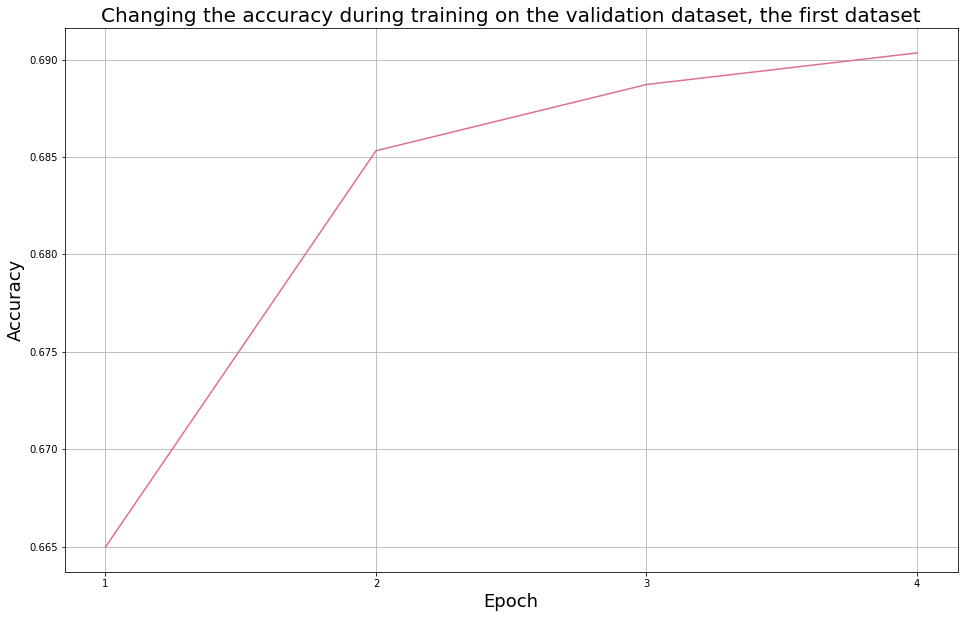

In [38]:
plt.figure(figsize=(16, 10))
plt.title('Changing the accuracy during training on the validation dataset, the first dataset', fontsize=20)
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.grid()
plt.plot([1, 2, 3, 4], [0.66497, 0.685325, 0.688725, 0.69035], color='palevioletred')
plt.xticks(ticks=[1, 2, 3, 4])
plt.show()

In [ ]:
optimizer_2 = AdamW(model_2.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )
epochs = 3
total_steps_2 = len(train_dataloader_rec) * epochs

scheduler_2 = get_linear_schedule_with_warmup(optimizer_2, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps_2)

all_loss_2 = {'train_loss':[], 'val_loss':[]}
all_acc_2 = {'train_acc':[], 'val_acc':[]}

print('Epoch')
for epoch in tqdm(range(3)):
    print()
    print('Обучение...')
    train_labels, train_predict, train_loss = train(model_2, train_dataloader_rec, optimizer_2, scheduler_2, device)
    train_acc = accuracy_score(train_labels, train_predict)

Epoch



Обучение...


0.25
0.5949876237623762
0.6150497512437811
0.6196013289036545
0.6245324189526185
0.627370259481038
0.6338914309484193
0.639577389443652
0.6432194132334582
0.644700332963374
0.6465721778221778
0.6487284287011807
0.6509679433805162
0.6529832820906994
0.6553577801570307
0.6561250832778148
0.6564647095565271
0.6578666960611405
0.6598938089950028
0.6610172277748554
0.6621532983508246
0.6638802950975726
0.664399704679691
0.665620925684485
0.6666102665556018
0.6675579768092763
0.6685169165705498
0.6696593854128101
0.6705306140664049
0.6716433988279904
0.6724216927690769
0.6727870041921961
0.6734711808809747
0.6743032414419873
0.6747739635401353
0.6754766495287061
0.6759493890585948
0.6764810186436099
0.6774039726387793
0.6775826711099718
0.678033616595851
0.6784625701048524
0.6789603665793859
0.6789627412229714
0.6793129402408543
0.6795434347922684
0.679872582047381
0.6801943735375452
0.6806524682357842
0.6807730565190777

Валидация...


NameError: ignored

In [ ]:
print('Валидация...')
valid_labels, valid_predict, val_loss = validation(model_2, valid_dataloader_rec, device)
val_acc = accuracy_score(valid_labels, valid_predict)

print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
print()

all_loss_2['train_loss'].append(train_loss)
all_loss_2['val_loss'].append(val_loss)
all_acc_2['train_acc'].append(train_acc)
all_acc_2['val_acc'].append(val_acc)

  torch.save(model_2.state_dict(), '/content/gdrive/My Drive/best_model_new_corrrr.pth')

Валидация...



  train_loss: 0.89801 - val_loss: 0.79392 - train_acc: 0.68103 - valid_acc: 0.70932



In [ ]:
print('Epoch')
for epoch in tqdm(range(1)):
    print()
    print('Обучение...')
    train_labels, train_predict, train_loss = train(model_2, train_dataloader_rec, optimizer_2, scheduler_2, device)
    train_acc = accuracy_score(train_labels, train_predict)

    print('Валидация...')
    valid_labels, valid_predict, val_loss = validation(model_2, valid_dataloader_rec, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    all_loss_2['train_loss'].append(train_loss)
    all_loss_2['val_loss'].append(val_loss)
    all_acc_2['train_acc'].append(train_acc)
    all_acc_2['val_acc'].append(val_acc)

    torch.save(model_2.state_dict(), '/content/gdrive/My Drive/best_model_new_corrrr.pth')

Epoch



Обучение...


0.78125
0.7172029702970297
0.7078669154228856
0.7088870431893688
0.7056577306733167
0.7078343313373253
0.7080386855241264
0.7094329529243937
0.7099719101123596
0.7080327413984462
0.7086038961038961
0.7094970481380564
0.7096950457951707
0.7101268255188317
0.7098278015703069
0.7097143570952699
0.7093613366645847
0.7095274838330394
0.7092934480843975
0.7091333508679643
0.7093484507746127
0.7092455973346026
0.7093224670604271
0.7094469795740982
0.7099776134943774
0.7103033786485405
0.7099913494809689
0.710292484265087
0.7107171545876473
0.7107678386763185
0.7112420859713429
0.7113935020960981
0.7114768822243049
0.7118960163586792
0.7122905027932961
0.7120376321051128
0.712171966120522
0.7124172520940286
0.7124769797421732
0.7126538067162266
0.7128217945513622
0.7128215679102657
0.7127395263032611
0.7128865380144153
0.7127854464894342
0.7129596200844257
0.7131465985655292
0.7134785152095299
0.7136338783586753
0.7137063864517446

Валидация...



  train_loss: 0.78005 - val_loss: 0.76413 - train_acc: 0.71374 - valid_acc: 0.72310




In [ ]:
print('Epoch')
for epoch in tqdm(range(1)):
    print()
    print('Обучение...')
    train_labels, train_predict, train_loss = train(model_2, train_dataloader_rec, optimizer_2, scheduler_2, device)
    train_acc = accuracy_score(train_labels, train_predict)

    print('Валидация...')
    valid_labels, valid_predict, val_loss = validation(model_2, valid_dataloader_rec, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    all_loss_2['train_loss'].append(train_loss)
    all_loss_2['val_loss'].append(val_loss)
    all_acc_2['train_acc'].append(train_acc)
    all_acc_2['val_acc'].append(val_acc)

    torch.save(model_2.state_dict(), '/content/gdrive/My Drive/best_model_new_corrrr.pth')

Epoch



Обучение...


0.75
0.7255569306930693
0.726523631840796
0.7240448504983389
0.7280236907730673
0.7282310379241517
0.7294093178036606
0.7306526390870185
0.7296348314606742
0.7276983906770256
0.7283653846153846
0.7279745685740237
0.7285595337218984
0.7280457340507303
0.7284528907922913
0.728909893404397
0.7293878825733916
0.7301771017048795
0.7310348417545808
0.7310297211993687
0.7307752373813093
0.7302326273203237
0.7312443207632894
0.7311223381138635
0.7314660558100792
0.7318197720911636
0.7317498077662438
0.7313263606071825
0.7315579257408068
0.7314826783867632
0.7310896367877374
0.7312258142534667
0.731509684473602
0.7314071493486822
0.7313382093501911
0.7315409882890602
0.7314548042210497
0.7312635098621995
0.7315344646145752
0.7315672263522174
0.7317701824543864
0.731902279931724
0.7319313853844323
0.7316031155545222
0.7316731992728925
0.731816540768718
0.7317363073244947
0.7319120931716656
0.732015465528015
0.7321975107120996

Валидация...



  train_loss: 0.72910 - val_loss: 0.74955 - train_acc: 0.73214 - valid_acc: 0.72725




In [ ]:
print('Epoch')
for epoch in tqdm(range(1)):
    print()
    print('Обучение...')
    train_labels, train_predict, train_loss = train(model_2, train_dataloader_rec, optimizer_2, scheduler_2, device)
    train_acc = accuracy_score(train_labels, train_predict)

    print('Валидация...')
    valid_labels, valid_predict, val_loss = validation(model_2, valid_dataloader_rec, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    all_loss_2['train_loss'].append(train_loss)
    all_loss_2['val_loss'].append(val_loss)
    all_acc_2['train_acc'].append(train_acc)
    all_acc_2['val_acc'].append(val_acc)

    torch.save(model_2.state_dict(), '/content/gdrive/My Drive/best_model_new_corrrr.pth')

Epoch



Обучение...


0.6875
0.744430693069307
0.7342972636815921
0.7357765780730897
0.736284289276808
0.7354041916167665
0.7364288685524126
0.7375178316690443
0.7363842072409488
0.7370976692563818
0.7364198301698301
0.7358935059037239
0.7366777685262281
0.7362845887778632
0.736683618843683
0.7371752165223184
0.7374297314178638
0.7378931510875956
0.7386174347584675
0.7385586533403472
0.7384276611694153
0.738413255592575
0.7386557246706043
0.7384017818339852
0.7384553311120367
0.7378673530587765
0.7379493464052288
0.7380368382080711
0.7378726347732952
0.7379782833505688
0.7384205264911696
0.7383908416639794
0.7382653858169322
0.7386019388064223
0.739047339017936
0.7390656241073978
0.738996112191058
0.7390570116184815
0.7390242699289661
0.7391934760317868
0.7388231067233192
0.7387451231406974
0.7387303618186146
0.738694489653569
0.7389655760054533
0.738884414574539
0.7386437730928059
0.7386593278025952
0.7386481982920224
0.7384271067129158

Валидация...



  train_loss: 0.71142 - val_loss: 0.74955 - train_acc: 0.73846 - valid_acc: 0.72725




In [ ]:
all_loss_2

{'train_loss': [0.8980136200904846,
  0.7800542142629623,
  0.7290957671165467,
  0.7114216930925846],
 'val_loss': [0.7939189579248428,
  0.7641299737930298,
  0.749548180103302,
  0.749548180103302]}

In [ ]:
all_acc_2

{'train_acc': [0.68103125, 0.7137375, 0.7321375, 0.73845625],
 'val_acc': [0.709325, 0.7231, 0.72725, 0.72725]}

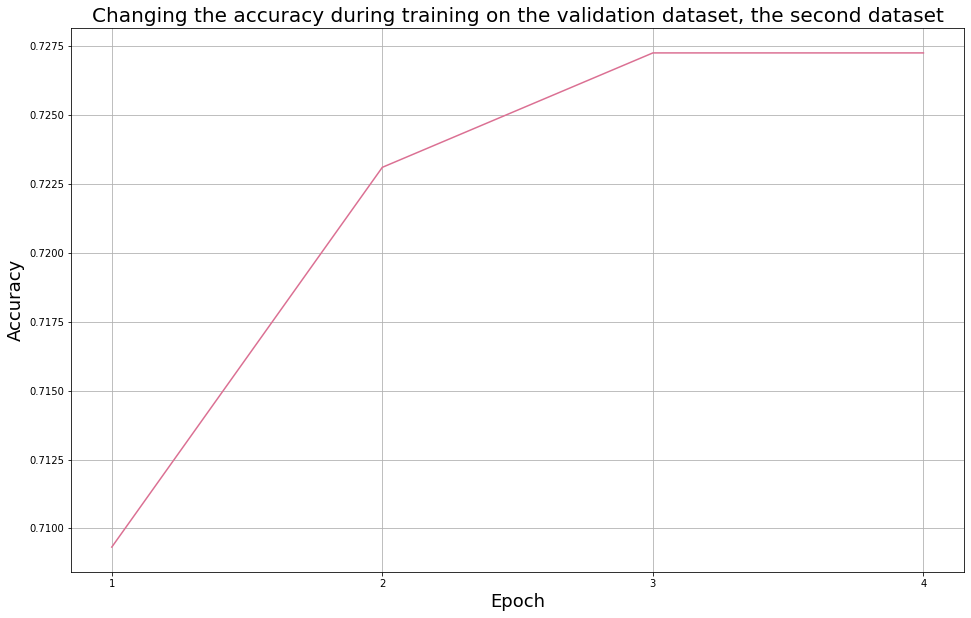

In [39]:
plt.figure(figsize=(16, 10))
plt.title('Changing the accuracy during training on the validation dataset, the second dataset', fontsize=20)
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.grid()
plt.plot([1, 2, 3, 4], [0.709325, 0.7231, 0.72725, 0.72725], color='palevioletred')
plt.xticks(ticks=[1, 2, 3, 4])
plt.show()

In [24]:
model_2.load_state_dict(torch.load('/content/gdrive/My Drive/best_model_new_corrrr.pth'))

<All keys matched successfully>

Оценка при помощи модели, обученной на другом датасете (с едой)

In [ ]:
sample_data_1 = pd.read_csv("/content/gdrive/My Drive/sample_review.csv")
true_labels_1 = pd.read_csv("/content/gdrive/My Drive/score_s.csv")
sample_data_2 = pd.read_csv("/content/gdrive/My Drive/rev_s_fin.csv")
true_labels_2 = pd.read_csv("/content/gdrive/My Drive/score_s_fin.csv")
sample_data_1 = sample_data_1.rename(columns={'reviewe': 'review'})
sample_data = pd.concat([sample_data_1, sample_data_2], axis=0)
true_labels = pd.concat([true_labels_1, true_labels_2], axis=0)
sample_data = sample_data.rename(columns={'reviewe': 'review'})
sample_data['score'] = true_labels
sample_data['score'] -= 1
sample_data['review'] = sample_data['review'].apply(text_cleaner)
sample_dataset = MovieReviewsDataset(sample_data, use_tokenizer=tokenizer)
dataloader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
true_l, pred_l, cur_acc = validation(model_2, dataloader, device)

In [ ]:
print('Accuracy модели:', accuracy_score(pred_l, true_l))

Accuracy модели: 0.635


Оценка модели, обученной на других данных этого же датасета.

In [40]:
sample_data_1 = pd.read_csv("/content/gdrive/My Drive/sample_review.csv")
true_labels_1 = pd.read_csv("/content/gdrive/My Drive/score_s.csv")
sample_data_2 = pd.read_csv("/content/gdrive/My Drive/rev_s_fin.csv")
true_labels_2 = pd.read_csv("/content/gdrive/My Drive/score_s_fin.csv")
sample_data_1 = sample_data_1.rename(columns={'reviewe': 'review'})
sample_data = pd.concat([sample_data_1, sample_data_2], axis=0)
true_labels = pd.concat([true_labels_1, true_labels_2], axis=0)
sample_data = sample_data.rename(columns={'reviewe': 'review'})
sample_data['score'] = true_labels
sample_data['score'] -= 1
sample_data['review'] = sample_data['review'].apply(text_cleaner)
sample_dataset = MovieReviewsDataset(sample_data, use_tokenizer=tokenizer)
dataloader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
true_l, pred_l, cur_acc = validation(model_1, dataloader, device)

In [41]:
print('Accuracy модели:', accuracy_score(pred_l, true_l))

Accuracy модели: 0.695


In [ ]:
true_labels = pd.read_csv("/content/gdrive/My Drive/score_s.csv")
my_pred = pd.read_csv("/content/gdrive/My Drive/my_pred.csv")
my_pred

print('Accuracy на ручной разметке рейтинга:', accuracy_score(true_labels, my_pred))

Accuracy на ручной разметке рейтинга: 0.59


С помощью "ручной" разметки точность вышла 0.59, так что GPT справляется с классификацией лучше, чем человек

Теперь оценим качество на валидационной выборке.

In [ ]:
data_cl = pd.read_csv("/content/gdrive/My Drive/data_summTY.csv")
data_cl['score'] = data_cl['score'].astype(int)

data_cl_rec = pd.read_csv("/content/gdrive/My Drive/Reviews.csv")
data_cl_rec = data_cl_rec.rename(columns={'Score': 'score'})

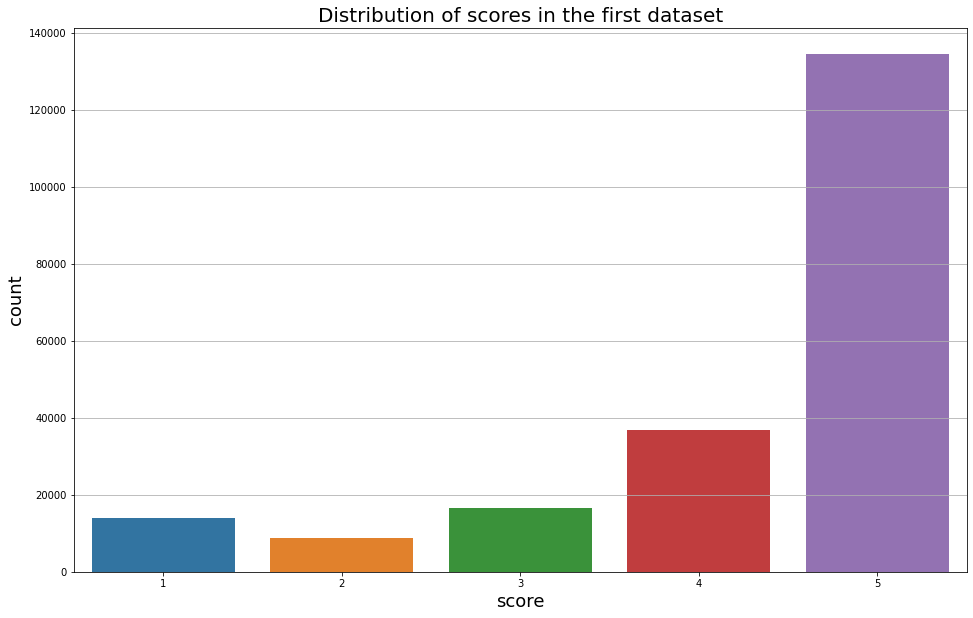

In [ ]:
plt.figure(figsize=(16, 10))
plt.title('Distribution of scores in the first dataset', fontsize=20)
plt.xlabel('score', size=18)
plt.ylabel('count', size=18)
plt.grid()
sns.countplot(x='score', data=data_cl.sort_values(by='score'))
plt.show()

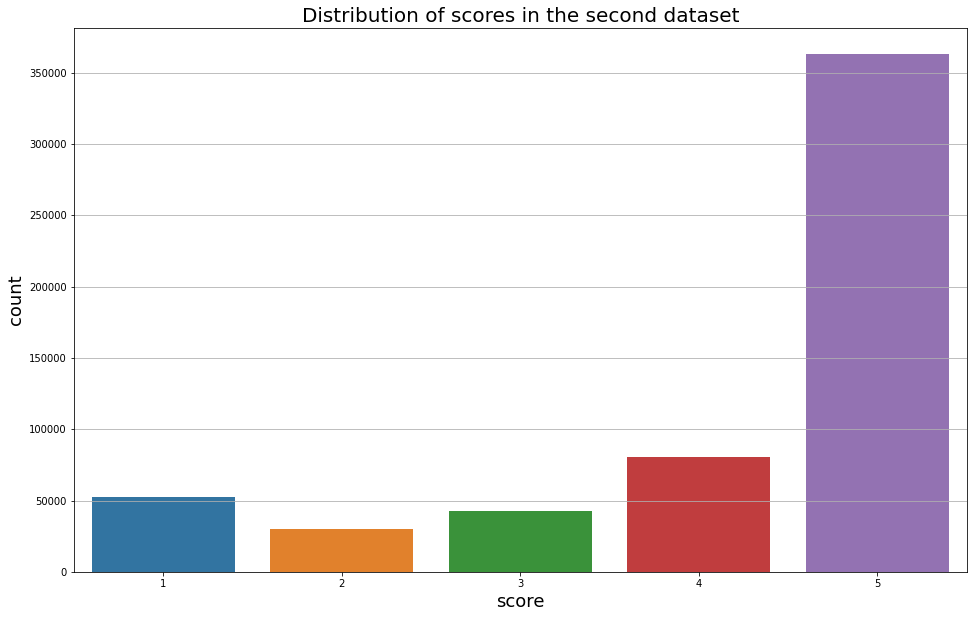

In [ ]:
plt.figure(figsize=(16, 10))
plt.title('Distribution of scores in the second dataset', fontsize=20)
plt.xlabel('score', size=18)
plt.ylabel('count', size=18)
plt.grid()
sns.countplot(x='score', data=data_cl_rec.sort_values(by='score'))
plt.show()

Для того, чтобы каждый класс вносил пропорциональный своему размеру вклад, воспользуемся микро-усреднением. И соответственно таким образом посчитаем основные метрики. Для этого сначала посчитаем TP, FP, TN, FP для каждого класса, а затем усредним по классам.

Затем сделаем тоже самое с макро-усреднением. 

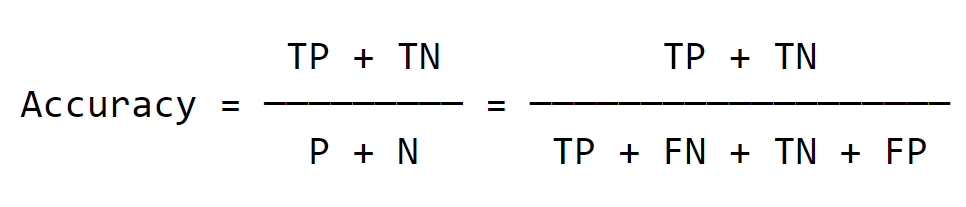

In [42]:
def my_accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + FN + TN + FP)

In [74]:
true_l_1, pred_l_1, cur_acc = validation(model_1, valid_dataloader, device)

In [77]:
pred_l_1 = np.array(pred_l_1)
true_l_1 = np.array(true_l_1)
index=['score = 1', 'score = 2', 'score = 3', 'score = 4', 'score = 5']
res_score_1 = pd.DataFrame(columns=['TP', 'FP', 'TN', 'FN'], index=index)

for i in range(5):
    res_score_1.loc[index[i], 'TP'] = np.sum((pred_l_1 == i) & (true_l_1 == i))
    res_score_1.loc[index[i], 'FP'] = np.sum((pred_l_1 == i) & (true_l_1 != i))
    res_score_1.loc[index[i], 'TN'] = np.sum((pred_l_1 != i) & (true_l_1 != i))
    res_score_1.loc[index[i], 'FN'] = np.sum((pred_l_1 != i) & (true_l_1 == i))

In [79]:
res_score_1

TP    FP     TN    FN
score = 1   1825  1095  36269   811
score = 2    335   418  37890  1357
score = 3    995  1289  35576  2140
score = 4   1655  1747  31263  5335
score = 5  24112  6529   7924  1435

In [78]:
true_l_2, pred_l_2, cur_acc = validation(model_2, valid_dataloader_rec, device)

In [80]:
pred_l_2 = np.array(pred_l_2)
true_l_2 = np.array(true_l_2)
index=['score = 1', 'score = 2', 'score = 3', 'score = 4', 'score = 5']
res_score_2 = pd.DataFrame(columns=['TP', 'FP', 'TN', 'FN'], index=index)

for i in range(5):
    res_score_2.loc[index[i], 'TP'] = np.sum((pred_l_2 == i) & (true_l_2 == i))
    res_score_2.loc[index[i], 'FP'] = np.sum((pred_l_2 == i) & (true_l_2 != i))
    res_score_2.loc[index[i], 'TN'] = np.sum((pred_l_2 != i) & (true_l_2 != i))
    res_score_2.loc[index[i], 'FN'] = np.sum((pred_l_2 != i) & (true_l_2 == i))

In [81]:
res_score_2

TP    FP     TN    FN
score = 1   2467  1323  34969  1241
score = 2    426   567  37307  1700
score = 3    994  1519  35490  1997
score = 4   1291  1337  33171  4201
score = 5  24311  5765   8552  1372

In [82]:
micro_tp_1 = np.mean(res_score_1['TP'])
micro_fp_1 = np.mean(res_score_1['FP'])
micro_tn_1 = np.mean(res_score_1['TN'])
micro_fn_1 = np.mean(res_score_1['FN'])

micro_accuracy_1 = my_accuracy(micro_tp_1, micro_tn_1, micro_fp_1, micro_fn_1)
print('Accuracy с микро-уреднением, первый датасет: ', micro_accuracy_1 * 100, '%', sep='')

Accuracy с микро-уреднением, первый датасет: 88.92200000000001%


In [83]:
micro_tp_2 = np.mean(res_score_2['TP'])
micro_fp_2 = np.mean(res_score_2['FP'])
micro_tn_2 = np.mean(res_score_2['TN'])
micro_fn_2 = np.mean(res_score_2['FN'])

micro_accuracy_2 = my_accuracy(micro_tp_2, micro_tn_2, micro_fp_2, micro_fn_2)
print('Accuracy с микро-уреднением, второй датасет: ', micro_accuracy_2 * 100, '%', sep='')

Accuracy с микро-уреднением, второй датасет: 89.48899999999999%


In [84]:
macro_acc_1_1 = my_accuracy(res_score_1.loc['score = 1', 'TP'], res_score_1.loc['score = 1', 'TN'],
                          res_score_1.loc['score = 1', 'FP'], res_score_1.loc['score = 1', 'FN'])
macro_acc_2_1 = my_accuracy(res_score_1.loc['score = 2', 'TP'], res_score_1.loc['score = 2', 'TN'],
                          res_score_1.loc['score = 2', 'FP'], res_score_1.loc['score = 2', 'FN'])
macro_acc_3_1 = my_accuracy(res_score_1.loc['score = 3', 'TP'], res_score_1.loc['score = 3', 'TN'],
                          res_score_1.loc['score = 3', 'FP'], res_score_1.loc['score = 3', 'FN'])
macro_acc_4_1 = my_accuracy(res_score_1.loc['score = 4', 'TP'], res_score_1.loc['score = 4', 'TN'],
                          res_score_1.loc['score = 4', 'FP'], res_score_1.loc['score = 4', 'FN'])
macro_acc_5_1 = my_accuracy(res_score_1.loc['score = 5', 'TP'], res_score_1.loc['score = 5', 'TN'],
                          res_score_1.loc['score = 5', 'FP'], res_score_1.loc['score = 5', 'FN'])

macro_acc_1 = [macro_acc_1_1, macro_acc_2_1, macro_acc_3_1, macro_acc_4_1, macro_acc_5_1]
macro_accuracy_1 = np.mean(macro_acc_1)
print('Accuracy с макро-уреднением, первый датасет: ', macro_accuracy_1 * 100, '%', sep='')

Accuracy с макро-уреднением, первый датасет: 88.922%


In [85]:
macro_acc_1_2 = my_accuracy(res_score_2.loc['score = 1', 'TP'], res_score_2.loc['score = 1', 'TN'],
                          res_score_2.loc['score = 1', 'FP'], res_score_2.loc['score = 1', 'FN'])
macro_acc_2_2 = my_accuracy(res_score_2.loc['score = 2', 'TP'], res_score_2.loc['score = 2', 'TN'],
                          res_score_2.loc['score = 2', 'FP'], res_score_2.loc['score = 2', 'FN'])
macro_acc_3_2 = my_accuracy(res_score_2.loc['score = 3', 'TP'], res_score_2.loc['score = 3', 'TN'],
                          res_score_2.loc['score = 3', 'FP'], res_score_2.loc['score = 3', 'FN'])
macro_acc_4_2 = my_accuracy(res_score_2.loc['score = 4', 'TP'], res_score_2.loc['score = 4', 'TN'],
                          res_score_2.loc['score = 4', 'FP'], res_score_2.loc['score = 4', 'FN'])
macro_acc_5_2 = my_accuracy(res_score_2.loc['score = 5', 'TP'], res_score_2.loc['score = 5', 'TN'],
                          res_score_2.loc['score = 5', 'FP'], res_score_2.loc['score = 5', 'FN'])

macro_acc_2 = [macro_acc_1_2, macro_acc_2_2, macro_acc_3_2, macro_acc_4_2, macro_acc_5_2]
macro_accuracy_2 = np.mean(macro_acc_2)
print('Accuracy с макро-уреднением, второй датасет: ', macro_accuracy_2 * 100, '%', sep='')

Accuracy с макро-уреднением, второй датасет: 89.48899999999999%


Посчитаем еще также precision и recall

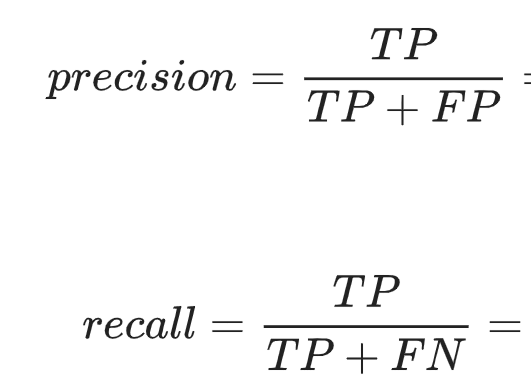

In [90]:
def my_precision(TP, FP):
    return TP / (TP + FP)

def my_recall(TP, FN):
    return TP / (TP + FN)

In [91]:
micro_precision_1 = my_precision(micro_tp_1, micro_fp_1)
print('Precision с микро-уреднением, первый датасет: ', micro_precision_1 * 100, '%', sep='')

micro_recall_1 = my_recall(micro_tp_1, micro_fn_1)
print('Recall с микро-уреднением, первый датасет: ', micro_recall_1 * 100, '%', sep='')

Precision с микро-уреднением, первый датасет: 72.30499999999999%
Recall с микро-уреднением, первый датасет: 72.30499999999999%


In [93]:
micro_precision_2 = my_precision(micro_tp_2, micro_fp_2)
print('Precision с микро-уреднением, второй датасет: ', micro_precision_2 * 100, '%', sep='')

micro_recall_2 = my_recall(micro_tp_2, micro_fn_2)
print('Recall с микро-уреднением, второй датасет: ', micro_recall_2 * 100, '%', sep='')

Precision с микро-уреднением, второй датасет: 73.7225%
Recall с микро-уреднением, второй датасет: 73.7225%


In [95]:
macro_pr_1_1 = my_precision(res_score_1.loc['score = 1', 'TP'], res_score_1.loc['score = 1', 'FP'])
macro_pr_2_1 = my_precision(res_score_1.loc['score = 2', 'TP'], res_score_1.loc['score = 2', 'FP'])
macro_pr_3_1 = my_precision(res_score_1.loc['score = 3', 'TP'], res_score_1.loc['score = 3', 'FP'])
macro_pr_4_1 = my_precision(res_score_1.loc['score = 4', 'TP'], res_score_1.loc['score = 4', 'FP'])
macro_pr_5_1 = my_precision(res_score_1.loc['score = 5', 'TP'], res_score_1.loc['score = 5', 'FP'])

macro_pr_1 = [macro_pr_1_1, macro_pr_2_1, macro_pr_3_1, macro_pr_4_1, macro_pr_5_1]
macro_precision_1 = np.mean(macro_pr_1)
print('Precision с макро-уреднением, первый датасет: ', macro_precision_1 * 100, '%', sep='')

Precision с макро-уреднением, первый датасет: 55.578487532239386%


In [96]:
macro_pr_1_2 = my_precision(res_score_2.loc['score = 1', 'TP'], res_score_2.loc['score = 1', 'FP'])
macro_pr_2_2 = my_precision(res_score_2.loc['score = 2', 'TP'], res_score_2.loc['score = 2', 'FP'])
macro_pr_3_2 = my_precision(res_score_2.loc['score = 3', 'TP'], res_score_2.loc['score = 3', 'FP'])
macro_pr_4_2 = my_precision(res_score_2.loc['score = 4', 'TP'], res_score_2.loc['score = 4', 'FP'])
macro_pr_5_2 = my_precision(res_score_2.loc['score = 5', 'TP'], res_score_2.loc['score = 5', 'FP'])

macro_pr_2 = [macro_pr_1_2, macro_pr_2_2, macro_pr_3_2, macro_pr_4_2, macro_pr_5_2]
macro_precision_2 = np.mean(macro_pr_2)
print('Precision с макро-уреднением, второй датасет: ', macro_precision_2 * 100, '%', sep='')

Precision с макро-уреднением, второй датасет: 55.500734045732024%


In [97]:
macro_r_1_1 = my_recall(res_score_1.loc['score = 1', 'TP'], res_score_1.loc['score = 1', 'FN'])
macro_r_2_1 = my_recall(res_score_1.loc['score = 2', 'TP'], res_score_1.loc['score = 2', 'FN'])
macro_r_3_1 = my_recall(res_score_1.loc['score = 3', 'TP'], res_score_1.loc['score = 3', 'FN'])
macro_r_4_1 = my_recall(res_score_1.loc['score = 4', 'TP'], res_score_1.loc['score = 4', 'FN'])
macro_r_5_1 = my_recall(res_score_1.loc['score = 5', 'TP'], res_score_1.loc['score = 5', 'FN'])

macro_r_1 = [macro_r_1_1, macro_r_2_1, macro_r_3_1, macro_r_4_1, macro_r_5_1]
macro_recall_1 = np.mean(macro_r_1)
print('Recall с макро-уреднением, первый датасет: ', macro_recall_1 * 100, '%', sep='')

Recall с макро-уреднением, первый датасет: 47.76615237102061%


In [98]:
macro_r_1_2 = my_recall(res_score_2.loc['score = 1', 'TP'], res_score_2.loc['score = 1', 'FN'])
macro_r_2_2 = my_recall(res_score_2.loc['score = 2', 'TP'], res_score_2.loc['score = 2', 'FN'])
macro_r_3_2 = my_recall(res_score_2.loc['score = 3', 'TP'], res_score_2.loc['score = 3', 'FN'])
macro_r_4_2 = my_recall(res_score_2.loc['score = 4', 'TP'], res_score_2.loc['score = 4', 'FN'])
macro_r_5_2 = my_recall(res_score_2.loc['score = 5', 'TP'], res_score_2.loc['score = 5', 'FN'])

macro_r_2 = [macro_r_1_2, macro_r_2_2, macro_r_3_2, macro_r_4_2, macro_r_5_2]
macro_recall_2 = np.mean(macro_r_2)
print('Recall с макро-уреднением, второй датасет: ', macro_recall_2 * 100, '%', sep='')

Recall с макро-уреднением, второй датасет: 47.59346979320025%


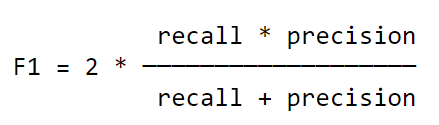

In [99]:
def my_F1(recall, precision):
    return 2 * (recall * precision) / (recall + precision)

In [100]:
F_1_micro_1 = my_F1(micro_recall_1, micro_precision_1)
print('F1 мера с микро-уреднением, первый датасет:', F_1_micro_1)

F1 мера с микро-уреднением, первый датасет: 0.7230500000000001


In [102]:
F_1_micro_2 = my_F1(micro_recall_2, micro_precision_2)
print('F1 мера с микро-уреднением, второй датасет:', F_1_micro_2)

F1 мера с микро-уреднением, второй датасет: 0.737225


In [103]:
F_1_macro_1 = my_F1(macro_recall_1, macro_precision_1)
print('F1 мера с макро-уреднением, первый датасет:', F_1_macro_1)

F1 мера с макро-уреднением, первый датасет: 0.5137703332269429


In [104]:
F_1_macro_2 = my_F1(macro_recall_2, macro_precision_2)
print('F1 мера с макро-уреднением, первый датасет:', F_1_macro_2)

F1 мера с макро-уреднением, первый датасет: 0.5124386068168979


##Суммаризация

In [ ]:
data_pr = pd.read_csv("/content/gdrive/My Drive/data_summm.csv")

In [ ]:
data_pr

Unnamed: 0  ...                                             review
0                0  ...  This is a fascinating true story, well acted b...
1                1  ...  Our previous dvd of An American Christmas Caro...
2                2  ...  The Christmas Carol is my all time favorite st...
3                3  ...  A new twist on the classic Christmas Carol but...
4                4  ...  For fans of the Dickens story this remains fre...
...            ...  ...                                                ...
118221      118221  ...  I've become very prejudiced against modern sci...
118222      118222  ...  I own most of the the Celtic Thunder I love th...
118223      118223  ...  Anything from Celtic Thunder will not disappoi...
118224      118224  ...  I do not wish to write a review about this rel...
118225      118225  ...  This 2014 film is just being released on DVD i...

[118226 rows x 3 columns]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>', 'cls_token':'<|cls|>'}
num_add_toks = tokenizer.add_special_tokens(special_tokens)

In [ ]:
class GPT21024Dataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        text = self.tokenizer.encode(self.tokenizer.pad_token)*1024
        content = data['review'] + self.tokenizer.encode(self.tokenizer.sep_token) + data['summary']
        text[:len(content)] = content
        text = torch.tensor(text)
        sample = {'review': text, 'sum_idx': len(data['review'])}
        return sample

In [ ]:
class GPT21024Dataset_CNN(Dataset):

    def __init__(self, root_dir, ids_file, mode='train',length=None):
        self.root_dir = root_dir
        self.tokenizer = tokenizer

        with open(ids_file,'r') as f:
            if mode=='train':
                self.idxs = np.array(json.load(f)['train_ids'])
            elif mode=='valid':
                self.idxs = np.array(json.load(f)['valid_ids'])
            elif mode=='test':
                self.idxs = np.array(json.load(f)['test_ids'])

            self.idxs = self.idxs -min(self.idxs)
        
        self.idxs = os.listdir(root_dir)
        self.mode = mode
        if len == None:
            self.len = len(self.idxs)
        else:
            self.len = length

    def __len__(self):
        return self.len

    def __getitem__(self,idx):

        if self.mode=='valid':
            idx = self.idxs[-idx]
        elif self.mode=='test':
            idx = self.idxs[-idx-self.len]   #assuming valid and test set of same sizes
        else:
            idx = self.idxs[idx]
        # file_name = os.path.join(self.root_dir,str(idx)+".json")
        file_name = os.path.join(self.root_dir,str(idx))
        with open(file_name,'r') as f:
              data = json.load(f)
        text = self.tokenizer.encode(self.tokenizer.pad_token)*1024
        content = data['article'] + self.tokenizer.encode(self.tokenizer.sep_token) + data['abstract']
        text[:len(content)] = content
        text = torch.tensor(text)
        sample = {'article': text, 'sum_idx': len(data['article'])}
        return sample

In [ ]:
train_data_CNN = GPT21024Dataset_CNN('/content/gdrive/My Drive/gpt2_1024_data', '/content/gdrive/My Drive/ids.json', mode='train', length=1000) #training on only 3000 datasets
valid_data_CNN = GPT21024Dataset_CNN('/content/gdrive/My Drive/gpt2_1024_data', '/content/gdrive/My Drive/ids.json', mode='valid', length=500)  #validation on only 500 datasets

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--lr",default=5e-5, type=float, help="learning rate")
parser.add_argument("--seed",default=42, type=int,  help="seed to replicate results")
parser.add_argument("--n_gpu",default=1, type=int,  help="no of gpu available")
parser.add_argument("--gradient_accumulation_steps",default=2, type=int, help="gradient_accumulation_steps")
parser.add_argument("--batch_size",default=1, type=int,  help="batch_size")
parser.add_argument("--num_workers",default=2, type=int,  help="num of cpus available")
parser.add_argument("--device",default=torch.device('cuda'), help="torch.device object")
parser.add_argument("--num_train_epochs",default=1, type=int,  help="no of epochs of training")
parser.add_argument("--max_grad_norm",default=1.0, type=float, help="max gradient norm.")
args = parser.parse_args([])
print(args)

Namespace(batch_size=1, device=device(type='cuda'), gradient_accumulation_steps=2, lr=5e-05, max_grad_norm=1.0, n_gpu=1, num_train_epochs=1, num_workers=2, seed=42)


In [ ]:
data_pr['summary'] = data_pr['summary'].apply(text_cleaner)
data_pr['review'] = data_pr['review'].apply(text_cleaner)

In [ ]:
data_pr = data_pr.drop(columns='Unnamed: 0')
data_pr

summary                                             review
0       A remarkable true story, told English (contrar...  This fascinating true story, well acted many a...
1        lost one husband'favorite Christmas movies I ...  Our previous dvd An American Christmas Carol l...
2       The Christmas Carol time favorite story. I 'fo...  The Christmas Carol time favorite story. I 'fo...
3        new twist classic Christmas Carol still good....  A new twist classic Christmas Carol still good...
4       For fans Henry Winkler delivers Fonzi good loo...  For fans Dickens story remains fresh today! Fo...
...                                                   ...                                                ...
118221  good stuff, season 2 good season 1 [review ser...  I'become prejudiced modern sci fi - every "Fir...
118222  I Celtic Thunder I love music I even made couple   I Celtic Thunder I love music I even made coup...
118223  Anything Celtic Thunder disappoint. Bought 88 ...  Anything Celtic Thunder disappoint. Bought 88 ...
118224  Voices MET video releases, broadcasts HD trans...  I wish write review release. I would like poin...
118225  Georgian-French film Iranian Director satire e...  This 2014 film released DVD US Corinth Films. ...

[118226 rows x 2 columns]

In [ ]:
tok_data = []
for r, s in zip(data_pr['review'], data_pr['summary']):
    if len(s) >= 70: 
        tok_data.append({'review' : tokenizer.encode(r), 'summary' : tokenizer.encode(s)})  

In [ ]:
len(tok_data)

54183

In [ ]:
train_dataset = GPT21024Dataset(tok_data[:50000], tokenizer)
eval_dataset = GPT21024Dataset(tok_data[50000:], tokenizer)

In [ ]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [ ]:
def rand_generate_sample(data, tokenizer, model, num=1, eval_step=False, length=100, temperature=1, top_k=10, top_p=0.5, device=torch.device('cuda')):
    num = np.random.randint(0, len(data), num)
    for i in num:
        sample = data[i]
        idx = sample['sum_idx']
        context = sample['review'][:idx+1].tolist()
        summary = sample['review'][idx+1:][:100].tolist()
        generated_text = sample_seq(model, context, length, device, temperature, top_k, top_p)
        generated_text = generated_text[0, len(context):].tolist()
        text = tokenizer.convert_ids_to_tokens(generated_text,skip_special_tokens=True)
        text = tokenizer.convert_tokens_to_string(text)
        if eval_step==False:
            print('new_article', end='\n\n')
            print(tokenizer.decode(context), end='\n\n')
            print("generated_summary", end='\n\n')
            print(text, end='\n\n')
            print('actual_summary', end='\n\n')
            print(tokenizer.decode(summary), end='\n\n')
        else:
            print(tokenizer.decode(context), end='\n\n')
            print("generated_summary", end='\n\n')

In [ ]:
def generate_sample_my(data, tokenizer, model, device, num=1, length=100, temperature=1, top_k=10, top_p=0.5):
    num = np.random.randint(0, len(data), num)
    for i in num:
        sample = data[i]
        idx = sample['sum_idx']
        context = sample['review'][:idx+1].tolist()
        summary = sample['review'][idx+1:][:100].tolist()
        generated_text = sample_seq(model, context, length, device, temperature, top_k, top_p)
        generated_text = generated_text[0, len(context):].tolist()

        print('new_article', end='\n\n')
        print(tokenizer.decode(context), end='\n\n')
        print('generated_summary', end='\n\n')
        print(tokenizer.decode(generated_text, skip_special_tokens=True), end='\n\n')
        print('actual_summary', end='\n\n')
        print(tokenizer.decode(summary, skip_special_tokens=True), end='\n\n')

In [ ]:
def generate_sample_PREV(data, tokenizer, model, num=1, eval_step=False, length=100, temperature=1, top_k=10, top_p=0.5, device=torch.device('cuda')):
    for i in range(num):
        sample = data[i]
        idx = sample['sum_idx']
        context = sample['article'][:idx].tolist()
        summary = sample['article'][idx+1:][:100].tolist()
        generated_text = sample_seq(model, context, length, device, temperature, top_k, top_p)
        generated_text = generated_text[0, len(context):].tolist()
        text = tokenizer.convert_ids_to_tokens(generated_text,skip_special_tokens=True)
        text = tokenizer.convert_tokens_to_string(text)
        if eval_step==False:
            print('new_article', end='\n\n')
            print(tokenizer.decode(context), end='\n\n')
            print("generated_summary", end='\n\n')
            print(text, end='\n\n')
            print('actual_summary', end='\n\n')
            print(tokenizer.decode(summary), end='\n\n')
        else:
            print(tokenizer.decode(context), end='\n\n')
            print("generated_summary", end='\n\n')

In [ ]:
def train_my(args, model, tokenizer, train_dataset, valid_dataset, ignore_index):
    writer = SummaryWriter('./output/logs')
    #print(train_dataset.data)
    train_sampler = RandomSampler(train_dataset)
    train_dl = DataLoader(train_dataset, sampler=train_sampler, 
                          batch_size=args.batch_size, num_workers=args.num_workers)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation
    optimizer = AdamW(model.parameters(),lr=args.lr)
    scheduler = WarmupLinearSchedule(optimizer, 100, len(train_dl))

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)
    for _ in train_iterator:
        torch.save(model_2.state_dict(), PATH_2)
        epoch_iterator = tqdm_notebook(train_dl, desc="Training")
        for step, batch in enumerate(epoch_iterator):
            if step % 100 == 0:
                rand_generate_sample(valid_dataset, tokenizer, model, num=3, eval_step=False, device=args.device)
            inputs, labels = batch['review'].to(args.device), batch['review'].to(args.device)
            model.train()
            logits = model(inputs)[0]
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., batch['sum_idx']:-1, :].contiguous()
            shift_labels = labels[..., batch['sum_idx']+1:].contiguous()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss = loss/args.gradient_accumulation_steps
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                writer.add_scalar('loss', (tr_loss - logging_loss)/args.gradient_accumulation_steps, global_step)
                logging_loss = tr_loss
                print("loss:", loss.item(), end='\n\n')
                if (step + 1)/args.gradient_accumulation_steps == 1.0:
                	print('After 1st update: ', end='\n\n')
                	rand_generate_sample(valid_dataset, tokenizer, model, num=5, eval_step=False, device=args.device)
                
            """   
            if (step + 1) % (10*args.gradient_accumulation_steps) == 0:
                results = evaluate(args, model, valid_dataset, ignore_index, global_step)
                for key, value in results.items():
                    writer.add_scalar('eval_{}'.format(key), value, global_step)
                print('After', global_step+1,'updates: ', end='\n\n')
                generate_sample(valid_dataset, tokenizer, num=2, eval_step=True,device=args.device)
            """

In [ ]:
def train(args, model, tokenizer, train_dataset, valid_dataset, ignore_index):
    writer = SummaryWriter('./output/logs')
    train_sampler = RandomSampler(train_dataset)
    train_dl = DataLoader(train_dataset,sampler=train_sampler,batch_size=args.batch_size,num_workers=args.num_workers)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index)
    optimizer = AdamW(model.parameters(),lr=args.lr)
    scheduler = WarmupLinearSchedule(optimizer,100,80000)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dl, desc="Training")
        for step, batch in enumerate(epoch_iterator):
            inputs, labels = batch['article'].to(args.device), batch['article'].to(args.device)
            model.train()
            logits = model(inputs)[0]

            """
            print(logits)
            print('----')
            print(labels)
            """

            #было: рецензия + токен + саммари
            #стало: рецензия + токен + лэбел + токен + саммари

            shift_logits_cl = logits[..., batch['sc_idx']:-1, :].contiguous()
            shift_logits_sum = logits[..., batch['sum_idx']:-1, :].contiguous()  #тут начиная с sep токена
            shift_labels = labels[..., batch['sum_idx']+1:].contiguous()

            """
            print('----')
            print(shift_logits)
            print('====')
            print(shift_labels)
            """

            loss = loss_fct(shift_logits_sum.view(-1, shift_logits_sum.size(-1)), shift_labels.view(-1))
            loss = loss/args.gradient_accumulation_steps
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step += 1
                writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                writer.add_scalar('loss', (tr_loss - logging_loss)/args.gradient_accumulation_steps, global_step)
                logging_loss = tr_loss
                print("loss:", loss.item(), end='\n\n')
                if (step + 1)/args.gradient_accumulation_steps == 1.0:
                	print('After 1st update: ', end='\n\n')
                	generate_sample_PREV(valid_dataset, tokenizer, model, num=2, eval_step=False,device=args.device)
                
                
            if (step + 1) % (10*args.gradient_accumulation_steps) == 0:
                results = evaluate(args, model, valid_dataset, ignore_index, global_step)
                for key, value in results.items():
                    writer.add_scalar('eval_{}'.format(key), value, global_step)
                print('After', global_step+1,'updates: ', end='\n\n')
                generate_sample_PREV(valid_dataset, tokenizer, model, num=2, eval_step=True,device=args.device)

In [ ]:
def evaluate_my(args, model, eval_dataset, ignore_index, global_step=None):  
    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.batch_size)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation

    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        inputs, labels = batch['review'].to(args.device), batch['review'].to(args.device)
        
        with torch.no_grad():
            logits = model(inputs)[0]
            idx = batch['sum_idx'].item() # index of separator token
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., batch['sum_idx']:-1, :].contiguous()
            shift_labels = labels[..., batch['sum_idx']+1:].contiguous()
            lm_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {
        "perplexity": perplexity
    }
    print("perplexity:", perplexity.item())

    return result

In [ ]:
def evaluate(args, model, eval_dataset, ignore_index, global_step=None):
    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.batch_size)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation

    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        inputs, labels = batch['article'].to(args.device), batch['article'].to(args.device)
        
        with torch.no_grad():
            logits = model(inputs)[0]
            idx = batch['sum_idx'].item() # index of separator token
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., batch['sum_idx']:-1, :].contiguous()
            shift_labels = labels[..., batch['sum_idx']+1:].contiguous()
            lm_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {
        "perplexity": perplexity
    }
    print("perplexity:", perplexity.item())

    return result

In [ ]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits


def sample_seq(model, context, length, device, temperature=1, top_k=0, top_p=0.0):
    context = torch.tensor(context, dtype=torch.long, device=device)
    context = context.unsqueeze(0)
    generated = context
    with torch.no_grad():  
        for _ in tnrange(length):
            inputs = {'input_ids': generated}
            outputs = model(**inputs)  
            next_token_logits = outputs[0][0, -1, :] / temperature
            filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
            next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
            generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
    return generated

In [ ]:
ignore_idx = tokenizer.pad_token_id
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))
model.to('cuda')

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()
model = model.to('cuda')

In [ ]:
start = time.time()
train(args, model, tokenizer, train_data_CNN, valid_data_CNN, ignore_idx)
print('total time: ', (time.time()-start)/60, " minutes", end='\n\n')
torch.save(model.state_dict(), PATH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


tensor([[[-55.4244, -53.1132, -54.8225,  ...,   1.2719,  -2.7028,   0.6849],
         [-59.3732, -58.0170, -59.3713,  ...,   0.7089,  -3.3015,   2.4937],
         [-66.4394, -66.8097, -67.9211,  ...,   0.1296,  -1.1059,  -0.2860],
         ...,
         [-79.4249, -75.3241, -82.5279,  ...,  -1.1069,   3.4259,  -2.6170],
         [-80.8630, -79.3393, -83.1343,  ...,  -0.9480,   5.8293,  -4.5319],
         [-70.1706, -73.5629, -82.6095,  ...,   0.3383,  -2.0859,   3.7569]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward>)
----
tensor([[[-1.2033e+02, -1.2003e+02, -1.2266e+02,  ...,  2.7666e-01,
          -4.2610e+00,  4.1843e+00],
         [-6.3039e+01, -6.1651e+01, -6.3108e+01,  ...,  2.3000e-01,
          -8.2471e-01, -8.1655e-02],
         [-8.9113e+01, -8.6353e+01, -9.0549e+01,  ..., -8.4321e-02,
          -3.3544e+00,  2.7391e+00],
         ...,
         [-6.5923e+01, -6.1987e+01, -6.5851e+01,  ...,  2.9453e-02,
           2.1298e+00, -6.4708e-01],
         [-7.9425e+01, -7.532

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



new_article

-LRB- CNN -RRB- -- As Parisians head to the polls for a second round of municipal elections this Sunday, one of two women could become Paris'first `` Madame le Maire ''. On the left is the Socialist candidate, Spanish-born Anne Hidalgo, 54, the deputy mayor under Paris'incumbent Bertrand Delanoë. On the right is Natalie Kosciusko-Morizet, 40, a former minister in Nicolas Sarkozy's center-right government. As women have long been underrepresented in French politics, this upcoming local election is expected to be an historic one. Today, women make up 26.9 % of National Assembly députés, while in local politics they account for just 13.9 %. Click on the flashing icons above to discover more about the two contenders going head to head in Paris'mayoral elections. Lauren Said-Moorhouse contributed to this piece.

generated_summary

 . of . the .

actual_summary

Mayoral elections will be held in Paris this weekend. For the first time the two contenders battling it out for the r

KeyboardInterrupt: ignored

In [ ]:
generate_sample_PREV(valid_data_CNN, tokenizer, model, num=3, length=100, temperature=1, top_k=15, top_p=0.5, device=args.device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



new_article

-LRB- CNN -RRB- -- As Parisians head to the polls for a second round of municipal elections this Sunday, one of two women could become Paris'first `` Madame le Maire ''. On the left is the Socialist candidate, Spanish-born Anne Hidalgo, 54, the deputy mayor under Paris'incumbent Bertrand Delanoë. On the right is Natalie Kosciusko-Morizet, 40, a former minister in Nicolas Sarkozy's center-right government. As women have long been underrepresented in French politics, this upcoming local election is expected to be an historic one. Today, women make up 26.9 % of National Assembly députés, while in local politics they account for just 13.9 %. Click on the flashing icons above to discover more about the two contenders going head to head in Paris'mayoral elections. Lauren Said-Moorhouse contributed to this piece.

generated_summary

 In addition to the Socialist candidate , Spanish-born Anne Hidalgo , 54 , the Socialist candidate is a former minister in Nicolas Sarkozy 's center


new_article

Los Angeles -LRB- CNN -RRB- -- The release of 3-D versions of `` Star Wars '' Episodes II and III, previously planned for next fall, have been postponed while Lucasfilm focuses on new episodes, the company said Monday. `` Given the recent development that we are moving forward with a new Star Wars trilogy, we will now focus 100 % of our efforts on `` Star Wars : Episode VII '' in order to ensure the best possible experience for our fans, '' Lucasfilm said. The revised 3-D release plans will be announced `` at a later date, '' it said. The announcement comes three months after Disney bought Lucasfilm for $ 4 billion and just days after it revealed that J.J. Abrams has been signed to direct the next Star Wars episode. `` Star Wars : Episode VII '' is set for release in 2015. A good week to be J.J. Abrams.

generated_summary

 Lucasfilm says it will focus 100 % of its efforts on `` Star Wars : Episode VII '' in order to ensure the best possible experience for fans . The revi


new_article

-LRB- CNN -RRB- -- The Navy identified Thursday the two crew members who died when their F/A -18 F Super Hornet crashed during a training flight in central California. The fighter jet, manufactured by Boeing, went down Wednesday afternoon just west of Naval Air Station Lemoore. Lt. Matthew Ira Lowe, 33, of Plantation, Florida, and Lt. Nathan Hollingsworth Williams, 28, of Oswego, New York, were killed when the plane crashed in a farm field, the air station said in a statement. Lowe, the pilot, earned the Navy/Marine Corps Achievement Medal and the National Defense Service Medal during his career. Williams, a naval flight officer who managed the plane's weapons systems, earned the Air Medal, Afghanistan Campaign Medal, Global War on Terrorism Service Medal, Sea Service Deployment ribbon and Pistol Marksmanship Medal. A Navy review board is investigating the incident. Capt. James Knapp, commanding officer of the station, said the plane and crew were assigned to Strike Fight

In [ ]:
start = time.time()
PATH = '/content/gdrive/My Drive/best_model_state_dict.pth'
torch.save(model.state_dict(), PATH)
train_my(args, model, tokenizer, train_dataset, eval_dataset, ignore_idx)
print('total time: ', (time.time()-start)/60, " minutes", end='\n\n')
torch.save(model.state_dict(), PATH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


loss: 1.0121135711669922

After 1st update: 



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue. It is a Mexican film dubbed English I get feeling wrong dialogue. It is a Mexican film dubbed English I get feeling wrong dialogue. It is a Mexican film dubbed English I get feeling wrong dialogue.<|sep|>Grandfather of 12 year old boy is a Mexican film dubbed English I get feeling wrong

actual_summary

 Besides accusations Dire


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink has been a guest host on the show for several years . The actor is a guest host on the<|sep|>The first season of The Comedy Central Show . The show is a weekly comedy series that takes place in the neighborhood of San Francisco . Ethan Inglebrink is the host on the show . Ethan Inglebrink is

actual_summary

 An Unabashed, Unafraid, All-Star Comedy Unusual yet Swe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



perplexity: 97.5023422241211
After 11 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot




new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink is a charming clownish clownish character . Ethan Inglebrink is a charming clownish character . Ethan Inglebrink is a charming clownish character . Ethan Inglebrink is a charming clownish character . Ethan Inglebrink is a charming clownish character . Ethan Inglebrink is a charming

actual_summary

 An Unabashed, Unafraid, All-Star Comedy Unusual yet Sweetly Touch


perplexity: 73.88858795166016
After 21 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It also has Mexican film dubbed English I get feeling lot wrong dialogue translation story. It also has Mexican film dubbed English I get feeling lot wrong dialogue translation story. It also has Mexican film dubbed English I get feeling lot wrong dialogue translation story. It also has Mexican film dubbed English I get feeling lot wrong dialogue translation story. It also has Mexican film dubb


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 The film is one of the most unique<|sep|> comedy films ever<|sep|>The film is one of the most unique films ever produced . Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn),

actual_summary

 An Unabashed, Unafraid, All-Star


perplexity: 58.33660888671875
After 31 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It also has a Mexican film dubbed English I get feeling lot wrong dialogue translation story. The movie is dubbed English I get feeling lot wrong dialogue translation story. It also has a Mexican film dubbed English I get feeling lot wrong dialogue translation story. It also has a Mexican film dubbed English I get feeling lot wrong dialogue translation story. The movie is dubbed English

actual


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink is a beloved character . The film is unique in its charm and humor . Ethan Inglebrink is a beloved character . The film is unique in its charm and humor . Ethan Inglebrink is a beloved character . The film is unique in its charm and humor . Ethan Inglebrink is a beloved character .

actual_summary

 An Unabashed, Unafraid, All-Star Comedy Unusual yet Sweetly Touch


perplexity: 52.154029846191406
After 41 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot




new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink is a clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clownish clown

actual_summary

 An Unabashed, Unafraid, All-Star Comedy Unusual yet Sweetl


perplexity: 52.2253303527832
After 51 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'may, it's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . I'may, it's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee

actual_summary

 Besides accusations Directors producers poss


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink is an original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agor

actual_summary

 An Unabashed, Unafrai


perplexity: 54.119571685791016
After 61 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'may wonder if it is possible to get kids movie with Mexican subtitles.<|sep|> The movie is Mexican and it is best way to watch . I'may wonder if it is possible to get kids movie with Mexican subtitles. It is Mexican and it is best way to watch . It is Mexican and it is best way to watch . It is Mexican

actual_summary

 Besides accusations Directors producers possible "young boy fetish" prett


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 The film is a unique, incredibly colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia,

actual_summary

 An Unabashed, Unafraid,


perplexity: 44.79983139038086
After 71 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The movie is Mexican and Spanish I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. It is Mexican and Spanish I get feeling lot wrong dialogue story. Then comic relief chimpanzee throughout film. It is Mexican and Spanish I get feeling lot wrong dialogue story. Then comic relief chimpanzee throughout film. It is Mexican and Spanish

actual_summary



new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American

actual_summary

 An Un


perplexity: 42.089298248291016
After 81 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot wrong dialogue story. It is Mexican film dubbed English I get feeling lot wrong dialogue story. It is Mexican film

actual_summ


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A unique, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted

actual_summary

 An Unabashed, Unafraid


perplexity: 39.836219787597656
After 91 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I wonder if it would be a good film to watch if it were a good movie. The story is really great and I'm wondering if it would be a good movie. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. It is Mexican film dubbed

actual_summary

 Besides accusations Directors producer


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film is one of the best comedies ever made. The film is one of the best comedies ever made. The film is one of the best comedies ever made. The film is one of the best comedies ever made. The film is one of the best comedies ever made. The film is one of the best comedies ever

actual_summary

 An Unabashed, Unafraid, All-Star Comedy Unusual yet Sweetly Touching Proportions <


perplexity: 43.34025192260742
After 101 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It 's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious

actual_summary

 Besides accusations D


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode

actual_summary

 An Unabas


perplexity: 47.852989196777344
After 111 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The story is a bit<|sep|>old, but it's not bad. It's a bit old, but it's not bad. It's a bit old, but it's not bad. It's a bit old, but it's not bad. It's a bit old, but it's not bad. It's a bit old, but it

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living

actual_summary

 An Unabashed, Unafraid, All


perplexity: 39.567405700683594
After 121 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 Also,<|sep|> "I want to watch this movie" I want to watch this movie. But I want to watch this movie. But I want to watch this movie. But I want to watch this movie. But I want to watch this movie. But I want to watch this movie. But I want to watch this movie. But I want to

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|p


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode

actual_summary

 An Unabas


perplexity: 39.49079513549805
After 131 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The "grandfather" 12 year old boy is really weird,<|sep|> I<|sep|> I don't think he's weird, I think he's weird, I think he's weird, I think he's weird, I think he's weird, I think he's weird, I think he's weird, I think he's weird, I think he's

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American

actual_summary

 An Un


perplexity: 37.70024490356445
After 141 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious-

actual_summary

 Besides accusations D


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode

actual_summary

 An Unabas


perplexity: 38.073753356933594
After 151 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The movie is Mexican, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American, American

actual_summary

 Besides accusations Director


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 The original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted

actual_summary

 An Unabashed, Unaf


perplexity: 36.836341857910156
After 161 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. But it's Mexican film dubbed English I get feeling lot wrong dialogue translation story. But it's Mexican film dubbed English I get feeling lot wrong dialogue translation story. But it's Mexican film dubbed English I get feeling lot wrong dialogue translation story. But it's Mexican film dubbed English

actual_


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode

actual_summary

 An Unabas


perplexity: 37.26831817626953
After 171 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's a great movie, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty stand


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A classic comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn),

actual_summary

 An Unabashed, U


perplexity: 37.121978759765625
After 181 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'm guessing it's Mexican, but I<|sep|> I feel like I got the feeling that Mexican movie was a bit too much like Mexican movie. It is. It is. A bit like Mexican movie. It is. A bit like Mexican movie. It is. A bit like Mexican movie. It is. A bit like Mexican movie. It is

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A classic California comedy, one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip

actual_summary

 An Unabashed, Unafrai


perplexity: 37.692596435546875
After 191 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's not<|sep|> A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'maying - Just watching bits movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish"

actual_summary

 Besides accusations Directors producers 


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 The original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted

actual_summary

 An Unabashed, Unaf


perplexity: 36.88631057739258
After 201 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think it would be better than the "Riff Trax" film- I think it would be better than the "Riff Trax" film- I think it would be better than the "Riff Trax" film- I think it would be better than the "Riff Trax" film- I think it would be better

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A unique, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord

actual_summary

 An Unabashed, Unafrai


perplexity: 36.36761474609375
After 211 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It is also a great movie. It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It is also a great movie. It's Mexican film dubbed English I get feeling lot wrong dialogue translation story

actual_summary

 Besides accusations Directors produc


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted

actual_summary

 An Unabashed, Unafra


perplexity: 37.94160842895508
After 221 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious-

actual_summary

 Besides accusations D


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A true, authentic, true story of life. A true, authentic, true story of life. A true, authentic, true story of life. A true, authentic, true story of life. A true, authentic, true story of life. A true, authentic, true story of life. A true, authentic, true story of life.

actual_summary

 An Unabashed, Unafraid, All-Star Comedy Unusual yet Sweetly Touching Proportions <|pad|> <|p


perplexity: 34.79283905029297
After 231 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The story of the chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee- chimpanzee-

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movi


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A true, hilarious, hilarious comedy starring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (

actual_summary

 An Unabashed, 


perplexity: 33.93014907836914
After 241 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The story is "The Little Man" - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The Little Man - The

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American

actual_summary

 An Un


perplexity: 34.31819152832031
After 251 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The story of "Riff Trax" is a story of young boy fetish, but not "grandfather" 12 year old boy. It is Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch .

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty 


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> This film uniquely individual takes

actual_summary


perplexity: 35.68095779418945
After 261 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 But still -<|sep|> A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'maying - Just watching bits movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish"

actual_summary

 Besides accusations Directors produce


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> A original, extremely colorful

actual_summary

 An


perplexity: 41.84696578979492
After 271 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious-

actual_summary

 Besides accusations D


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted

actual_summary

 An Unabashed, Unafra


perplexity: 38.54806900024414
After 281 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'm<|sep|> I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A true comedy, perfectly balanced, beautifully written, well-<|sep|> A original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family

actual_summary

 A


perplexity: 38.68782424926758
After 291 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'maying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare

actual_summary

 Besides accusations Director


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted

actual_summary

 An Unabashed, Unafra


perplexity: 34.67253875732422
After 301 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 This is the best "grandfather" movie ever made. A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'maying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides

actual_summary

 Besides accusations Directors producers possible "young boy f


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This movie uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> A original, extremely colorful

actual_summary

 A


perplexity: 33.876102447509766
After 311 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 A young man named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'maying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard

actual_summary

 Besides accusations Directo


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This movie uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> This film uniquely individual takes

actual_summar


perplexity: 34.182430267333984
After 321 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 A great "grandfather" story- ending. A great "grandfather" story- ending. A great "grandfather" story- ending. A great "grandfather" story- ending. A great "grandfather" story- ending. A great "grandfather" story- ending. A great "grandfather" story- ending.

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pa


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> This film uniquely individual takes

actual_summary


perplexity: 32.955177307128906
After 331 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 This movie is really interesting, especially considering its "great" Mexican film. I think it would be great if it were translated English. I think it would be translated well, especially considering its "great" Mexican film. I think it would be translated well, especially considering its "great" Mexican film. I think it would be translated well, especially

actual_summary

 Besides accusations


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A classic, hilarious, funny, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious, hilarious

ac


perplexity: 32.912864685058594
After 341 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The movie ends with a heartbreaking ending.<|sep|> I'maying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious-

actua


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Ethan Inglebrink lovable clownishly endearing character annoys times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> Ethan Inglebrink l

actual_summary

 An Unabashed, Unafraid, Al


perplexity: 34.27717208862305
After 351 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 This is NOT A "Grandfather" 12 year old boy. This is NOT A "Grandfather" 12 year old boy. This is NOT A "Grandfather" 12 year old boy. This is NOT A "Grandfather" 12 year old boy. This is NOT A "Grandfather" 12 year old boy. This is NOT A "

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> This film uniquely individual takes trip

actual_summary


perplexity: 35.37104797363281
After 361 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'may - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film-

actual_summary

 Besides accusa


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink

actual_summary

 An Unabashed, Un


perplexity: 33.88153076171875
After 371 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'may - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film-

actual_summary

 Besides accusa


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will je


perplexity: 32.43240737915039
After 381 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'may - I think I know what I'maying -<|sep|> Very disturbing scenario - I feel like I'maying - I think I know what I'maying - I think I know what I'maying - I think I know what I'maying - I think I know what I'maying - I think I know what I'maying -

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pa


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will neighbor ruin attempt implode

act


perplexity: 34.06257247924805
After 391 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think I'll watch "Grandfather" 12 year old boy. It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . I think I'll watch "Grandfather" 12 year old boy.

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pret


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous ne


perplexity: 32.47309875488281
After 401 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 Very creepy "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame Street" "Sesame

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> This film uniquely individual takes

actual_summary


perplexity: 31.66048240661621
After 411 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. It's Mexican film dubbed

actual_summary

 Besides accusati


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> Ethan Inglebrink

actual_summary

 An Unabashed, Un


perplexity: 32.12607955932617
After 421 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'm saying -<|sep|> A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy

actual_summary

 Besides accusations Directors produce


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living

actual_summary

 An Unabashed, Unafraid, All


perplexity: 32.97753143310547
After 431 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think it would be better if it's Mexican. I think it would be better if it's Mexican. I think it would be better if it's Mexican. I think it would be better if it's Mexican. I think it would be better if it's Mexican. I think it would be better if it's Mexican. I think it would

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movi


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink

actual_summary

 An Unabashed, Un


perplexity: 33.11409378051758
After 441 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think it would be<|sep|> It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . I think it would be . I think it would be . I think it would be . I think it would

actual_summary

 Besides accusations Directors producers possible "young boy fe


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn) Ethan concoct<|sep|> This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink

actual_summary

 An Unabashed, Una


perplexity: 33.65534591674805
After 451 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious-

actual_summary

 Besides accusations D


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn) Ethan concoct<|sep|> This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink

actual_summary

 An Unabashed, Una


perplexity: 32.653804779052734
After 461 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think "Riff Trax" movie- ultimately best way watch . I think "Riff Trax" movie- ultimately best way watch . I think "Riff Trax" movie- ultimately best way watch . I think "Riff Trax" movie- ultimately best way watch . I think "Riff Trax" movie-

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will be disappointed by future. Will be disappointed by future. Will be disappointed by future. Will be disappointed by future. Will be disappointed by future. Will be disappointed by future. Will be disappointed by future. Will be disappointed by future. Will be disappointed by future. Will be disappointed by future. Will be disappointed by future. Will be disappointed by

actual


perplexity: 32.9494514465332
After 471 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious-

actual_summary

 Besides accusations D


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 The original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted

actual_summary

 An Unabashed, Unaf


perplexity: 32.92856216430664
After 481 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 This is a good film, but still disturbing. This film is not worth viewing. It 'really disturbing. This movie is not worth viewing. It 'really disturbing. This film is not worth viewing. It 'really disturbing. This film is not worth viewing. It 'really disturbing. This film is not worth viewing. It 'really disturbing.

actual_summary

 Besides accusations Directors producers possible "young boy 


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn) Ethan concoct<|sep|> This film uniquely individual takes trip

actual_summary



perplexity: 33.68920135498047
After 491 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It 'really' funny. It 'really' funny. I 'really' funny. I 'really' funny. I 'really' funny. I 'really' funny. I 'really' funny. I 'really' funny. I 'really' funny. I 'really' funny. I 'really' funny. I 'really'

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn) Ethan concoct<|sep|> A original, extremely colorful,

actual_summary

 An Unab


perplexity: 31.87342071533203
After 501 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious-

actual_summary

 Besides accusations D


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film is truly beautiful. The movie is absolutely gorgeous. The film is absolutely gorgeous. The film is absolutely gorgeous. The film is absolutely gorgeous. The film is absolutely gorgeous. The film is absolutely gorgeous. The film is absolutely gorgeous. The film is absolutely gorgeous. The film is absolutely gorgeous. The film is absolutely gorgeous. The film is absolutely


perplexity: 32.596656799316406
After 511 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'ay. I'

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 The original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted

actual_summary

 An Unabashed, Unaf


perplexity: 33.4239387512207
After 521 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 Also, I think "The Great Escape" by J.<|sep|> I think "The Great Escape" by J. I think "The Great Escape" by J. I think "The Great Escape" by J. I think "The Great Escape" by J. I think "The Great Escape" by J. I think "The Great Escape"

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living

actual_summary

 An Unabashed, Unafraid, All


perplexity: 33.01285171508789
After 531 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I think. I

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> Very colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one

actual_summary

 An Unabashed, Unafra


perplexity: 32.172428131103516
After 541 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It 'really interesting- fantastic "Riff Trax" film- ultimately best way watch. It 'really interesting- fantastic "Riff Trax" film- ultimately best way watch. It 'really interesting- fantastic "Riff Trax" film- ultimately best way watch. It 'really interesting- fantastic "Riff Trax" film

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare ki


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Very entertaining, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny

actual_summary

 An Unabashed, Unafraid, All-Star Comedy Unusual yet Sweetly Touching Proportions <|pad|> <|pad|> <|pad|> <|pa


perplexity: 32.214500427246094
After 551 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's a great movie, I say. It's a great movie, I say. It's a great movie, I say. It's a great movie, I say. It's a great movie, I say. It's a great movie, I say. It's a great movie, I say. It's a great movie, I

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will never get married, but still love love life. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> Very colorful, ultra-trippy comedy featuring -star

actual_summary

 An Unabashed, Unafraid, All-Star 


perplexity: 31.8573055267334
After 561 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'ay. I'm still<|sep|> The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great Escape - The Great

actual_summary

 Besides accusations Directors producers possible "young boy f


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will never see future. Will never see future. Will never see future. Will never see future. Will never see future. Will never see future. Will never see future. Will never see future. Will never see future. Will never see future. Will never see future. Will never see future. Will never see future. Will never see future.

actual_summary

 An Unabashed, Unafraid, All-Star Comedy Unu


perplexity: 30.680700302124023
After 571 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The "Great American" story, "The Great American" - I get feeling pretty much like I'm talking about something else. It's Mexican, English, English, English, English, English, English, English, English, English, English, English, English, English, English, English, English, English, English, English, English,

actual_summary

 Besides accusations Directors producers possible "young boy fetish" p


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get bored? Will get

actual_summary

 An Unabashed, Unafraid, All-Star Comedy Unusual yet Sweetly Touching Proportions <|p


perplexity: 31.53711700439453
After 581 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The whole story I think. I'ay - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "R

actual_summary

 Besid


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around . Living

actual_summary

 An Unabashed, Unafraid, All


perplexity: 32.110694885253906
After 591 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'ay - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film-

actual_summary

 Besides accusat


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will je


perplexity: 30.473522186279297
After 601 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The story is pretty typical American "grandfather" story. It really makes sense. It's a great movie. I really like it. It's Mexican film. It's Mexican. It's Mexican. It's Mexican. It's Mexican. It's Mexican. It's Mexican. It's Mexican. It's Mexican. It's Mexican. It

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pa


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will jealous neighbor ruin attempt implode ? Unexpected (maybe completely unexpected) ending. Will je


perplexity: 30.423446655273438
After 611 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 The movie, I think, is really entertaining. The story, I think, really entertaining. The movie, I think, really entertaining. The story, I think, really entertaining. The story, I think, really entertaining. The story, I think, really entertaining. The story, I think, really entertaining. The story, I think,

actual_summary

 Besides accusations Directors producers possible "young boy fetish" p


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love watching. Will love

actual_summary

 An Unabashed, U


perplexity: 30.79837989807129
After 621 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'm sure. I'm sure. I'm sure. I'm sure. I'm sure. I'm sure. I'm sure. I'm sure. I'm sure. I'm sure. I'm sure. I'm sure. I'm sure. I'm sure.

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will never forget. Will never forget. This film is one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn) Ethan concocts plan stay growing

actual_summary

 An Unabashed, Unafraid, All-S


perplexity: 37.183006286621094
After 631 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I'm sure<|sep|> A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'ay - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish

actual_summary

 Besides accusations Directors producer


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concoct<|sep|> A original,

actual_summary

 An Unabash


perplexity: 34.79962158203125
After 641 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think I saw it. I think I saw it. I think I saw it. I think I saw it. I think I saw it. I think I saw it. I think I saw it. I think I saw it. I think I saw it. I think I saw it. I think I saw it. I think I saw

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will end up homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless, homeless

actual_summary

 An Unabashed, 


perplexity: 30.844314575195312
After 651 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think I'l watch . I'l watch . I'l watch . I'l watch . I'l watch . I'l watch . I'l watch . I'l watch . I'l watch . I'l watch . I'l watch . I'l watch . I'l watch . I'l

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film is truly one man'life story. I love watching people get together like this. I love watching people get together like this. I love watching people get together like this. I love watching people get together like this. I love watching people get together like this. I love watching people get together like this. I love watching people get together

actual_summary

 An Unaba


perplexity: 32.06791305541992
After 661 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think "Riff Trax" film- ultimately best way watch . I think "Riff Trax" film- ultimately best way watch . I think "Riff Trax" film- ultimately best way watch . I think "Riff Trax" film- ultimately best way watch . I think "Riff Trax" film-

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will never get bored watching one man'life strangest neighborhood California. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted

actual_summary

 An Un


perplexity: 33.14847183227539
After 671 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 . . . "I Love My Uncle" "Riff Trax" "The Movie" "Riff Trax" "The Movie" "Riff Trax" "The Movie" "Riff Trax" "The Movie" "Riff Trax" "The Movie" "Riff Trax" "The Movie" "

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing

actual_summary

 An Unabash


perplexity: 32.81058120727539
After 681 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. It's Mexican film dubbed English I get feeling lot wrong dialogue translation

actual_summary

 Besides a


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing

actual_summary

 An Unabash


perplexity: 33.43203353881836
After 691 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch . It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious-

actual_summary

 Besides accusations D


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 A truly unique comedy, absolutely amazing. A truly unique comedy, absolutely amazing. A truly unique comedy, absolutely amazing. A truly unique comedy, absolutely amazing. A truly unique comedy, absolutely amazing. A truly unique comedy, absolutely amazing. A truly unique comedy, absolutely amazing. A truly unique comedy, absolutely amazing. A truly unique comedy, absolutely

actu


perplexity: 32.373741149902344
After 701 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 . . "Riff Trax" film- ultimately best way watch . . . "Riff Trax" film- ultimately best way watch . . . "Riff Trax" film- ultimately best way watch . . . "Riff Trax" film- ultimately best way watch . . . "Riff Trax" film-

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never understand. Will never unde


perplexity: 31.465190887451172
After 711 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 I think "Riff Trax" would be better. I<|sep|> A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'maying - Just watching bits pieces movie, lets say I theories certain scenes included

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pret


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing

actual_summary

 An Unabash


perplexity: 30.240564346313477
After 721 updates: 




new_article

 A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

 . . . I think . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

 An original, extremely colorful, ultra-trippy comedy featuring -star cast. This film uniquely individual takes trip rabbit hole one man'life strangest neighborhood California. Ethan Inglebrink lovable clownishly endearing character annoys times frightens many people around. Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt implode? Unexpected (maybe completely unexpected) ending.

generated_summary

 Ethan Inglebrink lovable clownishly endearing character annoys times frightens times frightens people around . Living alone family home, unable leave due agoraphobia, brink evicted belligerent landlord (played Rip Torn), Ethan concocts plan stay growing exotic American Cowslip flower order win local gardening competition. Will jealous neighbor ruin attempt

actual_summary

 An Una

KeyboardInterrupt: ignored

new_article

A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

The story is pretty typical American "grandfather" story. It really makes sense. It's a great movie. I really like it. It's Mexican film.

actual_summary

Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie 
Диана
Диана 12:13
 
new_article

A boy named Zindy, chimpanzee old guy live bayou-like area outside large swamp. There particularly troubling scenarios occur 60 year old "grandfather" 12 year old boy. What I'saying - Just watching bits pieces movie, lets say I theories certain scenes included. Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie. Its Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If'really curious- wonderful "Riff Trax" film- ultimately best way watch.

generated_summary

It's Mexican film dubbed English I get feeling lot wrong dialogue translation story. Then comic relief chimpanzee throughout film. If 'really curious- wonderful "Riff Trax" film- ultimately best way watch .

actual_summary

Besides accusations Directors producers possible "young boy fetish" pretty standard fare kids movie 

In [ ]:
ignore_idx = tokenizer.pad_token_id
model_2 = GPT2LMHeadModel.from_pretrained('gpt2-medium')
model_2.resize_token_embeddings(len(tokenizer))
model_2.to(args.device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2):

In [ ]:
start = time.time()
PATH_2 = '/content/gdrive/My Drive/best_model_state_dict_2.pth'
#torch.save(model_2.state_dict(), PATH_2)
train_my(args, model_2, tokenizer, train_dataset, eval_dataset, ignore_idx)
print('total time: ', (time.time()-start)/60, " minutes", end='\n\n')
torch.save(model_2.state_dict(), PATH_2)

In [ ]:
ignore_idx = tokenizer.pad_token_id
model_2 = GPT2LMHeadModel.from_pretrained('gpt2')
model_2.resize_token_embeddings(len(tokenizer))
model_2.to(args.device)

In [ ]:
start = time.time()
PATH_2 = '/content/gdrive/My Drive/best_model_state_dict_2.pth'
train_my(args, model_2, tokenizer, train_dataset, eval_dataset, ignore_idx)
torch.save(model_2.state_dict(), PATH_2)
print('total time: ', (time.time()-start)/60, " minutes", end='\n\n')

In [ ]:
PATH_2 = '/content/gdrive/My Drive/best_model_state_dict_2.pth'
model_2.load_state_dict(torch.load(PATH_2))
model_2.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [ ]:
start = time.time()
train_my(args, model_2, tokenizer, train_dataset, eval_dataset, ignore_idx)
torch.save(model_2.state_dict(), PATH_2)
print('total time: ', (time.time()-start)/60, " minutes", end='\n\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



new_article

[" I ordered series'Question Words DVD company. My son really enjoyed DVDs. At 3.5 years approx 1 year behind speech would expected. We used DVDs one tool effort help hi. Along. He liked series. I liked simple messages familiar repetition introduced topic. Loved kids videos. I found videos well done focused right topics lessons. We definitely heard lessons learned videos speech. At first put DVD uninterested. We played day usually I cooked dinner third day excited watch. They regular rotation would ask watch least months, time advanced beyond videos. I thought theses worthwhile purchase. It'substitute speech therapy continued work little one, 'fun tool watch casually learn. I recommend! "]

generated_summary

<|pad|><|pad|><|pad|><|pad|> time<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|> - - -<|pad|><|pad|><|pad|><|pad|> -<|pad|><|pad|><|cls|><|pad|><|pad|><|pad|><|pad|><|pad|> -<|pad|><|pad|><|pad|> -<|pad|><|pad|> -<|p


new_article

[' I liked DVD came sticker sheet badges episodes. My son watches repeatedly, loves Duggee! ']

generated_summary

<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|> --<|pad|><|pad|><|pad|><|pad|> including<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|> --<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|> --<|pad|><|pad|><|pad|><|pad|> --<|pad|><|pad|> --<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>
<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>
<|cls|>
<|pad|>
<|pad|><|pad|> --<|pad|><|pad|>
<|pad|><|pad|><|pad|><|cls|><|pad|><|pad|>
<|pad|><|pad|>

<|pad|>
<|pad|><|pad|>
<|pad|>
<|pad|><|pad|>
<|pad|><|pad|>
<|pad|><|pad|><|pad|><|pad|><|pad|>
<|pad|><|pad|><|pad|><|pad|>
<|pad|><|pad|><|pad|>
<|pad|>

actual_summary

 I liked DVD came sticker sheet badges episodes. My son watches repeatedly, loves Duggee <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' I bought Fairbanks version, quite good silent films go. The added bonus 1916 version curio, much lower budget generic/canned classical music soundtrack. Passable silent film, interesting see early filmmakers interpreted source material. The double-feature definitely worth getting Dumas/Musketeers/silent fan. ']

generated_summary

<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|> movie<|pad|><|pad|><|pad|> movie<|pad|><|pad|><|cls|> movie<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>
<|pad|><|pad|><|pad|> - -<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>
<|pad|><|pad|> -<|pad|> - - - -<|pad|><|pad|><|pad|>
<|pad|><|cls|><|pad|><|pad|> - - - - - - -<|pad|> -<|pad|><|pad|><|pad|><|pad|> - - - -<|pad|><|pad|><|pad|><|pad|> - - - - - -<|pad|><|pad|><|pad|> - -<|pad|> - - - -<|pad|> - - - -<|pad|><|pad|><|pad|> - - - -<|pad|>

actual_summary

 Three Musketeers silent double-feature serves affordable compare--contrast, two versions classic story. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



new_article

[' I saw theaters DVD. If fan lgbt foreign cinema fan political dramas I highly recommend. Great cinematography, writing acting. ']

generated_summary

<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>
<|pad|><|pad|>
<|pad|><|pad|> --<|pad|> --<|pad|><|pad|><|pad|> --<|pad|><|pad|> -- -- --<|pad|> --<|pad|><|pad|><|cls|> -- -- -- --<|pad|><|pad|> -- -- -- --<|pad|><|pad|> -- -- -- -- -- -- -- -- -- -- -- --<|pad|> -- -- -- -- --<|pad|><|pad|> -- -- -- -- -- --<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|> -- -- -- -- -- -- --<|pad|> -- --<|pad|> -- --<|pad|> --<|pad|><|pad|><|pad|> --<|pad|><|pad|><|pad|><|pad|> --<|pad|><|pad|><|pad|>

actual_summary

 If fan lgbt foreign cinema fan political dramas I highly recommend. Great cinematography <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' This excellent Metropolitan Opera production, beautiful sets costumes! The Blu-Ray edition brings best quality video! All opera singing actors excellent jobs portrayals. The conducting, orchestra chorus outstanding exciting performance! All, performance treasure!!! ']

generated_summary

<|pad|> _<|pad|><|pad|><|pad|><|pad|><|pad|> _<|pad|> _<|pad|><|pad|><|cls|> _<|pad|><|pad|><|pad|><|pad|> _ _<|pad|><|pad|> _<|pad|><|pad|> _<|pad|> _ _<|pad|><|pad|><|pad|><|pad|> _ _ _<|pad|><|pad|><|cls|><|pad|><|cls|><|pad|>
<|pad|> _<|pad|><|pad|><|cls|><|pad|><|pad|><|pad|> _<|pad|><|pad|><|pad|><|pad|><|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|><|pad|>

1<|pad|>
<|pad|>
<|pad|>
<|pad|>
1<|pad|>
<|pad|>
<|pad|><|pad|>
<|pad|>
<|pad|>
1
<|pad|>
<|pad|>
<|pad|>


actual_summary

 Excellent sets, costumes, soloists, chorus orchestra thrilling performance Otello, Verdi!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' I aficionado opera piece wonderful. Why relatively unknown beggars imagination. This version especially well done. ']

generated_summary

<|pad|>.<|pad|><|pad|><|pad|>.<|pad|><|pad|>.<|pad|><|pad|><|pad|><|pad|> ...<|pad|><|pad|><|pad|><|pad|> ...<|pad|><|cls|> ...<|pad|><|pad|>
<|pad|>
<|pad|><|pad|><|pad|>

I<|pad|> I<|pad|><|pad|><|pad|> I<|pad|> I<|pad|> I<|pad|><|pad|> I<|pad|> I<|pad|><|pad|> I I<|pad|><|pad|> I<|pad|> I<|pad|> I<|pad|> I<|pad|> I<|pad|> I --<|pad|> -- I<|pad|> -- I<|pad|> -- I<|pad|> I<|pad|><|pad|> I<|pad|> I<|pad|><|pad|><|pad|><|pad|> -- I -- I<|pad|><|pad|> -- I<|pad|> I<|pad|><|pad|> I<|pad|>

actual_summary

 aficionado opera piece wonderful. Why relatively unknown beggars imagination <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Mai Lin super -rated actress exploded time typical blonde blue eyed girl next door "It Girl" say forgotten -looked truth bit sad Oriental Hawaii classic time quality time high Cast include: Danielle, Jade Wong, Jessie St James, John Leslie, Mai Lin, Rhonda Jo Petty When retired Naval Officer (John Leslie) decides spice boring life taking borders, gets lot bargained forThese two insatiable oriental sluts bring nothing insatiable sexual appetite, proceed turn quiet domestic routine 24 hour lust-soaked orgy! Everybody family gets action, say "Mahalo..!" The original dvd put 2000 Caballero Classic Digital \'terrible VHS-Rip dvd looks like workprint 1/2 Caballero Classic releases average best This version Newly Restored In 2K From The 35mm Camera Negative Widescreen puts old dvd shame Vinegar Syndrome impressed beyond limited edition blu ray I\'sure double feature combo high quality I\'sure combo set must collector\'fans alike ']

generated_summary

<|pad|><|pad|><|pad|><|p


new_article

[' I highly recommend Dry Land anyone loved one either Iraq Afghanistan! ']

generated_summary

<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|> the<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|> the<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|sep|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|> the<|sep|><|pad|><|pad|><|pad|> the<|pad|><|pad|><|pad|><|pad|><|sep|><|pad|> The<|pad|> The<|pad|><|pad|> The<|pad|> The The<|pad|> The<|pad|> The<|pad|> The The<|pad|> The The<|pad|> The<|pad|> The<|pad|> The<|pad|><|pad|><|pad|> The<|pad|><|pad|> The<|pad|> The<|sep|><|pad|><|pad|> The<|pad|><|pad|><|pad|><|pad|> The<|pad|> The<|pad|><|pad|><|pad|> The<|pad|><|pad|> The
<|pad|><|pad|>

actual_summary

 EXCELLENT movie; I recommend anyone loved one either Iraq Afghanistan! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' The DVD contain closed captioning, scene selection, language preference features. ']

generated_summary

.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1<|pad|>1.1<|pad|>1.1.1.1.1.1.1.1<|pad|>.1.1.1.1.<|pad|>.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.

actual_summary

 Full Moon Blue Water/Stanley & Iris DVD closed captioning, scene selection, language preference features. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' Everyone great time set making movie!! I happen one working Angel Camouflaged remembering everyone great time, And course Dilana Robichaux super working mention talents music performed throughout movie!! ']

generated_summary

 And course, And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And And

actual_summary

 GREAT GROUP TO WORK WITH,EVERYONE INVOLVED!! MICHAEL GIVENS, AWESOME JOB, DIRECTED/PRODUCED, GREAT GUY!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" THE CAINE MUTINY (1954) really fine Technicolor adaptation Herman Wouk'novel. Directed Edward Dmytryk, stars Humphrey Bogart, Van Johnson Fred MacMurray. Jos Ferrer prominently credited. Even though appears late film, role defense attorney accused mutineers vital. Also cast, newcomers Robert Francis May Wynn (love interest ladies), E,G, Marshall, Tom Tully, Arthur Franz, Lee Marvin, Claude Akins, Warner Anderson, Jerry Paris Steve Brodie. Prominent uncrediteds: Herbert Anderson, James Best ubiquitous Whit Bissell. Film score Max Steiner. Synopsis (contains spoilers): After difficult stretch Atlantic war, Lt. Cmdr. Philip Francis Queeg takes USS Caine, sloppily-run minesweeper. It'apparent first Capt. Queeg'nerves rubbed raw, crew ship'spit polish perfect quickly turned unbearable martinet. When becomes obvious junior officers Queeg suffering case extreme paranoia may fit service illegally relieve duty. This action culminates court martial trial Queeg, pressure pointed 


new_article

[' RELEASED TO TV IN 2013 directed Don E. FauntLeRoy, "Bering Sea Beast" (aka Beast Bering Sea) chronicles events Alaskan coast gold dredgers inadvertently unleash bloodsucking sea creatures. When father (Kevin Dobson) falls prey ravenous beasts, siblings Donna (Cassandra Scerbo) Joe (Jonathan Lipnicki) unite stalwart seafarer (Brandon Beemer) dedicated marine biologist (Jacqueline Fleming) kill killed monsters. This snappy, action-packed TV creature feature great ocean/gold-dredging location photography. Scerbo stands cast mainly looks great tight pants, offset feisty, stubborn obnoxiousness. Lipnicki duplicitous; Beemer palpably noble; Fleming intelligent, celestial compassionate. Sure, CGI creatures cartoony, meshing stingrays, vampire bats frogs, \'formidable opponents. Unfortunately, first half better second, seems fizzle despite action. THE MOVIE RUNS 86 minutes shot Slidell, Louisiana (mountains background show shot Great Northwest). WRITER: Brook Durham. GRADE: B-


new_article

[' These programs make pretense provide critical review British Monarchy queen contain beautiful images England, London, Crown etc. There amazing historic footage. The photography times amazing worth viewing ']

generated_summary

 British Queen Queen contain beautiful images. England, London, Crown etc. The beautiful historic footage. The photography times worth viewing British Monarch contain beautiful images England, London, Crown etc. The beautiful historic footage. The beautiful footage. The photography times worth viewing British Monarch contain beautiful images England, London, Crown etc. The beautiful footage. The photography times great viewing British Monarch contain beautiful images England, London, Crown etc. The beautiful footage. The beautiful footage. The photography times great viewing British Monarch contain beautiful

actual_summary

 A fawning portrait worth viewing historic footage impressive photography <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" Great movie, one Swayze'best action movies opinion. Movie like I remembered. Great price, got add-item another order Thanks Amazon! "]

generated_summary


<|pad|> The movie, one Swayzebest movie, one one movie, one Swayzebest action movies. movie, one S<|cls|>wayze' movies, one Swayze'best action movies. movie, one Swayze'best action movies, one Swayze'best action movies. movie, one Swayze'best action movies. movie, one Swayze'best action movies. movie, one Swayze'best action movies. movie, one S

actual_summary

 Great movie, one Swayze'best action movies opinion.. Recommended 'Patrick Swayze fan <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' A collection Australian version old Gerry Anderson favorite, well done fast moving, follows Tracy family (less Dad) race help trouble. Kudus ship design, charactors well done animated tale. This must families, programs good. ']

generated_summary

 This must families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families, families,

actual_summary

 Australian version old Gerry Anderson favorite, well done fast moving <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" Highway Heaven typical family entertainment 1980s. Michael Landon stars series, also produced. This set includes episodes five seasons. However, caveats may may influence purchasing decision. * There five episodes per disc. * Only one extra included -- bloopers end first season. * There subtitles captions. * Color density somewhat inconsistent, going washed saturation. * Contrast also inconsistent, going clean sharp washed (blacks black, noticeably gray). This sometimes happens within episode. * Silk-screen printing always consistent disc disc within season. This 'affect shows, indication little quality control preparing producing series. * Discs stored double-sided cardboard sleeves, excellent job protecting scratches. Generally speaking, shows okay, feature wide variety guest performers, famous right. The music David Rose never impressed'really add show. If anything, gets annoying, something I remember watching show family. There significant number two-part episodes,


new_article

[' A Double Feature: "Sounder" "A Dog Flanders". Two movies produced Robert B. Ratnits, well known making movies whole family enjoy. Two movies title role goes featured dogs. Two dogs, trained Frank T. Weatherwax. You may recognize flop eared dog "A Dog Flanders" former title role Disney\'"Old Yeller". ']

generated_summary

 A Dog Flanders. Two movies produced Robert B. Ratnits, well known making movies whole family enjoy. Two movies title role goes featured dogs. Two movies produced Robert B. Ratnits, well known making movies whole family enjoy. Two movies title role goes featured dogs. Two movies produced Robert B. Ratnits, well known making movies whole family enjoy. Two movies title role goes featured dogs. Two movies title role goes featured dogs. Two movies produced Robert B. Ratnits

actual_summary

 well known making movies whole family enjoy. Two movies title role goes <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' Manor houses built country largely still tied land. British manor houses boomed 1800s, heyday Edwardian era, WWI. "Secrets Manor House" downstairs, upstairs, seas change come advent manufacturing jobs losses Great War. Because, course, manor house run help many servants. By 1912, 1,500,000 manor servants England. That\'house, \'include gardeners grooms. As I learned show, decline manor house fortunes actually started late 1850s, balance financial power started shifting bankers financiers. What temporarily staved decline great wealth coming colonies. After, huge influx funds marriage American heiresses. One thing I never thought, big reason last possible America NOT practice primogeniture. If, wealthy fathers could showered huge sums marriageable daughters. Commentators show include Dr. Elisabeth Kehoe (author "The Titled Americans"), Lawrence James (author "Aristocrats Power: Grace Decadence"), Geoffrey Dymond (Manderston House butler), The Right Honorable Lord Palmer 


new_article

[' I\'seen Pleased Meet Me twice. Once Kentucky Center Arts, much cast directors present answer questions. So perhaps review tad biased, given I got learn movie, people made, put story context. However, I must tell movie name favorite Replacements album pretty tough standards live. Pleased Meet Me lived expectations, surpassed. Should expect see Hollywood stars movie? No. Should expect slick touches big Hollywood budget display? Nope either. Pleased Meet Me independent film, made people love movies, created people love music film pays homage. If want see fun funny indie, typical Hollywood extravaganza, \'pleased Pleased Meet Me (see I?) I loved seeing favorite music personalities play different "versions" film. The musical talent, way veritable \'-important revered folks music industry. John Doe, alone, worth price admission. Karen Bergquist, Joe Henry, Aimee Mann, Loudon Wainwright III artists \'undoubtedly grooved discerning ear simply top-40 radio. It lot fun watching 


new_article

[' Awesome movie: deep philosophical questions get answered extremely entertaining way. Hilarious, funny, sometimes sad, witty thought provoking, 1996 got censored France EU! I amazed well movie got put obscurity many years. Only recommendation brought awareness. Today 2017 sit wonder movie makers got idea show higher consciousness rituals create Blue Spheres space travel! One preferred moments Mila, human visitor Beautiful Green planet, psychically "shortcuts" politicians moderators live TV instantly loose abilities lie. The truth suddenly babble shows hidden madness political lies really think. I almost fell seat laughing. It\'nothing completely new, anybody\'sheeple always thought similar things, seeing "big screen" made laugh wish could psychic powers get truth. Watched several times, \'deep funny, \'plenty layers discover every time. Great classic! ']

generated_summary

 The best movie! The best movie! The best movie! The best movie! The best movie! The best movie! 


new_article

[' Absolutely FANTASTIC. Highly recommend old school serious jujitstu taijitsu even aikido. Videos well done gave valuable study studies koryu bujinkan taijitsu. The instructor even sinds follow emails. Very professional. Hope train guys one day. ']

generated_summary

 The instructor even sinds follow emails. Very good jujitstu taijitsu even aikido. Videos well done gave valuable study studies koryu bujinkan taijitsu even aikido. The instructor even sinds follow emails. Very professional. Hope train guys one day. The instructor even sinds follow emails. Very professional. Hope train guys one day. The instructor even sinds follow emails. Very professional. The instructor even sind

actual_summary

 Absolutely FANTASTIC. Highly recommend old school serious jujitstu taijitsu <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" Standard def. Not wifescreen. But 'notice much youll caught watching great plays (well rather painful ones). There thoroughly informative voiceover throughout feature. Glad I bought! What great team! "]

generated_summary

 Not wifescreen. But 'notice much youll caught great plays (well rather painful ones). There thoroughly informative voiceover throughout feature. Glad I bought ! What great team! Not wifescreen. But 'notice much youll caught watching great plays (well rather painful ones). There thoroughly informative voiceover throughout feature. Glad I bought ! What great team! Not wifescreen. But 'notice much youll caught great plays (well rather painful ones). There thoroughly informative voice

actual_summary

 But 'notice much youll caught watching great plays (well rather painful ones) <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' Perhaps redeeming franchise previous sequel, matching former glory part 1! Oh, sooooooooooo wonderfully, deliciously, splatteringly gory!!!! Part II SIDEBAR: So Victor Crowley (Kane Hodder; Friday 13th parts VII-X, Hatchet) survived burned alive speared neck part 1, pulled Jason Voorhees aquatic-ambushed Marybeth (played Tamara Feldman), credits rolling Marybeth clutches. Replacing Tamara Feldman Marybeth, Danielle Harris (Halloween I-II, The Black Waters Echos Pond) escapes Crowley assembles hunting party put end curse avenge murdered alligator-poaching family. Part II ended Marybeth gave Victor Crowley mutilating head smashing hatchet finished skull muck shot gun. So, clearly, hes dead, right? Psssssh. As apologizing notable drop quality observed part II, director BJ McDonnell picks former writer/director Adam Greens (Frozen, Hatchet I-II) spoofy franchise begins part III mushy gooey extra sloppy opener! Thats right, Crowley impossibly got right back nothing Sloppy J


new_article

[' We recently lost one true good guys baseball: Yogi Berra. While fiery, ultra-competitive player field, time laid-back easy going. Everyone knows least couple "Yogi-isms," malapropisms famous (e.g., It \'\'til \'), Casey Stengel referred "My assistant manager." That\'Yogi\'ultra-keen baseball intellect. I read book appendix outlining well Yankee pitchers fared Yogi\'guidance, poorly pitchers --World Series perfect game pitcher Don Larson good example. That book made strong argument Yogi best baseball catcher history. And Yogi slouch bat either. While famous hitting balls strike zone, strike rate exceptionally low. Yogi Berra bit reputation circles buffoon, reputation undeserved. He said plenty funny things--said things funny--wonderful baseball mind. This video give anyone greater appreciation one best baseball players ever lived. If like baseball, \'love DVS. ']

generated_summary

 A great baseball movie. A-lot better movie. I recommend. I recommend. This movie is goo


new_article

[' The Cartoon Network taken chance. Most shows nature lucky get 2 seasons best. It batman new level instead going known rogues, joker company welcome series. Now Cartoon Network really needs get act order canceling clue, called Green Lantern series around bit. ']

generated_summary

 Most shows nature lucky get 2 seasons best. It batman new level instead going known rogues, joker company welcome series. Now Cartoon Network really needs get act order canceling clue , called Green Lantern series around bit. Most shows nature lucky get 2 seasons best. It batman new level instead going known rogues, joker company welcome series. Now Cartoon Network really needs get act order canceling clue , called Green Lantern series around bit. Most shows nature lucky get 2 seasons best. It

actual_summary

 Most shows nature lucky get 2 seasons best. It batman new level instead <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' AM A HISTORY BUFF AND THIS MOVIE WAS SO GOOD - AMAZING TO FIND HIS REMAINS AFTER SO MANY YEARS!!! ']

generated_summary

 A HISTORY BUFF AND THIS MOVIE WAS SO GOOD - AMAZING TO FIND HIS REMAINS AFTER SO MANY YEARS!!! - AMAZING TO FIND HIS REMAINS AFTER SO MANY YEARS!!! - AMAZING TO FIND HIS REMAINS AFTER SO MANY YEARS!!! - AMAZING TO FIND HIS REMAINS AFTER SO MANY YEARS!!! - AMAZING TO FIND HIM AND HIS REMAINS AFTER SO MAN

actual_summary

 AM A HISTORY BUFF AND THIS MOVIE WAS SO GOOD - AMAZING TO FIND HIS REMAINS AFTER SO MANY <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' I ordered online. It never downloaded. I written Amazon receive credit, repeatedly ignore letters emails help online. The film appears international restrictions. It download. Thanx Amazon!!!! ']

generated_summary

 I wrote Amazon receive credit, repeatedly ignore letters emails help online. The film appears international restrictions. It download. Thanx Amazon!!!! I wrote Amazon receive credit, repeatedly ignore letters help online. The film appears international restrictions. It download. Thanx Amazon!!!! I wrote Amazon receive credit, repeatedly ignore letters emails help online. The film appears international restrictions. It download. Thanx Amazon!!!! I wrote Amazon receive credit, repeatedly ignore letters help online. The film appears international restrictions. It download. Thanx

actual_summary

 International restrictions 'download Amazon kept $ 4.81 whatever. Love! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" This suggested article underrated horror shows. Not sure movie originally marketed, aimed traditional horror fans (least US) I think would disappointed lack violence, blood guts. In fact I remember gore. That said, good show. Just 'go usual expectations typical horror movie offers. It'unsettling psychological, occasionally comedic, examination man experiencing sort deterioration sanity. Sound employed great effect way communicating downward slide. It'loud film quiet man losing mind. "]

generated_summary

 This suggested article underrated horror shows. Not sure movie originally marketed, aimed traditional horror fans (least US) I think would disappointed disappointed lack violence, blood guts. In fact I remember gore . That said, good show. Just 'go usual expectations typical horror shows. It'loud film quiet man losing mind. Sound employed great effect. It'loud film quiet man losing mind. Sound employed great effect. It'unsettling psychological, occasionally comedic, 


new_article

[" I purchased Pretty Fierce Weight Loss completing Lindsay'Postnatal Slimdown program loved! It really take things notch helped achieve higher overall level fitness. She keeps things real--I love everyone DVDs real moms'simply work career. It'motivating see squeeze things! She focuses things right reasons look, though benefits come naturally anyway workouts. She gives comprehensive system, including meal plan nutrition advice make necessary changes lifestyle problem. I loved workouts would highly recommend anyone! My husband done workouts found challenged, rewarding. :) "]

generated_summary

 She keeps things real--I love everyone DVDs real moms 'simply work career. It'sotivating, see squeeze things! It really take things notch help achieve higher overall level fitness. She keeps things real--I love everyone DVDs real moms 'simply work career. It'sotivating, see squeeze things! She focuses things right reasons look, though benefits come naturally workouts. She gives com


new_article

[' This entirely engrossing enjoyable exploration shared experience relatively new highly respected Orchestra Mozart last ensembles closely identified Claudio Abbado. It simply radiates joy many guises makes unique documentary gives invaluable insight working social lives talented musicians. (This review written considering Blu-ray option using earlier UK release multi-region disc). The orchestra actually created Carlo Badini special project within Regia Accademia Filarmonica Bologna funded Savings bank Foundation Bologna. Subsequently Abbado, native Bologna, agreed become artistic Director recruit members. The first concert took place November 2004 film created 2012-2013 season Bologna tours time. Abbado later died January 2014. During course film viewer gets experience views activities considerable number orchestral members whether young mature, section leaders rank file. Unfailingly film shows vibrant group melds well form society value musicians, perhaps even importan


new_article

[" The names husband wife Bernard Claire Boiko probably 'familiar. But TV game-show junkie would certainly recognize faces. They appeared contestants shows like Match Game, Jeopardy, To Tell The Trust 28 times 37 years! While Bernard (never called Bernie) school teacher, Claire prolific playwright childrens plays. They earned $48,000 contestants shows. Their daughter Patricia (one five children) directed narrates documentary parents. It lot home movie interviews combined archival TV footage Boikos TV appearances. I think also therapy director learn life home easy. Many prizes cash taxes paid (cash). The family declared bankruptcy least ones credit cards maxed. (Oddly, never find get bills paid, Patricia doesnt feel thats part story.). The 61-minute film fancy production obviously done low budget. But interesting watch. The DVD comes seven outtakes bonuses minute long. If like real-life docs watch lot game shows, find worth watching. I. I hope found review informative help


new_article

[' This dark, melancholy, yet exquisite journey. More tragic romance little mystery suspense outright mystery suspense, Danny, main character dealt consequences unanswered questions accompanied grief losing someone loved. Its ideal love story, awkward one rings true tender individuality intimacy. Danny meets mysterious man whos thrown encounter. The two find falling love. The man, Alex, disappears. Danny wonders hes done wrong, find lovers body attic. The stage set two appear something werent. Forces sides try convince Danny lover spy, sexual sadist, manipulator, surrounding lies baffle bewilder. He refuses baffled. He continues search truth tragic consequences. The acting photography superb. For, personal draw parallels characters others Ive enjoyed. Something Danny Alex reminds Hannibal Will. Maybe Alexs accent. Maybe chemistry. Maybe Im imagining. The two made think Hannibal Will might like, theyd two different people, meeting different way. One cameo role I loved, I w


new_article

[" Review Filmmuseum DVD. Requires region free DVD player. Played Seiki SR4KP1 without issue. Quality prints fantastic, Alpha Grapevine material. You select English German language menu. First half silent shorts featuring Marion Byron, second half PreCode slapstick featuring Thelma Todd Zasu Pitts Thelma Todd Patsy Kelly. The common theme Thelma Todd one way another losing clothes nightie (kidding, happens almost every short). I actually bought Byron silent material, never exposed Todd comedies, boy treat. I cant believe I missed genre long! Unfortunately looks'many releases comedy teams horribly sub par Public Domain discs. This cant miss compilation, also check Max Davidson Comedies also Filmmuseum. "]

generated_summary

 Thelma Todd Zasu Pitts Thelma Todd Zasu Pitts Thelma Todd Zasu Pitts Thelma Todd Zasu Pitts Thelma Todd Zasu Pitts Thelma Todd Zasu Pitts Thelma Todd Zasu Pitts Thelma Todd Zasu Pitts Thelma Todd Zasu Pitts Thelma Todd Zasu Pitts Thelma Todd Zasu Pitt


new_article

[" ReHash clips midnight madness midnight marquee past conventions. Also NOT DVD, 'DVD-R.repackage nice artwork cover see trailer festival footage taking 50'segment midnight madness REAL DVD minor -editing. "]

generated_summary

 Also NOT DVD , 'DVD-R .repackage nice artwork cover see trailer festival footage taking 50'segment midnight madness REAL DVD minor -editing. Also NOT DVD , 'DVD-R .repackage nice artwork cover see trailer festival footage taking 50'segment midnight madness REAL DVD minor -editing. Also NOT DVD , 'DVD-R .repackage nice artwork cover see trailer festival footage taking 50'segment madness real DVD minor -editing. Also NOT

actual_summary

 ReHash clips midnight madness midnight marquee past conventions. Also NOT DVD, 'DVD-R <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' The consequences low budget clearly shown quality fighting scenes, acting. The fighting look fakes laughable. The acting convincing. Try popular movies staring Jet Li see difference. There one thing provoked curiosity first 10 minutes. It question "Why father treat son way?". It turned good twist completely ruined bad acting. It\'like bad joke. Save time money one. ']

generated_summary

 It question "Why father treat son way?". It turned good twist completely bad. It'like bad joke. Save time money one. It'like bad joke. Save time money one. It'like good joke. Save time money. It'like good joke. Save time. It'like good joke. Save time. It'like good joke. Save time. It'like good joke. Save time. It'like good joke. Save time. It'like good joke. Save

actual_summary

 The consequences low budget clearly shown quality fighting scenes, acting. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" I bought DVD rated 5 stars. My mother Alzheimer'I searching concrete suggestions better ways care. I disappointed information VERY dated new. The tips could summarized 30 minutes less. I 'usually write reviews, I imagine people boat searching answers. "]

generated_summary

 I disappointed information VERY dated new . The tips could summarized 30 minutes less. I 'usually write reviews, I imagine people boat searching answers. The tips could summarized 30 minutes less. I 'usually write reviews, I imagine people boat searching answers. The tips could summarized 30 minutes less. I 'usually write reviews, I imagine people boat searching answers. The tips could summarized 30 minutes less. I 'usually write reviews, I imagine people boat searching answers. The tips could summarized 30 minutes less. I

actual_summary

 My mother Alzheimer'I searching concrete suggestions better ways care <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" 3 1/2 STARS A reasonably good action thriller '. Every plot connections little clumsy unceremonious. Kinnaman'character less visible third instalment Easy Money Series, still central happening. I give spoilers, fans whole series may like changes focus. Though'see previous two movies enjoy one, I suggest (Easy Money, & Easy Money: Hard Kill). You get quick introduction main characters start movie, flashed rather quickly. New continuing plot lines established early fairly effective drawing one story. However, requires strong attention seem little disorienting keep subtitles. Stick 'well worth opinion. I seen first two movies series yet watching one. I still put enough together enjoy great deal I know I missing things. The character development outstanding one would expect Swedish film. Johan Westlund continues search sister disappeared. His search take even far LA United States, though story mainly takes place Sweden. For new viewer 'little odd story seems take somewhat 


new_article

[' Some better Westerns ever made represented 5-disc bluray collection comes attractively packaged two standard plastic cases housed cardboard slipcase attractive price. However, picture sound quality varies sharply disc disc disappointment. "Pale Rider" excellent good picture sound quality best film. "The Wild Bunch" decent far blurays go \'impressive truth told one favourite Westerns begin ; \'highly overrated opinion ranks third best overall taking picture, sound overall content account. "Rio Bravo" biggest disappointment given picture sound quality relatively poor compared two films \'one favourite Westerns time. No faulting content many imperfections dust spots many frames mono sound quality blu ray many action shots show disappoint. "How West Was Won" worst lot barely average content sound quality pretty decent picture quality poor original three-panel join lines visible making severely distracting viewer throughout. "The Searchers" second best film great content, g


new_article

[" This basic strength training dvd. The exercises clearly communicated good workout someone getting started. I would given 4 star review, reduction 1 star 'dvd 'let seller know dvd absolutely awful smell! Kind like dead fish smell. I idea could stored make smell like, nasty! "]

generated_summary

 The exercises clearly communicated good workout someone getting started. I would give 4 star review, reduction 1 star 'dvd 'let seller know dvd absolutely awful smell! Kind like fish smell. I idea could stored make smell like , nasty! Kind like dead fish smell! Kind like dead fish smell. I idea could stored make smell like , nasty! Kind like dead fish smell. I idea could stored make smell like horrible! Kind like dead fish smell. I idea could stored make smell like , nasty

actual_summary

 The exercises clearly communicated good workout someone getting started <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' The problem movie \'come 2013 came TV like 2005, 2006 I believe. The thing DVD 2013 Bratzillaz. Idc negative "feedbackers" say movie kid appropriate like Disney movie let child(ren) watch; \'taught common-sense. (yeah Ik \'Disney movie \'know I mean) I watched cartoons mature age I little, way someone getting punched stomach, mimicked cartoons stupid/outrageous/violent actions. ']

generated_summary

 The problem movie 'come 2013 came TV like 2005, 2006 I believe. The thing DVD 2013 Bratzill. Idc negative "feedbackers" say movie kid appropriate like Disney movie let child(ren) watch; 'taught common-sense. (yeah 'Disney movie let child(ren) watch; 'taught common-sense. (yeah Ik 'Disney movie 'know I mean) I watched cartoons mature age I little, way someone getting punched stomach, mimicked cartoons stupid

actual_summary

 This Movie Rocks Along With All The Other Bratz Movies From The 4kids TV Bratz Series <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" This documentary, apparently made German filmmakers, takes oversimplified view American South. Their generlizations concerning attitudes towards guns, etc. go far comical. That said, scored great interviews concert footage -- notably Justin Townes Earle Caitlin Rose. Plus 'great band I never heard Nashville bar really rocks. So I enjoyed recommend roots music alt-country fans. "]

generated_summary

 The documentary, apparently made German filmmakers, takes oversimplified view American South. Their generlizations concerning attitudes towards guns, etc. go far comical. That said, scored great interviews concert footage -- notably Justin Townes Earle Caitlin Rose. Plus 'great band I never heard Nashville bar really rock. So I enjoyed recommend roots music alt-country fans. Plus 'great band I never heard Nashville bar really rock. So I enjoyed recommend roots music alt-country fans. Plus 'great

actual_summary

 scored great interviews concert footage -- notably Justin To


new_article

[" Note: I yet heard commentary first two hour movie series premiere The Incredible Hulk. 'The creature wanted murder 'commit.' That part shortened narration used episodes second two hour movie included Disc 1 stuck reason ever since I saw bits pieces classic show formative years, I young follow plot, old enough appreciate action -screen. Now, I'watching series, 'Incredible (pun intended). Though I like current Hulk played first Edward Norton subsequently Mark Ruffalo Marvel Cinematic Universe (I'remember 2003 cinematic photoplay much, except terrible; I plan see I watch final television movie served conclusion 1978 series), Bill Bixby/Lou Ferrigno'version favourite. The pilot explains The Incredible Hulk kill, handles human drama well, keeping show grounded reality focusing issues affect normal human beings. The show perfect whole family watch. While transformation scenes may frightening young children, violence limited The Hulk throwing people non-lethally rather punchi


new_article

[' The movie blends elements dramatic character study classic horror slasher one dark story afflictions mind isolation. It pretty well written story classic yet modern spin traditional horror tale man facing psychotic monster neither otherworldly fantastical rather human even dangerous. The setting similar films located desolate corners earth still untarnished industrialization South Of Sanity location much real, set recreations faux locations hospitable. This film shot edited entirely one mysterious frozen continent lavishing pristine bottom globe. Now thoughts film. First I set really expecting much I began somber tale I almost felt justified notion. The movie starts melancholia state lingers droll mundane majority screen action belonging solely dialog near emotionless human interaction. That first 20 minutes though I pleasantly surprised movies ability slap discontent simple yet sadistic murders transpire. No big fanfare instrumental sounds herald horror. This film mig


new_article

[' I used couple times week past three weeks absolutely love. I done standing routine point time. This second pregnancy 26th week. I active first pregnancy 5 years ago able walk sorts pregnancy workouts including yoga. At 10th week pregnancy I began experience right pelvis pain stopped activity. At 17 weeks OB set PT I diagnosed SI joint pain pelvic girdle pain. It hard even walk pelvis unstable. After 2 weeks working PT learning aggravated joint learning different muscles use walk, get bed car pain manageable. Then I found video. There certain moves I must cautious even pause cause SI/pelvis pain, overall increased strength posture. When I crippled pain posture horrible would help carrying baby throughout rest pregnancy. My PT therapist working well video provided stretching relaxing muscles strengthening right muscles stand taller less pain. I hope able deep stretches Barr workout maybe able get floor exercises I grateful standing routine. I feel I would greatly enjoyed


new_article

[" This concert 1995 offers interesting programme excellently played marks clear improvement previous DVD format. One interesting things early issues series starting 1991 rapid improvement recording technology achieved within space years. This particular disc marked improvement 1994 concert recording point view significantly better 1991 1992 concerts, offer content interest even recording quality compromised. The imaging concert therefore crisp well defined even longer shots. The format 16.9 sound presented satisfactory stereo option. The quality sound, temptation create false sub-woofer channel resisted, suggests venue (Palazzo Vecchio Florence) responsive recording venue. Mehta good form throughout inspires satisfyingly energetic response music players. This immediately apparent opening Fidelio overture crisply delivered. This followed Boris Blacher'Orchestral Variations theme Paganini. This composition 1947, although complex construction, contain anything difficult aud


new_article

[' Poor acting, action fake, fighting phony, worst B movie ever, name actors flick ']

generated_summary

 action fake, fighting phony, worst B movie ever, name actors flick action fake, fight fake, action fake, worst B movie ever, name actors flick action fake, action, fight fake, worst B movie ever, name actors flick action fake, action fake, worst B movie ever, name actors flick action fake, action fake, fight fake, worst B movie ever, name actors flick action fake, action fake, action fake, worst B movie ever, name actors flick action fake, action fake

actual_summary

 Poor acting, action fake, fighting phony, worst B movie ever, name actors flick <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' Being homeschooling family nice actually find decent documentary exploring home education. It fairly generalized obviously following experience one family. I enjoyed look forward documentaries future. ']

generated_summary

 It fairly generalized obviously following experience one family. It fairly generalized obviously following experience one family. I enjoyed look forward documentaries future. It fairly generalized obviously following experience one family. I enjoyed look forward documentaries future. It fairly generalized obviously following experience one family. I enjoyed look forward documentaries future. It fairly generalized following experience one family. I enjoyed look forward documentaries future. It fairly generalized following experience one family. I enjoyed look forward documentaries future. It fairly generalized following experience one family. I enjoyed look forward documentaries

actual_summary

 Being homeschooling family nice actually find decent 


new_article

[' We rented number positive reviews nomination TFF. However, none us mixed faith family (Christian/Muslim) found funny terribly insightful. And movie seemed plod along. It lacked pacing, good direction could used critical editing cohesive soundtrack. That said, acting decent, main topic interesting funny jokes. But, watching, hard reconcile number positive reviews received. I think positive reviews reflect dearth movies competently deal religion way faith practiced along spectrum yearning intersection faiths explored cinema. ']

generated_summary

 The movie lacked pacing, good direction, direction, good direction, good humor, good direction, good humor, good humor, good humor, good direction, good humor, good humor, good humor, humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good humor, good

actua


new_article

[' Great documentary illustrating lengths children countries go get education. Dragging wheelchair miles, running elephants, hitchhiking riding horses mountaintops feats small kids take get education. I hope able conquer dreams ease happiness determined, hard working individuals. ']

generated_summary

 Dragging wheelchair miles, running elephants, hitchhiking horses mountaintops feats small kids take get education. I hope able conquer dreams ease happiness determined, hard working individuals. Dragging wheelchair miles, hitchhiking horses mountaintops feats small kids take get education. I hope able conquer dreams ease ease happiness determined, hard working individuals. Dragging wheelchair miles, hitchhiking horses mountaintops feats small kids take get education. I hope able conquer dreams ease ease happiness determined, hard working individuals

actual_summary

 Great documentary illustrating lengths children countries go get education. <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" My god terrible movie. And trust I'seen lots terrible found-footage movies, managed enjoy something. Whether clever original story great villain/surprise twist end somewhat makes boring hour leading. Then classics like VHS, Clover field, Quarantine, Chronicles (My time favorite) Trollhunter. But one friendswow. I'sorry'single nice thing I say. Nothing I enjoyed movie. The fact even became movie put Amazon Prime I PAY complete joke travesty. I LOVE amazon come guys, let garbage get streaming service? I'currently writing screenplay found footage movie, 'anything nice I say, movie gives confidence movie succeed go far. So yea, I guess To Jennifer actually one good thing besides waste hour half life I never get back. To think gf wanted watch nice little movie got. Anyway back review. Halfway way already know 'going end. Nothing surprising story really 'done greater. The characters annoying. And expecting big cool ending I'sorry guys. There'entertainment gain flick. No less


new_article

[' The wolves protect young trying pick buffalo, weigh much ton. Using aerial photography able view lengthy encounter sides lasts several hours. A black bear makes appearance adult wolves bite rear protect cubs. It unlikely could see similar encounter. Highly recommended. ']

generated_summary

 The wolves<|pad|> A black bear makes appearance adult wolves bite rear protect cubs. It unlikely could see similar encounter. Highly recommended. The wolves' A black bear makes appearance adult wolves bite rear protect cubs. It unlikely could see similar encounter. Highly recommended. The wolves' A black bear makes appearance adult wolves bite rear protect cubs. It unlikely could see similar encounter. Highly recommended. The wolves' A black bear makes appearance adult wolves bite rear protect cubs. It unlikely could see similar encounter

actual_summary

 A Winter Encounter Between Wolves Buffalos Wood Buffalo National Park In Northern Canada <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" The first season AMC'Fear The Walking Dead may lowest point show, definitive special edition enough special features perks fill garage THE BEST WAY TO WATCH OR START OUT THIS AWESOME SHOW ON!! All versions basically price way less features!! "]

generated_summary

 All versions basically price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All versions price way less features!! All

actual_summary

 This Special Edition Fear The Walking Dead ONLY way purchase season!! Much better version!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" My three year old daughter loves Dora. The'mermaid kingdom' episode probably favorite. You get two movies basically price one! Very happy episodes DVD. "]

generated_summary

 The 'mermaid kingdom' episode probably favorite. You get two movies basically price one! Very happy episodes DVD. Very happy episodes DVD. Very happy episodes DVD. Very happy episodes DVD. Very happy episodes DVD. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very happy DVDs. Very

actual_summary

 The'mermaid kingdom' episode probably favorite. You get two movies basically price <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' CAR 54 WHERE ARE YOU? black white television series, first broadcast television Sept. 1961 April 1963. Each story 25 minutes long. The show created Nat Hiken, writers include Nat Hiken, Marty Roth, Terry Ryan, Tony Webster. The main actors Fred Gwynne Muldoon, Joe E. Ross Toody, Al Lewis Schnauser, Beatric Pons domineering wife Lucille Toody, Paul Reed put-upon Captain Paul Block. The main location police 53rd precinct Bronx borough New York City. Other set locations include apartment Lucille Gunther Toody, local neighborhood business areas mom\'n\'pop businesses. A recurring theme many episodes Toody shows incompetent course police work, Toody makes -topic remark personal life, Captain Block reacts resigned groan near-dispair. In words, sort -joke many characters share, Toody incompetent. A recurring nuance Toody\'almost-onomatopoeic expression, "Ooo-ooo!" makes gets excited suddenly realizes something. Essentially episodes clever, essentially provoke laughing--loud. 


new_article

[' XXXXX It may boldest experiment ever undertaken astronomywith legacy endure centuries. This single toolthe HUBBLE SPACE TELESCOPEhas revealed [things ] size age Universe, birthplace stars, existence black holes. Its helped us find planets like far-solar systems mysterious force--dark energythat makes seventy percent Universe. The story Hubble story discovery. Its also story one biggest blunders history science. And genius courage saved day. Now Hubbles 25th anniversary, NOVA tells remarkable tale magnificent machine built, solved enduring mysteries, showing us Universe beautiful astounding. The said narrator beginning magnificent documentary Hubble Space Telescope (HST). This film fantastic job tracing history NASAs HST conception (1946!), telling us astronomer named, Edwin Hubble (1889 1953), introducing us mother Hubble. We see deployment low Earth orbit April, 1990 discovery HST needed glasses see properly! Then eavesdrop 1993 servicing space mission actually put ne


new_article

[" This movie close pure rubbish garbage!! A talented cast (Kirron Kher Anupam Kher) wasted great story mucked terribly. It waste time watch. The thing worth listening Kirron Kher'Punjabi mother lines Punjabi identify. Anupam Kher'character wasted spends screen time walking around like zombie. Ali Zafar spends whole movie stupid expression-gets irritating end. And interestingly people living UK British Indian accents!!! Please waste money time. This another garbage pictures coming Bollywood-awash money waste bulls*** picture. Thank You. "]

generated_summary

 A talented cast (Kirron Kher Anupam Kher) wasted great story mucked terribly. It waste time watch . The thing worth listening Kirron Kher'Punjabi mother lines Punjabi identify . Anupam Kher'character wasted great story mucked terribly. It waste time watch . The thing worth watching Kirron Kher'Punjabi mother lines Punjabi identify . Anupam Kher'character wasted great story mucked terribly.

actual_summary

 movie cl


new_article

[' I must say I learned lot many different aspects faith forefathers film. I learned history I awakened gravity situations encountering today. The doctors, pastors, missionaries gave compelling shocking information alongside beautiful film cuts around Europe Middle East. Such compelling film Jews Gods plan salvation. The documentary edited really well tell dynamic story beginning end inspires educate, learn, inform, change. Two thumbs. ']

generated_summary

 The Bible teaches faith<|sep|> The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith. The Bible teaches faith.

actual_summary



new_article

[' "Jack Irish: Bad Debts" movie made Australian television based mystery novel Peter Temple. The titular character Jack Irish (Guy Pearce) defense lawyer Melbourne, Australia quit practicing law unstable client murdered dear wife Isabel (Emma Booth). Ever since, Jack living wits gambler debt collector. He bets horses wealthy investor Harry Strang (Roy Billing) best friend Cam Delroy (Aaron Pedersen), apprentices cabinetmaking Charlie Taub (Vadim Glowna). While away business Sydney, old client Danny McKillop (Simon Russell), went prison hit--run conviction, leaves several messages Jack\'phone. Upon Jack\'return, finds McKillop dead, shot police officer car park. Feeling guilty, Danny attends memorial service learns McKillop\'wife (Alicia Gardener) mystery woman recently contacted Danny evidence would prove innocence death ten years earlier. Jack feels compelled investigate. On face, "Jack Irish" reminds Jackson Brodie Scottish detective series "Case Histories", based book


new_article

[' In season IIII Some episodes toward end season would going along fine, suddenly freeze, skip next break episode. I would get back spot scanning backward, careful go back point would skip ahead. It\'"show stopper", I see entire episode. It\'annoyance let skip ahead scan back see missing footage. ']

generated_summary

 I I would get back spot scanning backward, careful go back point point would skip ahead . I would get back spot scanning backward, careful go back point would skip ahead. I would get back spot scanning backward, careful go back point would skip ahead . It'annoyance let skip ahead scan back see missing footage. I would get back spot scanning backward, careful go back point would skip ahead . I would get back spot scanning backward, careful go back point would skip ahead . It'annoy

actual_summary

 Some episodes toward end season would going along fine, suddenly freeze <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' This collection flip clips, promos trailers 70 cheesy horror movies, well scenes movie shorts serials 1940s, clips low budget science fiction shows Flash Gordon, even segments TV shows "You Asked It" featuring Bela Lugosi. If fan TV movie esoteric cheese, goldmine (fool\'gold) stuff \'find gathered one DVD collection, far I aware. Plus, outtakes "Abbott & Costello Meet Frankenstein," really good movie bunch. Zacherley, host, one first show bad movies comment, shows "Chiller Theater" "Shock Theater" inspiration, IMO, Mystery Science Theater. You also get second disc low price, featuring Z budget "Frankenstein\'Daughter" uncut nice shape, Gumby "Blob" short, "Lights Out" TV horror show. My complaint,\'minor one, someone included complete listing, either order clips presented Alphabetical order. Still, get five hours "schlock theater" low price. ']

generated_summary

 The Horror Film, Horror Film, Horror Film, Horror Film, Horror Film, Horror Film, Horror Film, Horror Fi


new_article

[' What I liked movie Fathers "box" principles allow, daughter best self. This 12 year old girl, Trinity, believes angels believes visited one awakens find holding one half mothers long lost broken half necklace. She, hearing story mom picture, seeks find grandparents get everyone together find. This part hilarious. After half appears, even convinced sign bring broken conflicted family back together go find mom: However attitudes broken hearted grandparents still place. After argument involving sets grandparents,Trinity runs away tries find mom. Along way surprising helper appears. This movie full fun, light hearted moments shared truths really inspire us open eyes really see matters family. I believe script well written, casting wonderful. The music amazing. Eric Benet Kellin Watson two actors also singers bless wonderful story music great soundtrack. Please miss sweet story, opinion, great family movie. I loved diversity movie. There really anything I disliked except en


new_article

[" A movie Life, death; feeling lost, angry afraid finding strength darkness winter prepared amazing spring. God ever present Love never dies. You'need tissues heart warming life changing movie. "]

generated_summary

 A movie Life, death; feeling lost, angry afraid finding strength darkness winter prepared amazing spring. God ever present Love never dies. You'need tissues heart warming life changing movie. You'need tissues heart warming life changing movie. You'need tissues heart warming life changing movie. You'need tissues heart warming life changing movie. You'need tissues heart warming life changing movie. You'need tissues heart warming life changing movie. You'need tissues heart warming life changing movie. You'need tissues

actual_summary

 angry afraid finding strength darkness winter prepared amazing spring. God ever present Love never <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' Ever dream one friends getting captured evil snake? I know I. Then, watch Little Prince: The Planet Snake. I particularly enjoyed movie Fox funny good sense humor. The Fox always encouraging The Little Prince keep going keep trying even times get rough. I enjoyed plot movie well theme, "love stronger hate." The Little Prince lot love, keeps strong. This film boy named The Little Prince whose true love, Rose gets captured evil snake named Snake. The Little Prince embarks adventure friend Fox save Rose destroy Snake. The Little Prince along friend Fox travel different planets look Snake. They start planet Fox The Little Prince live, Asteroid B612 travel different parts space various planets.The Little Prince Fox gather many clues, lead mysterious island Snake. They get attacked bunch weird black balls gas called gloomies, throw track try look Snake. This movie animated, although could better I still enjoyed story message. The problem animation sound\'sync. For example, L


new_article

[' When I bought 4-pack I thought least The Replacement Killers good movie price right, watching 4 movies I found really good. ']

generated_summary

 I thought least The Replacement Killers good movie price right, watching 4 movies I found really good. . I thought least The Replacement Killers good movie price right, watching 4 movies I found really good. . I thought least The Replacement Killers good movie price right, watching 4 movies I found really good. . I thought least The Replacement Killers good movie price right, watching 4 movies I found really good. . I thought least The Replacement Killers good movie price right, watching 4 movies I

actual_summary

 The Replacement Killers/Truth Consequences N.M./Love lies Bleeding/The Point Men 4-pack <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' In unusual case, I\'posting combined review DVD CD release shares common title "The Mountain Music Project". Though originally released 2009, -issued 2012. I discovered appears first review Amazon. They separate releases combined package. In 2006, group Appalachian folk music musicians Virginia, led string (violin/guitar) player Danny Knicely guitarist Tara Linhardt made journey Nepal Himalayas seek (share music ) Nepalese mountain caste known Gandharbara. They took along film director Jacob Panchansky, captured event conducted interviews create hour-long documentary DVD. The similarities two mountain cultures truly amazing. Both groups musicians lived remote areas little access popular media radio TV. In fact records rare. They heard music played live relatives neighbors learned play string instruments (hand made community) early age. We even learn - though thousands miles apart, might considered two distinct cultures, group made "moonshine" (distilled alcohol). But b


new_article

[" This product fantastic! The lessons keep everyone'attention give great building blocks better drawing. We three children 8 enjoying. "]

generated_summary

 The lessons keep everyone'attention give great building blocks better drawing. We three children 8 enjoying . The lessons keep everyone'attention give great building blocks better drawing. We three children 8 enjoying . The lessons keep everyone'attention give great building blocks better drawing. We three children 8 enjoying . The lessons keep everyone'attention give great building blocks better drawing. We three children 8 enjoying . The lessons keep everyone'attention give great building blocks better drawing. We three children 8 enjoying .

actual_summary

 This product fantastic! The lessons keep everyone'attention give great <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' diabolical film completely boring cover misleading nothing even remotely like film avoid costs unless want waste money like I unfortunately ']

generated_summary

 completely boring cover misleading nothing even remotely like film avoid costs unless want waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like I unfortunately, waste money like

actual_summary

 diabolical film completely boring cover misleading nothing even remotely <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" I feel author appears quite knowledgeable subject. The photos abundant clear supposed. Lots great information someone wants go beyond learn effects holding poses longer organs meridians affected. I also purchased two DVD'yin yang practices (Heaven Earth practices) I find nice complement book. I'used faster pace vinyasa ashtanga practices, find therapeutic approach nice include well rounded practice. "]

generated_summary

 The photos abundant clear supposed . Lots great information someone wants go beyond learn effects holding poses longer organs meridians affected. I also purchased two DVD'yin yang practices (Heaven Earth practices) I find nice complement book. I'used faster pace vinyasaas practice, find therapeutic approach nice include well rounded practice. I'used faster pace vinyasaas practice, find therapeutic approach nice include well rounded practice. I'used faster pace vinyasa practice, find therapeutic approach

actual_summary

 Great book yoga enthusiast wa


new_article

[" Was excited watch I found. About 25 min Star Wars bit begins. I defiantly empathy stories told could feel regret outcome emotions come. A big point made 'perspective' looking back appreciating BUT take risks try afraid. The doc personal battles star wars theme; 'behind scene making movie perspective extras I wanted - maybe 'fault. I watched I wanted something people telling stories star wars made changed world - exactly per say. It good enough $5 take wisdom individuals'make forturne franchise'made billions. "]

generated_summary

 I defiantly empathy stories told could feel regret outcome emotions come. A big point made 'perspective' - I found love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love love 


new_article

[" An interesting 1950'cold war drama British academics' seduction Soviet promise better economic future world, government shifted towards communism. No matter one'educational background might, everyone, one time another, gets duped believing con lives, either love, money politics, people devious intents. It function hopes economic justice among ordinary citizens. "]

generated_summary

 The Cold War drama, British political history, British political history, British people devious intents, political politics, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political history, political his


new_article

[" A young detective follows high school kid, suspected drug pusher, goes school, hangs friends, occasionally smokes hash. After several days worth surveillance yields leads supplier direct connections illegal activity using, 'clear kid mostly harmless. Sure, kid'breaking law, Cristi, detective, knows places Europe possession marijuana 'even warrant arrest, suspects law eventually change Romania. While Cristi hesitates, reluctant take responsibility ruining future young man, supervisor wants results, even means bringing kid possession, minor crime, one could land kid jail several years. It'simple police procedural film, none hype glamour intrigue even simplest television cop show. There car chases, shoot outs, rapid fire montages strip clubs shady deals. The dangerous weapon wielded climactic showdown dictionary. Still, masterful direction Corneliu Porumboiu (12:08 East Bucharest), simple deliberately paced film becomes quite profound subtle meditation meaning conscience 


new_article

[" A selection movies make nice pairing, enjoyable viewing even Jennifer Anniston favourite actress, performances various movies' casts entertaining. "]

generated_summary

 The selections movies make nice pairing, enjoyable viewing even Jennifer Anniston favourite actress, performances various movies' casts entertaining. The selections movies make nice pairing, enjoyable viewing even Jennifer Anniston favourite actress, performances various movies' casts entertaining. The selections movies make nice pairing, enjoyable viewing even Jennifer Anniston favourite actress, performances various movies' casts entertaining. The selections movies make nice pairing, enjoyable viewing even Jennifer Anniston favourite actress, performances various movies' cast entertaining. The selections movies make nice pairing, enjoyable

actual_summary

 A selection movies make nice pairing, enjoyable viewing even Jennifer Anniston <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' In THE RISE OF THE ROBOTS, mindless enslavement technology explained! We brought, launching VOYAGER space probe back 1977! It crashed planet Robotus, causing robot inhabitants unleash technological addiction upon us! Now, Professor Beowulf, two students, Stoner Lottie, seem see \'going. Will able stop approaching robot invasion? An insidious attack, predicted ancient Mayans? Joined lovable hillbilly, Bubba, heroes set save world techno-apocalypse! THE RISE OF THE ROBOTS sub-zero-budget satire takes aim obvious dependence gadgets, especially "smart phones". The clunky, garbage robots intentional cheeeze, -somewhat- fun, along w/ semi-intermittent humor. No, \'STAR WARS, \'expect anything overly, even remotely spectacular. Instead, \'best go w/, enjoy utter cheapness. Yes, 84 minutes, go eternally, good news, \'know within 10 seconds whether tolerate sort thing P.S.- If boredom threatens petrify brain, see count number times Stoner says, "dude" (added fun, multiply pi) '


new_article

[" Where I start? This silly film. Marion Cotillard'character roams desert without head covering sand sun assault makeup department keeps looking like 'tea salon. She even endures sand storm eyes mouth wide open. She ill informed belligerent. I suppose meant indicate'strong woman silly romantic risking life chase married man LOVES. She haughty spoiled. The captain character predictably one-dimentional insipid every scene. The story sentimental worst sort way. The characters live worlds never truly communicate. This foolish, foolish movie. "]

generated_summary

 Marion Cotillard'character roams desert without head covering sand storm assault makeup department keeps looking like 'tea salon. She even endures sand storm eyes mouth wide open. She even endures sand storm eyes mouth wide open. She ill informed belligerent. I suppose indicate 'strong woman silly romantic risking life chase married man LOVES . She haughty spoiled. The captain character predictably one-dimentional


new_article

[' I like Transformers : Seasons 3 4! This set contains last 33 episodes Transformers : Generation 1! Highly Recommended! R.I.P. Dick Gautier! ']

generated_summary

 This set contains last 33 episodes Transformers : Generation 1! Highly Recommended! R.I.P. Dick Gautier! This set contains last 33 episodes Transformers : Generation 1! Highly Recommended! R.I<|pad|> This set contains last 33 episodes Transformers : Generation 1! Highly Recommended! R.I.P<|pad|> This set contains last 3 episodes: Generations! Highly Recommended! R.I.P. Dick Gautier! This set contains last 3 episodes: Generations! Highly Recommended! R.

actual_summary

 I like Transformers: Seasons 3 4! This set contains last 33 episodes Transformers : Generation 1! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' Verified Purchase UK This version Sleeping Beauty Matthew Bourne completely unlike. It certainly could described traditional neither could described trivial. This serious attempt deliver vision equates story found using various sources enable Tchaikovskys music drive narration onward. The flavour concept easily deduced subtitle A Gothic Romance. This well-known story, like many traditional fairy folk tales, darker side hinted traditional ballet version. One consider Grimms folk tales Dvoraks settings Slavonic tales immediately see darker version completely valid. The fairies case mixture male female uniformly attired presented ways entirely gentle. Matthew Bourne crucially addresses concept True Loves kiss awakens Aurora introducing mutual attraction Royal gamekeeper prior sleep. This makes idea True Love far acceptable instant attraction random prince traditional version. Another key idea Auroras parents childless baby supplied Carabosse. Her vindictive response inclu


new_article

[' This really amazing DVD demonstrate worship movement biblical based scriptures one. With scripture comes alive motion dance DVD, provides whole new aspect I think worship! By acknowledging definitions, scriptures, movements altogether, quickly takes dwelling scenes Scriptures easily deeply. ']

generated_summary

 The DVD demonstrate movement biblical based scriptures one. With scripture comes alive motion dance DVD, provides whole new aspect I think worship! By acknowledging definitions<|pad|> The DVD demonstrate movement biblical based scriptures one. With scripture comes alive motion dance DVD, provides whole new aspect I think worship! By acknowledging definitions, scriptures, movements altogether<|pad|> The DVD demonstrate worship movement biblical based scriptures one. With scripture comes alive motion DVD, provides whole new aspect I think worship! By acknowledging definitions, scriptures, movements entirely, quickly takes dwelling

actual_summary

 This really 


new_article

[' Update: The new 2014 -issue Metropolitan Munich DVD set, previously issued separate discs 2013, includes important bonus film/interview 2012 Barenboim explains detail concepts lying behind entire presentation. This bonus film previously available Blu-ray set. The new -issued DVD set therefore offers significantly material fewer discs lower cost. It therefore much better value closer match excellent, expensive, Blu-ray set. My detailed review whole set read 2014 -issue heading ']

generated_summary

 The new 2014 -issue Metropolitan Munich DVD set, previously issued separate separate discs 2013, includes important bonus film/interview 2012 Barenboim explains detail concepts lying behind entire presentation. This bonus film previously available Blu-ray set. The new 2014 -issued DVD set therefore offers significantly lower cost. It therefore much better value closer look 2014 Barenboim. This bonus film previously available Blu-ray set. The new 2014 -issued DVD set therefo


new_article

[" The Sword Sorcerer one first fantasy movies I saw theater carries lot nostalgia. This fillm tries carry feeling nostalgia continue story, kinda. The story almost unintelligible. The costuming might OK. The acting laughable, odd CGI background shots connected beautiful design sketches way much narration leads think ran money put,. It'film. Show 'tell. I really wasted money. "]

generated_summary

 The story almost unintelligible. The acting laughable CGI background shots connected beautiful design sketches way much narration leads think run money put. It'film. Show 'tell . I really wasted money . It'film. Show 'tell . I really wasted money . It'film. It'film. It'film. Show 'tell . I really wasted money . It'film. It'film. It'film. It'film. It'film. It'film. It'film

actual_summary

 odd CGI background shots connected beautiful design sketches way much narration leads <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" Three great actions stars decent gritty action movie. Not best, still worth price admission! Okay, lets set tone right. Listen IMDB plot summaryit sounds like something gritty 1989 action movie: After family killed Serbian gangster (Ron Perlman; Hellboy 1-2, Pacific Rim) international interests, NYC detective Nick (Dolph Lundgren; Universal Soldier: Day Reckoning, The Expendables 1-3) goes SE Asia teams Thai detective (Tony Jaa; Ong-Bak, Kill Zone 2, Furious 7) get revenge destroy syndicates human trafficking network. Its interesting cast many familiar faces. Nicks colleagues include Reed (Michael Jai White; Blood Bone, Undisputed 2) Costello (Peter Weller; Dragon Eyes, Of Unknown Origin, RoboCop). Viktors lackies include Kong (Sahajak Boonthanakit; Hard Target 2, Street Fighter: The Legend Chun Li). To call dialogue extremely expository would kind, dry -explanation typical 80s 90s action movie. And vein, nudity, eastern European criminals penchants leather jackets coc


new_article

[" Aki Kaurismakis 1992 film LA VIE DE BOHME Finnish auteur'loose adaptation Henri Murger'classic 19th-century collection short stories, set contemporary Paris eclectic cast French Finnish actors, speaking French. As film opens, penniless aspiring writer Marcel (Andr Wilms) evicted apartment. Though series amusing events, falls equally aspiring penniless painter Rodolfo (Matti Pellonp) composer Schaunard (Kari Vnnen). The film tracks comical struggles make money, gain lasting fame, charm women spite lack stable existence (Evelyne Didi plays major supporting role Rodolfo'girlfriend Mimi). Though three men perennially underdogs, firm friendship readiness share little makes film heartwarming experience. The poorly spoken French foreign actors, well mismatch ostensibly 1992 setting decaying interiors, must seemed bizarre viewers 'know Kaurismki. However, quite piece director'prior work. Kaurismki made number films native Helsinki ostensibly set present day, feature ramshackle


new_article

[" I remember watching Richard Saturday Night Live - early days hysterical. Based documentary fairly tragic life least child. He found way turn around humor, although seems tortured soul laughter. This doc covers lot Richard'life, first time I fully understand caught fire - nearly died. He ground-breaking comedian. All good documentary Richard'life - funny clips thrown. "]

generated_summary

 Richard Saturday Night Live - early days hysterical. Based documentary fairly tragic life least child. He found way turn around humor, although seems tortured soul. He found way turn around humor, although seems tortured soul. This doc covers much Richard'life, first time I fully understand caught fire - almost died. Richard Saturday Night Live - early days hysterical. Based documentary fairly tragic life least child. He found way turn around humor, although seems tortured soul laugh. This doc covers much Richard'life, first time

actual_summary

 An honest telling Richard'life stor


new_article

[' One might well get right root big question release, movie, relatively people ever seen picture. The Juggler better idea movie movie -- sometimes refer theater world "second act problems." The latter mostly concern script tone middle section, Kirk Douglas\'performance, break tension superb opening 45 minutes, though movie almost redeem third act. It\'also enjoyable see something unusual movie, terms subject matter location shooting -- early days State Israel, waves immigrants, refugees Europe many direct Holocaust survivors, arriving thousands, familiar players Paul Stewart, John Banner, Richard Benedict, Jay Adler, Charles Lane aboard, unfamiliar roles; even Kirk Douglas, flaws performance, fascinating tormented protagonist, mentally unhinged guilt loss family. As Sony Pictures Home Entertainment DVD hand,\'solidly professional DVD-R (manufactured demand), mastered clean source movie -- obviously 35mm print -- looks good small screen. There extras, sort unfortunate, si


new_article

[' French actress Jessica Forde, plays Mirabelle, reminds little Danielle Panabaker. She gorgeous film. Eric Rohmer discovered process filmmaking pleased shooting Summer (The Green Ray); namely, shooting skeletal crew allowing actors location dictate direction story. He went 4 Adventures Reinette Mirabelle process result charming. If liked Rohmer films, \'allow swept along film\'laid-back, near plotless atmosphere lengthy dialogues. Like plays Chekhov, nothing epic "happens" plot wise two characters \'grow change experience catharsis, delight comedy found behaviour characters. They go wandering around countryside wandering around city Paris, manner meet, dance, argue, moralise, steal, panic, eventually cooperate memorable, real relatable. Fans Mumblecore able appreciate ability simple film (Rohmer described "weekend film") effortlessly straddle line scripted, well-rehearsed scenes improvised moments happy accidents. ']

generated_summary

 A delightful film, one I ever se


new_article

[' Excellent process step step approach. ']

generated_summary

 Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. Step approach. step approach. Step approach. Step

actual_summary

 Jerry Bergonzi'Improvisation instruction clear, organized effective. Buy! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' This Blu-ray disc offers latest recording long series annual celebratory concerts. The concert, recorded May 2015 Megaron concert hall Athens, highlights violinist Leonidas Kavakos, native Athens, seen playing home crowd speak. His performance Sibelius concerto occasion outstanding achievement vivid reminder Sibelius competition long ago 1985. The concert opens sparkling account Rossini Semiramide Overture fizz composer could dreamt plus considerable subtlety detail particularly telling pianissimo detail. There lots energy performance exhilarating forward momentum despite attention detail. The Sibelius concerto immediately gripping gossamer-light playing orchestral strings soloist makes first entry. That attention detail repeatedly apparent strength power interpretation. Kavakos plays Il Cannone violin made Guarneri del Gesu, (see comment ), owned Paganini, famed particularly powerful sound played right person. Kavakos obviously sort person. Unlike overture performance


new_article

[' get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future. ']

generated_summary

 The movie corps start phazing dvds blu rays near future . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' Yes, movie sleeper could outrun many master minded movies best directors. I loved, caught Me Wife  guard laughed butt. Very twisted unsuspecting! Great Movie! ']

generated_summary

 sleeper could outrun many master minded movies best directors. I loved watching! caught Me Wife ! guard laughed butt . Very twisted! Great Movie! I loved watching!!! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I watched! I

actual_summary

 movie sleeper could outrun many master minded movies best directors. I loved <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" Just received product today disappointed advertised dvd blue-Ray combo All I got Blu-Ray. It'worth sending back I wanted give one friend. It kind sucks. "]

generated_summary

 received product today disappointed advertised dvd blue-Ray combo All I got Blu-Ray. It'worth sending back I wanted give one friend. It kind sucks. It'worth sending back I wanted give one friend. It'worth sending back I wanted give one friend. It's worth sending back I wanted give one friend. It's worth sending back I wanted give one friend. It'worth sending back I wanted give one friend. It's worth sending back I wanted given one friend. It

actual_summary

 Just received product today disappointed advertised dvd blue-Ray combo <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' This, first, well produced work intriguing artist, Blaze Foley. It lays : early life, formative creative years, work, weaknesses ended. We easily wish tied neater productive package,, would Blaze. He mixture creative, original talented wordsmiths know; enjoy commercial success.lifetimethat others. Much circumstances times contributed. His story move : loves, obvious talents, bent toward destructive non-productive actions leave somewhat wishing, "What " But, would story. In end, wish ; \'way great stories end? ']

generated_summary

 This works well, great work, great story. It's great movie. Great story. Great story. Great movie. Great story. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great

actual_summar


new_article

[' The Preliminary Palates DVD great DVD anyone looking start incorporate palates exercise program. You learn several palates exercises good breathing techniques well good form, Lynn Hayden gives insight palates Ive ever seen. This great DVD use order get started palates. ']

generated_summary

 The Prel Palates DVD great DVD anyone looking start incorporate palates exercise program. You learn several palates exercises good breathing techniques well good form, Lynn Hayden gives insight palates Ive ever seen. This great DVD use order get started palates. This great DVD use order get started palates. This great DVD use order get started palates. This great DVD use order get started palates. This great DVD use order get started palates. This great DVD use order get started palates.

actual_summary

 The Preliminary Palates DVD great DVD anyone looking start incorporate palates <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" WHAT EVER HAPPENED TO TRUTH IN ADVERTISING Mr. Bezos? A 13 disc 007 collection $2.00 Too good true Amazon. But I'buy real. "]

generated_summary

 A 13 disc 007 collection $2.00 Too good true Amazon. But I'buy real. But I'buy real. But I'buy real. But I'buy real. But I'buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy real. Buy

actual_summary

 Hey Amazon, THIS MUST BE A MISTAKE IF NOT I'LL BUY IT FOR SURE 13 BLU RAYS FOR $2.00? <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[',,,,,,,, pack come price china say 40 RMB like 8 dollars,,, selling 60 dollars look chinesse copy ']

generated_summary

 pack come price china say 40 RMB like 8 dollars ,,, selling 60 dollars look chinesse copy .,, selling 60 dollars look chinesse copy .,, selling 60 dollars look chinesse copy .,, selling 60 dollars look chinesse copy .,, selling 60 dollars look chinesse copy .,, selling 60 dollars look chinesse copy .,, selling 60 dollars look chinesse copy .,, selling 60 dollars look chinesse copy .,, selling 60 dollars look chines

actual_summary

 DVD chinese version price hight,,,,,,,, pack come price china say 40 RMB like 8 dollars,,, selling <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' A pretty matter--fact police procedural Cotten using wife bait trap Corey, plays type---coonvincing bad man google-eyed black-framed glasses dressing drag follows Fleming street home. Of course, A grade B noir. ']

generated_summary

 plays type---coonvincing bad man google-eyed black-framed glasses dressing drag<|sep|> plays type---coonvincing bad man google-eyed black-framed glasses dressing drag follows Fleming street. Of course, A grade B noir. Of course, A grade B noir. Of course, A grade B noir. Of course, A grade B noir. Of course, A grade B noir. Of course, A grade B noir. Of course,

actual_summary

 Wendell Corey seeks revenge Dectective Joseph Cotten killing wife (Rhonda Fleming) <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Movie inspiration could many aspiring lose weight. Again, family oriented shows snippets life actually occur frequently like acknowledge. No matter people try always "BLOCK BRAIN" thinks people different ridiculed, scorned, shamed, humiliated. Let\'hear underdog!! Good job. ']

generated_summary

 family oriented shows snippets life actually occur frequently like acknowledge. No matter people try always "BLOCK BRAIN" thinks people different ridiculed, scorned, shamed, humiliated. Let'hear underdog!! Good job. family oriented shows snippets life actually occur frequently like acknowledge. No matter people try always "BLOCK BRAIN" thinks people different ridiculed, scorned, shamed, humiliated. Let'hear underdog!! Good job. family oriented shows snippets life actually occur frequently like acknowledge. No

actual_summary

 family oriented shows snippets life actually occur frequently like acknowledge <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' Billy Joel one great American songwriters & outstanding performer--however, \'totally objective, I bought movie add personal "video scrapbook." ']

generated_summary

 Joel one great American songwriters & outstanding performer--however, 'totally bought movie add personal "video scrapbook." I bought movie add personal "video scrapbook." I add personal "video scrapbook." I add personal video scrapbook. I add personal video scrapbook. I add personal video scrapbook. I add personal video scrapbook. I add personal video scrapbook. I add personal video scrapbook. I add personal video scrapbook. I add personal video scrapbook. I

actual_summary

 A really good concert, NYC history, look corrupt practices music business. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Although might regard bit "hokey", Charlie Chase\'humor guaranteed put smile faces many viewers fortunate obtain volume shorts. The situation comedies wonderful clean whistle compared much today\'"humor". So I recommend Vol. 1 highly. ']

generated_summary

 Charlie Chase'humor guaranteed put smile faces many viewers fortunate obtain volume shorts. The situation comedies wonderful clean whistle compared much today'"humor'. So I recommend Vol. 1 highly recommend Vol. 1 highly. The situation comedies wonderful clean whistle compared much today'humor'. So I recommend Vol. 1 highly. The situation comedies wonderful clean whistle compared much today'humor'. So I recommend Vol. 1 highly recommend Vol. 1 highly. The situation comedies wonderful clean whistle compared

actual_summary

 Charlie Chase'humor guaranteed put smile faces many viewers fortunate obtain volume shorts <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" I finished working Xtreme Calorie Burner Road Victory, Part 2. I Part 1 yesterday finish Part 3 tomorrow. What workout! My hair soaking wet I finished. I kept busy changing resistance making sure keep cadence. The beat music, even though I'remember sounds like, kept going. The narrative informative, especially talking calorie burning, weight loss plateaus, etc. I knew already, motivating hear WHILE I giving best workout effort, kind reinforcement. Paul focused weight relates affect biking certain instances. UPDATE: I finished Part 3 today. The thing I liked beautiful! Paul gave excellent narrative fitted properly bike. Great information. I plan using indoors bike, I enjoyed gorgeous scenery one. I'proud sticking program I developed, making moderate diet changes, using cycling videos motivation. I buy Cycling Videos Online. Paul pleasant biking companion I enjoy narrative. I get great results. I 'found anything better keep level I want need work. Whatever takes get stay


new_article

[' I like series however facts erroneous. Rampage tad brutal. ']

generated_summary

 I like series however facts erroneous. Rampage tad brutal. Rampage tad brutal. I like series however facts erroneous. Rampage tad brutal. I like series however facts erroneous. Rampage tad brutal. Rampage tad brutal. I like series however facts erroneous. Rampage tad brutal. I like series however facts erroneous. Rampage tad brutal. I like series however facts erroneous. Rampage tad brutal. I like series however wrong. Rampage tad brutal. I like series however wrong. Rampage tad brutal. I like series however facts erroneous

actual_summary

 I liked however I dislike movies say factual errors ruins. Otherwise alot, fun ride. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Episode 1 brings us speed incredibly rich treasure trove modern physics. Graphics employed helpful way metaphorically clarify ideas otherwise easy apprehend. Lama Namgyal Dorje, (Harvey B. Aronson) Dawn Mountain Tibetan Buddhist Temple, (Houston, Texas) ']

generated_summary

 The movie makes use modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses modern physics. The movie uses

actual_summary

 Graphics employed helpful way metaphorically clarify ideas otherwise easy apprehend <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' So may 4 star movie, \'also 2 star film. Maybe I\'watched fill Netflix Prime B rated horror flicks, I soft spot indie films try really hard. I\'sure 1 star reviewers comparing, obviously \'watched many B rated smartphone filmed movies. If, would recognize elements talent little gem offer! Yes, acting tad stiff, storyline bit place, keeps attention, great mood scares, I actually LOVED ending twists! I thought ghost woman riota horny one, haha, straight laced crowd \'think sex intimacy ANY place film, (even though sex intimacy REAL LIFE, I\'sure films \'depict although maybe write reviews like "unnecessary language sexual content"\'really enjoying sexual intimacy ANYway, haha). So aside minor setbacks, I think film really held \'head water, I feel deserves least solid 3 rating, maybe even 3.5, I\'tipping scales bit vote. ']

generated_summary

 'also 2 star movie. 'also 2 star film. I say 'recommend! 'like movie. 'like movie. 'recommend! 'recommend! 'like movie. 'recomme


new_article

[' MY FOUR YEAR OLD GRANDSON REALLY ENJOYED THESE AND LOOKED FORWARD TO THEM AFTER SCHOOL. WE HOPE THEY WILL BE ON PRIME AGAIN BEFORE OUR MEMBERSHIP IN PRIME EXPIRES. SUPER HERO SHOW THAT IS NOT SCARY OR SUGGESTIVE. ']

generated_summary

 WE HOPE THEY WILL BE ON PRIME AGAIN BEFORE OUR MEMBERSHIP IN PRIME EXPIRES. SUPER HERO SHOW THAT IS NOT SCARY OR SUGGESTIVE. WE HOPE THEY WILL BE ON PRIME AGAIN BEFORE OUR MEMBERSHIP IN PRIME EXPIRES. SUPER HERO SHOW THAT IS NOT SCARY OR SUGGESTIVE. SUPER HERO SHOW THAT IS NOT SCARY OR SUGGESTIVE. THIS IS NOT SCARY

actual_summary

 MY FOUR YEAR OLD GRANDSON REALLY ENJOYED THESE AND LOOKED FORWARD TO THEM AFTER SCHOOL <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" This movie huge part childhood upbringing. This movie brings many good memories growing. This awesome movie watch. I love older cult classics. You'remake films. I love actors acting script scenes ''awesome watch. I remake well I love movie much 1 never replace remake original. "]

generated_summary

 This awesome movie watch. I love older cult classics. I remake well I love movie much 1 never replace remake original. I love older cult classics. I love older cult classics. I like older cult classics. I love older cult classics. I like older cult classics. I like older cult classics. I like older cult classics. I like older cult classics. I like older cult classics. I like older cult classics. I like older cult classics. I like older cult classics. I like older cult

actual_summary

 This movie totally worth rewarding bring back childhood memories well. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" These classics new trends earlier China Dynasty kick'em action spectacular. Production values take leap plots make sense energy'still. Prints resurrected surprisingly smoothly. Not many layer character, 'top martial arts get kick. These double feature DVDs genre,well worth experimenting. "]

generated_summary

 This new era China Dynasty kick'em action spectacular. Production values take leap plots make sense energy'still . This new era China Dynasty kick'em action spectacular. Production values take leap plots make sense energy energy'still . This new era China Dynasty kick'em spectacular. Production values take leap plots make sense energy'still . This new era China Dynasty kick'em spectacular. Production values take leap plots make sense energy energy'still . This new era China Dynasty kick'em

actual_summary

 SURPRISINGLY GOOD QUALITY AND ACTION, PRODUCTION TOOK A LEAP FROM PRIOR YEARS. SOMETHING FOR ALL. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" Rather story finding one'identity,'story surprisingly different every personality particularly see love passion, affects people'lives decisions. Micheal tells story great compassion love Diane, showing 'always loved really deeply way, yet whole story goes around Diane getting much love life Micheal. Because way showing love loved way different. You 'blame themand interesting part. Life complicated, human beings. "]

generated_summary

 'story surprisingly different every personality particularly see love passion, affects people'lives decisions. Micheal tells story great compassion Diane, showing 'always loved really deeply way, yet whole story goes around Diane getting much love life Micheal. Because way showing love loved way different. Life complicated, human beings. 'blame themand interesting part. Life complicated, human beings. 'story surprisingly different every personality particularly see love passion, affects people'lives decisions. Micheal tells story great c


new_article

[' The Main Star Production Jennifer Jayleen Martinez acting skills terrible.. She bored tears. However young lady Shenel Williams awesome Sanya Belfrey.. They picked wrong lead. Sad true.. ']

generated_summary

 The Main Star Production Jennifer Jayleen Martinez acting skills terrible.. She bored tears. However young lady Shenel Williams awesome Sanya Belfrey .. They picked wrong lead. Sad true.. The Main Star Production Jennifer Jayleen acting skills terrible.. She bored tears. However young lady Shenel Williams awesome Sanya Belfrey .. They picked wrong lead. Sad true true.. The Main Star Production Jennifer Jayleen Martinez acting skills terrible.. She bored tears. However young lady Shen Williams awesome Sanya Belfrey .. They

actual_summary

 Production Jennifer Jayleen Martinez acting skills terrible.. She bored tears <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" This Russian mini-series detailed film adoption Fydor Dostoevsky'great masterpiece like Russians. The series consisting 12 parts follows novel'plots without leaving dramatic parts draging pace film adaptions. The mini-series follows Karamazov brothers conflict eldest son father father'murder trial. All characters potrayed Dostoevsky wrote without changes would come foreign production. Considered many greatest influential novel ever written The Brother'Karamazov brings great drama passions points view perspectives. This definate version seen lovers Russian literature film. "]

generated_summary

 The mini-series follows Karamazov brothers conflict eldest son father father'murder trial. All characters potrayed Dostoevsky'great masterpiece like Russians . The series consisting 12 parts follows Karamazov brothers conflict eldest son father'murder trial. All characters potrayed Dostoevsky wrote without changes would come foreign production. Considered many greatest novels e


new_article

[" As truck driver I found trucker humor pretty entertaining. As several reviews pointed, film low budget gets. The cast crew obviously good time making falls short peoples entertainment expectations. The actors likeable enough even though performances Jr high goes genre met expectations. The script would done well Bruce Campbell stamp I little surprised 'able sell group. Since effort, good effort, pleasant enough little imagination viewer help along. "]

generated_summary

 The cast crew obviously good time making falls short peoples entertainment expectations. The script would done well Bruce Campbell stamp I little surprised 'able sell group. The actors likeable enough even though performances Jr high goes genre met expectations. The script would done well Bruce Campbell stamp I little surprised 'able sell group. The script would done well Bruce Campbell stamp I little surprised 'able sell group. The script would done well Bruce Campbell stamp I little surprised 'able 


new_article

[' Please read review understand 3 star rating. This DVD one series DVD imports company named Laser Media compiles various TV appearances performer - often captured TV broadcasts - presented opening ending credits providing date performance captured. In case \'Dolly Parton - recorded first record age 11 68 years old (believe?). The videos \'go back far least one clip - maybe - appearance Porter Wagoner TV show 1970s. (Dolly 218 episodes show 1967 1975). The 41 minute DVD contains 13 performances presented chronologically. I able identify one clip Dolly\'appearance Austin City Limits. It March 27, 2001 band Nickel Creek opened hour long show. Mandolin player Chris Thile hung around join musicians - including Fiddle Player Stuart Duncan back Dolly. Her version "Little Sparrow" comes show (\'even logo og TV station aired corner). There\'another clip Thile Jerry Douglas backing. Both musical highlights. You tell old clips size wigs, early later ones actually get see play guit


new_article

[' Interesting, true life. Viewer understand computer young girls get involved selling bodies true life video topic always sad note..HIV etc ']

generated_summary

 true life. Viewer understand computer young girls get involved selling bodies true video topic always sad note..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..HIV etc..

actual_summary

 Viewer understand computer young girls get involved selling bodies true life video <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' MUST SEE MOVIE. Infinito +1. Juan Manuel Cotello group "Locomotoras" bring us great movie Fantastic Visuals story line lead us people understand Marian devotion Catholic Church. ']

generated_summary

 Infinito +1 . Juan Manuel Cotello group "Locomotoras" bring us great movie Fantastic Visuals story line lead us people understand Marian devotion Catholic Church. This movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great. Great. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great movie. Great

actual_summary

 Juan Manuel Cotello group "Locomotoras" bring us great movie Fantastic Visuals story line <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' DVD arrived timely, addition creator DVD contacted provide pdf songbooks make sure I \'questions program. The songs teach lot basic interactions may may come easily special needs children like waving saying "hi" I hope help child learn interact appropriately kids age. ']

generated_summary

 added creator DVD contacted provide pdf songbooks make sure I 'questions program. The songs teach lot basic interactions may come easily special needs children like waving saying "hi" I hope help child learn interact appropriately kids age. The songs teach lot basic interactions may come easily special needs children like waving saying "hi" I hope help child learn interact appropriately kids age. The songs teach lot basic interactions may come easily special needs children like waving saying "hi" I hope help child learn interact appropriately kids age.

actual_summary

 The songs teach lot basic interactions may may come easily special needs children like waving saying "h <|pad|> <


new_article

[' The James Bond Collection Blu-Ray disk set provides exceptional audio (stereo DTS HD Master Audio) video reproduction every film included collection except "Quantum Solace", region B disk play region A BD machines. The collection includes 23 JB films starting "Dr. No" ending "Skyfall". The collection include "Never Say Never Again" placeholder "Spectre" Blu-Ray disk. For fans JB franchise, Blu-Ray disks play region A machines offer extras, subtitles multiple languages, extremely well done. There also Digital HD versions film, streamed watched computers well mobile devices. For fans interested complete collection playable region A BD players, compilation somewhat disappointment audio video quality films speak. ']

generated_summary

 The James Bond Collection Blu-Ray disk set provides exceptional audio (stereo DTS HD Master Audio) video reproduction every film included. The collection includes "Quantum Solace" Blu-Ray disk play region A machines offer extras, subtitles 


new_article

[' The movie blends elements dramatic character study classic horror slasher one dark story afflictions mind isolation. It pretty well written story classic yet modern spin traditional horror tale man facing psychotic monster neither otherworldly fantastical rather human even dangerous. The setting similar films located desolate corners earth still untarnished industrialization South Of Sanity location much real, set recreations faux locations hospitable. This film shot edited entirely one mysterious frozen continent lavishing pristine bottom globe. Now thoughts film. First I set really expecting much I began somber tale I almost felt justified notion. The movie starts melancholia state lingers droll mundane majority screen action belonging solely dialog near emotionless human interaction. That first 20 minutes though I pleasantly surprised movies ability slap discontent simple yet sadistic murders transpire. No big fanfare instrumental sounds herald horror. This film mig


new_article

[' This collection flip clips, promos trailers 70 cheesy horror movies, well scenes movie shorts serials 1940s, clips low budget science fiction shows Flash Gordon, even segments TV shows "You Asked It" featuring Bela Lugosi. If fan TV movie esoteric cheese, goldmine (fool\'gold) stuff \'find gathered one DVD collection, far I aware. Plus, outtakes "Abbott & Costello Meet Frankenstein," really good movie bunch. Zacherley, host, one first show bad movies comment, shows "Chiller Theater" "Shock Theater" inspiration, IMO, Mystery Science Theater. You also get second disc low price, featuring Z budget "Frankenstein\'Daughter" uncut nice shape, Gumby "Blob" short, "Lights Out" TV horror show. My complaint,\'minor one, someone included complete listing, either order clips presented Alphabetical order. Still, get five hours "schlock theater" low price. ']

generated_summary

 Zacherley, host, one first disc low price, featuring Z budget "Shock Theater" horror show, "Chiller Thea


new_article

[' Not usual standards first four series still provides droll fun married Jonathan Creek solves another mystery. ']

generated_summary

 usual standards first four series still provides droll fun married Jonathan Creek solves another mystery. This series, however, still provides droll fun married Jonathan Creek solves another mystery. This series, however, still provides droll fun married Jonathan Creek solves another mystery. This series, however, still provides droll fun married Jonathan Creek solves another mystery. This series, however, still provides droll fun married Jonathan Creek solves another mystery. This series, however, still provides droll fun married Jonathan Creek solves another

actual_summary

 first four series still provides droll fun married Jonathan Creek solves another mystery <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' sleeper hit! Old Mexican horror starting become better known among us gringos man worth look like classic horror. I say I wish films would subtitled released. Man I miss Castronegro. ']

generated_summary

 Old Mexican horror starting become better known among us gringos man worth look like classic horror . I say I wish films would subtitled released. Man I miss Castronegro. Man I miss Castronegro. I say I wish films would subtitled released. Man I miss Castronegro. Man I miss Castronegro. Man I miss Castronegro. Man I miss Castronegro. Man I miss Castronegro. Man I miss Castronegro. Man I miss Castrone

actual_summary

 Old Mexican horror starting become better known among us gringos man worth <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" The first hour spent couple portents watching people glower darkly. Then things start happen, though fitfully. There'still surprising amount standing around yelling. There'20 minutes actual movie. "]

generated_summary

 The first hour spent couple portents watching people glower darkly. Then things start happen, though fitfully. There'20 minutes actual movie . There'20 minutes actual movie . There'20 minutes actual movie . There'20 minutes actual movie . There'20 minutes actual movie . There'20 minutes actual movie . There'20 minutes actual movie . There'20 minutes actual movie . There'20 minutes actual movie . There'20 minutes actual movie . There'20 minutes actual movie .

actual_summary

 Skip past first hour. You also lose last five ten minutes without missing surprises. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" The title serial bit misnomer; house figures particularly major way, particular mystery present. But beyond, 3-disc set Flicker Alley delivers wonderfully respects. The focus story Julien Villandrit (Ivan Mosjoukine) poor choices disasters befall. In love Rgine de Bettigny (Hlne Darly), Julien blind fact business partner, Henri Corradin (Charles Vanel) also love Rgine stop nothing get. After Julien marries Rgine, Corradin suggests old banker Marjory (Bartkvich) ulterior motives funding business order get close Rgine. Nearly driven mad Corradin'Iago-like machinations, eventually suspicious Julien goes berserk attacks Marjory. Regaining composure, leaves, Corradin step finish job pin murder Julien. Soon Julien prison, sentenced 20 years hard labor. But Corradin 'count two things: Julien determined escape prison, local woodcutter, Rudeberg (Nicolas Kolin) amateur photographer happens get lucky camera, making money. And 'first chapters! If found Les Vampires hopelessly tan


new_article

[' I doubt everybody got thrill watching wrestlers perform death defying high flying maneuvers enjoy collection. They disappointed. ']

generated_summary

 I doubt everybody got thrill watching wrestlers perform death defying high flying maneuvers enjoy collection. They disappointed. I doubt everybody got thrill watching wrestlers perform death defying high flying maneuvers enjoy collection. They disappointed. I doubt everyone got thrill watching wrestlers perform death defying high flying maneuvers enjoy collection. They disappointed. I doubt everybody got thrill watching wrestlers perform death defying high flying maneuvers enjoy collection. They disappointed. I doubt everybody got thrill watching wrestlers perform death defying high flying maneuvers enjoy collection. They disappointed.

actual_summary

 watching wrestlers perform death defying high flying maneuvers enjoy collection <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' The movie still VHS quality brings back good memories I wish would remastered digital quality ']

generated_summary

 The movie still VHS quality brings back good memories I wish would remastered digital quality. I wish I remastered digital quality. I wish I remastered digital quality. I wish I remastered digital quality. I wish I remastered digital quality. I wish I remastered digital quality. I wish I remastered digital quality. I wish I remastered digital quality. I wish I remastered digital quality. I wish I remastered digital quality. I wish I remastered digital quality. I wish

actual_summary

 movie still VHS quality brings back good memories I wish would remastered <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' Very interesting entertaining documentary one great film makers given due. ']

generated_summary

 good documentary one great film makers given due. good documentary documentary one great film makers given due. good documentary documentary one great film makers given due. good documentary one great film makers due. good documentary one great film makers given due. good documentary one great film makers given due. good documentary one great film makers given due. good documentary one great film makers given due. good documentary documentary one great film makers given due. good documentary one great film makers given due. good documentary one great film makers given.

actual_summary

 Very interesting entertaining documentary one great film makers given due <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' This film perfect combination action, humor, music drama. Each main characters superbly played talented actors/actresses genuine chemistry screen. No boring moments, complete happy ending! ']

generated_summary

 This film perfect combination action, humor, music drama. Each main characters superbly played talented actors/actresses genuine chemistry screen. No boring moments happy ending! This film perfect combination action, humor, music drama. Each main characters superbly played talented actors/actresses genuine chemistry screen. No boring moments, complete happy ending! This film perfect combination action, humor, music drama. This film perfect combination action, humor, music, drama. This film perfect combination action, humor, music drama,

actual_summary

 Well acted, well paced film enough action humor enjoyable entertainment! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' This best, thorough low-impact/nonimpact aerobic weight training 45-minute workout ever made. Tracie Long one best exercise instructor ever. ']

generated_summary

 This best, thorough low-impact/nonimpact aerobic weight training 45-minute workout ever made. Tracie Long one best exercise instructor ever. This best, thorough low-impact/nonimpact aerobic weight training 45-minute workout ever made. Tracie Long one best exercise instructor ever. This best, thorough low-impact/nonimpact aerobic weight training 45-minute workout ever made. Tracie Long one best exercise instructor ever. This best, thorough low-impact/nonimpact

actual_summary

 This best, thorough low-impact/nonimpact aerobic weight training 45-minute workout <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" I got DVD today Smoke Signal excellent western unfortunately unable see Movie excited get Movie 'check region PAL region 2'seen USA. I need phone number return! "]

generated_summary

 I got DVD today Smoke Signal excellent western unfortunately unable see Movie 'check region PAL region 2 'seen USA . I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return ! I need phone number return !

actual_summary

 I got DVD today Smoke Signal excellent western unfortunately unable see Movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' long repetition confusing. ']

generated_summary

 This time, I know I need something better. I know I need something better. I know I need something better. I know I need something better. I know I need something better. I know I need something better. I know I know I need something better. I know I need something better. I know I need something better. I know I need something better. I know I need something better. I know I know I need something better. I know I need something better. I know

actual_summary

 I known events excellent review. divide showing someone else problematic. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' Not much technical advice I would like kind short limited amount info price. Although, considering literally one I could find kind online worth. ']

generated_summary

 This technical advice<|sep|> This technical advice I would like kind short limited amount info price. Although, considering literally one I could find kind online worth . I would recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I recommend . I

actual_summary

 Not much technical advice I would like kind short limited amount info <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' SPENCERCOSHGMAILYAHOO FRASERCOSHGMAILYAHOO MICHAELCOSHGMAILYAHOO ROBERTCOSHGMAILYAHOO GEORGECOSHGMAILYAHOO ']

generated_summary

 GEMMAILYAHOO GEMMAHOO GEMMAHOO GEMMAILYAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMAHOO GEMMA

actual_summary

 ROBERTCOSHGMAILYAHOO GEORGECOSHGMAILYAHOO SPENCERCOSHGMAILYAHOO HAYLYECOSHGMAILYAHOO FRASERCOSHGMAILYAHOO JOYCECOSHGMAILYAHOO <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>

loss: 0.989804208278656

loss: 0.18049034476280212

loss: 3.118208408355713

loss: 0.3243929147720337

loss: 2.3288164138793945

loss: 0.46389761567115784

loss: 2.98395252227783


new_article

[" This concert full energy gorgeous lighting. The colors vivid Hatsune friends look excellent new projector leading much solid look better animation. The choreography great overall performance good. I actually went concert real life I remembered. So perfect score? Little things. When go closeup Miku friends, camera tends lose little bit sharpness focus. It'second two noticable. The song selection limited popular songs trendy stuff. There anything hardened Miku fans. Sorry. Another thing lack costume changes. If watched Kansai concert 2011, get lot outfits. Here, get 3 outfits. This something Miku fans really like probably decision producers market Miku image. Overall, excellent nonstop concert, single disk packaging quality. Aside complaints, overall enjoyment program high. Sharing world people. If Miku says, better. "]

generated_summary

 This concert full energy gorgeous lighting. The colors vivid Hatsune friends look excellent new projector leading much solid look be


new_article

[" I'M NOT A FAN OF MARY TYLER MOORE BUT I ENJOYED SEEING AND HEARING FROM THE CO-STARS. SHE HAD A LOT OF FUNNY PEOPLE ALL AROUND HER BUT SHE ISN'T FUNNY HERSELF. WITHOUT THE CO-STARS, HER SHOW WOULDN'T HAVE MADE IT "]

generated_summary

 SHE HAD A LOT OF FUNNY PEOPLE ALL AROUND HER BUT SHE ISN'T FUNNY HERSELF. WITHOUT THE CO-STARS, HER SHOW WOULDN'T HAVE MADE IT. BUT SHE IS NOT FUNNY HERSELF. BY THE WAY, SHE IS THE<|pad|> SHE HERSELF. NOT FUNNY HERSELF. BY THE WAY, SHE IS NOT FUNNY HERSELF. BY THE WAY, SHE IS NOT FUNNY HERSELF.

actual_summary

 NOT A FAN OF MARY TYLER MOORE BUT I ENJOYED SEEING AND HEARING FROM THE CO-STARS <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' Update: The new 2014 -issue Metropolitan Munich DVD set, previously issued separate discs 2013, includes important bonus film/interview 2012 Barenboim explains detail concepts lying behind entire presentation. This bonus film previously available Blu-ray set. The new -issued DVD set therefore offers significantly material fewer discs lower cost. It therefore much better value closer match excellent, expensive, Blu-ray set. My detailed review whole set read 2014 -issue heading ']

generated_summary

 The new 2014 -issue Metropolitan Munich DVD set, previously issued separate discs 2013, includes important bonus film/interview 2012 Barenboim explains detail details concepts lying behind entire presentation. This bonus film/interview 2012 Barenboim explains detail concepts lying behind entire presentation. This bonus film/interview 2012 Barenboim explains detail concepts lying behind entire presentation. This bonus film/interview 2012 Barenboim explains detail concepts ly


new_article

[' Showing video allows students see heard read I use book read aloud. My students enjoyed watching video completed compare/contrast graphic organizer regarding book video. We interesting discussion. ']

generated_summary

 Video allows students see heard read I use book read aloud. My students enjoyed watching video completed compare/contrast graphic organizer regarding book video. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion. We interesting discussion.

actual_summary

 My students enjoyed watching video completed compare/contrast graphic <|pad|> <|pad|> <|pad|> <|


new_article

[' Very nice ']

generated_summary

 A nice looking movie, great acting, great story, great acting. A nice looking movie, great story. A nice looking movie, great acting. A nice looking movie, great story, great acting. A nice looking movie, great acting. A nice looking movie, great story, great acting. A nice looking movie, great acting. A nice looking movie, great story, great acting. A nice looking movie, great acting, great story, great acting. A nice looking movie, great acting

actual_summary

 Sound decomposed bad, thing annoying image size 4: 3. The disc worth money. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' The availability old one-hour programs spotty, unlike half-hour Alfred Hitchcock Presents. The region code set definitely obstacle Hitchcock fan many hours enjoyment. Since I problem playing PAL DVDs, I decided take chance set. You reset PC Region 4, limited 4 5 region resets system. If one PC, problem. Just leave one set Region 4. However, region-free DVD players reasonably priced right Amazon, I probably add one player collection. The film video transfer first-rate, good I seen. I definitely purchase Seasons 1 2 well. ']

generated_summary

 A Region-Free DVD player, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, problem, pr


new_article

[' "The Good Wife" masterful CBS legal family drama. Season 4 continues depiction travails tribulations middle-age woman whose entire life upended scandalous criminal behavior husband, landed prison, unable care family. She law school graduate practiced law many years, given career raise children manage household. She -entered workforce junior associate prestigious law firm, one name partners new firm former law school classmate, close friend. In fourth season, lead character continues role premier litigator financially-troubled law firm, regularly takes challenging high-profile cases. "The Good Wife" interesting compelling television program, characterized superb writing, intelligent thought-provoking story lines, excellent plot character development. The acting first-rate, stellar performances ensemble cast, includes Julianna Margulies, Chris Noth, Christine Baranski, Josh Charles, Matt Czuchry, Zach Grenier, Archie Panjabi, Alan Cumming, Michael J. Fox, Carrie Preston,


new_article

[' A little boys delight ']

generated_summary

 A little boys delight, I say, 'love' kids. I say, 'love' kids. I say, 'love' kids. I say, 'love' kids. I say, 'love' kids. I say, 'love' kids. I say, 'love' kids. I say, 'love' kids. I say, 'love' kids. I say, 'love' kids. I say, 'love' kids. I say, 'love' kids

actual_summary

 Gave little boy birthday watches constantly well packaged arrived time <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' Truth & Wisdom one Highly recommend ']

generated_summary

 Wonderful story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great story, great

actual_summary

 You Dr. Gonzalez loved & missed, happy ones big pharmaneed I say? GET THIS FOR YOU & SHARE <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' How disappointing see ended great series. Writing like nobody cared anymore. ']

generated_summary

 disappointing see ended great series. Writing like nobody cared anymore. This series great series. Writing like nobody cared anymore. This series great series. Writing like nobody cared anymore. This series great series. Writing like nobody cared anymore. This series great series. Writing like nobody cared anymore. This series great series. Writing like nobody cared anymore. This series great series. Writing like nobody cared anymore. This series great series. Writing like nobody cared anymore. This series great series. Writing like nobody cared anymore.

actual_summary

 disappointing see ended great series. Writing like nobody cared anymore <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" I'big Ethan Hawke fan. Not acting person. If 'pleasure listening long-form interviews know 'intelligent, sensitive possesses hard-wisdom artist. Seymour'musings art artist. The way begins shape life. His attention detail understanding various minutiae piano-playing impressive engrossing. We affected passion, pure unadulterated. It lesson artist. Fall love. Keep unpolluted ego fame money. There real pleasure seeing someone enamored love. And, course, true pleasure finding oneself. "]

generated_summary

 A great performance, one great movie. A true pleasure seeing someone enamored love . And, course, true pleasure finding oneself. And, true pleasure finding oneself. And, true pleasure finding oneself. And, true pleasure finding oneself. And, true pleasure finding oneself. And, true pleasure finding oneself. And true pleasure finding oneself. And, true pleasure finding oneself. And, true pleasure finding oneself. And, true pleasure finding oneself. And, true pleasure fin


new_article

[' My search new Christmas horror led Night Terrors I\'glad. This film deserves major cult following. For starters, tagline cover DVD says "The return VHS horror." That joke. I felt like 1984 I picked obscure tape intriguing box video store. The look, feel, music--lack cellphones movie--nailed. This retro horror film. Night Terrors actually anthology film -- three stories wraparound sister telling little brother scary stories goes bed. While I assumed entire movie Christmas horror film based DVD artwork, first story. "Massacre 34th Street" guy axe, Santa suit, wearing creepy Santa mask, targeting home young squatters. We get gory kills Santa\'seem die. The second story, "Baby Killer," man trying find cure daughter\'cancerusing human Guinea pigs. The story starts slow gets seriously disturbing territory sensitive people may able handle. The last story rules!!! "Abstinence" combines horror comedy, body horror, infected horror. The two main college dudes great lovable charac


new_article

[' Great documentary illustrating lengths children countries go get education. Dragging wheelchair miles, running elephants, hitchhiking riding horses mountaintops feats small kids take get education. I hope able conquer dreams ease happiness determined, hard working individuals. ']

generated_summary

 A documentary highlighting lengths children countries go get education. Dragging wheelchair miles, running elephants, hitchhiking horses mountaintops feats small kids take get education. I hope able conquer dreams. I hope able conquer dreams ease happiness determined, hard working individuals. I hope able conquer dreams ease happiness determined, hard working individuals. I hope able conquer dreams ease happiness determined, hard working individuals. I hope able conquer dreams ease happiness determined, hard working individuals. I hope able conquer dreams ease happiness determined, hard

actual_summary

 Great documentary illustrating lengths children countries go get educ


new_article

[' I pleasure seeing "Parody Movie" screening held Detroit area last year, I amazed I saw. First time feature film writer/director Charles Dewandeler showcases unbelievably unique talenthe\'rising star surely bright future movies. Parody Movie silly-funny, laugh loud moments throughout. The best part pacing filmyou quite literally laughing beginning end, wondering somebody limited budget could possibly produce something uniquely creative. I recommend everybody buy film support local Michigan-area filmmaker, get peek true talent bestif never heard Charles Dewandeler, soon! ']

generated_summary

 Amazingly Unique Talent, Laughing Endearingly Unique Talent, Laughing Endearingly Unique Talent, And A Very Well-Titled Film. I recommend everyone buy film support local Michigan-area filmmaker, get peek true talent bestif never heard Charles Dewandeler! I recommend everyone buy film support local Michigan-area filmmaker, get peek true talent bestif never heard! I recommend everyo


new_article

[' To quite honest, I NOT expecting much I completely surprised great film. I hope part two. The movie ended I left wanting. Philip Ng Andy AMAZING. ']

generated_summary

 I NOT expecting much I completely surprised great film. I hope part two. The movie ended I left wanting . Philip Ng Andy AMAZING. I hope part two. The movie ended I left wanting . Philip Ng Andy AMAZING. I hope part two. The movie ended I left wanting . Philip Ng Andy AMAZING. I hope part two. The movie ended I left wanting . Philip Ng Andy AMAZING. I hope part two. The movie ended I left wanting . Philip Ng

actual_summary

 I NOT expecting much I completely surprised great film. I hope part two <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' Language Cantonese English [No English option]. Product information incorrect. ']

generated_summary

 Product information incorrect. Product information incorrect. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong. Product information wrong.

actual_summary

 Language Cantonese English [No English option]. Product information incorrect. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" It nauseating see Columbo portrayed, see Peter Falk portraying, near-dementia manner. The dialogue hideously bad. The sole redeeming factor increased incidence backfiring Columbo'car - apt commentary grouping. All episodes unbearable. Why allow. "]

generated_summary

 see Peter Falk portraying , near-dementia manner. The dialogue hideously bad. The dialogue hideously bad. The sole redeeming factor increased incidence backfiring Columbo'car - apt commentary grouping. All episodes unbearable. Why allow . The dialogue hideously bad. The sole redeeming factor increased incidence backfiring Columbo'car - apt commentary grouping. All episodes intolerable. Why allow . The dialogue hideously bad. The sole redeem<|pad|> The sole redeeming factor increased incidence back

actual_summary

 Almost,, fact, kind dementia, point sacrilege fine 'Columbo', actor, Peter Falk. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' YOU HAVE TO SEE THIS TO BELIEVE IT, since skaters \'wear football gear real kind protection hit hit around track keep going, maybe \'power sport unlike, truly All American sport since invented man named Leo Seltzer Portland Oregon, took idea family Chicago 30\', great time start-kind, parlayed love motion people action sport remained international sensation. This first documentary William Richert Derby scion impresario Jerry Seltzer made together. The second film world American Ballet Theater School Manhattan -- similarities artists. Jerry Seltzer I think took extraordinary gamble movie DERBY, sport\'owner, executive producer documentary thought cast Derby skaters ruffians, Mike Snell ostensible anti-hero "cinema verite" film (say "reality" films "verite" films) obvious outsider-insider married-woman-chaser -- confines day job factory, dreams skating California, make rich story even today, even dream never brought riches -- ought noted remaining footage sport taken 197


new_article

[' The WWE Extreme Rules DVD great showcases brutality psychically Brock Lesnar Triple H. Thanks!!! ']

generated_summary

 The WWE<|pad|> The WWE Extreme Rules DVD great showcases brutality psychically Brock Lesnar Triple H. Thanks!!! Thanks!!! Thanks!!!!!! I like every WWE Extreme Rules DVD great showcases brutality psychically Brock Lesnar Triple H. Thanks!!! Thanks!!! Thanks!!! Thanks!!! I like every WWE Extreme Rules DVD great showcases brutality psychically Brock Lesnar Triple H. Thanks!!! Thanks!!! Thanks!!! I like every WWE Extreme Rules DVD great showcases brutality psychically Brock Lesnar Triple H. Thanks!!! Thanks!!! I like

actual_summary

 The WWE Extreme Rules DVD great showcases brutality psychically Brock Lesnar <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' Bonanza great -time western full drama, action/adventure, comedy whole family entertainment. ']

generated_summary

 A great action/adventure, comedy whole family entertainment. It's funny, fun, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny, funny,

actual_summary

 Bonanza great -time western full drama, action/adventure, comedy whole family entertainment. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' This series relies unknown british academic (role war?) selective narrative posits north, soviet Russia, China\'fault. There support vietmihn south, usual "would hippie politicians would let us win" nonsense. To day, people still cant understand ideology enemy, fought nationalism far communism. They eventually went war communist neighbours preserve Vietnam free foreign domination, long US left Vietnam. First basic facts. During World War II, U.S. collaborated resistance group Vietminh leader, Ho Chi Minh, fight Japan. In postwar period, however, U.S. feared Communist expansion Southeast Asia. In 1954, France withdrew forces defeat, Geneva Accords established countries Laos, Cambodia, Vietnam. Vietnam partitioned north south sectors elections held 1956. Fearing victory Ho Chi Minh, Eisenhower administration collaborated South Vietnam leadership prevent elections subsequently sent military aid advisors. Under President John F. Kennedy, number advisors increased 16,000, e


new_article

[" Appropriate whole family. Pearl Buck woman ahead time. A passionate hero gave voice voiceless great personal emotional financial cost. Great archival reenactment footage Bucks County home. We visited PSBI seen tiny typewriter Pearl Buck wrote many novels. The voice sounds like! We also enjoyed Rob Child'docudrama Washington Crossing- another American hero Bucks County, PA connections. America'First D-Day. "]

generated_summary

 A passionate hero gave voice voiceless great personal emotional financial cost. Great archival reenactment footage Bucks County. We also enjoyed Rob Child'da. We also enjoyed Rob Child'da. We also enjoyed Rob Child'da. We enjoyed Rob Child'da. We also enjoyed Rob Child'da. We enjoyed Rob Child'da. We also enjoyed Rob Child'da. We also enjoyed Rob Child'da. We also enjoyed Rob Child'da. We also enjoyed Rob Child'd

actual_summary

 A passionate hero gave voice voiceless great personal emotional financial cost <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' These Are Rich People Who Want To Establish A New World Order. The first thing go US Constitution Canada, Mexico, US form new government get chance. They must stopped Bushes others try establish dictatorship North America. Bill Moyers picked good group experts explain need keep constitution accept lies future leaders want establish dictatorship replace democracy. Highly recommended. ']

generated_summary

 The first thing go US Constitution Canada, Mexico, US form new government get chance. They must stopped Bushes others try establish dictatorship North America. Highly recommended. Highly Recommended. Must stop watching. Must stop watching. You Must Stop Watching. You Must Stop Watching. You Must Stop Watching. You Must Stop Watching. You Must Stop Watching. You Must Stop Watching. You Must Stop Watching. You Must Stop Watching. You Must Stop Watching. You Must Stop Watching. You Must Stop Watching. You Must

actual_summary

 Released In 1989, This 4 DVD Set Came Just


new_article

[" Daisy Derkins Dogsitter Damned decently made (things considered), ultra-super-mega low budget horror comedy film maker Mark Mackner. Shot B&W (thats black white youngin') Daisy Derkins Dogsitter Damned seen sort tribute Ed Wood/Ray Dennis Steckler/Coleman Francis school movie making. The cast interesting story pretty simple: student hoping earn extra cash takes dog sitting gig creepy, hooded dude. She invites chick pals traditional horror movie fashion manner crazed events begin transpire. Long story short, movie manages combine elements demon dogs, serial killers, paranormal investigators, creepy daters even wendigo, rather enjoyable 100 percent believable romp. This movie something everyone least 'demented B-movie fan like. "]

generated_summary

 A must see watch. A little bit creepy, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well


new_article

[' Unusual film leaves pondering. Interesting filming locations. Certainly one watch fan Eva Matt If like straightforward story line clearly understood zips seamlessly end probably. ']

generated_summary

 Very Certainly One Watch Fan Eva If Like straightforward story line clearly understood zips seamlessly end probably . Interesting film locations. Definitely one watch fan Eva If like straightforward story line clearly understood zips seamlessly end probably . Definitely one watch fan Eva If like straightforward story line clearly understood zips seamlessly end probably . Definitely one watch fan Eva If like straightforward story line clearly understood zips seamlessly end probably . Interesting film locations. Definitely one watch fan Eva If like straightforward story line clearly understood zips seamlessly end probably . Definitely

actual_summary

 Certainly one watch fan Eva Matt If like straightforward story line clearly understood <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' I love Daniel Lissing "When calls Heart", wanted see acting. He great actor Crownies great series, I\'surprised series 2. Love actors Crownies. ']

generated_summary

 He great actor Crownies great series, I'surprised series 2. Love actors Crownies. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love series. Love

actual_summary

 My main reason buy Crownies see Daniel Lissing, great "When calls Heart". Loved! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' THE PERRY MASON MOVE COLLECTION IS THE BEST IF YOU ARE A PERRY MASON FAN I GIVE THIS ITEM NUMBER TEN ']

generated_summary

 THE PERRY MASON MOVE COLLECTION IS THE BEST IF YOU ARE A PERRY MASON FAN I GIVE THIS ITEM NUMBER TEN. I LOVE ITEM NUMBER TEN. I LOVE ITEM NUMBER TEN. I LOVE ITEM NUMBER TEN. I LOVE ITEM NUMBER TEN. I LOVE ITEM NUMBER TEN. I LOVE ITEM NUMBER TEN. I LOVE ITEM NUMBER TEN. I LOVE IT

actual_summary

 THE PERRY MASON MOVE COLLECTION IS THE BEST IF YOU ARE A PERRY MASON FAN I GIVE <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" Big Tits Zombies (2010) Ok, I admit, title intrigued I watched campy Japanese Zombie flick. Sometimes catchy title reveal low budget gem, film made imagination style much money. This time catchy title revealing poorly made Zombie flick one made little imagination style. The actresses Japanese even title bogus. The tits would called big frame reference typically small breasted Asian young ladies. Average sized tits would better title, least honest. Lets see, 'like? The fight scenes terrible, among worst ever seen. Sometimes Zombies actually begin fall one strippers swings pipe Samurai sword. The Zombies used every shot, even dispatched heroines. The story line breaks gibberish, uncommon seen elsewhere. The acting done Japanese 'actually know actresses saying. The main characters seem OK supporting cast seem actual actors. More likely friends producer locals swept thrill movie. Remember Mystery Science Theater 2000? The sound track English modeled kind humor. But cute ro


new_article

[" I admit start I absolutely loved Matilde di Shabran since I first heard 2006 audio release Pesaro production able watch finally even better cast dream comes true. I think music first rate Rossini, auto-pilot, especially ensemble pieces, among best Rossini ever written. I 'problems plot neither, yes 'broad slapstick tongue--chick comedy, sort Beauty The Beast meets The Taming The Shrew, 'precisely genre Rossini still reigns supreme capable cast 'total delight. So, I 'think music story real reasons opera went oblivion century half - premiere Rome 1821, London 1821 New York 1834, couple staging almost end 20th century. During time, simply tenor capable justice extremely difficult role Corradino. Juan Diego Florez, age 23, shot international stardom Rossini Opera Festival 1996, covering famous tenor cancelled. He also performed 2004, 2008 2012, finally video recorded. We'lucky experience great artist, `lived' role 16 years made. His singing seems effortless treacherous pas


new_article

[' These three quartets, opinions committed Britten followers, among finest works also particularly fine examples 20th century quartets. This judgement applies mainly often performed quartets 2 3. It also accepted demanding works listener would best approach previously become acquainted works composer obtained knowledge individual sound world especially links within quartets works either structures textures etc. Britten, aged, became increasingly intolerant performers deviated intentions interpretations. The 3rd quartet, written last year life knew fatally ill, develops intolerance point obsession. The following extract Roger Parkers lecture script Gresham College makes clear..score Third Quartet extremely detailed bowings, dynamics expression marks. Britten seemed leave remarkably little discretion performers, demonstrate, jotted precise timings (timings accurate second) movement. What, ample evidence composer became increasingly intolerant performers strayed considered 


new_article

[' I would recommend product one. I might well taken money flushed toilet. ']

generated_summary

 I would recommend product one. I might well taken money flushed toilet. I might well taken money flushed toilet. I might well taken money flushed toilet. I might well taken money flushed toilet. I might well taken money flushed toilet. I might well taken money flushed toilet. I might well taken money flushed toilet. I would recommend product one. I might well taken money flushed toilet. I might well taken money flushed toilet. I might well taken money flushed toilet. I might well taken money flushed toilet.

actual_summary

 This absolutely STUPID!!!! Actors poor, story line poor, sexy. It plain stupid!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Following correct information regarding Blu-ray release 88 Films: SPECIAL FEATURES Interview Director Ulli Lommel Stills Gallery Theatrical Trailer T.V. Spots 88 Films Trailer Reel Reversible sleeve alternate American poster Artwork TECHNICAL SPECS Region Code: ALL Picture Format: HD 1080p 1.78:1 Audio Format: DTS-HD MA Stereo Language: English Certification: 18 Running Time: 85 Mins Approx ']

generated_summary

 Special Features: Special Features: Theatrical Trailer T.V. Spots 88 Films: SPECIAL FEATURES Director Ulli Lommel Stills Gallery Theatrical Trailer T.V. Spots 88 Films: SPECIAL FEATURES Interview Director Ulli Lommel Stills Gallery Theatrical Trailer T.V. Spots 88 Films Trailer Reel Reversible sleeve alternate American poster Artwork TECHNICAL SPECS: HD 1080p 1.78:1 Audio Format: DTS-HD MA

actual_summary

 The correct information 88 Films' Blu-ray release The Bogey Man (U.S. Title: The Boogey Man) <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' This 66-minute DVD features performances 2009 Rockwell benefit concert 02 Arena London, England. The concert benefits music therapy programs UK. There 14 performances diverse roster music artists. The lead act - band Razorlight - new I enjoyed though basic rock band male lead singer. But next highlight DVD (least ) enough reason get disc three songs alone: Robert Plant. This Led Zep Plant Alison Krauss-partnered Plant. As says intro. "It\'experimental" "least edge". Starting "Black Dog", Plant supported African "banjo" player African drummer, get song "groove" electric bass player. Next 1932 blues "Fixin\' Die", time African "fiddle" Plant joining blues harp!. Last Plant\'set Led Zep classic "Whole Lotta Love" African fiddle, time \'Chinese sound. If sounds unique,, \'wonderful! Following Plant Joss Stone, belts two soul numbers though born black Memphis (rather born white Kent, UK). Another soulful singer UK - though twice old Stone - Tom Jones performs hit "It\'Not U


new_article

[' I found DVD used book sale. I actually read reviews I sale described fun light cardio, sounded alley--I\'experienced exerciser (I work daily), cardio least-favorite activity, I tend go easy area. I already familiar instructor, Tony Horton, I knew I\'mind somewhat goofy personality, I decided take chance purchase DVD. This workout filmed live Hawaii 2005, entire group background exercisers "success stories" Power 90 program. Five participants brief vignettes featured Main Menu. Like BeachBody workouts, Fat Burning Express features countdown clock lower right-hand corner. Additionally, right-side frame shows round /upcoming, frame across bottom screen provides information names move well ongoing tips Tony throughout workout. These features nice, take lot room -screen! Viewing workout small device would likely rather difficult. The workout 36 minutes long. It consists warm-, "power yoga" segment, five rounds, cool-/stretch. The warm-mostly stretching, I question; current 


new_article

[' This may last chance classic series. Jump high resolution transfer best superhero animated series past 20 years! ']

generated_summary

 Jump high resolution transfer best superhero animated series past 20 years! Jump high resolution transfer best superhero animated series past 20 years! Jump high resolution transfer best superhero animated series past 20 years! Jump high resolution transfer best superhero animated series past 20 years! Jump high resolution transfer best superhero animated series past 20 years! Jump high resolution transfer best superhero animated series past 20 years! Jump high resolution transfer best superhero animated series past 20 years! Jump high resolution transfer best superhero animated series past 20 years! Jump high resolution transfer

actual_summary

 Jump high resolution transfer best superhero animated series past 20 years <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" Neither title good Nat Geo'best releases (lot ). Why release? "]

generated_summary

 Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why release ? Why

actual_summary

 Putting Two Previous Mediocre Releases Which Have Nothing In Common On One DVD Makes No Sense <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" So good. Wish 'produced! "]

generated_summary

 A good movie. Wish 'produced ! Great movie. Wish 'produced ! Great movie. Wish 'produced ! Great movie. Wish 'produced ! Great movie. Wish 'produced ! Great movie. Wish 'produced ! Great movie. Wish 'produced ! Great movie. Wish 'produced ! Great movie. Wish 'produced ! Great movie. Wish 'made ! Great movie. Wish 'produced ! Great movie. Wish 'produced ! Great movie. Wish 'made ! Great movie. Wish 'made ! Great

actual_summary

 The hour fantastic production. Highly recommended great 1950s reconstruction. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' Worked many years ago local drive-movie theater They closed, eventually demolished built hotel former property. Greatest memories incredible job teenager/young adult working concession, older brother working projectors 1st husband taking projectors acting "bouncer" rowdies back row LOL Fun Times! We 1 remaining drive-40 miles home Marshall, Arkansas called "The Kenda"..Kenda named original owners daughter husband, Todd, ran many many years. Sad switch 3 years ago total digital, due celluloid films made/distributed film companies. Would lovely 40+ year old local drive-still open represented spectacular documentary "Going Attractions: The Definitive Story American Drive-In Movie" ']

generated_summary

 The Definitive Story American Drive-In Movie" (The Definitive Story Of American Drive-In Movie) (The Definitive Story Of American Drive-In Movie) (The Definitive Story Of American Drive-In Movie) (The Definitive Story Of American Drive-In Movie) (The Definitive Story Of A


new_article

[' Only Japan could think great story involving cute high school girls school activity involving tanks. If liberals supposed truly "tolerant" "open-minded," \'put aside pre-judgments pro-Nazi imperialist Japan blah-blah-blah (\') find show Japanese high schools whose schools built upon cities massive aircraft carriers school theme countries around world portraying fun comedic way. But, really \'talk sense liberals feel anime threatens someway, I\'sure \'try find way ban passing stupid laws like usually. ']

generated_summary

 Japanese high schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools' schools


new_article

[' This limited set print getting harder find original price. The discs remastered I told look much better original individual releases, You toggle chapter mode chapter marked start song throughout series. The bonus content massive including original animation pachinko games, karaoke versions songs, non-credit versions numerous endings, bunch CM/promo clips. Included full color 112 page art book, 62 page storyboard book, 104 page book individual episode synopsis design works. There also extra disc filled radio dramas. This easily one nicest sets. ']

generated_summary

 This easily one nicest sets . It definitely worth every penny. It definitely worth every penny. It definitely worth every penny. It definitely worth every penny. It definitely worth every penny. It definitely worth every penny. It definitely worth every penny. It definitely worth every penny. It definitely worth every penny. It definitely worth every penny. It definitely worth every penny. It definitely wo


new_article

[' More soap crime drama, though include. The lead character strives Mr. Law Order, cutting deals, book turning blind eye local crime ends. By end, I care much. I also would want live town. A great deal crime way place. No one seems friendly trusting. Even "good guys" likable. Maybe accurate depiction people living area. I hope. ']

generated_summary

 The lead character strives Mr. Law Order, cutting deals, book turning blind eye local crime ends . By end, I care much. I would want live town. A great deal crime way place. No one seems friendly trusting. Even "good guys" likable. Maybe accurate depiction people living area. I hope . I want live town. A great deal crime way place. No one seems friendly trusting. Even "good guys" likable. Maybe accurate depiction people living area. I hope .

actual_summary

 More drama crime show. Spends great deal time focused unlikeable uninteresting people. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' Very cute movie. I live US multi region DVD player 60 inch flatscreen TV I bought three years ago DVD played fine problems. ']

generated_summary

 A nice movie. I live US multi region DVD player 60 inch flatscreen TV I bought three years ago DVD player. I bought three years ago DVD player. I bought three years ago DVD player. I bought three years ago DVD player. I bought three years ago DVD player. I bought three years ago DVD player. I bought three years ago DVD player. I bought three years ago DVD player. I bought three years ago DVD player. I bought three years ago DVD player. I bought three years

actual_summary

 I live US multi region DVD player 60 inch flatscreen TV I bought three years ago DVD playe <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' I cannot see discussion board product page I going ask question : difference Doctor Who "Series" Doctor Who "Season" Blu-ray titles? This product Doctor Who - Series 2 [Blu-ray]. There Doctor Who - Season 2 [Blu-ray] appears contain episodes cheaper. ']

generated_summary

 This product Doctor Who - Series 2 [Blu-ray] appears contain episodes cheaper. There Doctor Who - Season 2 [Blu-ray] appears contain episodes cheaper. There Doctor Who - Season 2 [Blu-ray] appears contain episodes cheaper. There Doctor Who - Season 2 [Blu-ray] appears contain episodes cheaper. There Doctor Who - Season 2 [Blu-ray] appears contain episodes cheaper. There Doctor Who - Season 2 [Blu-ray] appears contain episodes cheaper. There Doctor Who

actual_summary

 What'difference Doctor Who - Series Doctor Who - Season Blu-ray titles? <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" I picked great DVD bargain found absolutely fantastic. This two-disc set 6 hours length covering U.S. Navy beginnings 1775 1914 1915 today. The origin creation U.S. Marine Corps also explained 1775 1916 1917 today. The second disc tells beginning U.S. Air Force 1903 present day. It also covers U.S. Army 1775 1899 1900 present day. As U.S. Navy veteran, I learned lot information I never aware I served aboard USS Oklahoma (Guided missile Cruiser) many years ago. If love military history desire learn development armed forces check DVD set. This 7-part documentary series I learned great deal brave Americans served Army, Navy, Marines, Air Force. Rating: 5 Stars. Joseph J. Truncale (Author: The Samurai Heart: An old warrior'poetic tribute) "]

generated_summary

 A great documentary military history. It'worth watching. It'worth watching. A great documentary military history. It'worth watching. It'worth watching. It'worth watching. It'worth watching. It'worth watching. It'wo


new_article

[' When I made recent order, Amazon product description/photo showed CFR Getting Together 5 DVD discs including main program (4DVD discs) separately boxed "Backstage" 1DVD disc price US$79.80. Received main program 4 DVD\'without "Backstage" separately box/disc. I dissapointed, I wanted & paid complete 5DVD disc program. Amazon advised "Inventory" problem & cannot supply "Backstage" 1DVD disc. Amazon continues advertise/product description 5DVD discs set. This occurring whenever CFR set 5DVD discs product including separately boxed "Backstage" 1DVD ordered. Refer attached photo. ']

generated_summary

 "The Backstage" 3 DVD discs, "The Backstage" 1DVD set 5DVD discs, "The Backstage" 1DVD set 5DVD discs, "The Backstage" 1DVD set 5DVD discs. "The Backstage" 1DVD set 5DVD discs, "The Backstage" 1DVD set 5DVD discs, "The Backstage" 1DVD set 5DVD discs, "The Backstage" 1DVD set 5DVD discs, "The Backstage" 1DVD

actual_summary

 Amazon advertisement/product description shows 5 


new_article

[" The late super -rated Luna Vachon former husband Vampire Warrior aka Gangrel talk behind scenes WWF This awesome interview around Luna honest candid business grew She put heart soul Pro Wrestling business help destroy! tells interesting stories famous family Vachon'breaking business time WWF jobbed people Sable Gangrel also talks breaking business meeting Luna relationship tells interesting fun stories It'real shame Luna one handful legit shoot fighting woman pro wrestling In 2015 Divas, Knockouts, etc. even close level Luna She one small percent 'play politics use woman get head male dominated sport If fan Luna Vachon'must see! It'fascinating, heartbreaking interview woman gave business never fully respected value 10/10 "]

generated_summary

 Luna Vachon 'must see! It'fascinating , heartbreaking interview woman gave business never fully respected value 10/10! It'fascinating , heartbreaking interview woman gave business never fully respected value 10/10! It'fascinatin


new_article

[' We need Christ-centered, creative young people understanding emerging technologies/cryptocurrencies/current events connect dots like Gonz Shimura videos. If Christians would make effort relate Biblical endtimes prophesies world see around us, would probably motivated reach lost. The world changing fast, I regularly watch Shimura\'FaceLikeTheSun channel explore new technologies international machinations Christian perspective. If \'watched first "Age Deceit" movie, definitely first:&nbsp;Age Deceit: Fallen Angels New World Order&nbsp;I\'hoping review BBC documentary called HyperNormalisation, informative, secular perspective, current Age Deceit live. ']

generated_summary

 The world changing fast, I regularly watch Shimura'FaceChannel explore new technologies international machinations Christian perspective. If 'watched first "Age Deceit" movie, definitely first "Age Deceit" movie, definitely worth watching:&nbsp;I'hoping review BBC documentary called HyperNormalisatio


new_article

[" Right beginning Hate Crime full throttled intense nightmare feels awkwardly realistic brutally honest graphic depiction truest fears man could conjure. The concept becoming victims sanctity home ignorance hatred. Violated tormented hands psychotics story real James Cullen Bressack puts scene crime pure cruel intent viciously point, point made perfect. This film makes statement opens eyes blatant evil hatred truly. Hate Crime title suggests. One hour twelve minutes continuous hate crime holds bloody gruesome end. (On personal note I fully assured check locks night, case I '). The story transpires screen feels almost unscripted. As Bressack simply told actors characters allowed run bringing dialogue disturbing realism disturbingly hypnotic. Even though acting action seem wild control, sheer power scenes unfolding make feel every second film. That I assume intend directing. Because crime violent scenario ever going feel controlled inherently controllable. That good thing.


new_article

[' This DVD collection comprises ten episodes TNT\'cancelled one-year-medical drama, Monday Mornings. It released DVD United States; home video release item, made Germany, Studiocanal acquired rights released DVD November 20, 2014. The title Monday Mornings mock name "M & M" rounds; stands hospital Morbidity Mortality weekly reports deaths serious failures. In hospital reality, reports businesslike conference room, TV drama places hospital auditorium surgeons face fellow surgeons receive praise accomplishments vicious insults mistakes, usually sharp-tongued unlovable Dr. Hooten, cutaways dramatizations surgeries, consultations, doctor--patient talk life-threatening conditions (droll gallows humor), --well balanced back--forth event critique. It written far heads medical drama viewers, based novel Dr. Sanjay Gupta, MD, neurosurgeon assistant professor neurosurgery Emory University School Medicine associate chief neurosurgery service Grady Memorial Hospital Atlanta, Georgia


new_article

[' Mai Lin super -rated actress exploded time typical blonde blue eyed girl next door "It Girl" say forgotten -looked truth bit sad Oriental Hawaii classic time quality time high Cast include: Danielle, Jade Wong, Jessie St James, John Leslie, Mai Lin, Rhonda Jo Petty When retired Naval Officer (John Leslie) decides spice boring life taking borders, gets lot bargained forThese two insatiable oriental sluts bring nothing insatiable sexual appetite, proceed turn quiet domestic routine 24 hour lust-soaked orgy! Everybody family gets action, say "Mahalo..!" The original dvd put 2000 Caballero Classic Digital \'terrible VHS-Rip dvd looks like workprint 1/2 Caballero Classic releases average best This version Newly Restored In 2K From The 35mm Camera Negative Widescreen puts old dvd shame Vinegar Syndrome impressed beyond limited edition blu ray I\'sure double feature combo high quality I\'sure combo set must collector\'fans alike ']

generated_summary

 A classic time, one bes


new_article

[' ihaveseenseason4ofmaverickaswellasthefirstthree.thefirstthreewithjamesgarnerwerethebest.season4wasgoodbutnotasgoodasthefirstthree.ibelievethatmaverickisalotbetterwithjamrsgarnerandjackkellytheywerewhatmademavericktheshowthatitwas.ilikerogermooretooiwithoutgarnermaverickjustnotthesame. ']

generated_summary

 firstthree.the first threewithjamesgarnerandbetterwithjamrsgarnerandjackkellytheywerewhatmademavericktheshowthatitwas.ilikerogermooretooiwithoutgarnermaverickjustnottheshowthatitwas.ilikerogermooretooiwithoutgarnermaverickandjackkellytheywerewhatmademavericktheshowitwas.ilikerogermooretooi

actual_summary

 ihaveseenseason4ofmaverickaswellasthefirstthree. thefirstthreewithjamesgarnerwerethebest. season4wasgoodbutnotasgoodasthefirstthree. ibelievethatmaverickisalotbetterwithjamrsgarnerandjackkellytheywerewhatmademavericktheshowthatitwas. ilikerogermooretooiwithoutgarnermaverickjustnotthesame. <|pad|> <|pad|>

loss: 0.12395075708627701

loss: 3.3730101585388184

loss


new_article

[" Endgame interesting film good characters memorable performances, plot could use little work. Although, end movie, I smile face. At young age, Jose (Rico Rodriguez) starts learn chess Abuelita (Ivonne Coll) always brothers shadow. When tragedy strikes, Jose receives calling become chess champion. The movie inspired true story school Texas built champion chess team. My favorite character Mr. Alvarado (Efren Ramirez) never gives kids even spends rent money get tournament. Another character I like Jose'grandmother always giving good advice, encouraging right thing teaches play chess. There performances stand. Rico Rodriguez puts lot effort role believable. So newcomer Alina Hererra plays Joses friend person gets interested playing chess school. As much I like characters actors, plot uneven I feel Ive seen parts films. Some scenes pretty inspiring, others feel cheesy stylized. When plot tries take emotional turn, sometimes ends going flat'resonate. I enjoyed ending movie an


new_article

[" Don'miss Epernay! The interesting part 'Champagne' rides miles underground stone cellars caves one see long process (green fuzzy mold bottles) involved making wonderful prized beverage. "]

generated_summary

 The interesting part 'Champagne' rides miles underground stone cellars caves one see long process (green fuzzy mold bottles) involved making wonderful prized beverage.. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 The interesting part 'Champagne' rides miles underground stone cellars caves one se <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" Based true story. This story gangland french style J.Mesrine fellow decent middle class family went war country Algeria French colony, course battle hardened, returns back France & meets old friend basically takes goodfella get drift & amazing true story guy begins. It'2 parts, excellent Acting around, VINCENT CASSELL, J. DE.P. AS He used say often I say kill. Gritty, loved compete many top Gangster flicks. Have gander, knows like, add definitely collection!!!. French- English- sub'. It fine purchase "]

generated_summary

 This story gangland french style J.Mesrine fellow decent middle class family went war country Algeria French colony, course battle hardened, back France & meets old friend basically takes goodfella get drift & amazing true story guy begins. It'2 parts, excellent Acting around, VINCENT CASSELL, J.M. I kill . Gritty, loves , add definitely collection!!!. French- English- Sub'It fine purchase!!! Great movie! I love , add definitely collection!!!

actua


new_article

[" Entertaining Warhammer 40k fans I'sure anyone else would like much. CGI pretty old looks like old video game compared anything coming today. But story decent'mind animation 'good little adventure story. Plus'much like Warhammer 40k nice find. For something Warhammer 40k-ish I suggest Mutant Chronicles movie, seems like 'world "]

generated_summary

 But story decent 'mind animation 'good little adventure story. Plus 'world Warhammer 40k-ish I suggest Mutant Chronicles movie, seems like 'world Warhammer 40k-ish I suggest Mutant Chronicles movie. Seems like 'world Warhammer 40k-ish I suggest Mutant Chronicles movie. I say 'I say 'I say 'I say 'I say 'I say 'I say 'I say 'I say 'I say 'I say 'I say 'I say 'I say 'I '

actual_summary

 Decent little adventure 'fan 40k. I'sure anyone else would appreciate. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' In unusual case, I\'posting combined review DVD CD release shares common title "The Mountain Music Project". Though originally released 2009, -issued 2012. I discovered appears first review Amazon. They separate releases combined package. In 2006, group Appalachian folk music musicians Virginia, led string (violin/guitar) player Danny Knicely guitarist Tara Linhardt made journey Nepal Himalayas seek (share music ) Nepalese mountain caste known Gandharbara. They took along film director Jacob Panchansky, captured event conducted interviews create hour-long documentary DVD. The similarities two mountain cultures truly amazing. Both groups musicians lived remote areas little access popular media radio TV. In fact records rare. They heard music played live relatives neighbors learned play string instruments (hand made community) early age. We even learn - though thousands miles apart, might considered two distinct cultures, group made "moonshine" (distilled alcohol). But b


new_article

[' No matter dancer, video reveal hidden side makes ballet look beautiful. While many classes, especially beginners, focus positions steps, people end imitating everything, without knowledge movement process use bodies. This DVD teach exactly good dancer needs know : exercises strengthen feet using floor, insistence movement slowly feel use muscles, muscles need use. There also excellent explanation exercises essential dancer lengthen psoas muscle order stand tall dance well. If struggling pirouettes, learn right preparation turn successfully. Finiss natural demeanor, clarity explanations sense humor plus demonstrator Melissa Elsteins effortless execution make video truly enjoyable experience. This Finis Jhung Ballet Technique best! Ileana L. Ray, Brooklyn, NY Adult student Alvin Ailey Extension ']

generated_summary

 This DVD teach exactly good dancer needs know : exercises strengthen feet using floor, muscles need use. This DVD teach exactly good dancer needs know : ex


new_article

[' Again Intensed Martial Arts Fighting much Respected Training. Its sequal Mini Series begins part 1 ("Ninja Death 1") Be careful Nudity&Profanity. ']

generated_summary

 Its sequal Mini Series begins part 1 ("Ninja Death 1") Be careful Nudity&Profanity. Its sequal Mini Series begins part 1 ("Ninja Death 1") Be careful Nudity & Profanity. Its sequal Mini Series begins part 1 ("Ninja Death 1") Be careful Nudity&Profanity. Its sequal mini series begins part 1 ("Ninja Death 1") Be careful Nudity & Profanity. Its sequal Mini Series begins part 1

actual_summary

 Intensed Martial Arts Movie (endorsed Master Sabree [see youtube acct. Master Sabree]) <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" Christmas Mix predictable TV movie 2014, Haylie Duff plays personality wise character Christmas made TV movies '. This time round 'Sanrda Love, small Colorado town radio, gives positive advice callers star. Somehow run back tourist shop radio station three employees, sister station LA one radio shock jock, plays one prank many, humiliates major advertiser air, claiming man cheating wife. The advertiser wants fired, Pepper moved sister station temporarily heat dies. He course 'want go, change ways air. He course treats Sandra contempt sees tells listeners stupid. You see movie going start. You'feel start nice guy radio employee (boss) know story going turn. Maureen McCormack cameo appearance Sandra'mother plays pretty much old lady saw weeks I'Celebrity Get Me Out Here Australia 2015 (year ), long way detached Marsha Brady character youth. She lot fans show, 'doubt enjoy seeing. The overall movie something pleasantly pass time, 'nothing memorable film, unique 'got see m


new_article

[' I currently watching season 7 I love. Reminds Alexandre Dumas books I reading childhood. All actors cool David Janer amazing. So much better, talented handsome hollywood leading man today!!! There much junk market excellent series translated english. could find english currently watching Russian. Really great fun watch. ']

generated_summary

 All actors cool David Janer amazing. So much better, talented handsome hollywood leading man today!!! There much junk market excellent series translated english. could find english currently watching Russian. Really great fun watch. I could find english currently watching Russian. Definitely worth watching. I could find english watching Russian. Definitely worth watching. I could find english watching Russian. I could find english watching Russian. Definitely worth watching. I could find english watching Russian. Definitely worth watching. I could find english watching Russian.

actual_summary

 I currently watching season 7 I lo


new_article

[" This 40 minute video disappointing. The video shows pilots Costa Rica flying beautiful scenery majestic music background. There dialogue video. I 'believe real bush pilots either. I Think fellas fly tourists. I many DVD'Alaskan African bush pilots. They fly many types aircraft large small. They service remote communities accessible air deliver types material needed community; food, fuel, mediciens, tools, basics,. I'see pilots video load unload anything aircraft. You hardly see pilots. They fly one type aircraft, single engine cessna'. If care great scenery pretty music video. If want learn bush pilots really, I suggest check DVD'bush pilots Alaska Africa. "]

generated_summary

 If care great scenery pretty music video . If want learn bush pilots really , I suggest check DVD'bush pilots. Alaska. Alaska. I think Alaska. I think Alaska. I think Alaska. I think Alaska. I think Alaska. I think Alaska. I think Alaska. I think Alaska. I think Alaska. I think Alaska. I think


new_article

[' Great DVD series. The box piece art. However US region code cannot used standard European DVD player ']

generated_summary

 The box piece art . However US region code cannot used standard European DVD player. The box piece art . The box piece art . The box piece art . The box piece art . The box piece art . The box piece art . The box piece art . The box piece art . The box piece art . The box piece art . The box piece art . The box piece piece art . The box piece art . The box piece art . The box piece art . The box piece art . The box piece

actual_summary

 Great DVD series amazing box, caution US region code prohibits display european dvd players <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' This Blu-ray -release DVD version concert. The concert given Salzburg Cathedral memorial tribute Karajan 10th anniversary death home city. The 1999 recording genuine HD recording sharp, clear realistic imaging. The sound presented good stereo manages convey musical performance minimal interference resonance building clearly significant echo. This Blu-ray disc marks clear improvement previous DVD visual audio clarity range. Subtitles German, English, French, Spanish Latin provided main work, frustratingly two previous items relatively less known would benefitted sub-titles even perhaps. The booklet notes concentrate Requiem single word two additional pieces. The concert given reduced BPO good consideration made period practices keeps detail clear avoids hint excessive heaviness phrasing. Climatic points much impact acoustics venue allow. This concert without applause concludes wordless minute silence everyone quietly departs. The concert starts Betrachte dies mein herz 


new_article

[' This engaging story Claire, troubled 18-year old repeating senior year high school. The film particular interest star Orphan Blacks Tatiana Maslany. Though released 2012 26, production filmed 24. Those searching earlier example actors brilliance disappointed. Maslanys depiction every bit profound work Orphan Black thus film must see fans. ']

generated_summary

 The film particular interest star Orphan Black thus film must see fans. The film particular interest star Orphan Black thus film must see fans. The film particular interest star Orphan Black thus film must see fans. The film particular interest star Orphan Black thus film must see fans. The film particular interest star Orphan Black thus film must see fans. The film particular interest star Orphan Black thus film must see fans. The film particular interest star Orphan Black thus film must see fans. The film

actual_summary

 Those searching earlier example actors brilliance disappointed. Maslanys depiction ever


new_article

[' This double feature version awesome! The perfect movie Halloween preparation. Kids love! ']

generated_summary

 The perfect movie Halloween preparation. Kids love ! This double feature version awesome! The perfect movie Halloween preparation. Kids love ! This double feature awesome! The perfect movie Halloween preparation. Kids love ! This double feature awesome! The perfect movie Halloween preparation. Kids love ! ! This double feature awesome! The perfect movie Halloween preparation. Kids love ! This double feature awesome! The perfect movie Halloween preparation. Kids love ! This double feature awesome! The perfect movie Halloween preparation. Kids love ! This double feature awesome!

actual_summary

 This double feature version awesome! The perfect movie Halloween preparation <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' I bought Healing Todd relive show I attended. What I discovered bonus THREE HOUR interview Todd done Roy Firestone worked butt make GREAT interview. So favor buy TODD HEALING watch Todd, part one interview. Change discs watch part two interview delve Healing. You disappointed. ']

generated_summary

 What I discovered bonus THREE HOUR interview done Roy Firestone worked butt make GREAT interview. So favor buy buy TODD HEAL watch Todd, part one interview. Change discs watch part two interview. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed. You disappointed.

actual_summary

 What I discovered bonus THREE HOUR interview Todd done Roy Firestone worked butt make GREAT interview. So f


new_article

[' The DVD broken 11 parts: Introduction Risk Assessment Adrenaline Level 1. Presence Level 2. Voice Level 3. Touch Level 4. Empty-hand Restraint Level 5. Less-lethal Force Level 6. Lethal Force Fighting Out Crowd Articulation (justification actions) Each detailed social, moral, legal standpoint. It covers basics trying (piece) deescalate situation move next level force. It guiding viewer escalate situation, cases, remove entirely. This specifically self defense training DVD, DVD threat shows self defense necessary encounter. This companion book name abridged. It overview book real world scenarios. Highly recommended anyone trained self defense, interested psychology legal ramifications self defense. ']

generated_summary

 This companion book really needs help. It guides viewer, understanding self defense, self defense, self defense, self defense, self defense, self defense, self defense, self, self defense, self defense, self defense, self defense, self defense, self de


new_article

[' A different form actors talking viewer thought real good television. Liked John Howard better Bulldog Drummond. ']

generated_summary

 Another great show. It's like '<|pad|> A different form actors talking viewer thought real good television. Liked John Howard better Bulldog Drummond. Liked John Howard better Bulldog Drummond. Liked John Howard better Bulldog Drummond. Liked John Howard better Bulldog Drummond. Liked John Howard better Bulldog Drummond. Liked John Howard better Bulldog Drummond. Liked John Howard better Bulldog Drummond. Liked John Howard better Bulldog Drummond.

actual_summary

 viewer thought real good television. Liked John Howard better Bulldog <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' My name Karen Herrold, 14 years ago I Kaiser nurse, way work, 4 car collision 10 freeway, I told I would never walk, personal point view inspired give never give, I pain every day two days watched movie 3 times, AWESOME MOVIE, THANK YOU FOR MAKING IT ']

generated_summary

 I told I would never walk, personal personal point view inspired give never give , I pain every day two days watched movie 3 times, AWESOME MOVIE, THANK YOU FOR MAKING IT! I'S A WONDERFUL MOVIE, I'T TURN ON THE GRAIL, I'S A WONDERFUL MOVIE, I'S A WONDERFUL MOVIE, I'TURN ON THE GRAIL, I'TURN ON THE

actual_summary

 YOU CAN DO ALL THINGS THRU HIM THAT GIVES YOU THE STRENGTH, THANK YOU ONE MORE TIME Karen <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' Touches heart ']

generated_summary

 The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season, The first season,

actual_summary

 Some reviews harsh wonder watched documentary. Watch I promise touched. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" After 40 minutes, Disc one horribly scratched could view. We tried disc two another scratched disc one! What see great. It certainly worth $18.20! This Christmas Gift, 'opened tonight,'returned. I'contacted Amazon replacement defective Collector'Set 'heard back. If buy, check DVDs immediately case. "]

generated_summary

 Disc one horribly scratched could view. We tried disc two another! What see great. It certainly worth $18.20! This Christmas Gift, 'opened tonight, 'returned. I'contacted Amazon replacement defective Collector'Set 'heard back. If buy , check DVD, 'returned. I'contacted Amazon replacement defective Collector'Set 'heard back. If buy , check DVD, 'returned. I'contacted Amazon replacement defective Collector'Set 'heard back. If

actual_summary

 ONLY Forty minutes watchable! THERE WERE TWO DISC ONES AND NO DISC TWO. BOTH DISKS ARE SCRATCHED. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" As moviegoers, however, Filipinos demand respect. They refuse patronize Filipino movies Filipino. This brings points. Filipino audiences crave variety. While slapstick antics love triangles subjects good movies, available subjects movies. The next point related. Filipino audiences want challenged. On one level, means appreciate shown history interesting. As history enthusiast, pleases think many people previously found history boring became history lovers Heneral Luna. On another level, Filipino audiences appreciate made think. They appreciate confronted tough questions, Heneral Luna raises many. I referring obvious, Bayan sarili? whether indeed true real enemies Americans foreign power. The film raises issues debate, whether Gen. Antonio Lunas notion patriotism valid one, Filipinos inspired love country given human nature finds easier sacrifice oneself ones family friends rather abstract principle like nation. To questions, movie give easy answers. Frankly, neither I 


new_article

[' A really good documentary, clearly explaining differing perspectives autism, ultimately placing importance parental love, wisdom, instincts children. I really touched documentary, felt affirmed instincts raising autistic son. ']

generated_summary

 This really good documentary, felt affirmed instincts raising autistic son. I really touched documentary, felt affirmed instincts raising autistic son. I really touched documentary, felt affirmed instincts raising autistic son. I really touched documentary, felt affirmed instincts raising autistic son. I really touched documentary, felt affirmed instincts raising autistic son. I really touched documentary, felt affirmed instincts raising autistic son. I really touched documentary, felt affirmed instincts raising autistic son. I really touched documentary, felt affirmed instincts raising autistic son. I really touched documentary

actual_summary

 A really good documentary, clearly explaining differing perspectives autism <|


new_article

[" Classic Mr Bean collection funny episodes. No different silent movies acting takes center stage, facial expressions tell story, situational comedy keeps laughing uncontrollably. Aside latest Mr. Bean movie, must comedy selection albeit short episodes, binge watched, 'definitely movie. "]

generated_summary

 Mr Bean collection funny episodes. No different silent movies acting takes center stage, facial expressions tell story, situational comedy keeps laughing uncontrollably. Aside latest Mr<|pad|> Mr. Bean movie, must comedy selection albeit short episodes, binge watched, 'definitely movie. Mr. Bean collection funny episodes. No different silent movies acting takes center stage, facial expressions tell story, situational comedy keeps laughing uncontrollably. Aside Mr. Bean movie, must comedy selection although short episodes, binge watched, 'definitely movie.

actual_summary

 This must comedy selection albeit short episodes, binge watched, 'definitely movie. <|pad|> <


new_article

[' This Europakonzert notable first. Claudio Abbado founded series concerts, takes place every May 1 commemoration Berliner Philharmoniker\'founding May 1, 1882. This -Mozart program winner, orchestra conductor usual excellent form. The Mozart-Prague connection time-honored one, Prague gone wild Le Nozze di Figaro, leading Mozart give world premiere Don Giovanni Estates Theatre, still performed almost nightly. The concert Blu-ray given Smetana Hall, one two main concert halls Prague, worth noting I think part appeal entire series Europakonzert videos follow Berliners Europe prime venues. In addition Symphonies #29 & 35, two Mozart pieces soprano orchestra (added piano one case) included, sung soprano Cheryl Studer, nice voice Mozart otherwise \'impress much. It something mystery videos Blu-ray rather ordinary DVD, even odder one appears available standard-definition DVD. The source material qualities ordinary DVD could fully convey: video merely broadcast TV quality 1991,


new_article

[' This rather poor attempt British attempt Hollywood style musical way back 1945..It actually retitled shortened American release "My heart goes crazy ",American DVD release chosen British title. Starring British comedian Sid Field,meant star vehicle featured film debut Kay Kendall British beauty sadly died young. The movie flopped badly slow plot many production numbers lost way. However young Petula Clark widely praised performance real pity asked sing movie.There talk American film featuring Petula Sid,died suddenly Petula wait 1965 American stardom,despite active British,French Canadian European career way reaching America! Quality DVD,like one UK disappointing, color dark wishy washy A much better print used shown British TV 1990\'. Still worth seeing though,I big Petula Clark fan! ']

generated_summary

 Petula Clark widely praised performance real pity asked sing movie . A British release Petula Clark widely praised performance real pity asked sing movie . A much 


new_article

[' NYPD Blue could well role actor Dennis Franz born. He smashing job. ']

generated_summary

 Blue could well role actor Dennis Franz born . He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job. He smashing job

actual_summary

 NYPD Blue, One Of The Best TV Series' Ever Made; I never Tire Of Watching The Fifth Detective Squad At Work <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' What I probably object many productions Nureyev\'"Nutcracker" fussy needlessly complicated choreography, especially corps de ballet. The grand pas de deux Covent Garden version plain scary poor ballerina, Merle Park. She might well dancing alone since Nureyev almost steps. Nureyev great dancer, revolutionizing status male dancer stage, choreographer I really \'think really understood connection idea music steps dancers would express music. I noticed productions number 3-act classic ballets "reformed." ']

generated_summary

 A good dance choreography, especially choreographer I think really understood idea music steps dancers would express music. I noticed productions number 3-act classic ballets "reformed." A great dance choreography, especially choreographer I think really understood idea music steps dancers would express music. I noticed productions number 3-act classic ballets "reformed." A great dance choreography, especially choreographer I think really understoo


new_article

[" This first time film young filmmaker Tom Xia -born China living parents Arcadia, CA (50% white; 50% Chinese immigrants) two friends - really covers two subjects. Its preachy documentary way yet conveys message. Its short (63 minutes) often funny times. Xi great youthful personality. The basic premise film Xia hearing complaints people (customers parents gift shop) complain unsafe toys inferior goods imported China - tries find least one family community would consider removing EVERY item made China home 25 days leading Christmas. Believe family four soon finds LOT things 'know made China. ( I never realized NO coffee makers made America,? I 'give spoilers things. While I give Xia credit really good film, I give family found, props involved. The mother family former school teacher could easily win mother year award raises two children! The parallel story Xias father (well many Chinese immigrants community) want live American Dream build big AMERICAN style houses spend t


new_article

[" The final installment great animated series past. All Marine Boy series episodes fun funny final third season selection music shines bright. I enjoyed almost jazz like compositions grace final 3rd season. Marine Boy episodes actually made care characters I kid. Being autistic understanding human emotions basic one dimensional, learning care things outside world major step forward. For caring things outside world much learned experience. The animation Season 3 good great rated 7 scale ten video quality. Sound 7 possible scale ten making 3rd season set easily watchable. Some video dim sometimes color intermittently muddy. These cut hacked bootlegs. You get complete episodes. Marine Boy Season 3 comes DVD R blue disk people hate. I happy awesome Marine Boy episodes collection. The DVD R disks play well systems. Larger Sceen TV'55 inches bring video quality issues. I'happy Marine Boy Season 3 purchase highly rate reccomend enjoy enjoyed watching Marine Boy. I'50 today watc


new_article

[' The documentary sensational documentary two Haitian-American brothers Chicago go back Haiti devastating earthquake Jan 12th, 2010. The brothers reconnect family roots touching film. ']

generated_summary

 The documentary sensational documentary two Haitian-American brothers Chicago go back Haiti devastating earthquake Jan 12th , 2010. The brothers reconnect family roots touching film. The documentary sensational documentary two Haitian-American brothers Chicago go back Haiti devastating earthquake Jan 12th , 2010. The brothers reconnect family roots touching film. The documentary sensational documentary two Haitian-American brothers Chicago go back Haiti devastating earthquake Jan 12th , 2010. The documentary sensational documentary two Haitian-American brothers Chicago go back Haiti devastating earthquake Jan 12th , 2010.

actual_summary

 The documentary sensational documentary two Haitian-American brothers <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Not worst zombie film prime, definitely bottom 20 percentile. Casting bizzare - Asian woman commander JSOC? Who cares reality diversity right? Asian women make less 2% officer\'corps US Military exactly NONE special operations command - special ops male! But OK, woman running JSOC corrupt woman trying sell zombie virus Big Pharma. I cant understand big pharma would WANT zombie virus know since zombies \'buy Viagra Rogaine whatever This "full tropes" - crooked woman general like asian cruella deville, steely eyed commando, asian film maker kid, 12 year old asian girl looks 35, bumbling dufus, ditzy girlfriend, german scientist, evil escaped convict. Oh yeah bumbling govt agents get pepper sprayed evaded 12 year old. Its like OK lets throw overused cliches bag, pick random. Not good. ']

generated_summary

 The worst movie ever made. The worst movie ever made. I mean, I'never watched. The worst movie ever made. I mean, I'never watched. I never watched. I'never watched. I


new_article

[' The two documentaries "Everest" "Titanica," life death struggles two different places. The first documentary, "Everest," narrated Liam Neesom men women seeking climb Mount Everest, tallest spot planet. Climbing Mount Everest still one dangerous sights world. You barely breathe without oxygen mask. During time filming 1996, climbers endure massive, deadly storm. The second documentary, "Titanica," perhaps better two opinion. The documentary takes Titanic\'watery grave rare glimpses ship\'remains. Titanic survivor, Eva Hart MBE, interviewed well. She lost beloved father, Benjamin, survived mother. They planning immigrate Canada. Eva\'mother terrible premonition boarding ship. There historians engineers help viewers understand disaster. The photographs whether black white colorize ']

generated_summary

 The two documentaries "Everest" "Titanica" "Titanica" "Titanica" "Titanica" "Titanica" "Titanica" "Titanica" "Titanica" "Titanica" "Titanica" "Titanica" "Titanica" "Titan


new_article

[" WOW first time I checked Australian TV - fantastic I'bought everything I could find Jack Irish- good drama pay attention lot small jokes listen catch- wish. "]

generated_summary

 WOW first time I checked Australian TV - fantastic I'bought everything I could find Jack Irish- good drama pay attention lot small jokes listen catch- . I'bought everything I could find Jack Irish- good drama pay attention lot small jokes . I'bought everything I could find Jack Irish- good drama pay attention lot small jokes . I'bought everything I could find Jack Irish- good drama pay attention lot small jokes . I'bought everything I could find Jack Irish-

actual_summary

 time I checked Australian TV - fantastic I'bought everything I could find Jack Irish- <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" Love Roky Really like Black Angels ('done last album, NOT Okkervil River) Didn'like Roky'stuff takes music anymore performance recording 'great greatly recorded. "]

generated_summary

 Black Angels 'done last album , NOT Okkervil River) Didn'like Roky 'stuff takes music anymore recording 'great greatly recorded. Black Angels 'done last album. Black Angels 'done last album. Black Angels 'done last album, Roky really liked Black Angels 'stuff. Black Angels 'done last album. Black Angels 'done last album. Black Angels 'done last album. Black Angels 'done last album. Black Angels 'done last album. Black Angels 'done last

actual_summary

 LEGEND Roky one best pysch influenced bands around, Roky'performance ins'best. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' Starry-eyed, small town bankteller Suzanne Fountain (played Bonnie Dickenson) sells powder blue compact moves New York City, plummeting headlong twisted mid-NYC-summer nights\' wonderland hipster wannabe\', midnight rhinestone cowboys, ex-cheerleader shucksters, bisexual gigolos dangerous, carrot -wigged club kids! After frantic apartment search includes foot massages, Roswellian abduction art, free cocaine, vegetables large urban koi, settles new "life" Lower East Side art-cave Titania (Tight short- self-styled "Queen Faeries" played Philly.) In hallway half-star establishment lives kinda-homeless speedfreak rave-lette, Kathy, (Leanne Whitney,) girl Suzanne soon comes realize much like. Together plunder Port Authority, become fashion accessories pseudo-murder, dance away mean reds almost get discovered. Paced crystal meth r.p.., populated familiar underground faces, Eric Sapp Frisk, Little Shots Happiness, Keith Levy.k.Sherry Vine Scream Teen Scream!, Stonewall, Craig


new_article

[' I received dvd quickly great condition. Being Randolph Scott westerns fan I glad find collection containing six movies. Thank, Joe Joseph ']

generated_summary

 I received dvd quickly great condition. Being Randolph Scott westerns fan I glad find collection containing six movies. Thank , Joe Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph Joseph

actual_summary

 I received dvd quickly great condition. Being Randolph Scott westerns fan I <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[" I bought momsintofitness website cheaper --I wanted share treasure I'found!! I LOVE THESE WORKOUTS!! They still challenging (5 weeks) enough modifications I feel good afterward I keep showing getting though 20 30 minutes day. The workouts really different thoughtfully put together. I'never bored,, though I'little sore sometimes, next days arranged part body recover come back stronger. The results AMAZING--I'lost inches I 'want gained definition I. However, I think real results I feel stronger, better, energy put family life. I specific needs/challenges contacted The Moms. They amazing took time help get sorted. They really care want help succeed--rare powerful help struggle make time (make time I'made) take care body, mind, soul I best effective version. THANK YOU MOMS INTO FITNESS!!! If fence--give try week two. The difference empowering inspiring. "]

generated_summary

 I love THESE WORKOUTS WOW--I'never bored, though I'little sore sometimes, next days arranged part


new_article

[' An unsurpassed work film art. The director, brilliant color cinematography, actors timeless music Michelle Le Grande combine create story overpowering first love derailed reality life. A timeless masterpiece ']

generated_summary

 The director, brilliant color cinematography, actors timeless music Michelle Le Grande combine create story overpowering first love derailed reality life. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece. A timeless masterpiece

actual_summary

 A timeless masterpiece brings true romantic often heartbreaking realism life <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' French actress Jessica Forde, plays Mirabelle, reminds little Danielle Panabaker. She gorgeous film. Eric Rohmer discovered process filmmaking pleased shooting Summer (The Green Ray); namely, shooting skeletal crew allowing actors location dictate direction story. He went 4 Adventures Reinette Mirabelle process result charming. If liked Rohmer films, \'allow swept along film\'laid-back, near plotless atmosphere lengthy dialogues. Like plays Chekhov, nothing epic "happens" plot wise two characters \'grow change experience catharsis, delight comedy found behaviour characters. They go wandering around countryside wandering around city Paris, manner meet, dance, argue, moralise, steal, panic, eventually cooperate memorable, real relatable. Fans Mumblecore able appreciate ability simple film (Rohmer described "weekend film") effortlessly straddle line scripted, well-rehearsed scenes improvised moments happy accidents. ']

generated_summary

 A delightful, entertaining, ente


new_article

[' much action. 53 minutes long primarily covers training officers candidate school. movie longer could added lot action making great movie. keeping romance would appeal men women alike.. worth money. ']

generated_summary

 53 minutes long primarily covers training officers candidate school. movie longer could added lot action making great movie. keeping romance would appeal men women alike. . worth money. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 movie longer could added lot action making great movie. keeping romance would appeal <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' Matas Bize\'2010 film LA VIDA DE LOS PECES (The Life Fish) takes place single evening Chilean house party. Andrs (Santiago Cabrera) visiting Chile first time 10 years, \'due fly back adopted Berlin next day. The action film consists solely Andrs wandering room room, catching people dear\'seen long time. Conversations friends youth hint tragedy shared, ultimately drove Andrs abroad, Beatriz (Blanca Lewin) ultimately lies centre Andrs\' youth, reunion decade leads difficult choice. For part, film intolerable melodrama. The script unfocused (\'bizarre scene pre-teens ask Andrs series graphic questions sex acts \'partaken ), acting lacks subtlety. The soundtrack emotionally gushing pop music one associates late \'90s teen television dramas like "Party Five" serious films. Now, ending film powerful enough I\'happy I held watched whole thing, \'bizarre Chile thought film worthy submission Best Foreign Film category 2011 Academy Awards. ']

generated_summary

 A film, 'great 


new_article

[' These DVDs useful martial artists, anyone seeking higher level awareness. Breathing, relaxation, working inner energy, self healing techniques.. lot simple effective exercises. Very satisfied DVD content! ']

generated_summary

 DVDs useful martial artists, anyone seeking higher level awareness. Breathing, relaxation, working inner energy, self healing techniques.. lot simple effective exercises. Very satisfied DVD content! Very satisfied! Great DVD content! Great DVD content! Great DVD content! Great DVD content! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD! Great DVD

actual_summary

 These DVDs useful martial artists, butandr anyone seeking higher level awareness. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' Yes!!! I\'still addicted Dark Shadows. This Gothic soap engrossing still keeps edge seat even watching 200 episodes thus far. So engrossing I hand aim remote DVR press "OFF" I easily binge watch, one sitting, four six!!! 20 minute episodes. Part charm soap lies imperfections. Sometimes\'see "digital snow" (flashes multiple pixelated boxes instead analog black, white gray "snow"). Sometimes\'see shadow microphone boom pole moving shot. Sometimes\'see stage hands corner shot realize seen camera quick move frame. At times \'hear -camera bangs sometimes even words spoken related script. You\'also see cheapest cheesiest props barest minimum, special effects. At times actors flubbed lines (, times, little awkward watch) think fast try save scene ad-libbing (well time) I discovered little time memorize rehearse script, became understandable made respect actors. It\'episode 365 collection 4 (371 last episode collection 4) seance held Collinwood (SPOILER ALERT) Victoria Winters


new_article

[" I number VirtualActive videos instructed Johnny Pearman. They inspirational keep going exercise equipment. This one exception. Anyone loves California Coast, ', enjoy spending time areas usually 'get experience ground. The paths rugged, cobblestone paths! Sometimes climb huge tree roots rocks---real, good-sized rocks. The path little scary times. I enjoyed much watch one I exercise future. "]

generated_summary

 I loved much see one I exercise future. The path rugged, cobblestone paths ! Sometimes climb huge tree roots rocks---real, good-sized rocks. The path little scary times. I enjoyed much watch one I exercise future. The path little scary times. I enjoyed much watch one I exercise future. The path rugged, cobblestone paths ! Sometimes climb huge tree roots rocks---real, good-sized rocks. The path little scary times. I enjoyed much watch one I exercise future.

actual_summary

 Experience areas California Coast usually 'get enjoy---home exercise equipment. <|pad|>


new_article

[" El concepto de El Ministro del Tiempo es fascinante los episodios estn bien ejecutado con actuacin e historia de primera calidad. Estoy investigando la historia espaola para poder entender mejor lo que est sucediendo ah (soy de Espaa). He disfrutado mucho los primeros diez episodios espero con anticipacin ver los dems. The concept El Ministro del Tiempo fascinating show well executed top-notch acting story lines. Im researching Spanish history I better understand going (Im Spain). I enjoyed first ten episodes much look forward watching rest. Note: I got friend translate English review Spanish. Amazon Spain, I purchased, 'allow reviews certain amount money spent first purchase. I know little Spanish (tourist Spanish learned ten years ago visit Spain--I glad I learned'speak English!--would? It Spain.). Watching challenge limited Spanish language skills. It nevertheless quite interesting, albeit two characters talking length I little idea content. If someone wants create 


new_article

[' This astounding! The enjoyable series lectures I ever seen regarding physics cosmology. The illustrations throughout series clear easily understandable. I learned lot things perceptions surely changed watching series lectures. Thanks Dr. Greene. ']

generated_summary

 The enjoyable series lectures I ever seen regarding physics cosmology. The illustrations throughout series clear easily understandable. I learned lot things perceptions surely changed watching series lectures. Thanks Dr. Greene. I learned lot things perceptions surely changed watching series lectures. Thanks Dr. Greene. I learned lot things perceptions surely changed watching series lectures. Thanks Dr. Greene. I learned lot things perceptions surely changed watching series lectures. Thanks Dr. Greene. I learned lot things perceptions surely changed watching series lectures. Thanks Dr. Greene.

actual_summary

 The illustrations throughout series clear easily understandable. I learned lot things <|pad|> 


new_article

[" #TheFormula enjoyable & fun romantic comedy recognizable faces. (Isn'cop DIE HARD?) Worth look! "]

generated_summary

 TheFormula enjoyable & fun romantic comedy recognizable faces. (Isn'cop DIE HARD?) Worth look! (Isn'cop DIE HARD?) Worth look! (Isn'cop DIE HARD?) Worth look! (Isn'cop DIE HARD?) Worth look! ( Isn'cop DIE HARD) Worth look! ( Isn'cop DIE HARD ) Worth look! ( Isn'cop DIE HARD ) Worth look! ( Isn'cop D

actual_summary

 Entertaining indie comedy answers question: What came mathematical formula picking girls? <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' This disc features two rehearsal sessions leading performance Wagners Tannhauser Overture given Sudfunk S.O. (SWR Radio Symphony Orchestra) 1966. This first time seven years Solti conducted orchestra. (This review written considering Blu-ray option using earlier UK release multi-region disc). There informative booklet avoid known dislike many musicians many orchestras conductor finding unbending authoritarian manner unbearable. Descriptions Geog Terrible The Prussian, quoted added another description Screaming Skull also familiar collectors. This dislike also extended damage inflicted upon car cabbages thrown concerts (booklet quote). However, also case methods led impressive orchestral discipline focus made clear rehearsals great emphasis upon precise rhythmic control shorter value notes particular. Upon builds greater control dynamics, course disc, demands pay terms orchestral tightness. However, also case methods led impressive orchestral discipline focus made clear


new_article

[" Mister Roger'timeless classic. Me. Roger'Neighborhood offers children adults alike valuable life lessons good ole fashioned make believe. Far better current television offerings young tikes, Mr. Roger'simply best. "]

generated_summary

 Me Roger'Neighborhood offers children adults alike valuable life lessons good ole fashioned make believe. Far better current television offerings young tikes, Mr. Roger'simply best. I'imply best. I'imply best. I'imply best. I'imply best. I'imply best. I'imply best. I'imply best. I'imply best. I'imply best. I'imply best. I'im

actual_summary

 Roger'Neighborhood offers children adults alike valuable life lessons good ole fashioned make believe <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' I live California often see West Coast Swing dance floor. I started simple Nightclub Two Step, \'figure complicated dance. There thing "West Coast Swing Dummies", best use video could understand need learn basic dances first. I read review angry dude probably thought going dancing star three easy lessons, I suggest realistic expectations. Shawn talk lot particular video, much learn, like six count versus eight count footwork use. I happy decided save West Coast Swing lessons later, thanks video. It live shelf skill level higher, cost much time money. If accomplished dancer, go, disappointed. My advice new dancers, guys like two left feet, start simple East Coast swing Night club Two Step, work way fine video future. ']

generated_summary

 I bought two copies, one bought two sets, one bought two sets, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set, one set,


new_article

[' The audio effects Cynara DVD best quality. Ambience noise louder actresses voices. Claire Moon everything drama comedy. The Perfect Ending Elena Undone captivated heart. ']

generated_summary

 The audio effects Cynara DVD best quality. Ambience noise louder actresses voices. Claire Moon everything drama comedy. The Perfect Ending Elena Undone captivated heart. The Perfect Ending Elena Undone captivated heart. The Perfect Ending Elena Undone captivated heart. The Perfect Ending Elena Undone captivated heart. The Perfect Ending Elena Undone captivated heart. The Perfect Ending Elena Undone captivated heart. The Perfect Ending Elena Undone captivated heart. The Perfect Ending Elena Undone captivated

actual_summary

 The audio effects Cynara DVD best quality. Ambience noise louder actresses <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' It indeed Pakistani movies one watch. It highlights issues women face Islamic society whole. It discusses various aspects whole religion dominates common sense stupid things people name religion. ']

generated_summary

 It highlights issues women face Islamic society whole. It discusses various aspects whole religion dominates common sense stupid things name religion. It discusses various aspects whole religion dominates common sense stupid things people name religion. It discusses various aspects whole religion. It discusses various aspects whole religion. It discusses various aspects whole religion dominates common sense stupid things religion. It discusses various aspects whole religion dominates common sense stupid things name religion. It discusses various aspects whole religion dominates common sense stupid things name religion. It discusses various aspects whole religion dominates

actual_summary

 Wonderful movie initiating discussion issues faced women Islamic


new_article

[' Dissappointing standards set. There fewer topics given extended time episode. The Flight Attendants School cheap fill real substance, Hanger Flying another "next" bit waste viewers time-arguing owns best aircraft, 100 Years Commercial Flight -hash overdone topic covered series. This item appears box wrong disc. Anthony Nalli become irritating narrations reading script trying make nearly every word sound exciting! What happened presenters? ']

generated_summary

 There fewer topics given extended time episode. The Flight Attendants School cheap fill real substance, Hanger Flying another "next" bit waste viewers time-arguing owns best aircraft, 100 Years Commercial Flight -hash overdone topic covered series. This item appears box wrong disc. Anthony Nalli become irritating narrations reading script trying make almost every sound exciting! What happened presenters? What happened presenters? What happened? Anthony Nalli become irritating narrations reading script trying ma


new_article

[" A totally digusting film based real events happened Germany full sad (disturbing) atmosphere 'wanna miss baby. Not viewing dinner kids, wife, grandma. "]

generated_summary

 A totally digusting film based real events happened Germany full sad (disturbing) atmosphere 'wanna miss baby. Not viewing dinner kids, wife, grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma. grandma

actual_summary

 events happened Germany full sad (disturbing) atmosphere 'wanna miss baby <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' I impressed Daiei\'trilogy. Daimajin proudly stand apart others Kaiju genre, due titular character\'unique design Feudal Japanese setting. My real complaint two sequels tend play similar beats first. I surprised learn three films released year almost identical run times, repetitiveness probably blamed "assembly line production" style. However, since bundled one Blu ray I highly recommend picking unique monster fun. ']

generated_summary

 The first two sequels, however, despite different run times, two different films, one still identical run times. I surprised learn three films released year almost identical run times. I surprised learn three films released year almost identical run times. I surprised learn three films released year almost identical run times. I surprised learn three films released year almost identical run times. I surprised learn three films released year almost identical run times. I surprised learn three films released year almost identical run ti


new_article

[' This DVD, "The Bible Trial: beyond Reasonable Doubt" (Lutheran Hour Ministries 64E38-5/2013), puts forth fairly well, also prior DVD, "How We Got Bible" (Lutheran Hour Ministries 69E24-8/2013), video contents repeat points, convincing case Bible-believing Protestants regard Holy Bible. The discussions issues quite brief,,, meant, firstly primarily, stimulate group study discussions issues; collective settings, participants surely would go beyond "bare bones" extent addressing questions posed issues raised. Just specifically Lutheran DVD\'orientation clear. There complete neglect, DVD mentioned, nuanced attitude Lutheran Confessions regarding Deuterocanonical Writings Lutheran O.T. Apocrypha. While would inappropriate dwell long matter, one least could mention, indeed, specifically fully Lutheran Bibles include Apocrypha, certainly extent numbers writings Lutherans regard normative. It pointed sanctity usefulness Apocrypha something Lutherans recognise, even accord full


new_article

[" The main documentary interviews Ellis'bandmates Maynard Ferguson. It'mostly Ellis' music career much personal bio included. Not best video quality rare clips TV broadcasts sound quality music quite good. The real treat extra features, performance best 1960'Ellis band absolute peak recorded San Francisco museum. This concert mind-blowing. One incredibly virtuosic bands ever hear. This concert alone worth price admission many times. It'wonder Ellis' musicians Ralph Humphrey later went play Zappa. "]

generated_summary

 It'mostly Ellis' music career much personal bio included. Not best video quality rare clips TV broadcasts sound quality music quite good. The real treat extra features, performance best 1960'Ellis'band absolute peak recorded San Francisco museum. This concert alone worth price admission many times . It'wonder Ellis'band absolute peak recorded San Francisco museum. This concert alone worth price admission many times . It'wonder Ellis'band absolute peak rec


new_article

[" Really provides much deeper insight great Ms. Rampling relationship one foremost 20th/21st century'photographers. FANTASTIC watch! "]

generated_summary

 gives insight great Ms. Rampling relationship one foremost 20th/21st century'photographers. FANTASTIC watch! I'l. I'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l. I 'l

actual_summary

 Really provides much deeper insight great Ms. Rampling relationship one <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' This excellent Metropolitan Opera production, beautiful sets costumes! The Blu-Ray edition brings best quality video! All opera singing actors excellent jobs portrayals. The conducting, orchestra chorus outstanding exciting performance! All, performance treasure!!! ']

generated_summary

 This excellent Metropolitan Opera production, beautiful sets costumes! The Blu-Ray edition brings best quality video! All , performance treasure!!! All opera singing actors excellent jobs portrayals. The conducting, orchestra chorus outstanding exciting performance! All , performance treasure!!! The opera singing actors great performances! All, performance treasure!!! The Blu-Ray edition brings best quality video! All , performance treasure!!! The opera singing actors great performances! All, performance treasure!!! The opera singing actors great performances! All, performance treasure!!! The

actual_summary

 Excellent sets, costumes, soloists, chorus orchestra thrilling performance 


new_article

[' I loved movie! It refreshing sorely needed example black gender love. These young men\'love story told beautifully authentically real life African diaspora perspective set England. For folks \'black\'much connection black folks/African culture, I imagine movie shows intense experience "coming black" amid intricacies black life multicultural African setting-Hausa trash talking Igbos, Yoruba\'lashing back Jamaican sister going Nigerians Afro-Chinese! The role religion condemn ultimately liberate boys homophobia, depiction uncondtional love family economic struggle, racism interracial love make movie closest thing I seen "Gay movies" real lived lives black gender loving men; \'full heavy sex scenes I watch family I choose. I got little faith movie industry I grateful see people\'underrepresented story well told. ']

generated_summary

 I loved movie! I love movie! I love movie! I love movie! I love movie! I love movie! I love movie! I love movie! I love movie! I love movi


new_article

[' Actually, I think 4+ star movie, especially compared subsequent films director, I giving 5 stars bring average review rating closer I think deserves. The good: This movie, like rest films Paolo Sorrentino, explores feel wealthily retired ex-superstar aspirations desires left live, time smart enough realise even past achievements acclaim largely stayed past probably almost zero effect world. The movie relatively slow paced pleasantly warm watch. The cinematography beautiful sound/BGM fantastic. If happen good screen good sound system, definitely enjoy movie. My criticism although movie clearly made bit surreal design, features unreal: simply impossible imagine protagonist, character voice, could successful stage performer past. Even things gradually learn reasons retirement etc, still difficult unwind character back something even remotely resembling rock superstar. His hearty, active wife ostensibly happy marriage depressed person many years another thing feels unreal 


new_article

[' I love Daniel Lissing "When calls Heart", wanted see acting. He great actor Crownies great series, I\'surprised series 2. Love actors Crownies. ']

generated_summary

 I love Daniel Lissing "When calls Heart", wanted see acting. He great actor Crownies great series, I'surprised series 2. Love actors Crownies. I love actors Crownies. I love Daniel Lissing. I love Daniel Lissing "When calls Heart", wanted see acting. He great actor Crownies great series, I'surprised series 2. Love actors Crownies. I love Daniel Lissing "When calls Heart", wanted see acting.

actual_summary

 My main reason buy Crownies see Daniel Lissing, great "When calls Heart". Loved! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' The photography wonderful (five stars). But dogmatic emphasis life\'"winners" pass along genes seems outdated, life-long lover natural history biology even taught biology yes, passed genes progeny. It seems disturbingly limited stance extraordinary diversity, beauty expressiveness nature forms perhaps trivializing species, art, feelings, love various kinds. The generosity care animals contribute groups even lowly level slime mold individuals crisis group together shoot brethren air find better territory cost lives, massive level like elephants working together save one individual\'baby stuck mud, worker ants supporting colony childless, written stance. Perhaps neo-Darwinian respond groups share genes. But genes extraordinary, yes, effect simply complex cookbook recipes enable bodies make proteins types bodies need? It\'body\'use application recipes proteins truly amazing. The DVD script repeats lines life\'winners pass genes. Do write Isaac Newton, Mother Teresa, Miche


new_article

[' I loved documentary. What dedication research shared film. Outstanding musical score. Tight editing careful explanations material. Just great! ']

generated_summary

 I loved documentary. Outstanding musical score. Tight editing careful explanations material. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score. Outstanding musical score.

actual_summary

 bringing life two important people. I feel I better understaner knowledge <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" In New York City, struggling actress named Jennie Carr (Anna Lee) stumbles middle murder mystery, nice lawyer buys dinner invites back place. Within minutes arrival, group gangsters barges, tosses Jennie, lawyer shot dead. Now, boss gang wants killed well. Simultaneously, world also searching, since innocent man accused murder, clear. Having fled London, Jennie goes Scotland Yard help, seemingly avail. Luckily, manages stow away trans-Atlantic flight new mega-plane! It'sort luxury liner wings. Of course, gangster boss, well Scotland Yard inspector also happen aboard. NON-STOP NEW YORK tremendous 1937 film deserves -discovery. It'packed full mystery, intrigue, thrills, humor. Highly recommended "]

generated_summary

 Very well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted,


new_article

[' This Blu-ray -release DVD version concert. The concert given Salzburg Cathedral memorial tribute Karajan 10th anniversary death home city. The 1999 recording genuine HD recording sharp, clear realistic imaging. The sound presented good stereo manages convey musical performance minimal interference resonance building clearly significant echo. This Blu-ray disc marks clear improvement previous DVD visual audio clarity range. Subtitles German, English, French, Spanish Latin provided main work, frustratingly two previous items relatively less known would benefitted sub-titles even perhaps. The booklet notes concentrate Requiem single word two additional pieces. The concert given reduced BPO good consideration made period practices keeps detail clear avoids hint excessive heaviness phrasing. Climatic points much impact acoustics venue allow. This concert without applause concludes wordless minute silence everyone quietly departs. The concert starts Betrachte dies mein herz 


new_article

[" The FBI files skillfully produced, based upon past cases solved adjudicated court system. These FBI agents ample reason feel proud, America'first defenders!!!!!!!!! "]

generated_summary

 These FBI agents ample reason feel proud , America'first defenders!!!!!!!!!!!!!!!!!!!!!!!! This movie!!!!!!!!!!!!! THIS IS THE ONLY AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAILABLE AVAIL

actual_summary

 Wonderful entertainment whole family, ages. Violence violent behavior inserted needed <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' Bangkok Bound underrated film. It worthy 9/10. Audience provided authentic Bangkok city - day night scenes: street glamour, beautiful buildings, sensational skyscrapers, luminous lights - realism. True portrays seedier side Bangkok: desperation, prostitution, poverty, without adapting please audiences want usual Blockbuster film formula - Yawn. The sex scenes, involving young Jack, interspersed tenderness, brutal. If like films promote thinking, encourage interpret storyline, rather providing clues answers, film. I watched last night I want watch soon. ']

generated_summary

 Bangkok Bound underrated film. It worthy 9/10. Audience provided authentic Bangkok city - day scenes: street<|pad|> street glamour, beautiful buildings, sensational skyscrap<|pad|> Beautiful buildings, sensational skyscrapers, luminous lights - realism. True portrays seedier side Bangkok: desperation, prostitution, poverty, without adapting audiences want usual Blockbuster film formula - Yawn. The


new_article

[' Probably looking forward seeing intense, Jet Li-type martial action stunts disappointed "City Under Siege," sort answer Hong Kong filmmakers current Hollywood superhero blockbusters. Unlike "New Police Story" "Shaolin," Director Benny Chan takes light-hearted approach familiar story good evil, special effects-ridden fights superhero supervillains, end result really mixed bag. The film "Sunny" (Aaron Kwok), clown traveling circus troupe (son renowned knife throwing master). One day, looking gold Malaysian cave, circus members including circus troupe leader Zhang Dachu (Collin Chou) exposed chemical gas developed Japanese army WWII ended. But may skip dull introductory part. About 40 minutes, real story begins Zhang Dachu gang, transformed superhuman "monsters" robbing jewelry stores banks Hong Kong; Sunny, gained superhuman powers apparently without changing physical appearance. Shu Qi plays Angel, TV reporter covering story Sunny. Wu Jing Zhang Jingchu special agents. 


new_article

[' Sent extremely promptly! A "fun" film, bit reminiscent "To Sir Love." During current debates DE education & integration, fairy-tale-like alternate reality, speck realism creative vision. A fast-moving package: youth language, German captions accessibility language learning, English subtitles; \'young\' soundtrack. M\'Barek Tuerkisch fuer Anfaenger,* stars common German name Mueller teacher-impersonator, ironic twist sign true integration? At rate, twenty-something daughter indicative college students going react, productive, fun-filled, uncritical, discussions contemporary German society, education, social structures, gender roles, integration, stereotypes, youth culture, language, much. In words, perspective, film proves worthwhile sociological analysis aesthetic innovation film studies--make less worthwhile instructional tool, less entertaining viewers. *grew Munich, AT passport; father Tunisian, mother Austrian. ']

generated_summary

 "To Love" (German) Film, Engli


new_article

[" I bought based earlier experiences series filled lots original footage recording studio great retrospective interviews band members NO SUCH THING HERE: band members part documentary. Lots interviews people around - band members bands, music journalists etcalthough talked interesting sometimes, sooooooooooooo boring I'make end DVD. Sor tof like James Bond movie without James Bond himselftoo bad I really looking forward. musician interviewed whose claim filled one concert one band members broken handtoo bad 'interview janitor cleaned bathroom jimmy page went bathroom! PS: could said DVD Led Zep'Physical Graffiti album. "]

generated_summary

 I bought earlier experiences series filled lots original footage recording studio great retrospective interviews band members NO SUCH THING HERE: band members part documentary. Lots interviews people around - band members bands, music journalists etcalthough talked interesting sometimes, SOoooo boring I 'make end DVD. Sor. I 'make e


new_article

[" This noir action thriller rivals John Woo'The Killer. While low-budget, special effects impressive, acting top-notch, cinematography excellent. Director Bennie Woodell'filmmaking gifts evident shot selection camera movement. He going terrific career. Actors Bradley Fowler Katie Lanigan also shine future stage film work. If love independent film, want support coming director, purchase The Sad Cafe. And film lovers, try catch film references. "]

generated_summary

 The Bad Cafe - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer - John Woo'The Killer -

actual_summary

 cinematography excellent. Director Bennie Woodell'filmmaking gifts evident <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' These programs make pretense provide critical review British Monarchy queen contain beautiful images England, London, Crown etc. There amazing historic footage. The photography times amazing worth viewing ']

generated_summary

 This programs make pretense provide critical review British Monarchy queen contain beautiful images England, London, Crown etc. There amazing historic footage. The photography times amazing worth viewing) The photography times amazing footage. The photography times amazing footage. The photography times amazing footage. The photography times amazing footage. The photography times amazing footage. The photography times amazing footage. The photography times amazing footage. The photography times amazing footage. The photography times amazing footage. The photography times amazing footage. The photography times amazing footage.

actual_summary

 A fawning portrait worth viewing historic footage impressive photography <|pad|> <|pad|> <|pad|> <|pad


new_article

[" One favorite movies time. (First saw 50') "]

generated_summary

 (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50') (First saw 50')

actual_summary

 Best movie, EVER. (At least I 8., still like : watched 20 times, least since.) <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' The previous review seems based pre-conceived expectations going shared everyone. It hardly gives fair unbiased evaluation set. First, let say review based DVD version set therefore based overall content quality picture sound. That said, one hope blu-ray version, picture sound quality enhanced degree. I found content extremely entertaining. Particularly, way started Peter Gabriel keyboard slowly "built" adding musicians instruments slowly throughout first songs. As band built, intensity music. If Peter Gabriel fan, disc satisfy. The selection songs played basically "greatest hits" parade additional songs recent album "Growing Up". Overall good setlist. One song I found particular standout, one new songs "Growing Up", called "Sky Blue". During song, Gabriel joined guest group Gospel singers, "The Blind Boys Alabama". It\'slower song builds almost chant-like ending quiet dramatic. The band joins Peter Gabriel nothing short exceptional. It includes long-time sidemen, Davi


new_article

[' Janacek\'Cunning little Vixen good place start appreciating Janacek\'operas essentially much accessible works deal particularly difficult human situations. This opera firmly based woodland animal world surrounding life vixen interaction woodsman initially captures subsequently tries keep pet. She escapes. The story follows group animals small group humans age. The human group interact also woodland world. The animals reverse. Both groups inevitably clash continue behave particular ways. Basically Janacek writing opera showing life continually moves recycles. Janacek first came across story novella `Adventures Vixen Sharp-Ears\' published 51 parts literary journal turned book form. It still print. He immediately wanted write opera despite advice contrary. He stated years listened animals, memorising speech. He declared "I home." He later confided score favourite operas. All enjoyed fairly superficial level simple tale. It also seen rather moralistic may well inspired Ja


new_article

[" The material way 'presented excellent. The escapes holds explained thoroughly, close ups slow motion replays. I'say want learn Hapkido home 'worth every penny! "]

generated_summary

 The material way 'presented excellent . The escapes holds explained thoroughly , close ups slow motion replays . I'say want learn Hapkido home 'worth every penny ! The escapes holds explained thoroughly , close ups slow motion replays . I'say want learn Hapkido home 'worth every penny ! The escapes holds explained thoroughly , close ups slow motion replays . I'say want learn Hapkido home 'worth every penny ! The escapes holds explained thoroughly , close ups

actual_summary

 The material way 'presented excellent. The escapes holds explained thoroughly <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" GIRL ON THE RUN (aka: HONKY TONK BURLESQUE- 1953) takes place carnival, showing dark underbelly beneath facade fun. Or, something like. It seems carnival'burlesque shows attracted much heat authorities lately. A reporter, named Bill Martin (Richard Coogan) lam, framed boss' murder. His girlfriend, Janet (Rosemary Pettit) hide carnival, posing performer, Bill goes search real killer. Exotic, ethnic dancing breaks! Janet quickly finds trading conservative clothes revealing attire, cops lurk nearby. Also, Mr. Reeves interested finding Bill Janet. Can Martin uncover 'going, real trouble begins? Will Janet ever get dance steps right? With midway full interesting characters, movie enjoyable start finish. I especially liked hard-edged Lil (Edith King), diminutive carnival owner, Blake (Charles Bolender), lovely, tall-drink--water known Gigi (Renee De Milo). A nice example low-budget film-making done right! P.S.- As another reviewer pointed, Steve McQueen movie unnamed extra. 


new_article

[' My gand baby adores upsy Daisy dances. Only 20 mos totally gets Night Garden yes put sleep bath An amazing childrens show concept. ']

generated_summary

 Only 20 mos totally gets Night Garden yes put sleep bath An amazing childrens show concept. A great childrens show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show. A great show.

actual_summary

 Only 20 mos totally gets Night Garden yes put sleep bath An amazing childrens show concept <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' Presentation assumes women training karate kicks, strikes punches therefore perform reactions demonstrated. ']

generated_summary

 This presentation assumes women training karate kicks, strikes punches therefore perform reactions demonstrated. This presentation assumes women training karate kicks, strikes punches therefore perform reactions demonstrated. This presentation assumes women training karate kicks, strikes punches therefore perform reactions demonstrated. This presentation assumes women training karate kicks, strikes punches therefore perform reactions demonstrated. This presentation assumes women training karate kicks, strikes punches<|pad|> This presentation assumes women training karate kicks, strikes punches therefore perform reactions demonstrated. This presentation assumes women training karate kicks

actual_summary

 Impressive If audience basic karate instruction proper technique kicking,striking punching. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' Dr. Greger MD continues pour nutrition journals around world share latest research findings link diet disease. Unlike books DVD\'published companies individuals stand make profit promoting certain products, Dr. Greger provides clear concise facts unvarnished truth presentation entertaining revealing revolting time. I opportunity review every volume [1-20] found reviews spot research many prominent experts field nutrition, preventative medicine links diet lifestyle. These DVD\'"game changers" ']

generated_summary

 Dr. Greger MD continues pour nutrition journals around world share latest research findings link diet disease. Unlike books DVD'published individuals stand make profit promoting certain products, Dr. Greger provides clear concise facts unvarnished truth presentation entertaining revealing rosuing time. I opportunity review every single volume [1-<|pad|> 20] found reviews spot research many prominent experts field nutrition, preventative medicine links diet. 


new_article

[" A big disappointment'"]

generated_summary

 A big disappointment 'like 'best 'movie. I 'believe 'movie 'best. I 'believe 'movie 'best. I 'believe 'movie. I 'believe 'movie. I 'believe 'movie. I 'believe 'movie. I 'believe 'movie. I 'believe 'movie. I 'believe 'movie. I 'believe 'movie. I 'believe 'movie. I 'believe 'movie. I '

actual_summary

 Not task. I Could'looked You Tube got better Information. Waste time amd money. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Being homeschooling family nice actually find decent documentary exploring home education. It fairly generalized obviously following experience one family. I enjoyed look forward documentaries future. ']

generated_summary

 Family home. I enjoyed look forward documentary exploring home education. It fairly generalized following experience one family. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look forward documentary future. I enjoyed look

actual_summary

 Being homeschooling family nice actually find decent documentary exploring home education <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' 2012 psycho-horror flic two people locked basement. Very low budget, blood violence. No redeeming qualities I could see. Sorry I watched. ']

generated_summary

 psycho-horror flic two people locked basement. Very low budget, blood violence. No redeeming qualities I could see. Sorry I watched . .. Sorry I watched . Sorry I watched . . . I watched . . . . . . . . . . I watched . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 2012 psycho-horror flic two people locked basement. Very low budget, blood violence. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' I looked film Masquerade sequences beach Vilajoyossa Benidorm 50 years ago. This film, I saw years ago TV, available Germany. Agenten lassen bitten - mit Filmszenen Vilajoyossa und Benidorm vor mehr als 50 Jahren, denen man sieht, wie Strand und Umgebung vor mehr als 50 Jahren ausgesehen haben. Ich habe lngere Zeit versucht, wegen dieser alten Ansichten von Vilajoyossa und Benidorm diesen Film zu kommen, den ich vor Jahren im deutschen Fernsehen gesehen hatte. Das ist mir dann nun endlich ber die englische Version geglckt. In Europa war der Film nirgendwo verfgbar. ']

generated_summary

 This film, I saw years ago TV, available Germany. Agent lassen bitten - mit Filmszen Vilajoyossa und Benidorm 50 Jahren, denen man sieht, wie Strand und Umgebung vor von Vilajoyossa und Benidorm<|pad|> This film, I saw years ago TV, available Germany. Agenten lassen bitten - mit Filmszen Vilajoyossa und Benidorm 50 Jahren und Benid

actual_summary

 Masquerade (Agenten lassen bitten) 


new_article

[' I found Erin Davies vandalized VW Bug last year I watched Fagbug Netflix. This week I watched sequel, Fagbug Nation. After first film, I wondered end activism subject LGBT rights equality. I thought, maybe go back "normal" life. I pleasantly surprised learn devotion cause continued mission raising LGBT awareness. I watched sequel, clinging Erin\'every word words interviewed, imagining driving miles, speaking events, staying motels, getting little sleep, paying thousands car repairs, yet still pushing onward. Honestly, I lack mental physical capacity embark mission. But Erin persisted obstacles. She truly activist generation. In Fagbug Fagbug Nation, warmth, authenticity empathy come across beautifully -screen. With personality dedication cause, sincerely force reckoned. Her power lies words, commitment passion spreading message tolerance acceptance. I recommend Erin\'films everyone particularly encourage people identify members LGBTQIA community share friends relatives


new_article

[' In pantheon climbing movies, First Ascent series Zeus. It required viewing anyone loves sport whether, actively spectator. This series sets bar true storytelling, amazing scenes capturing real sport. ']

generated_summary

 First Ascent series Zeus. It required viewing anyone loves sport whether, actively spectator. This series sets bar true storytelling, amazing scenes capturing real sport... This series sets bar true storytelling, amazing scenes capturing real sport... This series sets bar true storytelling, amazing scenes capturing real sport. This series sets bar true storytelling, amazing scenes capturing real sport. This series sets bar true storytelling, amazing scenes capturing real sport. This series sets bar true storytelling, amazing scenes capturing real sport. This

actual_summary

 Must see climbers anyone else interested cutting edge modern rock climbing. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' This docudrama fine job balancing documentary evidence modest amounts fictionalization creating top-notch example genre. ']

generated_summary

 This docudrama fine job balancing documentary evidence modest amounts fictionalization creating top-notch example genre. The quality documentary, however, may well exceed . The quality documentary, however, may well exceed . The quality documentary, however, may well exceed . The quality documentary, however, may well exceed . The quality documentary, however, may well exceed . The quality documentary, however, may well exceed . The quality documentary, however, may well exceed . The quality documentary, however, may well exceed

actual_summary

 All "headlines" story historic, ;u little character development fictional. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' The dvd box set excellent condition. This television comedy series best. Its perfect mix dark dry humor. Very wholesome show, great anyone family watch. Reminds alot Charlie Chaplin. ']

generated_summary

 set excellent condition. This television comedy series best. Its perfect mix dark dry humor. Very wholesome show. Reminds alot Charlie Chaplin. Great show. Reminds alot Charlie Chaplin. Great show. Reminds alot Charlie Chaplin. Great show. Reminds alot. Charlie Chaplin. Great show. Reminds alot Charlie Chaplin. Great show. Reminds alot. Great show. Great show. Reminds alot. Charlie Chaplin. Great show

actual_summary

 The dvd box set excellent condition. This television comedy series best <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" Marcella Series One extremely excellent Psychological Thriller Former Detective Sergeant Marcella Backland, taking time raise children rather abrupt end marriage returns London Metropolitan Police work former case Known Grove Park Killer. A serial Killer past resurfaces commit gruesome vicious murders leaving clues leading associates thru series twists turns deadly surprises keep edge seat guessing end season comes. Along way Marcella also struggles personal difficulties troubles ex inexplicable blackouts 'even remember ''done. Truly great Crime Drama ones collection. "]

generated_summary

 Marcella Series One extremely Psychological Thriller Former Detective Sergeant Marcella Backland , taking time raise children rather abrupt end marriage returns London Metropolitan Police work former case Known Grove Killer. A serial killer past resurfaces. A serial killer past. A serial killer past. A serial killer past. A serial killer past. A serial killer past. A serial killer 


new_article

[" Sequel 2009 made TV movie&nbsp;Natalee Halloway&nbsp;based true disappearance American teenager Aruba, still time review found one knows happened. This one like first movie follows mother Beth (played Tracy Pollan) determined bring person thinks responsible justice hopefully tell happened Natalee body. You'better stop reading review'seen first film, go rent, borrow buy watch first, since first one gives lot scenarios happened Natalee one concentrates one (probably likely suspect). But one responsible, guy likes fame suspect likes cash manipulating Beth media play games? Although films cast Pollan Beth, surprising pretty much every character, including actor playing Joran Van Der Sloot, main character, played different actors first film. I know lot actors 'want typecast avoid sequels forth, TV actors, none first film gone onto anything major, 'think would least finished character'stories sequel made years original. Even guy van minor screentime role first different guy 


new_article

[" There 4 excellent fight UFC 180. They make worth 5 stars. Amazingly, 6 7 fights ended round 1! Mark Hunt vs Fabricio Wardum This best fight show ended quickly round 1. Both fighters attacked beginning till end. In round 1, Mark took Fabricio could capitalize. Again, round 2, Mark knocked Fabricio Mark could capitalize. Then Fabricio landed knee Mark'face. That knocked. Fabricio top kep punching referee stopped fight. It'unbelievable. Dodger Montano vs Chris Heatherly This third best fight show. It'fast furious. Both fighters attacked non stop beginning till end. It ended first round. Gabriel Benitez vs Humberto Brown This second best fight show. In round 1, Brown took Benitez 3 times Brown could capitalize. It ended round 3 choke neck. Henry Briones vs Guido Cannetti It'exciting. Both guys traded kicks punches continuously beginning till end. Henry smaller built. Even though attacked much Guido Henry strong enough defeat Guido. Edgar Garcia vs Hector Urbina Its excitin


new_article

[' A beautiful poignant funny story Billy Crystals life laughing tearing. ']

generated_summary

 A beautiful story Billy Crystals life laughing tearing tearing . A beautiful story Billy Crystals life laughing tearing . A beautiful story Billy Crystals life laughing tearing . A beautiful story Billy Crystals life laughing tearing . A beautiful story Billy Crystals life laughing . A beautiful story Billy Crystals life laughing tearing . A beautiful story Billy Crystals life laughing . A beautiful story Billy Crystals life laughing . A beautiful story Billy Crystals life laughing . A beautiful story Billy Crystals life laughing . A beautiful story Billy

actual_summary

 A beautiful poignant funny story Billy Crystals life laughing tearing. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" When comes guitar playing, Rusty Cooley great technician. However, speed sake speed often results lack musicality, originality, emotion. I'saying Rusty 'possess traits, I'saying find musical way reproducing arpeggio studies use playing. Although DVD set shows many ways playing arpeggios, I surprised fingerings I use play arpeggios - I guess guitar really limitless. Rusty Cooley'Arpeggio Madness provides systematic approach arpeggiating many different chords types. I recommend intermediate advanced guitarists. One issue I encounter end Disc 2 4 seconds go stops, chops piece music finishes. Not big deal I guess, glitch Matrix, lol. To sum, Rusty clearly explains concepts 3 disc set. It great set instructional DVDs wanting breathe new life playing. Review Guitar Teacher/Composer Michael Groebel www. ParamountGuitarTuition.com "]

generated_summary

 I'ay Rusty Cooley great technician, great music, great music, great music, great music, great music, great music, great musi


new_article

[' This review regarding disc content. This disc would play Sony PS3, also Blu-ray player Sony Blu-ray player. I borrowed Samsung Blu-ray player worked fine. ']

generated_summary

 This disc would play Sony PS3, also Blu-ray player Sony Blu-ray player. I borrowed Samsung Blu-ray player worked fine. I borrowed Samsung Blu-ray player worked fine. I borrowed Samsung Blu-ray player worked fine. I borrowed Samsung Blu-ray player worked fine. I borrowed Samsung Blu-ray player worked fine. I borrowed Samsung Blu-ray player worked fine. I borrowed Samsung Blu-ray player worked fine. I borrowed Samsung Blu-ray player worked fine. I

actual_summary

 Would play Sony PS3 Sony Blu-ray player, worked Samsung Blu-ray player <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' I several CDs Eldar Nebolsin enjoyed much. He really loves romantic piano literature. It great pleasure finally able watch play - see intensity focus face- witness sheer enjoyment derived playing every note. On DVD I found Rachmaninov best overall - beautiful interior Capella Concert Hall captured various camera angles whereas lighting much brighter harsher Tchaikovsky washed colors. But minor point. That said, several cameras used capture three concerts made DVD pleasure watch. In concerto, score featured interlude played specific musician group musicians ( first violins woodwinds others ) camera switched sync music focus musicians back featured pianist others. The camera angles changing smoothly music made DVD joy watch, almost I front row eyes moving effortlessly part orchestra lifted instruments take featured role moment. I several DVDs concerts, quickly become favorite. Highly recommended! ']

generated_summary

 I found Rachmaninov best overall - beautiful interi


new_article

[' Wow! What I say, Sadie QUEEN Bellydance, JUST drum solos! Her clear teaching perfect technique much better instructor I, I learned moves watching times!!!! (Intermediate level presently, see instruction, advanced \'far away)!!!! I using combos often "twist", lol. I would also highly recommend always going back basics every reinforcement moves done time I love "Complete Bellydance Guide" - must every level! Even warm good exercise. Thank, Sadie, sharing "secrets" dancers become even beautiful. Every little tip REALLY sharpens brightens one\'moves performing, transforming blah bravo choreography!!!! ']

generated_summary

 A great example "Complete Bellydance" - great lessons! I highly recommend every beginner! I would also highly recommend every beginner! I would also highly recommend every beginner! I would also highly recommend every beginner! I would also highly recommend every beginner! I would also highly recommend every beginner! I would also highly recommend ever


new_article

[" I Doubt 2 classic Chuck norris films Missing Action 1 & 2 ever get special treatment blu-ray Chuck norris fans like accept fact, MGM/20th century fox 'give Damn want make money even blu-ray -issues barebones treatment'matter 'tragic, 'like going funeral old DVD versions MIA films Dolby digital mono sound mix extras usual Theatrical trailers bought new 2 disc blu-ray -issue thinking picture quality would excellent & sound quality would new 5.1 mixes man wrong 'observed course films presented new HD widescreen transfers 1:85:1 ratio picture quality actually look pretty Good better old dvd versions anyway cannot say Audio quality, 'terrible 'insult sound quality old dvd releases, Mono sound mix 'MGM made effort sound quality else new pretty Disgusting effort 'think, think 5.1 Master audio mix option 'added sure course MGM 'bothered making extra effort course new extras, eg new retrospective featurette Director Joseph zito Lance Hool Directed sequel maybe new Audio comment


new_article

[' This disc, recorded Royal Concertgebouw Amsterdam 2015, offers strikingly clear HD imaging good sound presented DTS Dolby Digital 5.0 surround PCM stereo. Collectors know Blu-ray version Euroarts found sales Blu-rays justify extra cost production. Regardless, strikingly successful disc displays sensitive highly virtuosic pianism throughout. This potent mix one missed. The rarely heard complete Tchaikovsky Seasons group twelve, largely gentle, audio images seasons January December. Each offers short seasonal portrait, none attempts display vehicle pianist. The twelve individual titles At Fireside; Carnival; Song Lark; Snowdrop; Starlit Nights; Barcarolle; Song Reaper; Harvest; The hunt; Autumn Song; Troika Christmas clear indication introspective nature pieces fully investigated delivered Matsuev. The following Kreisleriana Schumann different story offering far opportunities pianist flex virtuosic muscles. This thrilling survey work Matsuev fully varying emotional deman


new_article

[' It works great. Everyone says bad picture doesnt understand made back 1990s least I think thats made early 2000s ']

generated_summary

 It works great. Everyone says bad picture doesnt understand made back 1990s least I think thats made early 2000s ltth twth tw<|pad|> It works great. Everyone says bad picture doesnt understand made back 1990s least I think thats made early 2000s lt twth twth twth twth twth. twth twth twth twth twth twth twth twth twth twth twth twth twth twth twth twth twth twth

actual_summary

 Great interesting series like Indiana Jones female character Wayne content <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" I bought dvd certain amount pause-- See one favorite art books The Studio(I'owned 30 years good luck autographed four artists--Jeffrey Catherine Jones somewhat enigma great artist alot personal information -I bought The Art Of Jeffrey Jones saw dvd (price right) I fihured -- I watched I give strong recomendation -It moves right along features interviews people 'want hear (Loise Jones Simonson, Juliana(daughter),Michael Kaluta, Bernie Wrightson lot premier artists-Mignola,Sienkiewicz,Chiarello Guay,McKean, Moebuis well others offer insights. If fan,wanted know Jeffrey Catherine Jones dvd great thing watch()-- "]

generated_summary

 I bought dvd certain amount pause-- See one favorite art books The Studio(I'owned 30 years good luck autographed artist--Jeffrey Catherine Jones somewhat enigma great artist alot personal information -I bought The Art Of Jeffrey Jones somewhat enigma great artist alot personal information--I bought The Art Of Jeffrey Jones saw dvd (price rig


new_article

[" Eye opening documentary. Hard right wing idiot moves small, way town buys homes land. Intention move sick minded friends basically create white carry right wing garbage unabated. It'funny, warped way, 'also warning biggest threat country idiots hate, fear filled minds. "]

generated_summary

 Intention move sick minded friends create white carry right wing garbage abated. It'funny, warped way, 'also warning big threat country idiots hate, fear filled minds. It'funny, warped way, 'also warning big threat country idiots hate, fear filled minds. It'funny, warped way. It'funny, warped way. I'like movie. I like. I like. I liked movie. I liked movie. I liked movie. I liked movie.

actual_summary

 Intention move sick minded friends basically create white carry right wing garbage unabated. It'funny <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' I\'read "The High Barbaree" several times really enjoy. When saw movie version available I bought expecting great film. What I saw I expecting. The picture quality fine \'"The High Barbaree Nordoff Hall wrote. It butchered scenes \'even book. The High Barbaree, big part book, accounted one scene end. I \'disappointed book movie presentation. When credits rolled I took DVD tossed trash. ']

generated_summary

 The High Barbaree "The High Barbaree" several times really enjoy . When seen movie version available I bought expecting great film. What I saw I expecting. The picture quality fine '"The High Barbaree" several times really enjoy . When seen movie version available I bought expecting great film. What I saw I expecting. The picture quality fine '"The High Barbaree" several times really enjoy . When seen movie version available I bought expecting great. What I saw I expecting

actual_summary

 I'read "The High Barbaree" several times really enjoy. When saw movie vers


new_article

[' WONDERFUL BIOGRAPHICAL stage Wonderful PBS theatrical musical production history true founders musical theatre New York. ']

generated_summary

 WONDERFUL BIOGRAPHICAL stage Wonderful PBS theatrical production history true founders musical theatre New York. WONDERFUL BIOGRAPHICAL stage Wonderful PBS theatrical musical production history true founders musical theatre New York. WONDERFUL BIOGRAPHICAL stage Wonderful PBS theatrical musical production history true founders musical theatre New York. WONDERFUL BIOGRAPHICAL stage Wonderful PBS theatrical musical production history true founders musical theatre New York. WONDERFUL BIOGRAPHICAL stage Wonderful PBS theatrical production

actual_summary

 WONDERFUL BIOGRAPHICAL stage Wonderful PBS theatrical musical production <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' I born end 1944, WW II eight months go. In time, Audie Murphy, short baby-faced Texan, became decorated soldier entire war. That fame led acting offers Hollywood "B" movie career, mostly low-budget westerns. Audie became one childhood screen heroes, however, I still enjoy films today. "Sundown" interesting fans fascinating villain played Barry Sullivan, I admire characterization outlaw Jim Flood, I wanted movie different reason---film I aware scene supposedly set New Mexico town I lived 29 years, Hobbs, six miles Texas border. Of course, film shows characters perhaps 1880\', Hobbs \'even crossroads 1908 big enough saloon oil boom 1920\'. And Joshua trees part NM, snow-capped mountains, forests non-existent slopes mountains. I think filmed California, guess screenwriter opened U.S. atlas picked West Texas NM towns features liked sound ofso "Big Bend" mentioned, "Llano Estacado" (staked plains near Lubbock) mentioned, Texas city Big Spring gets nod, scenes set "Sterling"


new_article

[" This story US Military dealt consequences Vietnam aftermath, -organization military leading Gulf War challenges posed 9/11 told generals' perspective. Most key players present notable exceptions Tommy Franks, Peter Pace Norman Scharzkopf. Those generals arguably best field commanders Army produced Vietnam War. One main stories told comparison War In Iraq Vietnam. While origins conflicts eventual outcomes completely different, remarkable similarities. Both largely supported public first. The cases intervening made false premises assumptions. Low grade insurgencies civil war ensued Army prepared fight. The irony lost ones served Vietnam went command forces Iraq. The interesting tidbits came discussion Battle Tora Bora. In perhaps quickest successful campaign overthrown government WWII terms personnel used speed execution, somehow managed let several hundred al qaeda'top leadership get away. We every opportunity throw every asset battle press home attack. But Bush adminis


new_article

[" Didn'quite get meaning movie. What? Was dream? Seriously? Who Vigs? And creepy dude. My god, confusing movie. The ending really sucked - seriously. It ruined entire movie. You 'dream entire movie characters vivid places happenings one night cheezy motel. Actually, made little mad I wasted time watching (I put lot, 'pretty bad). "]

generated_summary

 Was dream? Seriously? Who Vigs? And creepy dude. My god, confusing movie. The ending really sucked - seriously. It ruined entire movie. You 'dream entire movie characters vivid places happenings one night cheezy motel. Actually, made little mad I wasted time watching (I put lot, 'pretty bad). It ruined entire movie. You 'dream entire movie characters vivid places happenings one night cheezy motel. Actually, made little mad I wasted time watching (I put

actual_summary

 You think real movie ends confusing. I really like Vigs. I miss seeing Jim Belushi TV show. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[" When I 'know much movie, I usually read Amazon brief synopsis see movie sometimes I watch trailer. I 'know wrote synopsis Amazon /either misleading crowd purpose /told attract buyers/viewers, mistake. Alice (Dianna Agron) HAS A TINY ROLE movie. I guess wanted put cover rather psychopaths hunting humans forest (name? That best line end). Even trailer'represent movie. I guess realized messed movie potential, cut, saw final product said: oups, sell piece junk $12 try make money? Let'misinform audience, let'put Alice cover, let'trailer focusing Alice (good looking one, movie maybe 5 minutes total), let'Amazon write fake pathetic summary movie nothing story. Two stars potential, two stars also misinformation. The principal protagonist fake French accent (Chris Briant) needs take acting lessons De Niro. "]

generated_summary

 I guess wanted put cover rather psychopaths hunting humans forest (name? That best line end) even trailer 'represent. I guess wanted put cover rather 


new_article

[' Awesome information ']

generated_summary

 Awesome message, great story, great characters, great story, great characters, great story, great characters, great story, great characters, great story, great story, great characters, great story, great story, great characters, great story, great story, great characters, great story, great story, great character, great story, great character, great story, great story, great characters, great story, great story, great characters, great story, great character, great story, great story, great

actual_summary

 Was really blown away. You try read info buy pets, get confused. This explains well! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" Like another reviewer titled 'About fan culture'. Very disappointed. Some interesting moments - yet - like gentleman wheelchair inspired Michael J. Fox, That Great 'done wonderful things life - yet Nothing 'Back future'. A lot 'wasted Time' fans obsessed bought converted Delorean''time machines'. Okay - kinda fun - people talk As If cars Really time machines. The cover title lead think would Much More. Oh - music group based movie. After seeing - I know NOT see person. Wish I could 'Edited' copy - without ffuff wasted Time. Scott M. "]

generated_summary

 A good movie - great story - great acting - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story - great story 


new_article

[' This essential knowledge everyone believes freedom individual rights. The video produced government big Hollywood money, agenda put forth. This video production two highly motivated intelligent people, John Robson Brigitte Pellerin. The project crowd funded raised desired amount, people believed worthwhile project. They traveled Canada UK US research project film video seen documentary. I recommend everybody need support independent productions like. ']

generated_summary

 The video produced government big Hollywood money, agenda put forth. This video production two highly motivated intelligent people, John Robson Brigitte Pellerin. The project crowd funded raised desired amount, people believed worthwhile project. They traveled Canada US research project. I recommend everybody everyone need support independent productions like . The project crowd funded raised desired amount, people believed worthwhile project. They traveled Canada UK US research project. I recommend


new_article

[' I avid skater crazy movies especially docs, nothing quite like real life people places inspiring raising level understanding. Or like movie pissing! I would say watch see little property lot bad ideas get, dumb ego maniacal hillbilly. Comes complete white trashy girl friend, hepatitis b c, buncha pathetic fatherless drones. I quite watching leaving jail 60 days said "I really miss dictator." This guy\'douche figured way make money people wanna skate fun. Creepiest part entourage like 16 20 year old boys gets laundry clean. John Wayne Gacy thing like 20 bodies house guy\'got acres upon acres. ']

generated_summary

 Nothing quite like real life people people places inspiring raising level understanding. Or like movie pissing ! I would say watch see little property lot bad ideas get, dumb ego maniacal hillbilly. Comes complete white trashy girl friend, hepatitis c, buncha pathetic fatherless drones. I quite watching leaving jail 60 days said "I really miss dictator." Thi


new_article

[' Fred Astaire Legend Hollywood Legends great movie one favorite actors loved awesome I would recommend I ']

generated_summary

 Hollywood Legends Hollywood Legends great movie one favorite actors loved awesome I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would recommend I would

actual_summary

 Fred Astaire Legend Hollywood Legends great movie one favorite actors loved awesome <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" I rarely write reviews items I purchase I thought I'add two cents one. It extremely rare I find fault movie though I seen pretty bad reviews movies I liked. I bought The Asylum'movies past thought pretty good. Until one. To begin I 'care films style. It reminiscent Blair Witch films (I thought pretty bad.). On top I found loosing interest happening half way film. I try watch movie give another chance. Hopefully I'make way time lol. "]

generated_summary

 It extremely rare I find fault movie though I seen pretty bad reviews I liked. I bought The Asylum'movies past thought pretty good. Until one. To begin I 'care films style. It reminiscent Blair Witch films (I thought pretty good. Until one. To begin I 'care films style. I loosing interest happening half way film. I try watch movie give another chance. Hopefully I'make way lol. I try watch movie give another chance lol. I try watch movie give another chance

actual_summary

 It extremely rare I find fault movie though 


new_article

[" The episodes contained DVD : Feeling Pinkie Keen (funny, moral needs work) Party One (Absolutely Hilarious, probably top five) Baby Cakes (Meh Didn'really care one) A Friend Deed (This one okay, amazing song) Too Many Pinkie Pies (And list ends BANG) It'good stuff little girls, Bronies would better Seasons 1, 2, 3 4 finally came DVD "]

generated_summary

 The episodes contained DVD : Feeling Pinkie Keen (funny, moral needs work) Party One (Absolutely Hilarious, probably top five) Baby Cakes (Meh Didn'really care one) A Friend Deed (This one okay, amazing song) Too Many Pinkie Pies (And list ends BANG) It'good stuff little girls, Bronies would better Seasons 1, 2, 3 4 came DVD. A Good Movie (The Pinkie Pies'best) (

actual_summary

 If want something daughter change rank 5. If 'brony, 'better Season DVDs <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' great double feature seen double feature recommend ']

generated_summary

 Great double feature seen double feature recommend. Great double feature seen double feature recommend. Great double feature seen double feature recommend. Great double feature seen double feature recommend. Great double feature seen double feature recommend. Great double feature seen double feature recommend. Great double feature seen double feature recommend. Great double feature seen double feature recommend. Great double feature seen. Great double feature seen. Great double feature seen. Great double feature seen. Great feature seen. Great double feature seen. Great double feature seen. Great double

actual_summary

 Scooby-Doo Wrestlemania And The Flintstones And WWE; Stone Age Smackdown Double Feature <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" I thought I'add review since 'one. HISTORY MAKES THE WORST DOCUMENTARIES ON EARTH!!! They far intellectually stimulating, use silly jump cuts, gratuitous graphics, silly dramatizations (#1 sign poor film making), ridiculous sound effects stupid Transformers like music scores. THEY ARE AWFUL!!! NO HISTORIAN employed History producer shows!!! They'cheap, corny, TV jockeys. Now 'ruining Brits documentaries well - best world constructing. PLEASE STOP HISTORY - They people watch garbage 13 year old mouth breathing fools 'care hate time mature see terrible. This doc shallow, silly, filled terrible interviews making stupid emotional commitments, voice overs dramatizations - They use SWOOPING sound effects cutting Camera Snap shot sound effects POINTLESSLY AND AT NAUSEAM. Its forced desgined create drama - speculating Hitler'sex life - Really? Its WORLD WAR TWO - You 'need fabricate Drama!!! JUST AWFUL!!! FIRE THE PERSON MAKING ALL THIS TRASH. History NEVER produced good docum


new_article

[" Very watchable take Biblical story prodigal son. (However, I took star story flow choppy.) We need retelling Biblical stories presented way make lessons relevant today'modern world. Stories prodigal son universal issues plagued humans since human time began. Many thanks filmmakers.Good job. Goodbye old, old Hollywood tripe. "]

generated_summary

 We need retelling Biblical stories presented way make lessons relevant today'modern world. Stories prodigal son universal issues plagued humans since human time began. Many thanks filmmakers . Good job. Goodbye old, old Hollywood tripe. Good job. Goodbye old Hollywood tripe. Good job. Goodbye old, old Hollywood tripe. Good job. Goodbye old, old Hollywood tripe. Good job. Goodbye old, old Hollywood tripe. Good job. Goodbye old, old, old Hollywood tripe

actual_summary

 Stories prodigal son universal issues plagued us humans since beginning. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' Sherlock Holmes 2 pack Bundle I bought local walmart 5 dollar bin yes great price two movies. I personally enjoyed movies honest Game Shadows better plotline actions scenes. Robert Downy JR Jude Law amazing performances characters many fans movies I also looking forward 3rd movie choose actually film. I also thought villain better choice Game Shadows, buy movies see good movies side note enjoyed camera work Sherlock Holmes notices everything around takes plots next moves movements. ']

generated_summary

 I bought local walmart 5 dollar bin yes great price two movies. I personally enjoyed movies honest Game Shadows better plotline actions scenes. Robert Downy JR Jude Law amazing performances characters many fans movies I also looking forward 3rd choose actually. I also thought villain better choice Game Shadows, buy movies see good movies side note enjoyed camera work Sherlock Holmes notices everything around takes plots next moves. I also thought villain better choice


new_article

[' The Estonian/American conductor Paavo Jarvi (one son world-famous conductor Neeme Jarvi) rapidly making name interpreter symphonies Gustav Mahler. This new 2-disc DVD Unitel Classica features Symphonies 1 2 [filmed high definition (HD)], DVDs make point stating "The Mahler Symphonies," implies intends conduct complete cycle. The first Symphony recorded Kurhaus Wiesbaden August 23, 2012. Those computers view performance (February 8, 2015) web separate URL movement. The second Symphony recorded Eberbach Abbey (Kloster Eberbach) June 26 27, 2010. Only finale (fifth movement) performance available (February 8, 2015) web, video looks totally "washed," largely negates whole point HD. Overall I rate Paavo Jarvi\'interpretations excellent. He especially sensitive second Symphony acoustics Eberbach Abbey, long reverberation time. A good example opening timpani phrase start third movement; Jarvi paces beautifully nothing lost. The Swedish soprano Camilla Tilling Finnish mezzo-so


new_article

[' go butterfly-hunti ng special butterly old man wants Isabel butterfly. The butterfly named European queen. ']

generated_summary

 The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European queen. The butterfly named European

actual_summary

 beautiful story. tells story two extremes little girl whose mom busy see, old man. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' kids love, think romance little much. otherwise, idea fun imaginative ']

generated_summary

 think romance little much. otherwise, idea fun imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative imaginative im


new_article

[' The cell games saga dragon ball z Kai intense. ']

generated_summary

 The cell games saga dragon ball z Kai intense. The cell games saga dragon ball z Kai intense. The cell games saga dragon ball z Kai intense. The cell games saga dragon ball z Kai intense. The cell games saga dragon ball z Kai intense. The cell games saga dragon ball z Kai intense. The cell games saga dragon ball z Kai intense. The cell games saga dragon ball z Kai intense. The cell games saga dragon ball z Kai intense. The cell games saga dragon ball z Kai intense.

actual_summary

 KAAAAAA-MMMEEEEEEE-HAAAAAAAAAA-MMMMEEEEEEE *instantaneously moves right front perfect cell'exasperated face* HHHHHAAA!!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' Story depicts subculture seldom seen screen. Characterization strong perhaps could therefore somewhat rough watch film. Actions characters seemed overly emotional sporadic result, opinion. Also, copy flawed section 8 (critical part film). Yikes! Conclusion, however, seemed make sense. More attention characterization future films subculture may painful yet helpful. ']

generated_summary

 Characterization strong perhaps could therefore somewhat rough watch film. Actions characters seemed overly emotional sporadic result, opinion. Also, copy flawed section 8 (critical part film) Yikes! Conclusion, however, seemed make sense. More attention characterization future films subculture may painful yet helpful. Yikes! Conclusion, however, seemed make sense. More attention characterization future films subculture may painful yet helpful. Yikes! Conclusion, however, seemed make sense. More attention characterization future films subculture may painful yet helpful

actual_summary



new_article

[' As someone loves DBZ KAI definitely buy one, one. First, cuts whole Princess snake Fake Planet Namek. Also, Japanese AND English dialogue changed better. When Goku goes King Yemma, King Yemma says even though Goku shoe-Heaven still allow keep body travel King Kai\'. The original version\'mention heaven ever left series life seemed like Hell Beetlejuice style version rest afterlife confusing anyone. Dragonball Z\'best dub original English dub music composer, Bruce Faulconer, Faulconer\'start scoring series mid Ginyu saga\'missing. Also, version one favourite lines female nurse calling Master Roshi "Mr. Happy Hands". You\'know get. Must buy. Better Z dub, ONLY one. Buy Z. ']

generated_summary

 A Japanese & English dialogue changed better. When Goku goes King Yemma, King Yemma says even though Goku shoe-Heaven still allow keep body travel King Kai'King Yemma says even though Goku shoe-Heaven still allow body travel King Kai'King Yemma. Also, version one favourite lines 


new_article

[" I number VirtualActive videos instructed Johnny Pearman. They inspirational keep going exercise equipment. This one exception. Anyone loves California Coast, ', enjoy spending time areas usually 'get experience ground. The paths rugged, cobblestone paths! Sometimes climb huge tree roots rocks---real, good-sized rocks. The path little scary times. I enjoyed much watch one I exercise future. "]

generated_summary

 Anyone loves California Coast, ', enjoy spending time areas usually 'get experience ground. The paths rugged, cobblestone paths ! Sometimes climb huge tree roots---real, good-sized rocks. The path little scary times. I enjoyed much watch one I exercise future. I enjoyed much watch one I exercise future. I enjoyed much watch one I exercise future. I enjoyed much watch one I exercise future. I enjoyed much watch one I exercise future. I enjoyed much watch one I exercise future. I enjoyed

actual_summary

 Experience areas California Coast usually 'get enjoy---ho


new_article

[' This engaging story Claire, troubled 18-year old repeating senior year high school. The film particular interest star Orphan Blacks Tatiana Maslany. Though released 2012 26, production filmed 24. Those searching earlier example actors brilliance disappointed. Maslanys depiction every bit profound work Orphan Black thus film must see fans. ']

generated_summary

 The film particular interest star Orphan Blacks Tatiana Maslany. Though released 2012 26, production filmed 24. Those searching earlier example actors brilliance disappointed. Maslanys depiction every bit profound work Orphan Black thus film must see fans. Maslanys depiction every bit profound work Orphan Black thus film must see fans. Maslanys depiction every bit profound work Orphan Black. Maslanys depiction every bit profound work Orphan Black. Maslanys depiction every bit profound work Orphan Black

actual_summary

 Those searching earlier example actors brilliance disappointed. Maslanys depiction every bit


new_article

[' "Flame perhaps controversial film every made Africa - certainly one seized police editing grounds subversive pornographic. Ingrid Sinclair\'moving tribute women fighters Zimbabwean liberation struggle aroused ire war veterans military revealed officers sometimes used female recruits "comfort women". Flame\'real crime may exposed past abuses continuing divisions within Zimbabwean society, especially women peasants. Flame story two close friends, Florence, impulsive brave, Nyasha, scholarly cautious, whose involvement war liberation leads different outcomes. In 1975, still teenagers join Chimurenga, Zimbabwean freedom struggle, camps Mozambique; Florence assumes nom de guerre, Flame, Nyasha chooses, Liberty. We watch grow confident women, training soldiers learning political rights. After independence, Flame, like many others, left behind new society rural backwardness. She drifts city work reunites Liberty, well-paid executive secretary, old comrades. As watch Zimbabwe\


new_article

[" The film runs 55 minutes, instead original length 60 minutes, cuts amusing parts, like ice going top head someone looked like 1950'1970'goaltender Gump Worsley part Wayne takes penalty. How I know? Hockey Night In Canada years Coache'Corner played film 1st intermission. Choppy VHS quality Film freeze along cuts Good viewing hockey played 1930s, especially Goalie using stick sweeper basically wore regular hockey gloves back. Also interesting Wayne shown shooting right left handed, like Gordie Howe 1940'1970'Typical poverty row 1930'film product sappy melodrama amusing today "]

generated_summary

 Instead original length, cuts amusing parts, like ice going top head someone looked like 1950'goaltender Gump Worsley part Wayne takes penalty. How I know? Hockey Night In Canada years Coache'Corner played film 1st intermission. Choppy VHS quality Film freeze along cuts Good viewing hockey played 1930s, especially Wayne penalty. Wayne penalty. Wayne penalty. Wayne penalty. Way


new_article

[" The video Cute, Cute All Care Bears childhood education experience memories Care Bear'awesome always thanks. "]

generated_summary

 Cute All Care Bears childhood education experience memories Care Bear'awesome always thanks . The video Cute All Care Bears childhood education experience memories Care Bear'awesome always thanks . The video Cute All Care Bears childhood education experience memories Care Bear'awesome always thanks . The video Cute All Care Bears childhood education experience memories Care Bear'awesome always thanks . The video Cute All Care Bears childhood education experience memories Care Bear'awesome always thanks . The video Cute, All Care

actual_summary

 Cute All Care Bears childhood education experience memories Care Bear'awesome always thanks <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' Only Japan could think great story involving cute high school girls school activity involving tanks. If liberals supposed truly "tolerant" "open-minded," \'put aside pre-judgments pro-Nazi imperialist Japan blah-blah-blah (\') find show Japanese high schools whose schools built upon cities massive aircraft carriers school theme countries around world portraying fun comedic way. But, really \'talk sense liberals feel anime threatens someway, I\'sure \'try find way ban passing stupid laws like usually. ']

generated_summary

 Japanese high school girls school activity involving tanks. If liberals supposed really "tolerant" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open-minded" "open

actual_summary

 Only Japan could think great story involving cute high school girls school <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' Unique & charming excursion Bike riding & training side pond. This training video excellent showing safe overtaking & passing intermittently blind roads, & superb demonstration higher speed motorcycle handling winding roads & blind curves. The DVD good addition anyone\'riding collection, & impart good deal basic & advanced information beginners & seasoned riders well. Delivery disc England super fast-----faster many things order Amazon sellers USA. The video arrived exactly one week ordered. One reviewer referred "dated"---& guess referring vintage bikes. I ride mid-1990s BMW touring K model & thought bikes shown certainly newer looking mine. Regardless, proper bike handling dateless. The narrator\'voice British & I found accent quite infectious words reasonably easy understand. This video primarily deals bike handling curvy roads.. & discusses shows great emphasis. It quite easy always ride motorcycle straight line speed, knowing corner handle curves regulate speed ac


new_article

[" Gary Kathwren Jenkins team puts consistently superior products. Beautiful art simply taught. Gary affable watching lessons (heavy sigh) easy task. Can'say enough good stuff art books DVD''get enough. "]

generated_summary

 Gary affable watching lessons (heavy sigh) easy task. Can'say enough good stuff art books DVD''get enough . Can'say enough good stuff art books DVD''get enough . Can'say enough good stuff art books DVD''get enough . Can'say enough good stuff art books DVD''get enough . Can'say enough good stuff art books DVD''get enough . Can'say enough good stuff art books DVD''get enough . Can'say enough good stuff art books DVD''

actual_summary

 Kathwren Jenkins team puts consistently superior products. Beautiful art simply taught <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' If born America, must watch movie. I born Cuba, grew indoctrinated leftist ideology, today I free well researched I sad see many Americans believing voting demagog democrats. Open eyes America, wake. There country run world. ']

generated_summary

 I born Cuba, grew indoctrinated leftist ideology, today I free well researched I sad see many Americans believing demagogues. Open eyes America, wake . There country run world. There country run world. There country run world. There country run world. There country run world. There country run world. There country run world. There country run world. There country run world. There country. There country run world. There country run world. There country. There country run world. There country run

actual_summary

 today I free well researched I sad see many Americans believing voting <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' Until, story told impact introduction non native species Wolf American west impact farmers, ranching wildlife. ']

generated_summary

 story told impact introduction non native species Wolf American west impact farmers, ranching wildlife. story told impact introduction non native species Wolf American west impact farmers, ranching wildlife. story told impact introduction non native species Wolf American west impact farmers, ranching wildlife. story told impact introduction non native species Wolf American west impact farmers, ranching wildlife. story told impact introduction non native species Wolf American west impact farmers, ranching wildlife. story told impact introduction non native species Wolf American west impact farmers, ranching

actual_summary

 The story miss management deception involving introduction Wolfs American west. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" Let'address right bat: clipshow. Most movie made stock footage new scenes mainly bad acting well written lines. The clips though usually best scenes past pre dvd/internet era would nice. The series films retold characters present try make one coherent timeline films. There still holes nice see filled time gaps. They skip spots previous movies though. Its good movie standards interesting films series. "]

generated_summary

 Most movie made stock footage new scenes mainly bad acting well written lines. The clips though usually best scenes scenes past pre dvd/internet era would nice . The series films retold characters present try make one coherent timeline films. There still holes nice see filled time gaps. They skip spots previous movies though. Its good movie standards interesting series. It still works well. Its good movie standards interesting series. It still works well. Its good movie standards interesting series. It still works well. Its good movie

actual_summar


new_article

[' If offended occasional mention Christianity excellent video someone starting garden. ']

generated_summary

 If offended occasional mention Christianity excellent video someone starting garden. If offended occasionally mention Christianity excellent video someone starting garden. If offended occasionally mention Christianity excellent video someone starting garden. If offended occasionally mention Christianity excellent video someone starting garden. If offended occasionally mention Christianity excellent video someone starting garden. If offended occasionally mention Christianity excellent video someone starting garden. If offended occasionally mention Christianity excellent video someone starting garden. If offended occasionally mention Christianity excellent video someone starting garden. If offended occasional mention Christianity excellent video someone starting garden. If

actual_summary

 offended occasional mention Christianity excellent video someone starting 


new_article

[" What ridiculously stupid movie! They show doctors looking completely normal x-rays believe obviously healthy woman horrible disease. Incidentally x-rays look 'possibly patient', abdominal x-ray obese woman, chest x-Ray man! Obviously directors, screen writers prop people put little effort accuracy, plot supposedly tittlating thriller. "]

generated_summary

 They show doctors looking completely normal x-rays believe obviously healthy woman horrible disease. Incidentally x-rays look 'possibly patient'', abdominal x-ray obese woman, chest x-Ray man! Obviously directors, screen writers prop people put little effort accuracy, plot supposedly tittlating thriller. I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know,

actual_summary

 What ridiculously stupid movie! They show doctors looking completely normal <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' Not impressed ']

generated_summary

 A good movie, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting,

actual_summary

 This one I impressed. A couple scenes appropriate four six year old. Very slow get <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[" I honestly believe stopped making sequels Children Corn 666: Isaac'Return. When I saw ending thought 'possibly top ending. But, kept going. They made Children Corn: Revelation,, opinion added absolutely nothing story line. It literally woman kids running around apartment complex convenience store block two away. What? Anyway, Children Corn: Genesis. It'definitely better entertaining seventh movie, I tell. There suspense, really keeps guessing movie wonder 'going. Compared seventh movie (I found phone interesting), people made movie really good job working pulling back story line abysmal mess seventh movie, really hard pull even best movie franchises. In conclusion, someone would like see Children Corn able redeem franchise eighth movie, see movie. Maybe 'think works, maybe 'think ', might fun giving try. "]

generated_summary

 A good movie, great story line, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good acting, good ac


new_article

[' Bill Nighy fantastic always, supported superb cast including Helena Bonham Carter, Ralph Fiennes, Rupert Graves, etc. This great final installment trilogy. ']

generated_summary

 support superb cast including Helena Bonham Carter, Ralph Fiennes, Ralph Fiennes, Rupert Graves, etc. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy. This great final installment trilogy.

actual_summary

 Bill Nighy Helena Bonham Carter excel third installment Worriker trilogy!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future. ']

generated_summary

 get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future . get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future . get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future . get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future . get blu ray classic sci-fi horror movies corps start phazing dvds

actual_summary

 get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' Watched night. The isolation police station super cool idea helped keep story contained. I liked worked story around. Clever storytelling nice shots. Good Halloween movie. ']

generated_summary

 The isolation police station super cool idea helped keep story contained. I liked worked story around . Clever storytelling nice shots. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good Halloween movie. Good

actual_summary

 The isolation police station super cool idea helped keep story contained <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" This emotional story woman passing away cancer childhood best friend taking back childhood home. This movie quotes Bible talks God start finish. If ''want deal things 'likely want watch movie. If 'God believing emotion feeling person right alley. "]

generated_summary

 This emotional story woman passing away cancer childhood best friend taking back home home. This movie quotes Bible talks God start finish. If ''want deal things 'likely want watch movie. If 'God believing emotion feeling person right alley. If 'God believing emotion feeling person right alley. If 'God believing emotion feeling person right alley. If 'God believing emotion feeling person right alley. If 'God believing emotion feeling person right alley. If 'God loving emotion feeling person right alley. If 'God loving emotion

actual_summary

 As child formed darkness mericals works prepare us darkness something greater. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" If want amazing trailer compilation covering wide variety exploitation/horror films love yet 'decide DVD/Blu-ray start? The solution simple--BUY THIS TRAILER COLLECTION, NOW! Cult, Exploitation, Euro, Horror Film fans may know even films whose previews shown orginal 35mm versions. The longer running time professionally handled preview collection disc discs release like TRAILER TRAUMA 2: DRIVE-IN-MONSTERAMA feeds love film love film gets better. And TRAILER TRAUMA 2: DRIVE-IN-MONSTERAMAs clocks 3 1/2 hours. You get 95 trailers HD. They may standards hang know see preview say I get movie right! Much like I. This herculean release accomplished combined talents two gentlemen: Mr. Keith Crocker Mr. George Reis. This outstanding endevor showcases love films (need keep rediscovered remastered) Keith George allowing use trailers compilitaion personal respective collections. Seriously thank, Keith George dedication, creativity, vast cinema knowledge, course great, fascinating c


new_article

[" This two DVD set nineties provides fascinating window truly handmade guitar making Benito Huipe, Mexican luthier Paracho (Paracho de Verduzco), Michoacn, Mxico, country town halfway Guadalajara Mexico City, town revolves around handmade guitar building. At time Benito Huipe working luthier Los Angeles, California guitar building 3 hours video took place Benito'shop. Today Paracho matured lutherie focus many ways gaining access typical traditional luthier tools, machinery accompanying cultural vocational investment Paracho lutherie handmade guitar capital Paracho. About every door Paracho leads lutherie shop lutherie guitar related store. Benito Huipe long since returned hometown Paracho still building beautiful handmade guitars day. This two DVD video set interest play classical guitar, anyone collector along novice experienced builders classical guitars, course interest everyone desiring expand historical cultural view neighbor south, Mexico, people overwhelmingly hos


new_article

[' Parkinson Disease patient. exercise daily one favorite exercise DVDs. recommend anyone PD try well exercise DVDs series. ']

generated_summary

 exercise daily one favorite exercise DVDs. recommend anyone PD try well exercise DVDs series. recommend anyone PD try well exercise DVDs series. recommend anyone PD try well exercise series. recommend anyone PD try well exercise DVDs series. recommend anyone PD try well exercise DVDs series. recommend anyone PD try well exercise DVDs series. recommend anyone PD try well exercise DVDs series. recommend anyone PD try well exercise DVDs series. recommend anyone PD try well exercise DVDs series. recommend anyone PD try well exercise DVDs series. recommend anyone PD try

actual_summary

 Being PD patient I exercise daily I found yoga exercise helpful everyday activities. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" Jennifer easy approachable demeanor teaching style. I look forward practicing accessible format close second able practice person. Providing right amount accessibility challenge, I found using chair based practice break long day sitting desk computer'medicine' I need managing mental stress physical discomfort. Better still, I feel stretched, strong refreshed practice. If every corporate office played video lunch time afternoon slump, 'lot fewer stressed executives office workers ultimately healthier, productive, compassionate culture workplace! Thank gift, Jennifer Lake! "]

generated_summary

 Jennifer Lake: A beautiful, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, inspiring, i


new_article

[' Again, paganism/wicca mixed Satanism. Satanism worships Christian Fallen Angel, zip Paganism Wicca, earth based faiths. Ancient Goddesses Gods demonized demoted Church. It say variants darker, evil, aspects scientists. Again, Pagans faiths misrepresented either writers bad research deliberately. If priest inquired faith, kept pressing I would shown door. ']

generated_summary

 Paganism/wicca mixed Satanism. Satanism worships Christian Fallen Angel, zip Paganism Wicca. earth based faiths. Ancient Goddesses demonized demoted Church. It say variants darker, evil, aspects scientists. Again, Pagans faiths misrepresented either writers bad research deliberately . If priest inquired, kept pressing I would shown door. If priest inquired faith faith, kept pressing I would shown door. This movie, however, could really get much better. If want, get better

actual_summary

 Pagans faiths misrepresented either writers bad research deliberately <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" A film Italian RAI.TV Italian English subtitles. I interested Perlasca I watched old TV (Italian RAI.TV) interview 80'. I ordered film Amazon OxfordshireEngland (UK vendor/Amazon) reasonable price ($14.31 USD) took couple weeks arrive USA. The DVD Region 2, 'play DVD player, VLC player /Power Media Player (PC'). It converted another format right program. Schindler famous Steven Spielberg'film, Perlasca saved even Jews. His remarkable story known 1987. The sound tiny bit due Region 2, interfere much. I liked much. You watch Amazon.com Prime Membership. The Prime Membership one best deals WWW, 'one - get. Either way win Amazon ordering watching online. "]

generated_summary

 I ordered film Amazon Oxfordshire (UK vendor/Amazon) reasonable price ($14.31 USD) took couple weeks arrive USA. The DVD Region 2, 'play DVD player, VLC player /Power Media Player (PC)'. It converted another format right program. Schindler famous Steven Spielberg'film. The sound tiny bit due Region 


new_article

[' Don\'bother looking Digital Ultraviolet download work! Apparently \'use U.S. You use Bluray dics since reference "All Regions" description funny \'inform buyer Digital download issue  This one\'going back since price paid include Digital download. ']

generated_summary

 Apparently 'use U.S. You use Bluray dics since reference "All Regions" description funny 'inform buyer Digital download issue  This one'going back since price paid include Digital download. This one'going back since price paid include Digital download. This one'going back since price paid include Digital download. This one'going back since price paid include Digital download. This one'going back since price paid include Digital download. This one'going back since price paid include Digital

actual_summary

 You use Bluray dics since reference "All Regions" description funny 'inform buyer <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" I new favorite Virtual Walks DVD one. I love lights skyline city dark. The Rainbow Bridge harbor view magnificent. It whole new experience able walk safely night big city. Now, I great video stay good shape,. This DVD also works well cycling routine, gazelle workout jogging treadmill. The three twenty minute walks looped together individually uninterrupted workout. I hope Tony'group film videos night. The colors clarity night video brilliant. I highly recommend video exercise workout. "]

generated_summary

 I love lights skyline city dark. The Rainbow Bridge harbor view magnificent. It whole new experience able walk safely night big city. Now, I great video exercise workout jogging treadmill. The colors clarity night video brilliant. I highly recommend video exercise workout. This DVD also works well cycling routine. I highly recommend video exercise workout. This DVD also works well cycling routine. I highly recommend video exercise workout. This DVD also works well 


new_article

[" This blu-ray disc brings together two universally popular pianists known since children Buenos Aires Argentina 7 8 year olds. Curiously never played music together time though situation remained almost entirely case particular concert 2014. ('It 1980', Barenboim music director Orchestra de Paris, Argerich series dates' Barenboim conductor. 'It also Paris, roughly period, Barenboim Argerich finally gave four handed recital together first time.' - sleeve note quotes). Not surprisingly 2014 event new disc, second piano duo, sell-enthusiasm audience end cannot missed. The Schubert Variations previously played pair earlier recital Paris Mozart sonata previously known Argerich high regard Barenboim'Mozart playing. These two items therefore known quantities pianists duo given performances subtlety precision concert clearly reflect ease repertoire musicians friends. The surprise item arrangement 4 hands 2 pianos Stravinsky written prior first orchestral performances Rite Sprin


new_article

[' This ranks one best music documentaries Ive seen year. Produced company called Bernhard Fleisher Moving Images 2015 released, 52 minute film covers highlights Bernsteins career conductor composer (early TV icon educator). Obviously authorized Bernstein Estate wonderful interviews two daughters son. Bernstein students Marin Alsop Kent Nagano give thoughts two Broadway Steves (Stephen Sondheim Stephen Schwartz) featured well new interview sequences. A short early bio comes first wonderful video clips see Bernstein conducting well hearing comments. There clips Young Peoples Concerts TV show Lenny singing lyrics Beatles song one The Kinks! This appeal knew Bernstein classical music person well love Broadway film scores. The bonuses consist additional interviews totaling 24 minutes. For squeezing long life music less hour, Director Georg Wubbolt gets lot credit. By way, - though English, interviewees speak languages, subtitles easy read. I hope found review informative help


new_article

[' I impressed Daiei\'trilogy. Daimajin proudly stand apart others Kaiju genre, due titular character\'unique design Feudal Japanese setting. My real complaint two sequels tend play similar beats first. I surprised learn three films released year almost identical run times, repetitiveness probably blamed "assembly line production" style. However, since bundled one Blu ray I highly recommend picking unique monster fun. ']

generated_summary

 My real complaint two sequels tend play similar beats first. I surprised learn three films released year almost identical run times. However, since bundled one Blu ray I highly recommend picking unique monster fun. I surprised learn three films released year almost identical run times. However, since bundled one Blu ray I highly recommend picking unique monster fun. I surprised learn three films released year almost identical run times. However, since bundled one Blu ray I highly recommend picking unique monster fun. I surprised learn


new_article

[" I hardly ever take time write reviews Amazon unless I truly feel item really warrants proper recognition. Earth: A New Wild definitely mark. I never blown away enamored nature documentary. I originally caught episode browsing channels one evening, immediately ordered Blu-Ray next day. What Dr. M. Sanjayan able achieve documentary series quite remarkable. He'able take broad commonly-held cynical view humans effect world, completely turn head captivating stories humans nature helping. This easy task, yet somehow Sanjayan giddy excitement turn. This documentary series I'already shared household roommates soon passing friends family. In time optimism world bleak, Earth: A New Wild comes blue presents true hope future humans nature. "]

generated_summary

 A New Wild definitely mark. This easy task, yet somehow Sanjayan giddy excitement turn. This easy task, yet somehow Sanjayan giddy excitement turn. This documentary series I'already shared household roommates soon passing


new_article

[" I'pro camp reviewers - favorite Puccini opera - favorite cast - great costumes production. I still value movie version Domingo production Malfitano two best Toscas (I probably around 10 different productions library) certainly Domingo versions delight new one well sung acted version. I love! Saw theater 'wait get Blue Ray I'watched several times admiration grown. Great version I highly recommend purchase. Now I'75 living apartment SS: best investment I'made lifetime (keep sanity) opera collection DVD'CD'. Just add best reviewed ones best singers value investment entertainment. Movies television 'getting better often opera! "]

generated_summary

 The best opera I'ever seen. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see. A must see.

actual_summary

 pro ca


new_article

[' The movies portrays 17 year old boy rejected life one person family. It shows bitter become rejection Christian love makes complete turn around. Accepting love people life especially Christ heart. This great Christian family entertainment. ']

generated_summary

 It shows bitter become rejection Christian love makes complete turn around. Accepting love people life especially Christ heart. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This great Christian family entertainment. This

actual_summary

 It shows 


new_article

[' You cannot go wrong Gabriel Iglesias. He funny indeed! I happy able see tour LIVE came Virginia 2014. Truly man FUNNY! ']

generated_summary

 He funny indeed! I happy able see tour LIVE came Virginia 2014. Truly man FUNNY! I'loved! I'always looking forward. I'always looking forward. I'always looking forward. I'always looking forward. I'always looking forward. I'always looking forward. I'always looking forward. I'always looking forward. I'always looking forward. I'always looking forward. I'always looking forward. I'always looking forward. I'always looking

actual_summary

 You cannot go wrong Gabriel Iglesias! It simple! He BEST comes CLEAN funny! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' "Hats, Gentlemen" Flawless, engaging, educational scholarly. These Exhibition Screen series Phil Grabsky Tim Marlow important way seeing great art masterpieces media High Quality DVD\'comfort home. The important thing masterpieces art revisited. The one sees series, one learns finds always something new. Superb. I waiting anticipation see Leonardo Live. Thank much. ']

generated_summary

 These Exhibition Screen series Phil Grabsky Tim Marlow important way seeing great art masterpieces media High Quality DVD'comfort home. The important thing masterpieces revisited . The one sees series, one learns finds always something new. The one sees . The important thing masterpieces, one learns . The one . The important thing masterpieces, one learns . The important thing masterpieces, one learns . The one gets . The important thing masterpieces, one learns . The one . The important thing master

actual_summary

 These Exhibition Screen series Phil Grabsky Tim Marlow important wa


new_article

[' lovethis show one timefavorites stories fantastic love pete julie linc areso great great acting eposides make cry touching stories. ']

generated_summary

 This show one timefavorites stories fantastic love pete julie lincareso great acting eposides make cry touching stories. This love pete julie lincareso great acting eposides make cry touching stories. This love love pete julie lincareso great acting eposides make cry touching stories. This love pete julie lincareso great acting eposides. This love pete julie lincareso

actual_summary

 lovethis show one timefavorites stories fantastic love pete julie linc areso great <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' I HAVE THE FIRST VOLUME STARRING LUCY LEE AND I WOULD LOVE TO HAVE THIS VOLUME WITH LUCY AND ASIA TO ANYONE WHOM WOULD LIKE TO SELL IT TO ME I AM WILLING TO BUY IT ']

generated_summary

 I HAVE THE FIRST VOLUME STARRING LUCY LEE AND I WOULD LOVE TO HAVE THIS VOLUME WITH LUCY AND ASIA TO ANYONE WHOM WOULD LIKE TO SELL IT TO ME I AM WILLING TO BUY IT TO ME I AM WILLING TO BUY IT TO ME I AM WILLING TO BUY IT TO ME I AM WILLING TO BUY IT TO ME I AM WILLING TO BUY IT TO ME I AM WILLING TO

actual_summary

 THE FIRST VOLUME STARRING LUCY LEE AND I WOULD LOVE TO HAVE THIS VOLUME WITH LUCY AND ASIA TO <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' So may 4 star movie, \'also 2 star film. Maybe I\'watched fill Netflix Prime B rated horror flicks, I soft spot indie films try really hard. I\'sure 1 star reviewers comparing, obviously \'watched many B rated smartphone filmed movies. If, would recognize elements talent little gem offer! Yes, acting tad stiff, storyline bit place, keeps attention, great mood scares, I actually LOVED ending twists! I thought ghost woman riota horny one, haha, straight laced crowd \'think sex intimacy ANY place film, (even though sex intimacy REAL LIFE, I\'sure films \'depict although maybe write reviews like "unnecessary language sexual content"\'really enjoying sexual intimacy ANYway, haha). So aside minor setbacks, I think film really held \'head water, I feel deserves least solid 3 rating, maybe even 3.5, I\'tipping scales bit vote. ']

generated_summary

 Maybe I'watched fill Netflix Prime B rated horror flicks, I soft spot indie films try really hard. I'sure 1 star reviewers compa


new_article

[" This generously filled disc contains four important symphonic works designed celebrate 20th anniversary Beckett Foundation'role cultural life Denmark. In particular recording result `Symphonic Summer project' collaboration orchestra Beckett Foundation. In bonus section disc conductor, Thomas Dausgard, describes personal responses four works. The key question potential purchasers asking whether disc contains performances competitive recent issues musically well financially. The Brahms symphony makes interesting comparison recent performances Barenboim Bychkov. Both well respected performances weightier approach. They build excitingly powerful conclusions. This new version fleeter leaner throughout makes work come younger man'composition. I personally liked much thought appropriate first symphony, even though Brahms far young time composition. The Nielsen 3 fine performance sharply delineated lines within orchestral texture. In opinion, compares favourably version Michae


new_article

[' Bill Nighy fantastic always, supported superb cast including Helena Bonham Carter, Ralph Fiennes, Rupert Graves, etc. This great final installment trilogy. ']

generated_summary

 Bill Nighy fantastic always, supported superb cast including Helena Bonham Carter, Ralph Fiennes, Rupert Graves, etc. This great final installment trilogy. This great movie. This movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great movie. This great

actual_summary

 Bill Nighy Helena Bonham Carter excel third installment Worriker trilogy!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" In opinion, 'good thing DVD cover art movie bit misleading. DEVIL MAY CALL one supernatural movies THE devil (I generally find pretty lame). It'thriller psychokiller; sort cross WAIT UNTIL DARK MANIAC. The main character blind suicide hotline counselor, well-played actress Corri English. She attracts attention unhappy serial killer, decides pay visit Corri'office building dispatching female victims grabs street. He played Tyler Mane, intimidatingly-huge former professional wrestler best known role Michael Myers HALLOWEEN. One co-workers suicide hotline center played Traci Lords, become credible actress still looks pretty darn good. DEVIL MAY CALL depend high gore factor like psychokiller films. That actually turns refreshing. And, end satisfyingly fitting. Be sure watch final credits one last shot. "]

generated_summary

 'good thing DVD cover art movie bit misleading. DEVIL MAY CALL one supernatural movies THE devil (I generally find pretty lame).. DEVIL MAY CALL one 


new_article

[" I cannot believe movie actually exists. The first problem I movies fault, defective HDMI cable I know defective time. I put movie 3D instead 3D showing images, one top another. There 3D 2D version I put away decided deal later. Then HDMI cable stopped working I replaced tried watch time 3D worked. I never intentionally watch bad movies suppose bad good (Attack Killer Tomatoes, etc) I 'know bad movie really definitely second worst movie I watched beginning end. It starts bad three strikes, subtitles, dark black white (film noir) mono soundtrack. The movie originally 2D movie three five minute sections 3D. Those three sections occur actor (I use word technically actor) puts mask tell Put mask times. Originally shot anaglyph converted modern 3D. The conversion weird. The 2D sections 3D entire frame projected look like foot front monitor. So relieves job putting glasses. It sort looks like trying fake 3D failed. The 2D sections suffer bad acting, bad script bad directing. 


new_article

[' Great story, great quality, shipped time ']

generated_summary

 Great story, great quality, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great story, shipping time. Great

actual_summary

 Great inspiring movie triumph tragedy, following dreams matter. Great children adults <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' Anyone enjoys classic rock, reggae, blues guitar-prominent music enjoy band. I really wish included 2.. UB40 cover, I Would Do For You set, stands, \'one favorite Rock performances (comparing favorably Led Zeppelin - Song Remains The Same The Who - Live At Leeds) top 5 favorite performances. Search " Closer To The Sun " live watch Karl Denzen trill Sax solo \'hooked. Women- guy likes rock music, \'love gift. Everyone friends seen DVD listened CD want copies (I reply, "Buy - Cheapskates!" ) ']

generated_summary

 Great band, 'one favorite Rock performances (comparing favorably Led Zeppelin - Song Remains The Same Who - Live At Leeds) top 5 favorite performances. Search " Closer To The Sun " live watch Karl Denzen trill Sax solo 'hooked. Women- guy likes rock music, 'love gift. Everyone friends seen DVD listened CD" .. UB40 cover, I Would Do For You Set, stands, 'one favorite Rock performances (comparing favorably Led Zeppelin - Song

actual_summary

 Classic rock perfo


new_article

[" I fun version Step Up. YepI think I'seen. You gotta love Moose every version. I really love pay attention choreography continue give great imaginative routines iteration series. Whatever script faults -- like dance challenge model set -- sure thought scene total dud, remarkable mistake movie. The set leads crew go home 'believable per se,, set stage. I'glad points easy forget got itand contest video really good eye candy, opening final battle. Sohere'one dance movie add collection.whole new set colorful character dancers made version much fun. "]

generated_summary

 You gotta love Moose every version . I really love pay attention choreography continue give great imaginative routines iteration series. I really love pay attention choreography continue give great imaginative routines iteration series. If 'want watch , watch , watch . If like dance challenge , watch . If like dance challenge , watch . If like dance challenge , watch . If like dance challenge , watch . If 


new_article

[' Seeklander great teacher explains things way makes sense. progmatic approach delivers results. Primarely serious shooters. ']

generated_summary

 well worth watching , good teacher. good instruction, good teaching, good teaching. good instruction. good teaching. good teaching. good teaching. good teaching. good instruction. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching. good teaching.

actual_summary

 best program someone wanting get serious competitive tactical shooting <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" Nobody faster sense humor Gene Barry'Bat. He exquisite opponent heavy handed short sighted miscreants. Every episode delivers surprising foot cane upper cuts supporting trapeze interludes wonderful theme song! Pure entertainment best! "]

generated_summary

 Gene Barry'Bat. He exquisite opponent heavy handed short sighted miscreants. Every episode delivers surprising foot cane upper cuts supporting trapeze interludes wonderful theme song! Pure entertainment best! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment! Pure entertainment!

actual_summary

 Every episode delivers surprising foot cane upper cuts supporting trapeze interludes wonderful th


new_article

[" I loved series watched weekly, televised. It'well done. The reunion something I drawn watch. I usually 'engage. But different. It time war marred generation. We live every day lives. This well worth seeing price. It'available long time. It finally right time see performers five years ago time frame. "]

generated_summary

 The reunion something I drawn watch. I usually 'engage . But different. It time war marred generation. We live every day lives. This well worth seeing price. It'available long time. It finally right time see performers five years ago time frame. I usually 'engage . It'good. I'getting ready. It'good. I'getting ready. It'going. I'going. I'going. I'going. I'going. I'going

actual_summary

 Watch, love China Beach curious made series feel real deal decades later. Closure <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' Not appropriate children. It obviously intended children way much adult humor "inuendos" comfortable letting kids watch. Even besides kind strange movie watch. Don\'waste time. ']

generated_summary

 It obviously intended children way much adult humor "inuendos" comfortable letting kids watch . Even besides kind strange movie watch. Don'waste time . Don'waste time . Don'waste time . Don'waste time . Don'waste time . Don'waste time . Don'waste time . Don'waste time . Don'waste time . Don'waste time . Don'waste time . Don'waste time . Don'

actual_summary

 It obviously intended children way much adult humor "inuendos" comfortable letting kids watch <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' old tv westerns,good guys bad & change sides, defending week predators, fairly administering law wild territory challenge, family friendly ']

generated_summary

 good guys bad & change sides, defending week predators, fairly administering law wild territory challenge, family friendly. good. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly. family friendly

actual_summary

 horeses, badges, hats, guns, damsels, stage coaches, ranchers, prospectors marshals, outlaws <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" I love Joan Rivers, I like nostalgic feeling I get I see folks loom large youthful memories. Most interesting see'serious' guests talk new controversial issues time - natural child birth, raising kids without corporal punishment, nudism (ever happened nudist colonies I wonder?). Also fun fact produced seems like small New York studio 'one step public access. Her husband producer, tell network brass faith woman talk show host, much less one decade''bleeding edge' comedy. Overall, good mix serious topics laughs'spoonful sugar' let America wash issues day. "]

generated_summary

 Joan Rivers' funny, well-<|pad|> Joan Rivers' funny, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted, well-acted

actual_summary

 Nostalgia, laughs, helps discuss serious topics day - shoestring 


new_article

[" I love types movies one boring poorly acted 'enjoyable watch wind blow, absolutely terrible acting levels, every male character. Females much better. terrible story goes backwards end, zero good action scenes 'belong high school movie class edit. Save money, save time. 'even worth watching free. "]

generated_summary

 I love types movies one boring poorly acted 'enjoyable watch wind blow, absolutely terrible acting levels, every male character. Females much better. terrible story goes backwards end, zero good action scenes. Save money, save time. Save time. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money. Save money.

actual_summary

 big disappointment, terrible terrible oh terrible acting, bad script, suspense, action, nonsense <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Very well made documentary times Jesus walked Israel. It leads trough scripture always pointing Gospel Lord Jesus. You get clear picture daily life time period. Diversified pictures great scenery keep movie interesting beginning end. I highly recommend. ']

generated_summary

 Diversified pictures great scenery keep movie interesting beginning end. I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend . I highly recommend .

actual_summary

 Diversified pictures great scenery keep movie interesting beginning end <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" I Fan Whitesnake Since The Late 1980'& I Their CDS From The 1978 Debut Release Trouble Right To Their 2011 Studio Release Forevermore. I Really Enjoyed Watching This Concert, Filmed During The Japanese Leg Whitesnake'Forevermore World Tour 2011, From Start To Finish Featured Tracks Like: Fool For Your Loving From 1980'Ready & Willing & 1989'Slip Of The Tongue, Here I Go Again From 1982'Saints & Sinners & 1987'Whitesnake, Love Ain'No Stranger From 1984'Slide It In, Give Me All Your Love, Is This Love & Still Of The Night From 1987'Whitesnake, Best Years From 2008'Good To Be Bad Bad To The Bone & New Tracks Steal Your Heart Away, Forevermore & The New Single: Love Will Set You Free From 2011'Forevermore Along Six String Showdown Featuring Both The Band'Lead Guitarists Doug Aldrich & Reb Beach Strutting Their Stuff & Drum Solo Featuring Briian Tichy. If You'Fan Rock 'N' Roll & Whitesnake, Then I Recommend This Blu Ray! "]

generated_summary

 A Great Blu Ray Of The 1980'T


new_article

[" Let'address right bat: clipshow. Most movie made stock footage new scenes mainly bad acting well written lines. The clips though usually best scenes past pre dvd/internet era would nice. The series films retold characters present try make one coherent timeline films. There still holes nice see filled time gaps. They skip spots previous movies though. Its good movie standards interesting films series. "]

generated_summary

 The clips though usually best scenes past dvd/internet era would nice . The series films retold characters present try make one coherent timeline films. There still holes nice see filled time gaps. They skip spots previous movies though. Its good movie standards interesting films series. There still holes nice see filled time gaps. They skip spots previous movies though. Its good movie standards interesting films. The series films retold characters present try make one coherent timeline films. There still holes nice see filled time gaps. They

actua


new_article

[" In late 2015, journalist Martin Smith PBS filming team came Syria explore everything could life territory controlled Assad. If 'know anything Syrian civil war, figure watch documentary. I knew basics Syria-Russia-Iran vs. radicalized rebel groups possibly allied Saudi Arabia United States. What'interesting'methodically done. You follow steps journey learn got permission state authorities go different place meet --. Movement throughout country restricted. Most people Damascus live like world touched, could form denial. There wealthy beach communities Russian military presence getting overrun refugees, Assad tries keep good image international sanctions might lifted, promoting culture order. He allows degree religious freedom, political dissent. Many people political military system want order country end violence. His massacres Syrian people usually violent rebel groups midst. His regime considers US threat, propaganda United States 'level demonizing Iran. And let'forge


new_article

[" Animation terrible, voive acting horrible (actually call voice acting). On numerous occasions I noticed repeated lines tones. It like sound loop. The 'bonus material' showed small portion screen made nigh impossible watch let alone enjoy "]

generated_summary

 This movie horrible, bad acting, bad language, poor acting, poor acting, bad language, poor acting, poor acting, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language, bad language,

actual_summary

 worth purchase..'many others similar price actually offer quality animation voice acting. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' This generous sensitive aid help us grasp appreciate musical develop[ment wonder, without ever fully understanding degree magical insights. ']

generated_summary

 This generous sensitive aid help us grasp appreciate musical develop[ment wonder, without ever fully understanding degree magical insights. The gift help us appreciate musical develop[ment wonder, without ever fully understanding degree magical insights. The gift help us appreciate musical develop[ment wonder, without ever fully understanding degree magical insights. The gift help us appreciate musical develop[ment wonder, without ever fully understanding degree magical insights. The gift help us appreciate musical develop[ment wonder, without ever fully understanding degree magical insights. The gift

actual_summary

 Erroll Garner' Biographical Musical Wonder, Helping us Understand 'Beauty, But Not The Source All It'Magic. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" Payson'VideoTonePoems provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self. "]

generated_summary

 Payson'VideoTonePoems provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self. Payson'VideoTonePoems provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self. Payson'VideoTonePoems provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self. Payson'VideoTonePoems provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self.

actual_summary

 Payson'VideoTonePoems provide wonderful, multimedia meditative way leaving rush <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' The Nutty Professor favorite Jerry Lewis Movie without former partner Dean Martin. The Blue Ray copy I purchased excellent. I purchased Blue Ray copy replace old DVD Copy. All Jerry Lewis Fans love Movie. ']

generated_summary

 The Nutty Professor favorite Jerry Lewis Movie without former partner Dean Martin. The Blue Ray copy I purchased excellent . I purchased Blue Ray copy. All Jerry Lewis Fans love Movie. The Blue Ray copy. The Blue Ray copy I purchased excellent . I purchased Blue Ray copy. All Jerry Lewis Fans love Movie. The Blue Ray copy. The Blue Ray copy I purchased excellent . I purchased Blue Ray copy. All Jerry Lewis Fans love Movie. The Blue Ray copy. The Blue Ray copy I purchased excellent .

actual_summary

 The Nutty Professor favorite Jerry Lewis Movie without former partner Dean Martin <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' Ryan Nicholson IS Canadian Maestro(def #2) Horror! film starts fast never lets. spite dutch? subtitles able view film great compassion enjoyment. ever single kill creative, original masterfully executed diplomatic finesse(noun def 1) shocking appaulment without forcing jaded horror fan like want refund demand exilement directors work American landscape(perish thought!!!). furthermore truly enjoyed death metal soundtrack anomalous todays horror films esp. since 2009, usually sought via european horror film like sans olaf ittenbach /andreas schnaas, /American underground z-budget horror films massive gamble 80% 20% favore fans looking something convincing decently acted directed void, gulp, modern troma?. ']

generated_summary

 A movie worth watching, one best horror films, one best horror movies. The best horror films. A movie worth watching. The best horror movies. The best horror movies. The best horror movies. The best horror movies. The best horror movies. The best


new_article

[' Great movie! Captures nostalgia 90\'really well. Super sweet, funny heartwarming, \'ever romantic daydreams favorite star, spent days trying find ways impress boy --secret crush, realized person love may best friend\'seen \'ever typical teenage high school girl movie. The Taiwanese title actually, "My Time Teenage Girl," I think Our Times really works end day may realize, like I, movie really talking teenage high schools days. Absolutely loved movie. It filled laughter tears good way. ']

generated_summary

 Great movie, 'ever romantic daydreams favorite star, spent days trying find ways impress boy --secret crush , realized person love may best friend 'seen 'ever typical teenage high school girl movie. The Taiwanese title actually, "My Time Teenage Girl" I think Our Times really works end day. Absolutely loved movie. It filled laughter tears good way. Absolutely loved. It filled laughter tears good way. Absolutely loved. Absolutely loved. Absolutely loved. It filled l


new_article

[' This well written well acted character-driven movie. The camera work location shooting excellent. I hope concerned make another movie together. ']

generated_summary

 The camera work location shooting excellent. I hope concerned make another movie together. The camera work location shooting excellent. I hope concerned make another movie together. The camera work location shooting excellent. I hope concerned make another movie together. The camera work location shooting excellent. I hope concerned make another movie together. The camera work location shooting excellent. I hope concerned make another movie together. The camera work location shooting excellent. I hope concerned make another movie together. The camera work location shooting excellent. I hope concerned

actual_summary

 The camera work location shooting excellent. I hope concerned make another movie together <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' One could say film rather resembles racy sit-com TV item, episodes compressed movie, although origin funding, indeed, film collaboration Belgium Qubec. "Moroccan Gigolos" desperately cheap film, however, production values transatlantic motion picture cinema snuff. It\'charming comedy errors (scanty-pants). The plot\'three young slackers story,good friends, one black, another Moroccan, Belgium, want pool resources open snack bar give steady living enabling quit crappy jobs. A business realtor reluctantly agrees lease small commercial space venture. Alas, immediately, lads loses respective "day job" temp work,, means threesome set little eatery venture. The boys wondering going live end deal realtor-financier,, together car Congolese pal, Dd (played Eddy King), driving, accident female driver. When lady lures Samir (acted Reda Chebchoubi) apartment work together accident report file police, turns young man pays sex. The friends realise could make enough money within mont


new_article

[' Clear Bluray transfer. Good price! This version 13 ghosts one. It "color" ghosts B&W film theaters. No "ghost viewer" come movie,BUT  Red & Blue 3-D glassed work fine!!!! Look one lens see ghosts lens "" see ghosts! Very Camp 60\'fun! Remember, use colored lenses person movie puts glasses!!! The film Color also good hi-def transfer. ']

generated_summary

 The Blu-ray transfer  red & blue red & blue red & red & blue red & blue!  Red & blue red & blue red & blue!  Red & blue red & blue red & blue & red & blue red & blue & red & blue red & blue!  Red & blue red & red & blue red & blue & red & blue & red & red & red & blue red & blue & red &

actual_summary

 13 Ghosts Bluray!!! All need Red & Blue analog 3-D glasses get "ghost"effect!!!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" A quick word Blu-ray audio quality offer. In word, sounds much better Naxos CD. It less brash, certainly refined, atmospheric spacious CD. Naxos offers DTS surround sound 2-channel PCM. The comments apply latter. The surround format even spacious lovely, expected. But make mistake, even stereo PCM, Blu-ray much improved CD. I found performances somewhat disappointing originally listening CD. This Blu-ray nothing improve observation. These readings sound like, well, readings rather performances. They remain touch careful buttoned-- especially compared likes Leonard Bernstein Arthur Fiedler repertoire. Worse, frankly well played. The Blu-ray reveals even glaringly CD less stellar playing unity ensemble. One might think could add sense spontaneity; rather, instead tends sound like'sight-reading. "]

generated_summary

 A quick word Blu-ray audio quality offer . In word, sounds much better Naxos CD. It less brash, certainly refined, atmospheric spacious CD. Naxos offers DT


new_article

[" This pair DVDs brings together two universally popular pianists known since children Buenos Aires Argentina 7 8 year olds. Curiously never played music together time though situation remained almost entirely case particular concert recorded August 2014 shortly previous concert recorded Berlin April 2014. ('It 1980', Barenboim music director Orchestra de Paris, Argerich series dates' Barenboim conductor. 'It also Paris, roughly period, Barenboim Argerich finally gave four handed recital together first time.' - sleeve note quotes). The Berlin concert April 2014 features Mozart, Schubert Stravinsky pieces also found August recording. It also available good Blu-ray option well DVD. This newer recording offers enlarged chamber concert plus complete orchestral concert also notable occasion. Although clearly recorded HD plans issue Blu-ray Blu-ray discs sold sufficient quantities justify production. However, long suitably longer viewing distance available, viewers find DVD la


new_article

[" Hard describe. Just watch. I learned lot Khmer Rouge period felt little fatigued topic (easy one immerse ), film different anything else I'read watched. In fact, 'different form film I'watched genre. There something powerful personal still-life scenes hand-molded figures. Even without live action, never dull. The narration simple evocative poetic. A heart-wrenching film stay. "]

generated_summary

 A must-see film. It'great. It'great story line. A must-see. I learned much Khmer Rouge period felt little fatigued topic (easy one immerse ), film different anything else I'read watched. In fact, 'different form film I'watched genre. There something powerful personal still-life scenes hand-molded figures. Even without live action, never dull. The narration simple evocative poetic. A heart-wrenching film stay .

actual_summary

 I learned lot Khmer Rouge period felt little fatigued topic (easy one immerse <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' I seen movie 30 years. But I remember classic British WWII movie low key "chaps part" kind way. What makes movie unique brave souls RAF manned high speed boats designed go sea pick aircrew crashed. Such need trained pilots aircrew WWII British expended every effort go recover crews ditched aircraft. This probably movie made brave boat crews way interested heroism average Brit WWII owe self see wonderful movie. I update review I chance see movie next weeks. ']

generated_summary

 But I remember classic British WWII movie low key "chaps part" kind way. What makes movie unique brave souls RAF trained pilots ditched aircraft. Such need trained pilots aircrew WWII British expended every effort go recover crews ditched aircraft. This probably movie made brave boat crews way interested heroism average Brit WWII owe self see wonderful movie. I update review I chance see movie next weeks. This probably movie made brave boat crews ditched aircraft. This probably movie made brav


new_article

[' I James Garner fan (since " Marverick " much like " Support local films " ']

generated_summary

 James Garner fan (since " Marverick " much like " Support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films " support local films

actual_summary

 James Garner fan (since " Marverick " much like " Support local films " <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" This story US Military dealt consequences Vietnam aftermath, -organization military leading Gulf War challenges posed 9/11 told generals' perspective. Most key players present notable exceptions Tommy Franks, Peter Pace Norman Scharzkopf. Those generals arguably best field commanders Army produced Vietnam War. One main stories told comparison War In Iraq Vietnam. While origins conflicts eventual outcomes completely different, remarkable similarities. Both largely supported public first. The cases intervening made false premises assumptions. Low grade insurgencies civil war ensued Army prepared fight. The irony lost ones served Vietnam went command forces Iraq. The interesting tidbits came discussion Battle Tora Bora. In perhaps quickest successful campaign overthrown government WWII terms personnel used speed execution, somehow managed let several hundred al qaeda'top leadership get away. We every opportunity throw every asset battle press home attack. But Bush adminis


new_article

[" I purchased movie recommendation others Facebook It'nice, sweet movie enjoy tough times world. It good see young couple face adversity ultimately take path best together families, rather let 'well-meaning' others influence decisions. The fact based true story good came tragedy gives faith people. "]

generated_summary

 It good see young couple face adversity ultimately take path best together families, rather let 'well-meaning' others influence decisions. The fact based true story good comes tragedy gives faith people. The fact based true story good comes tragedy gives faith. The fact based true story good came tragedy gives faith people. The fact based true story good came tragedy gives faith people. The fact based true story good comes tragedy gives faith. The fact based true story good comes tragedy gives faith. The fact based true story good

actual_summary

 recommendation others Facebook It'nice, sweet movie enjoy tough times <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' Poor acting, action fake, fighting phony, worst B movie ever, name actors flick ']

generated_summary

 acting fake, fighting phony, worst movie ever, name actors flick. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie. B movie

actual_summary

 Poor acting, action fake, fighting phony, worst B movie ever, name actors flick <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' I bought pack since big variety included workout schedule. Not set schedule variety big deterrent sticking exercise past. The schedule \'work --3 day/week easy got repetitive used "double" rate (6 days/week). And I hated combinations 6 day/week plan--workout lengths consistent (ranging 30-50 minutes) often involved using multiple disks, lessened motivation. Ultimately, I liked workouts general, I bought two additional disks decided scrap included plan pick 3 workouts 1 DVD day week. Most stretching (less intense) segment included, I combine 2 workouts plus stretch day, next week, I use two plus stretch. It gives lot variety helps motivate ones I \'like much I know I get, I get two-week break. And really easy mix match according needs. I also liked DVD different focus, makes easier see types exercise I enjoy. ']

generated_summary

 I liked workouts general, I bought two additional disks decided scrap included . I combine 2 workouts 1 DVD day week. I like workouts gener


new_article

[' One best series ']

generated_summary

 A must see movie, one best films ever made. The story, one best films ever. The movie, one best films ever made. The story, one best films ever made. The movie, one best films ever made. The movie, one best films ever made. The movie, one best films ever made. The movie, one best films ever made. The movie, one best films ever made. The movie, one best films ever made. The movie, one best films ever made.

actual_summary

 Pretty straight forwared explicit non-stop non-kinky sex orgies, mainly late seventies early eighties <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' First saw article 400 yr. old alter panels Ciudad Rodrigo CBS Sunday Morning - found University Arizona. Went Art gallery campus - great surprise panels displayed special lighting panel brings best paintings. artistic feast eyes. The panels appear painted yesterday. Having seen precious paintings person, I found DVD affords viewer exact visual experience without expense traveling see. Also I found historical information included DVD valuable. ']

generated_summary

 The special lighting panel, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, paintings, 


new_article

[' James Franco played American Jewish beat poet, Allen Ginsberg (1927 1997) biography drama life interview obscenity trial California. The film shot largely New York City even San Francisco apartment courtroom scenes. This independent film also love story Allen Ginsberg Peter Orlovsky life partners Allen\'death 1997. Peter died 2010 interviewed special features. For us \'poetry kind, film might appeal tastes. The movie courtroom scenes; Allen interviewed; Allen reading "Howl" club; Allen\'relationship Peter work poet East Village golden period artistry life. The 90 minutes film also starred Jon Hamm; David Straitharn; Mary Louise Wilson; Jeff Daniels; Bob Balaban; others. The film rich visuals color; black white animation. I loved special feature go San Francisco, California visit City Light Bookstore interview Lawrence Ferlinghetti, bookseller publisher. If literary fan enthusiast especially Allen Ginsberg, definitely enjoy film special features including interviews Law


new_article

[" I tried like, I really. The timeline bothered anything else. While I understand separate stories 'need happening time, movie 'give inclination time passed days. The biggest issue I timeline Syd'pregnancy. I mean, 'laying hospital obviously pregnant eye injury accident still bleeding indicating'still new hit, showing. It'make sense. Also, 'people jobs?? I get 'art piece'make complete sense could bit relatable offered bit way people'normal lives. My major problem acting. I'sorry 'good. It 'believable. I assuming'scene either talking 2-4 lines dialogue. It made hard connect characters impossible feel anything. You get sense. Since really plot speak, consistant timeline, minimal dialogue feel left little cheated end. I spent hour watching 'able take anything away. I give 2 stars though artistic attempt director took film. I feel like I 'credit writer anything script must 5 pages long, scenes shot nice way I feel director best could given work. I also thought characters see


new_article

[' Interesting movie like movies filled neurotic directionless characters clue deal life let alone death high school several years. Unfortunately far many people like characters movie fairly accurate depiction generation trying portray. ']

generated_summary

 Far many people like characters movie fairly accurate depiction generation trying portray. Unfortunately far many people like characters movie fairly accurate depiction generation trying portray. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend movie. I would recommend

actual_summary

 Interesting movie like movies filled neurotic directionless characters clue <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Agatha Raisin The Quiche Death made British TV movie aired 2014, based Marion Chesney\'(pen name M C Beaton)\'1992 novel name first 29 novels (far time review) popular Agatha Raisin series. Obviously TV movie rated well enough two years later&nbsp;Agatha Raisin - Series 1&nbsp;brought 8 books TV screen 44 minute episodes, (note movie goes 90 minutes). Agatha obviously parody Mrs Marple, taking creator character\'first name. She\'lot stylish Marple (movie version\'resemble Agatha Raisin book character appearance) acts well lot less like old ladies Christie\'novels. Both course solve mysteries including murders novel. Agatha start film successful London PR agent, disliked person around, including works, except best friend, younger male work colleague. She\'decided retire job live dream home cottage small rural English town. But expectations locals behave \'endure, honking elderly people crossing road town square, paying double poach neighbour\'cleaner clean house instead


new_article

[' else would name horse pussy one series 4 hugely popular whirlwind spaghetti westerns keep mind 500 euro westerns filmed back hay day 60\'70\'almost English tracks awesome soundtrack photography.unique fish water story almost entirely Japanese cast except Tony Anthony stranger travels Japan search "gold" else Also total 4 official "stranger\' films..including A Stranger Town possible 5th tie-also way revived interest 3D polarized lenses early 80\'..Comin At Ya..one favorites released DVD 3d glasses.. ']

generated_summary

 One favorite westerns, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films, I 'think 'one favorite films

actual_summary

 Tony Anthony.rascal reluctant consciencenot another "m


new_article

[" I 'bother finish watching movie. The main character two kids acted stupid manner I became disgusted care happened : ex: find/steal $100,000 REALLY act way advertise find?? DUMB, DUMB, DUMB. As ex-financial, work guy: deal sounds good true, ANYBODY know IS. "]

generated_summary

 The main character two kids acted stupid manner I became disgusted care happened : ex: find/steal $100,000 REALLY act way advertise find?? DUMB, DUMB. As ex-financial, work guy: ex: deal sounds good, ANYBODY know IS. I 'bother finish watching movie. The main character two kids acted stupid manner I became disgusted care happened : ex: find/steal $100,000 REALLY act way advertise find?? DUMB.

actual_summary

 The main character two kids acted stupid manner I became disgusted care <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' An intense documentary real issues students high poverty public schools face, valiant efforts parents teachers student succeed, despite everything. ']

generated_summary

 A documentary real issues students high poverty public schools face, valiant efforts parents teachers student succeed, despite everything. A documentary real issues students high poverty public schools face. A documentary real issues students high poverty. A documentary real issues students high poverty. A documentary real issues students high poverty. A documentary real issues students high poverty. A documentary real issues students high poverty. A documentary real issues students high poverty. A documentary real issues students high poverty. A documentary real issues students high poverty. A documentary real issues

actual_summary

 An honest, invigorating look REALLY means public school teacher student high poverty NYC school <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" This outstanding introduction geology I sites visited video really great quality I highly recommend Geologic Journey II 2 disc set. I also entire How Earth Was Made seasons How Earth Was Made DVD'Geologic Journey II compliment well. "]

generated_summary

 This outstanding introduction geology I sites visited video really great quality I highly recommend Geologic Journey II disc set. I also entire How Earth Was Made DVD'Geologic Journey II compliment well. I also entire How Earth Was Made DVD'Geologic Journey II. I also entire How Earth Was Made DVD'Geologic Journey II compliment well. I also entire How Earth Was Made DVD'Geologic Journey II. I also entire How Earth Was Made DVD'Geologic Journey II. I also entire How

actual_summary

 This outstanding introduction geology I sites visistrd video really great quality. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Way go Teepa! This must watch employees Assistance Home Care St Louis! [] ']

generated_summary

 This must watch employees Assistance Home Care St Louis! [] [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! []

actual_summary

 Absolutely must families professionals! This DVD excellent job getting points across. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[" Unfortunately 'box set, corner actual corner box shipped got banged pretty good. But still watchable I LOVE Supernatural! "]

generated_summary

 corner actual corner box shipped got banged pretty good. But still watchable I LOVE Supernatural! But still watchable I LOVE Supernatural! But still watchable I LOVE Supernatural! But still watchable I LOVE Supernatural! But still watchable I LOVE Supernatural! But still watchable I LOVE Supernatural! But still watchable I LOVE Supernatural! But still watchable I LOVE Supernatural! But still watchable I LOVE Supernatural! But still watchable I LOVE Supernatural

actual_summary

 corner actual corner box shipped got banged pretty good. But still watchable I LOVE S <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" This show inspired travel Myanmar aka Burma. A country fascinated since childhood Geography studies fifties. I making trek February 2017. Myanmar country I'SE Asia. Very informative well done usual videography excellent. I would strongly recommend video anyone interested going Myanmar kind preview country culture. "]

generated_summary

 Myanmar country I'SE Asia. Very informative well done usual videography excellent. I would strongly recommend video anyone interested going Myanmar kind preview country culture. I would strongly recommend video. I would strongly recommend video. I would strongly recommend video anyone interested going Myanmar kind preview country culture. I would strongly recommend video. I would strongly recommend video. I would strongly recommend video. I would strongly recommend video. I would strongly recommend video. I would strongly recommend video. I would strongly recommend video. I would

actual_summary

 Very informative well done usual video


new_article

[' My favorite movie alll time. ']

generated_summary

 I love movie. I love movie. I loved . . I loved . . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I

actual_summary

 In much modern day Christianity, fact God warrior lost. Not savage! A warrior fights right <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' PLOT: clues help Police Forensic Scientist Van Heflin solve murder: The local mayor "vows" clean corruption town. His EAGER BEAVER assistant Jerry Ladimer (LEE BOWMAN) also big local celebrity "radio crime reporter" applauds efforts clean city~ But Jerry secrets."mob" connection AND part corruption. Local Forensic Expert Gordon MacKay (VAN HEFLIN) female assistant (MARSHA HUNT) find plenty clues LOCAL DA found dead floating local lake~ MacKay uses science help arrest local MOB boss killing When Mayor\'stumbles\' Jerry\'Mob Connections..Mayor dies "mysterious" bomb explosion. Jerry newly appointed DA.busy trying railroad innocent man crime HE committed. MacKay uses fiber samples breakdown gunpowder used bomb finally see clues point.Jerry\'directionthis well done mystery story moves along well. Heflin great grumpy forensic expert.uses science help lovely helper Marsha Hunt.nail clipper..fun final clue helps.catch killer. Story John C. Higgins..directed Fred Zinneman.four


new_article

[" I bought December 2016 Christmas present. It came usual sealed packaging movies come. Unfortunately opened package disc 1 disc 2 missing. Disc 3 several spots freeze take back beginning. We watched disc 4 5 yet, 'change review even perfect condition. This huge disappointment since given gift son. In future opening movies buy make sure entire set discs included. The Dick Van Dyke show great family show----even better get everything paid. "]

generated_summary

 Unfortunately opened package disc 1 disc 2 missing. Disc 3 several spots freeze take back beginning. In future opening movies make sure entire set discs included. The Dick Van Dyke show great family show----even better get everything paid. This huge disappointment since given gift son. In future opening movies buy make sure entire set discs included. The Dick Van Dyke show great family show----even better get everything paid. This huge disappointment since given gift son. In future opening movies buy make sure en


new_article

[" The movie begins demonologist William Bradshaw explaining exorcisms authorized Roman Catholic Church must documented, get little background information. He says, information well-known 1949 exorcism, professional opinion real exorcism case insanity delusion. Father Francis X. Cleary, Senior Jesuit priest exorcism historian, tells priests got involved case, exorcist Bishop James Long also discusses case little boy possibly got possessed aunts encouragement using Ouija board. Numerous people give testimonies concerning demonic possessionincluding modern possession survivorsand also share testimony great niece Father William Bowdern, lead exorcist 1949 case. Original audio files photos shown boy, though face partly censored protect privacy. The Booth Brothers, along paranormal investigators, visit various places boy (site Alexian Bros Hospital, White House Retreat, Exorcist house) perform paranormal surveillance. The results quite shocking, even skeptic, images alone frig


new_article

[' This second compilation "Conalrad" Cold-War Guys another fantastic trip cold war "duck cover"/"commies gonna get us" era. The best part Gene Hackman Shelter Planing film (Done Episodic TV Stage Years), complete 1-hour full length version Jack Webb\'ultimate Red Scare film, "Freedom You", years seen half hour "Red Nightmare" version! ']

generated_summary

 "Conalrad" Cold-War Guys another fantastic trip cold war "duck cover"/"commies gonna get us" era. The best part Gene Hackman Shelter Planing film (Done Episodic TV Stage Years) , complete 1-hour full length version Jack Webb'ultimate Red Scare film, "Freedom You" version! Jack Webb'Ultimate Red Scare film! Jack Webb'Ultimate Red Scare film! Jack Webb'Ultimate Red Scare film! Jack Webb'Ultimate Red Scare film

actual_summary

 second compilation "Conalrad" Cold-War Guys another fantastic trip cold war "duck cover"/"commies <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' I skeptical RAD advice. And kids \'RAD, experienced trauma early life--adopted newborns. BUT much video\'wisdom applies even adopted children dealing loss grief broken "myth" perfect nuclear family. The I learn "therapeutic parenting" looks like I try best days, even \'crisis. I would recommend parent way helping kids develop social-emotional skills regardless overall mental health base line. I would highly recommend parent adoption, regardless little trauma judge child suffered. Healthy, newborn, open adoption NOT protect children (adults become) hurts loss first attachment figure. ']

generated_summary

 BUT much video'wisdom applies even adopted children dealing loss grief broken "myth" perfect nuclear family. The I learn "therapeutic parenting" looks like I best days, even 'crisis. I would recommend parent adoption, regardless little trauma judge child suffered. Healthy, newborn, open adoption NOT protect children (adults become) hurts loss first attachment figure.


new_article

[' I agree withe previous reviewers transfer quality pretty marginal. The images grainy. The writing season 3 good series era. Several episodes come across contrived plots pretty weak. I like series overall, including Season, like Cannon, I would highly recommend check series, The Rockford Files, Mannix Ironside, superior Cannon, humble opinion. ']

generated_summary

 The writing season 3 good era. Several episodes come across contrived plots pretty weak. I would highly recommend check series, The Rockford Files, Mannix Ironside, superior Cannon, humble opinion. I would highly recommend check series, The Rockford Files, Mannix Ironside, superior Cannon, humble opinion. I would highly recommend check series, The Rockford Files, Mannix Ironside, superior Cannon, humble opinion. I would highly recommend check series, The Rockford Files

actual_summary

 withe previous reviewers transfer quality pretty marginal. The images grainy <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" The American family court system medieval institution whose one priority father'dominion wife children, matter horrifically abuses. Mothers children dare attempt escape abusers hunted imprisoned. The United States truly worst country world women children. Notably, one countries planet ratified UN Convention Rights Child UN Convention Elimination All Forms Discrimination Against Women. But UN Convention Rights Abusive Fathers, I guarantee United States would first country sign ratify. "]

generated_summary

 The American family court system medieval institution whose one priority father'dominion wife children, matter horrifically abuses . Mothers children dare escape abusers hunted. The United States truly worst country. Notably, one countries ratified UN Convention Rights Child UN Convention Elimination All Forms Discrimination Against Women. But UN Convention Rights Abusive Fathers, I guarantee United States would first country sign . I guarantee United<|pad|> The Ame


new_article

[" This unique coming--age tale focuses young woman named Bianca, played Manuela Martelli. When parents killed car accident, brother Tomas left orphaned financially dubious situation. While minor,, faced two options: Bianca become head household, forfeit duties leave Tomas fend orphanage. It'sink swim situation, Bianca decides take role matriarch. Out necessity, siblings ultimately forced get jobs - still school - supplement meager pension receive late father. Tomas becomes involved sketchy characters local gym, foursome hatches plan rob blind aging ex-actor money. The catch? Bianca must earn trust. Once inside rotting mansion, easy get physically close Maciste. What 'easy finding rumored hidden fortune. And hardest part array complicated, impossible emotions Bianca beginning feel veteran thespian, portrayed convincingly brilliantly Rutger Hauer. Oddly sensual perversely heartbreaking, film leaves wanting. If like unusual romantic scenarios,. If like Rutger Hauer, DEFINIT


new_article

[" I Fan Whitesnake Since The Late 1980'& I Their CDS From The 1978 Debut Release Trouble Right To Their 2011 Studio Release Forevermore. I Really Enjoyed Watching This Concert, Filmed During The Japanese Leg Whitesnake'Forevermore World Tour 2011, From Start To Finish Featured Tracks Like: Fool For Your Loving From 1980'Ready & Willing & 1989'Slip Of The Tongue, Here I Go Again From 1982'Saints & Sinners & 1987'Whitesnake, Love Ain'No Stranger From 1984'Slide It In, Give Me All Your Love, Is This Love & Still Of The Night From 1987'Whitesnake, Best Years From 2008'Good To Be Bad Bad To The Bone & New Tracks Steal Your Heart Away, Forevermore & The New Single: Love Will Set You Free From 2011'Forevermore Along Six String Showdown Featuring Both The Band'Lead Guitarists Doug Aldrich & Reb Beach Strutting Their Stuff & Drum Solo Featuring Briian Tichy. If You'Fan Rock 'N' Roll & Whitesnake, Then I Recommend This Blu Ray! "]

generated_summary

 I Really Enjoyed Watching Thi


new_article

[' This disc, recorded Annecy Festival 2014, offers strikingly clear HD imaging realistically balanced sound presented PCM stereo. This marked contrast previous years recording serious problems balance within orchestra well dynamic restriction climatic moments well suffering visual distractions backgrounds. None issues present new recording successfully addressed previous deficiencies. The lack form surround sound drawback otherwise rewarding pair concerts. Collectors know Blu-ray version Euroarts found sales Blu-rays justify extra cost production. The two concerts really quite contrast beyond obvious differences program content. The first showcases Denis Matsuev soloist Liszts Piano Concerto 2 Totentanz. The encore Lyadovs Musical Snuffbox Shchedrin Elgie listed box final credits. Matsuev Artistic Director Festival rises occasion spectacular fashion. The concerto given performance striking flexibility terms rubato marked tempi fluctuation. This brings, despite much spect


new_article

[' "All I Ask" minutes I able stomach awful unauthorized "documentary" returned back. It ridiculous Biography segment disc consisted digital voice one might hear phone computer reading sounds like Wikipedia page cheap montage photos Adele computer slideshow format. It gets worse. Don\'waste time, mention money! ']

generated_summary

 It ridiculous Biography segment disc consisted digital voice one might hear phone computer reading sounds like Wikipedia page cheap montage photos Adele computer slideshow format. Don'waste time, mention money! Don'waste time, mention money! Don'waste time, mention money! Don'waste time, mention money! Don'waste time, mention money! Don'waste time, mention money! Don'waste time, mention money! Don'waste time, mention money

actual_summary

 It ridiculous Biography segment disc consisted digital voice one might hear phone comp <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" It wasOK. A lawyer (Matt Di Angelo) loses job someone else places blame mix law firm. This'seem bother much. He also 'get upset girlfriend breaks immediately loses job. While bar, lawyer overhears two gangsters discussing money drop. He happens come upon go-money drop steals car. He shows prearranged meeting place drop casually steals money. Then stops front hotel, desperate woman happens jump car begging rescued. Without giving much away story, way many coincidences film. The two gangsters little like Laurel Hardy working mafia. They problem knocking everyone come contact bantering back forth life. The London police force must vacation, nowhere seen movie. The acting OK. There nudity violence, lot blood. Closed captions available. "]

generated_summary

 A movie 'seem bother many people. The two gangsters little like Laurel Hardy working mafia. They problem knocking everyone come contact bantering back forth life. The London police force must vacation, nowhere seen mo


new_article

[" I'afraid I sucker early thirties movies -, least, ones experimented sound visuals. The Forbidden Hollywood collections good - Hell'Highway I Sell Anything stand-outs. "]

generated_summary

 The Forbidden Hollywood collections good - Hell'Highway I Sell Anything stand-outs . The Forbidden Hollywood collections good - Hell'Highway I Sell Anything stand-outs . The Forbidden Hollywood collections good - Hell'Highway I Sell Anything stand-outs . The Forbidden Hollywood collections good - Hell'Highway I Sell Anything stand-outs . The Forbidden Hollywood collections good - Hell'Highway I Sell Anything stand-outs . The Forbidden Hollywood collections good - Hell'Highway I Sell Anything stand-

actual_summary

 The Forbidden Hollywood collections good - Hell'Highway I Sell Anything <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' I Rebecca Gatlin would like 1quanity instead 2quanity I accidentaly put July 9. Change order ']

generated_summary

 I Rebecca Gatlin would like 1quanity instead 2quanity I accidentaly put July 9. Change order. I say 'love' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say 'know' I say

actual_summary

 I Rebecca Gatlin would like 1quanity instead 2quanity I accidentaly put <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" The quality DVD horrific. The picture blurry barely visible sound equally bad. It'good thing know movie well could follow. Do Not Buy This Product 'disaster ripoff!!! "]

generated_summary

 The picture blurry barely visible sound equally bad. It'good thing know movie well could follow . Do Not Buy This Product 'disaster ripoff !!! Do Not Buy This Product 'disaster ripoff !!! Do Not Buy This Product 'disaster ripoff !!! Do Not Buy This Product !!! Do Not Buy This Product !!! Do Not Buy This Product !!! Do Not Buy This Product !!! Do Not Buy This Product !!! Do Not Buy This Product !!! Do Not Buy

actual_summary

 The picture blurry barely visible sound equally bad. It'good thing know <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" When Amazon offered product exchange objective review part Vine Reviewer program (send products selected reviewers), I requested one I saw might something genius inventor, Thomas Edison. As I watched eight 9-minute episodes I saw character called Edison I really 'know. And, cases I would guess young children set aimed, would known Edison even. These science subjects Edison inventor scientist. It appears reviews I see second series DVDs company backstory secret lab covered previous volume. I'seen, might made sense I. The entertainment value (price) good. The animation reminds low grade Hanna-Barbara cartoon music catchy. In fact, addition eight episodes, eight music videos I think kids would enjoy colorful pictures music, though lot scientific concepts using big words Im sure learn lot. I hope found review informative helpful. Steve Ramm Anything Phonographic "]

generated_summary

 A good science subject, though, well written, well acted, well acted, well acted, well a


new_article

[" After 6 years I decided watch Hot Coffee 6. I think relevant ever. It battle companies make difficult use civil legal system (law suits) hold business account. Also known tort reform number mechanisms used. Perhaps common forced arbitration (often company chooses arbitrator). Hot Coffee snappy title, title incident movie one several used illustrate corporations use every means possible discredit prevent person even getting court. In title example woman burned hot McDonald'coffee subject media campaign make look like crank. awarded $2 million injuries. In contrast corporate campaign trivialize injuries actually rather severe. The examples 6+ years ago yet still apply today. In 2017 I think Hot Coffee worth taking watch. Congress still working unfair forced arbitration clauses used remove legal system avenue recourse consumer. In last 6 years much improved consumers ability get recourse. Because '(sadly) still relevant today I'giving Hot Coffee 5 solid stars. "]

generat


new_article

[' Way go Teepa! This must watch employees Assistance Home Care St Louis! [] ']

generated_summary

 This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Home Care St Louis! [] This must watch employees Assistance Home Care St Louis! [] This must watch employees Home Care St Louis! [] This must watch

actual_summary

 Absolutely must families professionals! This DVD excellent job getting points across. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' 6 week study Sunday night leading Christmas/ best attended DVD study ever church. Kyle Idleman master communicator. ']

generated_summary

 4 week study Sunday night leading Christmas/ best attended DVD study ever church. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle

actual_summary

 study Sunday night leading Christmas/ best attended DVD study ever church <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' I pleasure seeing "Parody Movie" screening held Detroit area last year, I amazed I saw. First time feature film writer/director Charles Dewandeler showcases unbelievably unique talenthe\'rising star surely bright future movies. Parody Movie silly-funny, laugh loud moments throughout. The best part pacing filmyou quite literally laughing beginning end, wondering somebody limited budget could possibly produce something uniquely creative. I recommend everybody buy film support local Michigan-area filmmaker, get peek true talent bestif never heard Charles Dewandeler, soon! ']

generated_summary

 A must see, see, even local film writers, film makers, film makers, film makers, film makers, film makers, film makers, film makers, film makers, makers, film makers, film makers, film makers, film makers, film makers, film makers, film makers, makers, film makers, film makers, film makers, film makers, makers, film makers, film makers, film makers, film makers, film makers, film 


new_article

[" When movie arrived I expectant learning new things S. Africa racial tensions era takes place. I truly disappointed. The cinematography low budget (key factor review) sometimes good cinematography improves impression. The prime setting cafe Harold, youth, left alone afternoon two black men carry practice ballroom dancing rather focusing job responsibilities. The script weak. The scenario little cafe requiring two employees owner typically present times seems implausible. The actors try hard convince story line unreasonable. The essence plot black men women succeed jobs, 'access careers servitude. Thus, happiness found community compete glory, instance ballroom dancing. Meanwhile, Harold white opportunities pretty limitless simply white. In film, decides exert power powerless compensation feelings helplessness father'alcoholism poor health mother'coldness control. These powerful talking points addressed films much interesting scenarios dialogue. I felt like writers assum


new_article

[" Nearly every production Shakespeare'Globe excellent. This strange play, acting good 'almost possible keep plot straight. I half dozen DVDs Shakespeare'Globe productions. Love pillars! "]

generated_summary

 every production Shakespeare'Globe excellent. This strange play, acting good 'almost possible keep plot straight. I half dozen DVDs Shakespeare'Globe productions. Love pillars! I half dozen DVDs Shakespeare'Globe productions. I half dozen DVDs Shakespeare'Globe productions. I half dozen DVDs Shakespeare'Globe productions. I half dozen DVDs Shakespeare'Globe productions. I half dozen DVDs Shakespeare'Globe productions. I half dozen DVDs Shakespeare'Globe productions. I half dozen DVDs Shakespeare'

actual_summary

 Nearly every production Shakespeare'Globe excellent. This strange play <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' Better U.S. redo, "Humans," producers wish capture revenue selling English subtitles. Small fiscal investment add subs, money important producers snub English speakers. I refuse buy season #1 English subtitles cannot understand season #2 subs. Can\'fix stupid - invested one two seasons English. Shameful, foolish, disloyal funded show actors therein. ']

generated_summary

 I refuse buy season #1 English subtitles cannot understand season #2 subs. Can'fix stupid - invested one two seasons English subtitles cannot understand season #2 subs. Can'fix stupid - invested one two seasons English. Shameful, stupid, disloyal, funded show. I refuse buy season #1 English subtitles cannot understand season #2 subs. Can'fix stupid - invested one two seasons English subtitles cannot understand season #2 subs. Can'fix stupid - invested one two seasons English. Shame

actual_summary

 Shameful producers discard enormous profits stockholders English subtitles. <|pad|> <|pad|> <|pad|> <|


new_article

[" sized men. The reality 'insult soldiers, VASTLY majority men die reality war. And 'whole bunch catholic men dying us. I wonder piece #### director/producer'religion produces many soldiers great country. I guess answer.. "]

generated_summary

 I wonder piece #### director/producer'religion produces many soldiers great country. I guess answer. . I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I guess answer. I

actual_summary

 Silly garbage made ultra feminist ultra Catholic hater. The fantasy 90 pound women hurt 230 pound monster <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' Absolutely one worst, dumbest, stupidest, nonsensical films ever made entire galaxy (Milky Way). Full annoying characters, nonsensical scenes, totally meaningless absurd "plot," COMPLETE waste time. With 31 minutes left, I could take anymore dumped. See want. If born 1965 totally freaking LOVE!.... ']

generated_summary

 I could take anymore dumped . See want. It'a stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid, stupid,

actual_summary

 Absolutely one worst, dumbest, stupidest, nonsensical films ever made entire galaxy (Milky Way) <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" Not missed, curiously I 'think 'ever played United States. "]

generated_summary

 I 'think 'ever played United States. I 'think 'ever played United States. I 'think 'ever played United States. I 'think 'ever played United States. I 'think 'ever played United States. I 'think 'ever played United States. I 'think 'ever played United States. I 'think 'ever played United States. I 'think 'ever played United States. I 'think 'ever played United States. I 'think 'ever played United States. I

actual_summary

 A Dr. heads north London small island multiple visitors. Very entertaining <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' LIFE OF DAVID GALE (2003) color film taking place present era. The locations include college classrooms, house college students busy wild party, cluttered office anti-capital punishment advocacy group called DEATHWATCH, dingy motel, rural Texas farmlands, prison. The main issue Prof. David Gale accused murdering one volunteers DeathWatch organization. Prior accusation, Prof. Gale\'reputation already damaged false rape accusation. Although Prof. David Gale actually "done " one ex-students, played abundantly foxy Rhona Mitra, encounter actually invited ex-student, courtroom finding rape. Prof. Gale later convicted murdering DeathWatch volunteer, played easy---eye actress, Laura Linney. Prof. David Gale played Kevin Spacey. The professor uses much academic mannerisms used mathematics professor, played actor Stellan Skarsgard, movie GOOD WILL HUNTING. The professorial mannerisms used movies, well real professors, take form professors pontificating students, making coy --kn


new_article

[' Really enjoyed dvd everything featured. Brought life purposes John Muir real sense knowing. Enjoyed section actor, passions equal Muir. Made "stay vacation" arm chair traveler experience much enjoyable books (though good, also). ']

generated_summary

 I enjoyed dvd, I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed . I enjoyed

actual_summary

 IF YOU CANT WALK IN MUIR'S FOOTSTEPS, THIS DVD CAN BRING YOU CLOSER, VIA MOVIE EXPERIENCE! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' Blue ray trick making unforgettable films worth watching. A descriptive commentary English would great bonus I visually impaired. The film arrived always quickly even ahead schedule. It encouraged order blue rays older classics. ']

generated_summary

 A descriptive commentary English would great bonus I visually impaired. The film arrived always quickly even ahead schedule. It encouraged always blue rays older classics. It encouraged always blue rays older classics. It directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed directed dire


new_article

[" I loved George Weesy Louise Jefferson. The rags riches story parallels many ways. I went lower middle class life enjoying time deluxe apartment sky. The Jefferson'gave hope growing I black autistic man good build life better materially life ghetto. The comedy good social commentary fine. Some shows extremely good heart wrenching still fun funny. The stories dated 1970'feel bad thing. The Jeffersons share America could exist racism current past forms went away good. Some would say George racist chip shoulder black man moved understands George clear eyed realist. While George Jefferson played somewhat top still rings true counts. His wife Louise Weasy moral compass keeps George fully indulging hyper vigilant excesses. The cast rounded Mr. Bentley lovable Brit across hall multi racial Willis Family! It stupid weird I arrangement life real'story another day! This awesome opportunity Jeffersons DVD without commercial breaks seen whenever want I buy DVD'. "]

generated_summa


new_article

[' RELEASED TO TV IN 2015 directed Mike Mendez, "Lavalantula chronicles events Los Angeles volcanic activity releases fire-breathing arachnids size people. Steve Guttenberg plays B-movie actor rises challenge annihilating creatures. Nia Peebles plays wife, Noah Hunt son Michael Winslow pardner. There lot familiar faces. This fun, tongue--cheek non-horror flick great Los Angeles locations expected cartoony CGI, never becomes. Peebles looks great, movie never really takes advantage presence. The Hollywood strip sequence arguably best part. The movie entertaining point, end day forgettable throwaway flick. THE FILM RUNS 83 minutes shot Los Angeles Hollywood. WRITERS: Neil Elman, Mendez & Ashley O\'Neil. GRADE: C/C- (4.5/10) ']

generated_summary

 A GREAT FILM, NOT A GREAT FILM, BUT A GREAT MOVIE, BUT A GREAT MOVIE. THE FILM RUNS<|sep|> GREAT FILM, NOT A GREAT FILM, BUT A GREAT MOVIE. THE FILM RUNS. I HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HA


new_article

[' This famous concert, recorded Japan 1994 combined NHK Euroarts combined venture, achieved something cult status issue third outing least. The first issue marketed TDK later followed version Arthaus. This Euroarts edition identical content minor differences probably apparent revealing playback conditions. (I believe also Kultur version come way). The TDK version, although sounding well excellent camera work definition, slightly lacking colour definition matter production choices concerning exposure levels possible order bring shadow detail. This main difference noticeable later Arthaus version markedly darker colour range. The inevitably lost shadow detail visible TDK version. The sound identical however. The new Euroarts version considered falls somewhere two arguably best compromise regards shadow detail depth colour. What remarkable three technical excellence achieved Japanese recording engineers 1994 delivering genuine 16.9 picture format true DTS DD surround sound,


new_article

[' Loved show! ']

generated_summary

 I enjoyed I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought I would enjoy. I thought

actual_summary

 Miss quality tv shows like one. If CBS, ABC, NBC could open people want watch, streaming '.. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' One would suppose French (referring especially France Belgium, Francophones, ), people world, know thing two concerning sexual identity, infinite variety love men women ("Vive la difference!") love lust, forth, mean always convey superior worldly advice () offer definitive insights. Maybe tend right time! But perhaps often tiresomely mannered film, rather like long joke exquisite good. The North American edition viewed (DVD rather Blu-Ray Disc) "Les Garons, et Guillaume, table!" (.k.. "Me, Myself, Mum") Seville/Entertainment One 200533-DV, includes helpful subtitles English; bonus features included. Guillaume, alike character actor portraying, invariably coy. Essentially, main male character suffers misunderstandings role mother (father) really wish live. It seems like someone would mentally retarded get message quickly Guillaume, since comedy constantly directly poses, compared even "real life" (whatever may ). Well, mother send mixed messages, Guillaume eventually fi


new_article

[' This may beautiful scenery "Cycling Videos Online" DVDs. We cycle area Continental Divide. There beautiful winding roads gorgeous trees. Okay,\'scenery part. Now workout. There 1-1/2 hours road go. This supposed "Heart Health" selection, keep heart rate lower others. Of course whatever want Paul \'watching. He\'never know upped resistance bike higher recommended, \'take break suggested, went little faster supposed going. We could. However, I followed plan enjoyed much. There mess-end DVD stopped I \'get go past point. I\'sure \', I\'work around. I \'problem others I almost Cycling Videos Online. ']

generated_summary

 This may beautiful scenery "Cycling Videos Online" DVDs. There beautiful winding roads gorgeous trees. OK, 'scenery part . Now workout. There 1-1/2 hours road go . This supposed "Heart Health" selection, keep heart rate lower others. We could . However, I followed plan enjoyed much. There mess-end DVD stopped I 'get go . I'never know upped resistance bik


new_article

[' Sexual abuse towards end season otherwise nice wrap next season Gun Gale Online ']

generated_summary

 Sexual abuse towards end season otherwise nice wrap next season Gun Gale Online - Season 3 DVD set. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I would recommend. I

actual_summary

 abuse towards end season otherwise nice wrap next season Gun Gale Online <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' Kikaider one favorite super heroes back mid-seventies. Unfortunately, got 3 fights movie one also got beat girl. I hope sequel Kikaider 01 time producers super heroes win one fight lose anymore girls. They take page Avengers movie see makes sci-fi characters tough people wanting see. ']

generated_summary

 Kikaider one favorite super heroes back mid-seventies. Unfortunately, got 3 fights movie one also got beat girl. I hope sequel Kikaider 01 time producers super heroes win one fight lose anymore girls. They take page Avengers movie see makes sci-fi characters tough people want see . They take page Avengers movie see makes sci-fi characters tough people want see . They take see movie see . They take page Avengers movie see makes sci-fi characters tough people want see . They take

actual_summary

 Kikaider Got Beat Up By A Girl! And He Was My Favorite Super Hero Back In The Mid-Seventies <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' More background less gore. This film would ok, used little less gore actually given us little background happened alien got. And find town surrouned electric fence? ']

generated_summary

 This movie would ok, used little less gore actually given us little background happened alien got . And find town surrouned electric fence? And find town surrouned electric fence? And find town surrouned electric fence? And find town surrouned electric fence? And find town surrouned electric fence? And find town surrouned electric fence? And find town surrouned electric fence? And find town surrouned electric fence? And find town surrouned electric fence? And

actual_summary

 The amount gore movie, makes Roger Corman look like rookie horror film producer <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" There occasional things interesting watch () rodeo logging events. But 'fast forward many, many parts talk '-' instructions, saddle horse look fossils plant trees. Our 3 yr old thrilled brief bit dinosaurs quickly disappointed lengthy time spent fossils -, 'watching people walk around looking. Every section briefly interesting part becomes talk. "]

generated_summary

 Our 3 yr old thrilled brief bit dinosaurs quickly disappointed lengthy time spent fossils - , 'watching people walk around looking . Every section briefly interesting part becomes talk. Every section briefly interesting becomes talk. Every section briefly interesting becomes talk. Every section briefly interesting becomes talk. Every section briefly interesting becomes talk. Every section briefly interesting becomes talk. Every section briefly interesting becomes talk. Every section briefly interesting becomes talk. Every section briefly interesting becomes talk. Every section briefly interesting becomes


new_article

[" This documentary outstanding look competitive nature complex design process building modern military jets. Yes, many aspects jets top performance classified long time (along F-22) since currently best technology 'want common information. Anyone interested military-contract aeronautical engineering, design competition process, test-pilot/engineer development love relatively short film. "]

generated_summary

 Many aspects jets top performance classified long time (along F-22) since currently best technology 'want common information. Anyone interested military-contract aeronautical engineering, design competition process, test-pilot/engineer development love relatively short film. Anyone interested military-contract aeronautical engineering, design competition process, test-pilot/engineer development love relatively short film. Anyone interested military-contract aeronautical engineering, design competition process, test-pilot/engineer development love

actual_summary

 


new_article

[' Oh I loved set. It compliment original THX DVD set TITANIC (1997). The stories informative I liked narrator History Channel program. He wonderful voice documentaries. There 3 good documentaries set 2 DVDs. The product descriptions/editorial reviews DVD pretty specific, times longer. If fan movie\'many versions 1997 James Cameron one, I think owe get set. It well done quality quite good. I many History Channel DVDs wonderful quality. They look good UHD TVs. I 55" UHD 4K looks great. No problems sound, either. So, find good deal, may want try good used Book DVD place buying online. Just suggestion. You may save bucks. * 2 History Channel DVDs standard DVD case. ']

generated_summary

 Great set, good story, great story, great story. The story great. The story great. The story great. The story great. The story great. The story great. The story great. The story great. The story great. The story great. The story great. The story great. The story great. The story great. The 


new_article

[" I'started, matters interfered. Am looking forward getting movies. I'read years, never saw child, I recall. In fifties, Saturdays, 'cartoons, screened TV Andy Hardy movies oldies like Phantom Opera, Little Rascals, East Side Boys, etc. We see David Copperfield, Little Lord Fauntleroy, Flash Gordon similar shows, Tarzan Johnny Weismuller. But never see Elizabeth Taylor child, etc. "]

generated_summary

 I recall, I'know, I'know, I'know. I'know.<|pad|> I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know. I'know.

actual_summary

 Looking forward seeing classics. Mother National Velvet deserved Oscar--warmth & sincerity 'faked <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' The movie gave characters depth acting great. The plot good fighting scenes drew. Sometimes, moments humor sadness. ']

generated_summary

 movie gave characters depth acting great. The plot gave characters depth acting great. The plot good fighting scenes drew . Sometimes, moments humor sadness. I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find . I sometimes find .

actual_summary

 movie gave characters depth acting great. The plot good fighting scenes <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" At six half hours, Le Maison de Mystery/House Mystery serial, American two-fisted actioner sense least, sort like, also sort like Les Miserables story spanning generation fate escaped prisoner happiness innocent young people hanging balance. That'say source material, popular forgotten novelist called Jules Mary, Hugo-level 'vigorous potboiler, enough twists emotional moments get job done even plot contrivances strain believability. Filmed today, would seem unbelievable. But 'filmed today. It filmed 1921-2 released 1923, movies whole world young tomorrow'cliches could filmed everything new. And filmed refugees cinema theater Moscow regrouped France Revolution, including magnetic star Ivan Mosjoukine, peerless understanding psychological acting freshness stage scenes makes every turn plot feel new. At 90 minutes would plot, 6-1/2 hours, 'faces actors go everything love, jealousy, action, deception, thwarted love, lustful evil, disguises, trains, circuses, lynch mobs. It'


new_article

[' The film boring actors terrible. When buy movie,least expect show skin. The film would show way. ']

generated_summary

 The film boring actors terrible. When buy movie ,least expect show skin. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way. The film would show way.

actual_summary

 After watching movie,I conclude virgins Sherwood forest. There facsimiles. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" A real tale two people come together troubled times. (Spoiler) Colm Meaney'character organized productive, even though living car. Inspiring charisma makes want reach characters take home! Colin Morgan believable, performances, luck drug addict. His friendship Colm Meaney'character moving touching way best described caring sharing lives lonely, barren, cold pavement ocean viewed parking lot. "]

generated_summary

 Colin Morgan'character organized productive, even though living car. Inspiring charisma makes want reach characters take home ! (Spoiler) Colm Meaney'character organized productive, even though living car. Inspiring charisma makes want reach characters take home ! (Spoiler) Colm Meaney'character organized productive, even though living car. Inspiring charisma makes want reach characters take home ! (Spoiler) Colm Meaney'character organized productive, even though living car. Inspiring charisma makes want reach characters

actual_summary

 Moving point warm f


new_article

[' MANY options series DVD-releases. You buy collection 20; 11; 6; 7 discs [I\'familiar ]. The 11-disc set two discs "interviews". The six seven identical except "bonus seventh disc". I going seven-disc option I live Europe. There NO "Best Buy" stores,. * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * (*[I changed, original, ***** *** BOGUS product description.]) ']

generated_summary

 The 11-disc set "interviews". There NO "Bonus" stores, . * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

actual_summary

 ADVERTISED 7 DVD inutes]. I sent 6 DVD [507]. I opened ---LOOK opening!!!! I gotta KEEP,. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' The Ballet I DVD set way I felt helpful beginner area ballet. What I appreciated DVD progressive. I also impressed explanations demonstrations different positions Lynn Hayden taking time point make mention barriers areas I make sure aware engaging moves positions.. I feel lot thought put making DVD order people like feel confident throughout progression DVD. ']

generated_summary

 I also impressed explanations demonstrations different positions Lynn Hayden taking time point make mention barriers areas I make sure aware engaging moves. . I also impressed explanations demonstrations different positions. I also impressed explanations demonstrations different positions Lynn Hayden taking time point make mention barriers areas I make sure aware engaging moves. I feel lot thought put making DVD order people like feel confident throughout progression DVD. I feel lot thought put making DVD order people like feel confident throughout progression DVD. I feel lot thought put mak


new_article

[' This incredible film I forever love. The character development good I honestly never wanted end. If could give 5 stars I would ']

generated_summary

 This incredible film I forever love. The character development good I honestly never wanted end. If could give 5 stars I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would . I would .

actual_summary

 This incredible film I forever love. The character development good I honestly <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' This second time I ordered dang DVD self-prep educational program. We focusing Ecstasy Ketamine, listed included 2-part DVD set, supposed Season 2, Drugs, Inc. BOTH copies contain ONLY 45-minute DVD crack (I\'covered) second disc, 45-minute episode Pill Nation. Am I missing something? Where heck topic areas? This 6-part DVD series. Not two 45-minute episodes. What listed back cover DVD NOT covered set. Do NOT order unless want "crack" "pill nation". ']

generated_summary

 The following DVD set, supposed Season 2, Drugs, Inc. BOTH copies contain ONLY 45-minute DVD set. BOTH copies contain ONLY 45-minute DVD set. This 6-part DVD series. Not two 45-minute episodes. What listed back cover DVD NOT covered. BOTH copies contain ONLY 45-minute DVD set. BOTH copies contain ONLY 45-minute DVD set. BOTH copies contain ONLY 45-minute DVD set. BOTH copies contain ONLY 45-minute DVD set

actual_summary

 Wrong Material DVD'- Sent Twice - Only 2 episodes Season 2 covered, 6 listed b


new_article

[" I cannot recall 'End-Times' video, purported based Scriptures, contained SO MANY DOCTRINAL ERRORS DO NOT waste single cent video "]

generated_summary

 contained SO MANY DOCTRINAL ERRORS DO NOT waste single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video. NOT worth single cent video

actual_summary

 This story NOT based Revelation, distorted fragment characteristics Revelation It TOTALLY FALSE.! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' Its difficult understand customers could mistake production The Metamorphosis movie /christian musical concert blu-ray/dvd cover, clearly shown Amazon\'website, states "Royal Ballet". This grotesque, unique, repellently brilliant original dance theater Britain\'Royal Ballet, based Kafka\'novella. With faultless cast starring Royal Ballet\'incomparable Edward Watson ordinary man transformed eyes extraordinary insect. For outstanding performance The Metamorphosis, Watson received coveted Olivier Award. Bizarre brilliant. ']

generated_summary

 This grotesque, unique, repellingly brilliant original dance theater Britain'Royal Ballet, based Kafka'novella. With faultless cast Edward Watson ordinary man transformed eyes extraordinary insect. For outstanding performance The Metamorphosis, Watson received coveted Olivier Award. Bizarre brilliant. Bizarre brilliant. Bizarre brilliant. Bizarre brilliant. Bizarre brilliant. Bizarre brilliant. Bizarre brilliant. Bizarre brilliant


new_article

[" I saw Netflix liked much, I bought DVD. It'story woman whose love music encouraged sing. What failed realize terrible voice. But charming fragile, husband friends could protect truth. Marvelous acting Catherine Frot Marguerite, wealthy woman living near Paris Roaring 20s. Great costumes make-. Frot magnificent Marguerite. "]

generated_summary

 It'story woman whose love music encouraged sing. What failed realize terrible voice. But charming fragile, husband friends could protect truth. Marvelous acting Catherine Frot Marguerite, wealthy woman living near Paris Roaring 20s. Great costumes make-o-s. Great costumes make-o-s. Marvelous acting Catherine Frot Marguerite, wealthy woman living near Paris Roaring 20s. Great costumes make-o-s. Marvelous acting Catherine Frot Marguerite

actual_summary

 Paris Twenties. A wealthy woman indulgent husband fancies singing career. Except cannot sing. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' Inspiring ']

generated_summary

 Inspiring - A-list, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational, inspirational

actual_summary

 Thank John sharing story. Definitely hallmark one u need see help children need! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' Awesome import Australia! Only watched actor TV series Justified whole movie blast! First caught Netflix Knew I must add blu ray collection. This one dark, bloody horror/comedy film. It extremely violent easily offended graphic violence. This ranks way list one best dark comedy I seen years (What We Do Shadows New Zealand comes close second). If like twisted humor blood, check 100 Bloody Acres. Had floor laughing (twisted way). ']

generated_summary

 This one dark, bloody horror/comedy film. It extremely violent easily offended graphic violence. This ranks way one best dark comedy I seen years (Justified!) ! This one dark, bloody horror/comedy film. It extremely violent easily offended graphic violence. This ranks way one best dark comedy I seen years (What We Do Shadows New Zealand) ! The list one best dark comedy I seen years (Justified!) ! The list one best dark comedy I seen years (Justified!) !

actual_summary

 Great violent bloody horror/comedy Australia. Very 


new_article

[' 6 week study Sunday night leading Christmas/ best attended DVD study ever church. Kyle Idleman master communicator. ']

generated_summary

 Week study Sunday night leading Christmas/best attended DVD study ever church. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idleman master communicator. Kyle Idle

actual_summary

 study Sunday night leading Christmas/ best attended DVD study ever church <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' I\'seen movie, several years ago, friend introduced VHS tape film. My memory viewing stayed ever since, I glad I discovered Phaedra recorded Blu-ray disc. This modernized version Greek mythology succeeds admirably, updated setting gives story even greater power providing us characters situations easily recognize. From technical standpoint, although "archival restoration" original elements 1962, source used digital mastering good condition, Olive Films commended presenting without extraneous manipulation. If value quality cinema past, \'yet seen movie intrigued premise, I encourage take advantage opportunity title goes --print. I believe consider rewarding addition home library. ']

generated_summary

 This modernized version Greek mythology succeeds admirably, updated setting gives story even greater power providing us characters situations easily recognize. From technical standpoint, although "archival restoration" original elements 1962, source used digital mastering


new_article

[" I skeptical getting dvd 40 minutes clips. Glad I made purchase. The clip You Can'Curry Love near tears several times, well done capturing east west coming together. One fellow Indian descent born Australia. He learns roots front desk clerk motel India. Together create beautiful bond love. The second clip Performance Anxiety laughing. Seldom movie get, however true yet comical effort two straight men practicing gay sex scene priceless. Both clips, dvd, great add collection. "]

generated_summary

 The clip You Can'Curry Love near tears several times, well done capturing east west coming together. One fellow Indian descent born Australia. He learns roots front desk motel India. Together create beautiful bond love. The second clip Performance Anxiety laughing. Seldom movie get , however true yet comical effort two straight men practicing gay sex scene priceless. Both clips, dvd, great add collection. Great addition. The second clip Performance Anxiety laughing. Seldom mov


new_article

[" I slightly biased I adore Metzger'uvre (Henry Paris - Radley'nome-de-porne) takes new level! Alongside Mac Ahlberg, masterful Joe Sarno, Metzger made gorgeous erotic films ever! If enjoy beautiful looking films, penchant psychedelic epoch, prefer slower editing - gaze freely - ornately constructed sets, oodles sexiness, well, might well found fountain joy! "]

generated_summary

 I slightly biased I adore Metzger'uvre (Henry Paris - Radley'nome-de-porne) takes new level! Alongside Mac Ahlberg, masterful Joe Sarno, Metzger made gorgeous erotic films ever! If enjoy beautiful looking films, penchant psychedelic epoch, prefer slower editing - gaze freely - ornately constructed sets, oodles sexiness, well, might well found fountain joy! If prefer psychedelic films, prefer slow editing - gaze freely

actual_summary

 fountain joy, erotica psychedelic epoch. A slow gaze need fast forward <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' The disc could played either two blu ray dvd players. The screen tv says disc cannot played region means probably sent europe format disc bad. ']

generated_summary

 The screen tv says disc cannot played region means probably sent europe format disc bad. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could played. The disc could

actual_summary

 The screen tv says disc cannot played region means probably sent europe format disc <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" Well,'small ensemble (3 character) acting might find tolerable. But know 'basically filmed stage play one set (rather dark basement), really like getting actors' heads. It includes kidnapping negotiations, troubled masturbation botched abortion. There funny lines scintillating sophisticated dialogue. It'verbal revelations three twenty-something small-town folks caught steadily devolving whirlpool bad choices. It'kind believable 'definitely going cheer 'forewarned. "]

generated_summary

 A little bit dark, well done, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted, well acted

actual_summary

 "Filmed stage play" A steadily devolving whirlpool 3 characters' bad ch


new_article

[" I got Milady'standard cosmetology book I would like get Milady'Standard Cosmetology DVD Series 2004 enhance knownledge cosmetology clearly. I foreigner I 'another book mother language excluding English book & DVD. "]

generated_summary

 I got Milady'Standard Cosmetology DVD Series 2004 enhance knownledge cosmetology clearly. I foreigner I 'another book mother language excluding English book & DVD. I foreigner I 'another book mother language. I foreigner I 'another book mother language. I Foreigner. I 'another book mother language. I foreigner I 'another book mother language. I foreigner I 'another book mother language. I foreigner I 'another book mother language. I foreigner I 'another book mother language.

actual_summary

 got Milady'standard cosmetology book I would like get Milady'Standard Cosmetology DVD Series 2004 <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' This small budget independent movie multiple national international awards including Best Film Peace Best Film Human Rights Hollywood (good company "Argo" Expose "Lincoln" Democracy). It also Audience Award Best Film Almeria, Spain (along "Django Unchained"). It received good reviews LA Times San Francisco Chronicle among many others. If looking gratuitous gore violence\'movie want watch movie beautifully shot, creative thought provoking story line amazing soundtrack well -- one! ']

generated_summary

 This small budget independent movie multiple national international awards including Best Film Peace Best Film Guerrilla Film. It also Audience Award (best company "Argo" Expose "Lincoln" Democracy) "Lincoln" Democracy" (also Audience Award) "Lincoln" Democracy. It also Audience Award (best company "Argo" Expose "Lincoln" Democracy) "Lincoln" Democracy) "Lincoln" Democracy. It received good reviews LA Times San Francisco Chronicle among many

actual_summary

 movie mult


new_article

[" Anna Marina Italian lesbian couple together 10 years point relationship want add extra dimension baby. Both women avoided bringing conversation unsure would feel, turns wanting thing time. There one snag, women want birth mother, one working, simply cannot afford raise two kids. And bad enough, nothing like $15000 cost get artificial inseminated. The whole matter becomes sore subject two women constant arguing threatening relationship. A frustrated Marina turns best friend Stefano, known since childhood, help. He gay happy relationship boyfriend Tom, suggests way predicament sleep man. advice causes start arguing. After angrily storms Stefano feels really bad let Marina,'money lend, jokingly asks Tom could raise $15000 quickly. The answer receives really one wants, unbeknown Tom starts follow risky idea anyway, become public knowledge, leads Tom walking relationship. Most rather dramatic tale twist turns unwinds flashbacks two men Anna sit hospital waiting news Marina 


new_article

[" If I keep watching dark films AP 'probably end going insane whih case I 'able write anymore reviews (applause). The main character excellent premise dark disturbing I thought whole, movie good. It 'The Exorcist,? I watched free Prime 'upset I paid 2 3 bucks. "]

generated_summary

 The main character excellent premise dark disturbing I thought whole, movie good. It 'The Exorcist, ? I watched free Prime 'upset I paid 2 bucks . . I watched free Prime 'upset I paid 2 bucks . I watched free Prime 'upset I paid 2 bucks . I watched free Prime 'upset I paid 2 bucks . I watched free Prime 'upset I paid 2 bucks . I watched free Prime 'upset I paid 2 bucks . I watched free Prime '

actual_summary

 I'usually one bashing good scores. I'side time. I liked movie lead actor. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" I recently attended retrospective held Seattle Art Museum 2 months ago Kehinde Wiley, would definitely recommend documentary anyone interested Modern Painting. I think Kehinde Wiley influential landscape exploring derived much old world technique & craft, modernized completely relevant subject matter today'social climate. "]

generated_summary

 would definitely recommend documentary anyone interested Modern Painting. I think Kehinde Wiley influential landscape exploring derived much old world technique & craft, modernized completely relevant subject matter today'social climate. Kehinde Wiley influential landscape exploring derived much old world technique & craft, modernized completely relevant subject matter today'social climate. Kehinde Wiley influential landscape exploring derived much old world technique & craft. Modernized completely relevant subject matter today'social climate. Kehinde Wiley influential landscape exploring

actual_summary

 would definitely reco


new_article

[' In Jr. & Sr. High School Southern California surfing rageeven among non-surfers. You knew surfing-culture classmates. The attire. Some trying make surfboards woodshop. So I never heard Eddie Aikau? I knew Endless Summer various board manufacturers like Hobie, guys like The Bull. Interesting storyand tragic. ']

generated_summary

 A good story, great characters, great acting, great story, great acting, great story. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting. The acting.

actual_summary

 I knew Endless Summer various board manufacturers like Hobie, guys like The Bull <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' VCI Entertainment The Rank Collection presents "THE HISTORY OF MR. POLLY" (1949 96 min/B&W) -- Starring: John Mills, Betty Ann Davies, Megs Jenkins, Finlay Currie, Gladys Henson, Diana Churchill, Shelagh Fraser, Edward Chapman, Dandy Nichols, Sally Ann Howes, Juliet Mills, Laurence Baskcomb Directed : Anthony Plissier VCI restored brought vaults another great film British Invasion. A masterpiece acting. John Mills one best actors come England superb acting skills. The film directed author screenplay, Anthony Pelissier warmth kind wit, produced leading player John Mills. It difficult imagine better actor title role. John Mills gives Mr Polly right amount lightness, never veering pathos overstating Polly\'\'feebleness\', wife later calls. One would ask questions like Mr. Polly? Do wish succeed? That jest plot story line. Will like lose patience, root final adventure sharing comes may. The funeral father, like wedding party wake, young women circling newly rich innocent l


new_article

[" Couldn'get first tale anthology absolutely terrible audio combined innocuous screeching soundtrack. I love crummy/campy/cut-rate horror anthologies, pass. "]

generated_summary

 Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Unusual, Un

actual_summary

 first tale anthology absolutely terrible audio combined innocuous screeching soundtrack <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[" Always pleasure listening legendary icon Would'liked songs included like Most Beautiful Girl In The World, Beautiful Ones, The Greatest Romance etc great compilation. "]

generated_summary

 The Greatest Romance etc great compilation . Great compilation. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection. The Greatest Romance. Great collection

actual_summary

 Always pleasure listening legendary icon Would'liked songs included like Most Beautiful Girl <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' Following heels bluray double feature Italian horror films Ghosthouse & Witchery, Scream Factory unleashes another Italian double feature "Metamorphosis" & "Beyond Darkness". While Ghosthouse & Witchery combo highly entertaining bad \'great sort way, "Metamorphosis" plain bad "Beyond Darkness"\'much going directed guy Troll 2 also starring Troll 2\'Michael Paul Stephenson. (Fans Italian horror also take note Beyond Darkness filmed house Lucio Fulci filmed classic The Beyond well). The biggest issue film slow dull terms pacing. Metamorphosis nasty violence body horror features awful acting dialogue dares watch. Beyond Darkness lacks Troll 2\'relentless craziness hilariously offbeat tone. However fans Italian horror late 80\'early 90\'probably find something like. Picture quality decent Metamorphosis looking worst two. I\'sure Scream Factory work Italian masters given \'going full blown restoration two films hardly anyone ever heard. Sometimes look like DVD upscales ever


new_article

[' I impressed Daiei\'trilogy. Daimajin proudly stand apart others Kaiju genre, due titular character\'unique design Feudal Japanese setting. My real complaint two sequels tend play similar beats first. I surprised learn three films released year almost identical run times, repetitiveness probably blamed "assembly line production" style. However, since bundled one Blu ray I highly recommend picking unique monster fun. ']

generated_summary

 The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies I ever seen. The best monster movies

actual_summary

 since bundled one Blu ray I highly recommend picking u


new_article

[" Danganronpa easily one underrated overlooked works art Japanese video game developers Spike Chunsoft. Or narrow little, Kazuma Kodaka. This anime Blu-Ray depicts events original Danganronpa Trigger Happy Havoc may sound confusing weird could false lead. This series emotional, heartfelt characters I'ever come love, America Japan anywhere. The cute adorable art style first invest interest playing 1st Danganropa video game PS4 become emotionally wholeheartedly invested amazingly realistic characters. Not unique special ways, series consistent characters react, show emotion, never feel acting outside character arc. Its kinda hard explain, trust, give chance overlook strange sounding name buy game Danganronpa 1.2 Reload (PS4) (PS Vita), truly thanking done. This Blu Ray series justice, however game shines. After spending time quirky colorful characters, going daily school lives, devastated come realize games setting (films) see solving one murders debating one another class


new_article

[' Not impressed ']

generated_summary

 I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I liked . I

actual_summary

 This one I impressed. A couple scenes appropriate four six year old. Very slow get <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" I like Kara DAvid, true life story,I wish I'met one day, I'number one fun HER:) GOD BLESS YOU "]

generated_summary

 I like Kara DAvid, true life story,I wish I'met one day, I'number one fun HER:) GOD BLESS YOU! I love Kara DAvid! I wish I'met one day! GOD BLESS YOU! I love Kara DAvid! I'number one fun HER:) GOD BLESS YOU! I love Kara DAvid! I wish I'met one day! GOD BLESS YOU! I love Kara DAvid! I

actual_summary

 I like Kara David! The story real,true life story:) I wish.'continued,way,GOD BLESS KARA DAVID:) <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" That Show Joan Rivers 100% pure unfiltered 'Organic' Joan! The set 60'nostalgic Heaven. No teleprompters, Joan working stage front milquetoast audience. That'makes addictive watch. Joan busting chops every weekday morning room comedic greats. All Class. The dialogue repartee guests brilliant fortunately overshadowed bland generic guests, comers world showbiz. Delightfully Joan! "]

generated_summary

 Joan busting chops every weekday morning room comedic greats. All Class. The dialogue repartee guests brilliant luckily overshadowed generic guests, comers world showbiz. Delightfully Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan! Joan!

actual_summary

 The dialogue repartee guests brilliant fortunately overshadowed bland generic <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' Christians, \'turn nose movie. You may learn something valuable. I know I. Brilliantly written & performed, complex. Pay attention subtle words "God" says. God ways getting attention. Sometimes \'gentle breeze & sometimes \'earthquake. I shared opinion movie family & friends purchasing. I encouraged see illustrated faith & believing eloquently. It may soon become family tradition moving & spiritually uplifting. ']

generated_summary

 I encouraged see illustrated faith & believing eloquently. It may soon become family tradition moving & spiritually uplifting. I encouraged see illustrated faith & believing eloquently. It may soon become family tradition moving & spiritually uplifting. I encouraged see illustrated faith & believing eloquently. It may soon become family tradition moving & spiritually uplifting. I encouraged see illustrated faith & believing eloquently. It may soon become family tradition moving & spiritually uplifting. I encouraged see illustrated faith &


new_article

[' The description film indicates "high-octane, action thriller. It none things. There little action almost seemed misplaced snooze fest film, occur. It certainly high-octane, \'thriller. It slow paced, lost points. While English, I \'believe produced American audiences. The speech hard understand accents sound. The sound person fired. The description also offers driven revenge death good friend. This relationship developed barely plays part movie. While Statham\'character seek revenge, barely noticeable film end. I think need market film differently starting movie description. It deceiving I expected Statham film. It definitely departure usual work, need let know front. Most would disappointed like old stuff. ']

generated_summary

 The description film also offers "high-octane action thriller. The sound person fired. The sound person fired. The sound person fired. The sound person fired. The sound person fired. The sound person fired. The sound person fired. The sound p


new_article

[' I question. Is complete series? Ive watched first season already Im really hooked series would like get complete series ']

generated_summary

 Ive watched first season already Im really hooked series would like get complete series series. I Ive watched first season already Im really hooked series would like get complete series series. Ive watched first season already Im really hooked series. Ive watched first season already Im really hooked series would like get complete series. Ive watched first season already Im really hooked series. Ive watched first season already Im really hooked series. Ive watched first season already Im really hooked series. Ive watched first season

actual_summary

 Ive watched first season already Im really hooked series would like get complete <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' This video document rare treasure! For aficionado learned scholar. If interested historical development flute performed jazz context, project tackles subject comprehensive manner. This never attempted effort document emergence flute viable jazz voice entertaining extremely informative. As great masters genre slowly depart us, (Wess, Lateef, etc.) Westbrook collection ultra-knowledgable artist / collaborators music scholars highest order infusing subject vitality historical context. This must-one interested subject. A couple archival film clips little --focus (Rahsaan, Yusef, etc.) jazz flutist, best video kind! ']

generated_summary

 This never attempted effort document emergence flute viable jazz context, project tackles subject comprehensive manner. This never attempted document emergence flute viable jazz voice entertaining extremely informative. As great masters genre! This must-one interested subject. A couple archival film clips little --focus (Rahsaan, Yusef, e


new_article

[" For movie made 1956, I thought plot acting OK. Reason low rating I 'live terrible hum/sometimes pulsing hum audio track. Wonder Amazon downloaded version Youtube something? "]

generated_summary

 I thought plot acting OK. Reason low rating I 'live terrible hum/sometimes pulsing hum audio track. Wonder Amazon downloaded version Youtube something? I think. Wonder Amazon downloaded version Youtube something? I think. Wonder Amazon downloaded version Youtube something? I think. Wonder Amazon downloaded version Youtube something? I think. Wonder Amazon downloaded version Youtube something? I think. Wonder Amazon downloaded version Youtube something? I think. Wonder Amazon downloaded version Youtube something? I think. Wonder Amazon downloaded version Youtube something? I

actual_summary

 Reason low rating I 'live terrible hum/sometimes pulsing hum audio track <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" The message movie victim'duty obligation forgive even actively love harmed. The main character young woman randomly attacked raped, leads pregnancy. She chooses keep baby decides God wants forgive attacker introduce baby. She seems thrilled, exhibiting hint trauma fear victims feel toward attackers. When family finds understandably upset, portrayed bad guys. This movie perpetuates extremely harmful myth simply nice enough someone, change become Super Nice Perfect Christian Guy. This myth reason women encouraged, forced, guilted staying abusive relationships. They blamed suffering loving enough submissive enough forgiving enough. On top misogynistic nonsense story, film badly made. The cam shaky made sick stomach. The production quality level daytime soaps. This movie NO redeeming qualities. "]

generated_summary

 The message movie victim'duty obligation forgive even actively love harmed . The main character young woman randomly attacked, leads pregnancy. She chooses k


new_article

[' Nothing like old movies. ']

generated_summary

 Not like old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies. I love old movies.

actual_summary

 I saw movie 50 years ago never forgot. The music great! I happy find DVD. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" It wasOK. A lawyer (Matt Di Angelo) loses job someone else places blame mix law firm. This'seem bother much. He also 'get upset girlfriend breaks immediately loses job. While bar, lawyer overhears two gangsters discussing money drop. He happens come upon go-money drop steals car. He shows prearranged meeting place drop casually steals money. Then stops front hotel, desperate woman happens jump car begging rescued. Without giving much away story, way many coincidences film. The two gangsters little like Laurel Hardy working mafia. They problem knocking everyone come contact bantering back forth life. The London police force must vacation, nowhere seen movie. The acting OK. There nudity violence, lot blood. Closed captions available. "]

generated_summary

 The London police force must vacation, nowhere seen movie. The London police force must vacation, nowhere seen movie. The London police force must vacation, nowhere seen movie. The London police force must vacation, n


new_article

[' The rendition marvelously titled film noir Universal Vault Series looks fantastic. Fans Rusell Metty\'cinematography need hesitate--\'best work. Movie focuses odd couple macho bady boy Lancaster quivering "good girl" Fontaine, playing tragically-fated romance reasonably good facsimile Austerity London Universal lot. Newton, usual hammy, yet entertaining watch. Alas, Fontaine \'kiss blood part Lancaster\'body, title poetic factual. ']

generated_summary

 The rendition marvelously titled film noir Universal Vault Series looks fantastic. Fans Rusell Metty'cinematography need hesitate--'best work. Movie focuses odd couple macho bady boy Lancaster quivering "good girl" Fontaine, playing tragically-fated romance reasonably good facsimile Austerity London Universal lot. Well, well. I 'know . I 'know . I 'know . I 'know . I 'know . I 'know . I 'know . I

actual_summary

 titled film noir Universal Vault Series looks fantastic. Fans Rusell Metty'cinematography need hesitate--'


new_article

[' See comments companion edition titled, "A Wayfarer\'Journey.". This thoughtful powerful gathering together bright people explaining Mahler\'gifts us well produced directed leave enriched emotionally connected great composer\'thoughts. Narrated talented Thomas Hampson, DVD touch heart builds ending. ']

generated_summary

 This thoughtful powerful gathering together bright people explaining Mahler'gifts us well produced directed leave enriched emotionally connected great composer'gifts. Narrated talented Thomas Hampson, DVD touch heart builds ending. Narrated talented Thomas Hampson, DVD touch heart builds ending. Narrated talented Thomas Hampson, DVD touch heart builds ending. Narrated talented Thomas Hampson, DVD touch heart builds ending. Narrated talented Thomas Hampson, DVD touch heart builds ending. Narrated talented Thomas Hampson, DVD

actual_summary

 An Enriching View The Search Understanding, Mahler'"Resurrection" Symphony <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' astounding performance,w/new!!compositions.,great older stuff. And-great band,,esp.mark bonilla,great G.Lake**rip/still reeling recent-death!!!)voice,. It makes miss keith much. Those idiots,mega-critisised,needed hear great cd/dvd. Man,gigantic loss.btw,check K.Emerson trio cd:16-,even -brilliant,esp.technically.innovator.huge loss,G.Lake/alphonse mouzon,drm genius.cancer,. J.Wetton,battling,. ']

generated_summary

 Great,Great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,great,

actual_summary

 A BRILLIANT POST ELP RELEASE/PERFORMANCEW/EMERSON AT THE TOP OF HIS GAME-AND-SOME N E W PIECES,TOO.MARC BONILLA-GTR/VOICE'S VG,! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" Playing MGS The Phantom Pain recently, I'waxing nostalgic classic 80'tunes game, including Europe'Final Countdown. Seeing band concert release Blu-ray, I rushed order. I'never heard Europe concert, though I'still got one tapes CDs 80'lying around, assuming I 'wear playing back. But'since I'heard band. This solid performance lot energy. I'say 'improved age, others, assuming older recordings 'helped mixing -, I'never heard live. My disappointment saved Final Countdown last could tell lead'voice starting waver. He really likes play camera lot concert extremely energetic, 'trying put performance'remembered posterity. The video also sound. Good quality HD, number interesting extras. My disappointment disc comes knowing international releases concert claim lossless DTS HD 5.1 Master Audio. For multi-channel surround, US release supports legacy, lossy Dolby Digital 5.1. It'saving grace 2-channel mix - 2-channel typically faithful actual recording concert performances - uncomp


new_article

[' The James Bond Collection Blu-Ray disk set provides exceptional audio (stereo DTS HD Master Audio) video reproduction every film included collection except "Quantum Solace", region B disk play region A BD machines. The collection includes 23 JB films starting "Dr. No" ending "Skyfall". The collection include "Never Say Never Again" placeholder "Spectre" Blu-Ray disk. For fans JB franchise, Blu-Ray disks play region A machines offer extras, subtitles multiple languages, extremely well done. There also Digital HD versions film, streamed watched computers well mobile devices. For fans interested complete collection playable region A BD players, compilation somewhat disappointment audio video quality films speak. ']

generated_summary

 The James Bond Collection Collection Blu-Ray disk set provides exceptional audio (stereo DTS HD Master Audio) video reproduction every film included collection except "Quantum Solace" disc. The collection includes "Never Say Never Again" pl


new_article

[' I think people missed point latest 4 HULLABALOO DVD releases. It clear 4 DVDs duplicate earlier 12 volumes issued MPI 1990s VHS DVD. Of course Peter Nero \'"hip" traditional sense fascinating shows represent melting pot music 1960s rock, pop, soul, folk easy listening merged radio television. There something Hullabaloo kids parents. Artists like Paul Anka Dionne Warwick, heard, appealed still going strong almost 50 years later! Most major rock acts hits presented earlier DVDS fun opportunity view else show still get legacy performers 4 DVDs like Johnny Rivers, Peter & Gordon, Dusty Springfield, The Ronettes, The Everly Brothers, Four Tops, Jay & The Americans, Lesley Gore, The Supremes dozens. Rare stuff good price. ']

generated_summary

 Peter Nero '"hip" traditional sense shows represent melting pot music 1960s rock, pop, soul, folk easy listening merged radio. There something Hullabaloo kids parents. Artists like Paul Anka Dionne Warwick, heard , appealed still goi


new_article

[" Scare Campaign short movie (77 minutes) gets going 'pretty much non stop slasher fun whole time. It'fun gory slasher flick, taking gore killing lot higher level Hollywood slasher norm. This one filmed rural Victoria (Beechworth) actual disused mental asylum. It starts like acting bit average, ''watching TV show within movie, acting actually really good far slasher films real action begins. That TV show Candid Camera type horror themed top rating show called Scare Campaign pressured intensity humiliation terror mark, due snuff online video group similar things show actually killing people course boundaries, getting millions hits around world. So actors crew Scare Campaign wanting keep jobs decide next episode old children'mental asylum. While improvising mark applicant groundskeeping job something like, actress quickly learns familiar asylum, since used patient. She wants pull plug director 'want, reactions sort thing need ratings. It low budget done well. Interestingly


new_article

[' This documentary shows large local-government-funded public art project made. The pacing good, thanks Jeremy Ambers, director. To hero project Ben Davis. He thought idea something artistic Bay Bridge even put home equity collateral help fund project. The various interview segments Ben Davis show ease discussing project quite modest role. The artist Leo Villareal. In project\'beginning, seemed quite unsure, using uptalk repeating mantras like, "I\'incredibly grateful," "scale" project. Of course, \'point - bridge huge, uncelebrated prior project, scale difficult fully appreciate watching film. But Villareal gained sense confidence speaking project toward end film, good see. Amy Critchett project manager clearly outstanding job. Her interviews \'exactly grip work commitment evident. Not much information given funders art project. I would liked interviews, yet \'possible preferred anonymous. Ben Davis appeared one responsible fund raising, although I may wrong kind thing 


new_article

[" Muv- luv Alternative: Total Eclipse I first saw I 'wait come nether Funamation Anime Works picked rights English version Muv-Luv. Well least right away. This Sci-Fi Mecha aliens space first encountered moon soon landed Earth. The Beta called invade eat everything including people, sweep across world effort stop Japanese come new type T.S.F. short Tactical Surface Fighter new type experimental weapon kill Beta thousands Russians see chance steal successful test fire. This anime beautiful art work great story line intrigue, suspense, danger beautiful pilots. I gave two thumb way "]

generated_summary

 The Beta called invade eat everything including people, sweep across world attempt stop Japanese come new type T.S.F. short Tactical Surface Fighter new type experimental weapon kill Beta thousands Russians see chance steal successful. This anime beautiful art work great story story line intrigue, suspense, danger beautiful pilots. I gave two thumb way way way way way way.


new_article

[' Worked many years ago local drive-movie theater They closed, eventually demolished built hotel former property. Greatest memories incredible job teenager/young adult working concession, older brother working projectors 1st husband taking projectors acting "bouncer" rowdies back row LOL Fun Times! We 1 remaining drive-40 miles home Marshall, Arkansas called "The Kenda"..Kenda named original owners daughter husband, Todd, ran many many years. Sad switch 3 years ago total digital, due celluloid films made/distributed film companies. Would lovely 40+ year old local drive-still open represented spectacular documentary "Going Attractions: The Definitive Story American Drive-In Movie" ']

generated_summary

 Great movie, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great acting, great a


new_article

[' Beautifully photographed dance sequences highlighted creative choreography along excellent light design. These modern ballets utilized theatre elements vey inventive ways. Condition dvd excellent. Would buy seller. Thanks ']

generated_summary

 Beautifully photographed dance sequences highlighted creative choreography along excellent light design. These modern ballets utilized theatre elements vey inventive ways. Condition dvd excellent. Would buy seller . Thanks . I would buy . Thanks . Thanks . I would buy . I would buy . I would buy . I would buy . I would buy . I would buy . I would buy . I would buy . I would buy . I would buy . I would buy . I would buy . I would buy . I would buy

actual_summary

 Beautifully photographed dance sequences highlighted creative choreography along <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" I think learning importance Kindness easier 'taught child'favorite characters. I mostly purchased 4 year old variety favorite characters shows, subject kindness added bonus. We instill kindness children young age, sometimes 'home little easier seeing favorite characters screen displaying kindness. "]

generated_summary

 I mostly purchased 4 year old variety favorite characters shows, subject kindness added bonus. We instill kindness children young age, sometimes 'home little easier seeing favorite characters screen displaying kindness. We instill kindness children young age, sometimes 'home little easier seeing favorite characters. We instill kindness children young age, sometimes 'home little easier seeing favorite characters. We instill kindness children young age, sometimes 'home little easier seeing favorite characters. We instill kindness children young age, sometimes 'home little easier

actual_summary

 Kindness easier 'taught child'favorite characters. I mostl


new_article

[' My rating primarily overall value three movies BD (overlooks limited audio options lack extras, budget pack, ). If I rating quality presentation movies included "bonus" DVD, release would get stars! First, note unusual package three movies (Bravo Two Zero, Driven Kill, Super Cop) blu-ray others DVD. As noted tiny note bottom left corner cover, "Bonus 3 DVD Movies" Project A, Project A 2, Dragon Lord. I overlooked fact I ordered combo pack, thinking movies Blu-ray. The Blu-ray frills disc, three films, extras, English 2.0 stereo audio option. The video quality three movies looks good. The main reason I got combo pack SAS Gulf War survival story Bravo Two Zero. The movie good job presenting Andy McNab\'book (taken knocks alleged embellishment years). This movie deserves decent solo Blu-ray release extra features, like interviews SAS veterans part mission. One exception decent quality video televised Gulf War stock-footage looks really bad pixelated. Fortunately sequences


new_article

[' Between effortless comic book studio blockbusters celebrity casted Indies saturate film industry like sandwich much vinigar unwanted. v. yesterday\'lunch, Rick refreshing reflection awell constructed film, indicative promising careers young movie makers. The writers director convincingly mold low budget skeleton crew interesting mockumentary sorts deserves second watch catch subtleties great screenplay. A poor rating reflects critics poor attention witty nuances thoughtful storyline, quick judge tastelessness anything original deeper shallow pools Thor Transformers wade masses spoon fed "quality". Enjoy film aspires big budget formula detours. We hope filmmakers audacity break bandwagon create something creative. I appluad cast confidence resulting craftsmanship proud call superbly original.. ']

generated_summary

 A film like "The Man" made movie, "The Man" deserves better. The film deserved better. The film deserved better. The film deserved better. The film deserve


new_article

[" Anna Marina Italian lesbian couple together 10 years point relationship want add extra dimension baby. Both women avoided bringing conversation unsure would feel, turns wanting thing time. There one snag, women want birth mother, one working, simply cannot afford raise two kids. And bad enough, nothing like $15000 cost get artificial inseminated. The whole matter becomes sore subject two women constant arguing threatening relationship. A frustrated Marina turns best friend Stefano, known since childhood, help. He gay happy relationship boyfriend Tom, suggests way predicament sleep man. advice causes start arguing. After angrily storms Stefano feels really bad let Marina,'money lend, jokingly asks Tom could raise $15000 quickly. The answer receives really one wants, unbeknown Tom starts follow risky idea anyway, become public knowledge, leads Tom walking relationship. Most rather dramatic tale twist turns unwinds flashbacks two men Anna sit hospital waiting news Marina 


new_article

[' Readers please note:This disc available Euroarts -line sales well site UK - This review received copy.  This DVD -release previous DVD came years Rodrigos death 1999 age 97. The documentary recorded 1992 mark composers 90th birthday supporting performance Aranjuez concerto made studio conditions Philips also 1992. Having owned either documentary concert element possible make comparative comment. However offer imaging sound perfectly comparable good quality SD productions period cause undue concern. This particularly true documentary uniquely unrepeatable Rodrigo since died 23 years later intimate illustrations day day life within Rodrigo family group centred composer clearly longer valid. What considerable portraits relationships Rodrigos direct family members, wife, daughter grand-daughters, work constantly provide -going purpose ageing composers life. This frequently takes form recollections wide range musical triggers also interest anyone else interested composer, l


new_article

[' Not since I saw Dr. Zhivago, child Yuri lost mother, I seen movie captured childhood loss brilliantly. This movie sad slow-paced, yet real stark emotion -- rare gem. ']

generated_summary

 I seen movie captured childhood loss brilliantly. This movie sad slow-paced, yet real stark emotion -- rare gem. This movie sad slow-paced, yet real stark emotion -- rare gem. This movie sad slow-paced, yet real stark emotion -- rare gem. This movie sad slow-paced, yet real stark emotion. This movie sad slow-paced, yet real stark emotion -- rare gem. This movie sad slow-paced, yet real stark emotion -- rare gem. This movie sad slow-

actual_summary

 I seen movie captured childhood loss brilliantly. This movie sad slow-paced <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' A truly captivating film. Well-written, entertaining, cast professionals bring lot depth warmth characters. The music really good, story engaging, wonderful photography adds charm poignancy story line. Cool original music. Incredible talent. Highly recommend film! The best Indie Filim making! Hope come filmmakers ']

generated_summary

 The music really good, story engaging, wonderful photography adds charm poignancy story line. Cool original music. Highly recommend film! The best Indie Filim making! Hope come filmmakers! The best Indie Filim making! Hope come filmmakers! The best Indie Filim making! The best Indie Filim making! The best Indie Filim making! The best Indie Filim making! The best Indie Filim making! The best Indie Filim making! The best Indie Filim making! The best Indie

actual_summary

 Best Indie Filmmaking - captivating story, robust characters original songs! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' This Bluray disc presents home video 53-minute documentary "first woman classical guitar" produced American Public Television (PBS) 2014 aired regional public TV stations. The BD (DVD) add bonus features probably offered "pledge premium" aired TV. Much Isbin\'story told words - though appears lengthy single interview. There also comments modern classical composers ( John Corigliano, Tan Dun, Joan Tower) well musician/composers folk (Mark O\'Connor), jazz (Stangley Clarke) rock fields (Steve Vai). The story career (childhood till current day) told chronologically includes excerpts performances. More time spent years 2000 recent events included. Near beginning brief comment late pop singer Lesley Gore (identified name) well singer/songwriter Janis Ian. I wondered two women. About 40 minutes documentary Isbin talks "coming " openly gay woman, suddenly reasons inclusion Gore Ian made sort sense. Personally, I felt need discuss Isbin\'sexual orientation unnecessary. This ce


new_article

[' Caveat Emptor! Despite advertised :"All men brothers 11 DVD /China movie production / English subtitle", English sub-titles receive episodes (86 receive half dozen. A mega rip=ever one! So, unless speak Mandarin - forget. This NOT advertised. Shame Amazon!!!!All Men Are Brothers / Shui Hu Chuan ']

generated_summary

 English Subtitles / China Movie Production / English Subtitles / Shui Hu Chuan / Shui Hu Chuan / China Subtitles / Shui Hu Chuan / Shui Hu Chuan / Shui Hu Chuan / Shui Hu Chuan / Shui Hu Chuan / Shui Hu Chuan / Shui Hu Chuan / Shui Hu Chuan / Shui Hu Chuan / Shui Hu Chuan / Shui Hu Chuan / Shui Hu

actual_summary

 All Men Are Brothers -'speak English! And get episodes - whole story! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[" Two attractive women dvd, Luscious Latasha, cute short african american lady ok one match amy prime time lee, considering size. The attractive lady Athena, beautiful african american lady, full title Athena wrestling goddess, definitely beautiful like goddess. Athena match chick beer belly looks like ate large pancake breakfast match top stupid announcer says loud aforementioned chick beer belly'side. Other great dvd. "]

generated_summary

 The attractive lady Athena , beautiful african american lady , full title Athena wrestling goddess, definitely beautiful like goddess. Athena chick beer belly looks like ate large pancake breakfast match thi. Other great dvd. Luscious Latasha, cute short african american lady ok one match amy prime time lee. Nice little girl. Luscious Latasha, cute little girl. Luscious Latasha, cute little girl. Luscious Latasha, cute little girl. L

actual_summary

 The two noteworthy ladies flick Athena wrestling goddess cute Luscious Latasha. <


new_article

[" I purchased show based photo cover description I watched DVD none artists shown mentioned DVD except Bobby Bare shows, show MerlE ('Merle 'e') Travis Chet Atkins show. It disappointing place order get thought getting. "]

generated_summary

 show Merle 'e' Travis Chet Atkins show. It disappointing place order get thought getting. It disappointing place order get thought getting. It disappointing place order get thought getting. It disappointing place order get thought getting. It disappointing show. It disappointing place order get thought getting. It disappointing show. It disappointing show. It disappointing show. It disappointing show. It disappointing show. It disappointing show. It disappointing show. It disappointing show. It disappointing show. It disappointing show. It disappointing show.

actual_summary

 THIS IS NOT THE SHOWS SHOWN IN THE PHOTO, NOR DESCRIBED IN THE DESCRIPTION, <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" All films good, even though might consider Night Creatures action horror'still scary. The quality awesome case comes, simply slides 'well organized. "]

generated_summary

 Good action horror, even though might consider Night Creatures action horror 'still scary. The quality awesome case comes , simply slides 'well organized. The quality awesome case comes. Just 'well organized. The quality awesome case comes. Just 'well organized. The quality awesome case comes. Just 'well organized. The quality awesome case comes. Just 'well organized. The quality awesome case comes. Just 'well organized. The quality awesome case comes. Just 'well organized. The quality awesome case comes.

actual_summary

 They pretty frightening especially beginning night creatures, pirate says mans ear slit. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" Couldn'get first minutes. The English dub 'even approach second third rate may worst I'ever heard overpowering rest soundtrack loud compared everything else. It might ok film English dub could turned option sound. Wishing I could get money back one scrubbed library. "]

generated_summary

 The English dub 'even approach second third rate may worst I'ever heard overpowering rest soundtrack loud compared everything else. It might ok film English dub could turned option sound . Wishing I could get money back one scrubbed library. I'd say 'buy . I'd say 'buy . I'd say 'buy . I'd say 'buy . I'd say 'buy . I'd say 'buy . I'd say 'buy . I'd say 'buy . I'd say 'buy

actual_summary

 The English dub 'even approach second third rate may worst I'ever heard overpowering <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' In movie "Return Ashes" man\'illicit love affair beautiful step-daughter, results murder plot kill wife twisted ending. Maximilian Schell plays impoverished chess master named Stanislaus Pilgrin connects Jewish Doctor named Michele Wolf played Ingrid Thulin pre World War II France. Michele Wolf apparently dies Nazis Concentration Camp, return Paris end World War II find step-daughter Fabienne Wolf played Samantha Eggar living Stan. Fabienne concocts plan kill mother invites Stan plot. Stan refuses Fabi\'invitation decides kill Fabi Michelle. Samantha Eggar\'performance evil step-daughter excellent, performances Schell Thulin. I enjoyed DVD I would recommend purchase "Return Ashes" DVD collection. ']

generated_summary

 "Return Ashes" man'illicit love affair beautiful step-daughter, results murder plot kill wife twisted ending. Maximilian Schell Thulin. I liked DVD I would recommend purchase "Return Ashes" DVD collection. "Return Ashes" man'illicit love affair beautifu


new_article

[' Not even voice talent Jeffery Combs (Re-Animator) salvage psychological horror comedy. An interesting premise well animated 8bit sequences might worked better short. But nearly 2 hours long, utterly tedious nonsensical. ']

generated_summary

 An interesting premise well animated 8bit sequences might worked better short. But nearly 2 hours long, utterly tedious nonsensical. But nearly 2 hours long, utterly pointless. You need watch . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 An interesting premise well animated 8bit sequences might worked better short <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' VCI Entertainment The Rank Collection presents "THE BLACK TENT" (1956) (94 min/Color) -- Starring: Anthony Steel, Donald Sinden, Anna Maria Sandri, Andre Morell, Ralph Truman, Donald Pleasence, Anthony Bushell, Michael Craig Directed : Brian Desmond Hurst VCI restored brought vaults another great film British Invasion. Donald Sinden become heir country estate British country side. Looking brother disappeared WWII. He finds tribal chief Sheik Salem ben Yussef (Andre Morell) diary brother Anthony Steel. He learns brother killed German soldiers wife (Anna-Maria Sandri) son (Terence Sharkey). Now son heir must make decision going Uncle staying Mother Grand Father, would? Filmed best cinematography, asset showing beauty desert. Music Composed William Alwyn Conducted Muir Mathieson, classic composing written. The plot story line move smoothly dragging moments, lose interest. For product description editorial review check Amazon site review * Special Footnote: -- Italian actr


new_article

[' I \'finish watching. I give one star way give negative ten. The absolute best thing movie I \'pay cash see. As longtime fan Edgar Rice Burroughs, I pity butchered inventive, original story. He must spinning grave. The iconic Tharks Burroughs\' book two arms, Thoats two legs. I guess special effects budget overrode attempt authenticity. The icing cake poor acting lousy adaptation preadolescent scriptwriting. "What wrong Tharks? Don\'reality TV?" I want half-hour back. ']

generated_summary

 The absolute best thing movie I 'pay cash see . As longtime fan Edgar Rice Burroughs, I pity butchered inventive, original story. He must spinning grave. The iconic Tharks Burroughs' book two, Thoats two legs. I wish I say one star. The absolute best thing movie I 'pay cash see . I wish I say one star. The absolute best thing movie I 'pay cash see . I wish I say one star. The absolute best thing movie

actual_summary

 It 'called adaptation. It called bunch stolen character names sc


new_article

[" I saw Netflix liked much, I bought DVD. It'story woman whose love music encouraged sing. What failed realize terrible voice. But charming fragile, husband friends could protect truth. Marvelous acting Catherine Frot Marguerite, wealthy woman living near Paris Roaring 20s. Great costumes make-. Frot magnificent Marguerite. "]

generated_summary

 It'story woman whose love music encouraged sing. What failed realize terrible voice. What failed realize terrible voice. I love . I love . I loved . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love . I love

actual_summary

 Paris Twenties. A wealthy woman indulgent husband fancies singing career. Except cannot sing. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' The Cato Isaksen Mysteries superb television series Nordisk Film, adapted detective novels international best-selling Norwegian crime author Unni Lindell. This series essentially combination detective procedural family drama, presented original Norwegian language format, English subtitles. The story line centers around around Cato Isaksen, depicted tired troubled veteran Norwegian homicide detective, whose personal life completely dysfunctional, seems suffering elements severe job stress generalized burnout. Cato Isaksen recently separated wife, two sons. He currently living much younger girlfriend infant son, strained relationship oldest son original marriage, conflicted rebellious teenager, harbors unrelenting resentment toward father, left, mother, younger brother. Although Cato Isaksen usually looks scruffy disheveled, often displays extremely volatile demeanor, unkempt appearance obvious emotional distress belie exceptional investigative skills acumen. When distra


new_article

[" Microbudget c-horror-comedy. It bad acting, scares, etc But, title like, trailer, pretty much know 'getting renting one. I rent, regretted watching trailer. lol But, hey, looks like fun making movie probably fun project. Just remember, 'horror-comedy,'scares chills - 'good fun. Personally, I 'care, might fun 4:20 Sunday group friends living room ton munchies. "]

generated_summary

 It bad acting, scares, etc But, hey, looks like fun making movie probably fun project. Just remember, 'horror-comedy, 'scares chills - 'good fun. I 'care, might fun 4:20 Sunday group friends living room ton munchies. I 'care , might fun 4:20 Sunday group friends living room. I 'care , might fun 4:20 Sunday group friends living room. I 'care , might fun 4:20 Sunday group

actual_summary

 Microbudget c-movie horror-comedy I'wait one come Netflix Amazon Prime. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' Was delivered time excellent condition. Movie disc played flawlessly problems. I would recommend product anyone. ']

generated_summary

 delivered time excellent condition. Movie disc played flawlessly problems. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product

actual_summary

 Was delivered time excellent condition. Movie disc played flawlessly problems <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' Given today\'video technology easy trash DVD less--stellar technical quality. However, criticize missing whole point. This true piece rock & roll history. The story George Harrison visiting America months Beatle\'invasion 1964 priceless. A true "Beatles" "George" fan must watch. Hang sometimes rough quality. The producer commended foresight collect interviews folks passed away. Despite learn annals official rock roll historians, Benton THE first place Beatle records played regularity 1964. You buy video hear story -- big fan DVD. ']

generated_summary

 The story George Harrison visiting America months Beatle'invasion 1964 priceless. A true "Beatles" "George" fan must watch . Hang sometimes rough quality. The producer commended foresight collect interviews folks passed away. Despite learn annals official rock roll historians, Benton THE first place Beatle records played regularity 1964. You buy . DVD. The story George Harrison visiting America months Beatle'invasion 19


new_article

[' I bought lectures followup DVD "Patterns Evidence"., I recommend bought together. ']

generated_summary

 This DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns" DVD "Patterns

actual_summary

 Dr Rohls believe God, believe archaeology Exodus occurring earlier period Ramses <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" Hilarious movie childhood. Although nowadays racial stereotypes might seem offensive (lack Latinos key roles) also makes fun Anglo Texans (Alice Ghostly, Harry Morgan, Jonathan Winters) 'great premise carried host 60'character actors. Not good transfer subtitles elderly folks I'looking long,, I enjoyed heck. Also I'never seen anything Peter Ustinov I 'enjoy. And Jonathan Winters matter. "]

generated_summary

 Although nowadays racial stereotypes might seem offensive (lack Latinos key roles) also makes fun Anglo Texans (Alice Ghostly, Harry Morgan, Jonathan Winters) 'great premise carried host 60'character actors. Not good transfer subtitles elderly folks I'looking long, I enjoyed . Also I'never seen anything Peter Ustinov I 'enjoy. And Jonathan Winters . Also I'never seen anything Peter Ustinov I 'enjoy. And I'never seen anything Peter U

actual_summary

 Davy Crockett, John Wayne, Richard Widmark real people mentioned movie! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' Was delivered time excellent condition. Movie disc played flawlessly problems. I would recommend product anyone. ']

generated_summary

 delivered time excellent condition. Movie disc played flawlessly problems. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product anyone. I would recommend product . I would recommend product anyone. I would recommend product . I would recommend product . I would recommend product . I would recommend product . I would recommend product . I would recommend product . I would recommend product . I would recommend product . I would recommend product . I would recommend product . I would recommend

actual_summary

 Was delivered time excellent condition. Movie disc played flawlessly problems <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' The reason I gave five stars quality video. For movie \'30 years old, picture quality incredible, sound monaural,\'stereo, pity. \'Dolby Digital beside, audio quality far remastered. The movie, brought back childhood, I \'even born episodes aired, still I like. I shown friends despite "antique filming, typical times, consider master piece I. Not often times, could see many great actors actresses different countries speaking different languages, get together film like. It looks like originals filmed English, great, Spanish speakers left behind subtitles three languages, French Spanish missing. I think new edition Spanish, French Portuguese subtitles would make real master piece. I\'highly recommend episodes never watched Emilio Salgari\'one best adventure books ever written. Actor Kabir Bedi born play character Sandokan like actor. For \'know, mention voting member Academy Motion Picture Arts Sciences, AKA Oscar Awards, highest ranking civilian honor Italian Republic aw


new_article

[" Again, Loved everything DVD'sharing love families world! Their DVD'bring back flood wonderful, warm loving memories day things simpler caring. Thanks family sharing, need little reminder could. I wish I part family. Their whole Family extremely talented. "]

generated_summary

 Loved everything DVD'sharing love families world! Their DVD'bring back flood wonderful, warm loving memories day things simpler caring. Thanks family sharing, need little reminder . I wish I part family. Loved everything DVD'bring back flood wonderful, warm loving memories day things simpler caring. Thanks family sharing, need little reminder . I wish I part family. Loved everything DVD'sharing love families world! Their DVD'bring back flood wonderful, warm loving memories day things simpler caring.

actual_summary

 Thanks Again For Sharing Your Lives, Love, Kindness Mega Talent With World! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' You know? I \'care anyone thinks, movie hilarious! And bad way fun way. So many little big sometimes completely cheesey jokes. For example, flash back scene scientist accidently unleashes hell earth tries desperately quickly reverse mistake hitting "Backspace" computer keyboard. Oh, tiny, tiny, tiny amount money spent making movie, effects great! Its difficult explain took would obviously really terrible green screen overlays, used stop motion color filters somehow gave movie pretty decent authentic look! I hope whoever made film gets chance many bigger budgets. Cant imagine could little bit money! This movie plain fun watch first place listen watch even closely, \'find totally full great sense humor well. Yup! I recommend. ']

generated_summary

 The best movie ever made, I think I 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . I say 'get . 


new_article

[' The movie gave characters depth acting great. The plot good fighting scenes drew. Sometimes, moments humor sadness. ']

generated_summary

 depth acting great. The plot good fighting scenes drew . Sometimes, moments humor sadness. Sometimes, moments humor. The movie gave characters depth acting great. The plot good fighting scenes drew . Sometimes, moments humor. The movie gave characters depth acting great. The plot good fighting scenes drew . Sometimes, moments humor. The movie gave characters depth acting great. The plot good fighting scenes drew . Sometimes, moments humor. The movie gave characters depth acting great. The plot good fighting scenes drew . Sometimes, moments

actual_summary

 movie gave characters depth acting great. The plot good fighting scenes <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' I longtime fan TV Carnage, "A Sore For Sighted Eyes" best title series contains much hilarious, \'one favorite installments though still well worth watching. A concise summary content impossible, I mention highlights. The DVD opens Rosie O\'Donnell shopping toilet seats challenging series scenes. If \'disturbing enough, quickly move Colin Powell performing version "YMCA" construction helmet, though nothing really prepare Mike Ditka rapping The Grabowskis. Not football fan, \'probably well I \'fully understand understated nuanced performance. Speaking nuanced, Polish breakdancers performing pope cursing fire hydrant swearing kids? After positively uplifting see excerpts one Jan Terri\'famous music videos, "Losing You", Erik Estrada talks kids abstinence. Because abstinence\'sell well sex though, immediately thereafter thrust infomercial featuring Ron Jeremy Extenze. That doubtlessly make think romance, next disturbing footage Darth Vader\'wedding, moving along lamest sk


new_article

[' The title DVD says. While many wait discovery lost films like London After Midnight DVD brings us films lost instead lost provenance. For last years film scholars film buffs gathered Culpepper Va. watch films "mostly" unknown. Viewers try identify films little nothing known. With help people watching films origins players rediscovered. This collection result detective work. Anyone interested early films delight offerings. These films great gives hope new discoveries waiting found. ']

generated_summary

 While many wait discovery lost films like London After Midnight DVD brings us films lost instead lost provenance. For last years film scholars film buffs gathered Culpepper Va. watch films. watch films "mostly" unknown. This collection<|sep|> While many wait discovery lost films like London After Midnight DVD brings us films lost instead lost provenance. For last years film scholars film buffs gathered Culpepper Va. watch films "mostly" unknown. This collection result 


new_article

[" This best DVD yoga I'ever experienced! Which goes right line Yirser Ra Hotep'yoga classes. The DVD great companion personal 30 plus years yoga practice. There many enlightening nuances I find time I review DVD also contribute 13+ years teaching yoga. Yet, beginning students I'shared DVD, found timeless principles greatly supportive practice well. You 'disappointed! "]

generated_summary

 This best DVD yoga I'ever experienced! Which goes right line Yirser Ra Hotep'yoga classes. The DVD great companion personal 30 plus years yoga practice. The DVD great companion personal 30 plus years yoga practice. There many enlightening nuances I find time I review DVD also contribute 13+ years teaching yoga. There many enlightening nuances I find time I review DVD also contribute 13+ years yoga practice. Yet, beginning students I'shared DVD , found timeless principles greatly supportive practice

actual_summary

 True Yoga Practices For Beginners, Intermediates Advanced Students Te


new_article

[' I Love Andy Griffith shows definitely best. However, I like push play episodes play one another. You go process select movie commentaries one really nice sometimes want watch movies go much trouble. Movies still Great! ']

generated_summary

 Love Andy Griffiths show definitely best. However, I like push play episodes play one another. You go process select movie commentaries one really nice sometimes want watch movies go much trouble trouble . Movies still Great!! :) :) :) I Love Andy Griffiths! :) :) I Love Andy Griffiths! :) I Love Andy Griffiths! :) I Love Andy Griffiths! :) I Love Andy Griffiths! :) I Love Andy Griffiths! :) I Love Andy Griffiths! :) I Love Andy Griffith

actual_summary

 Andy Griffith Always Great Formatting/Setup DVD'need changed make user friendly <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[' Finally, movie featuring hero run enemy, runs towards combat. Enjoyed scene individually attacked entire army thousands,, head-. So often movies today show heros always run despite fighting abilities, always end disappointment temporary cowardice. I would like see movie wherein, hero never gets /butt kicked, beats daylight crap evil combatants. The story-line predictable, dragged scenes. Another redundant ending like movies. ']

generated_summary

 Enjoyed scene individually attacked entire army thousands, , head-. So often movies today show heros always run despite fighting abilities, always end disappointment temporary cowardice. I would like see movie wherein hero never gets /butt kicked, foams . The story-line predictable, dragged scenes. The movie-line predictable. The story-line predictable, dragged scenes. The movie-line predictable. The story-line predictable. The story-line predictable. The movie-line predictable. The story-line

actual_summary

 Nothing unusu


new_article

[' This disc set advertised "Dvd" "Blu-Ray" "Multi-Format"! I ordered "Multi-Format" ($19.32) received "Blu-Ray" ONLY disc. This low rating movie seller (expensive) Blu-Ray disc play Sony DVP-SR500H HDMI/CD/DVD Player. I\'send back Amazon soon I probably buy Blu-Ray disc player anyway. ']

generated_summary

 This low rating movie seller (expensive) Blu-Ray disc player (also available) "Multi-Format" "Blu-Ray" "Blu-Ray" "Multi-Format" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-Ray" "Blu-

actual_summary

 Ordered "Multi-Format" play Dvd Player I received "Blu-Ray" ONLY disc! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' Seeklander great teacher explains things way makes sense. progmatic approach delivers results. Primarely serious shooters. ']

generated_summary

 Outstanding teacher. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The best way learn. The

actual_summary

 best program someone wanting get serious competitive tactical shooting <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' I reviewed DVD back 2013 WholeNote Magazine Toronto. Canada. This reprint review copyright The WholeNote Media, Toronto: It credit Mozarts greatest opera able endure many different viewpoints, traditional wildest modern interpretations. Ive even seen one took place South Bronx -black cast marvellous. Here Don Juan legend, morality tale hand young, talented Russian director Dmitri Tchernakov well thought imaginative concept infuses action, setting, characters last detail. That Concept puts drama modern setting: drawing room luxurious residence dysfunctional family quite immaterial. It really man trying live rules society although successful, ultimately doomed. To achieve, Director, knows score libretto heart therefore bumbling dilettante, selected singing actors utmost care, mostly young fine voices remarkably fit live strenuous physical, emotional demands. The dissolute Don, Danish baritone Bo Skovhus, larger life presence, alternatively charming, elegant, seductive, i


new_article

[' Well made Blu-ray great performances plus glimpse St Petersburg beautiful new theatre. I actually visited St Petersburg June 2014, watched ballet performances historical new theatre Mariinsky; therefore, Blu-ray brought back great memories. Mariinsky like St Petersburg, full culture, take one fully absorb ']

generated_summary

 Blu-ray great performances plus glimpse St Petersburg beautiful new theatre. I actually visited St Petersburg June 2014, watched ballet performances historical new theatre Mariinsky. Mariinsky! St Petersburg! Blu-ray great performances plus glimpse St Petersburg beautiful new theatre. I actually visited St Petersburg June 2014! St Petersburg! Blu-ray great performances plus glimpse St Petersburg beautiful new theatre. I actually visited St Petersburg June 2014! St Petersburg! Blu-ray great performances plus glimpse St Petersburg beautiful new theatre! I actually visited

actual_summary

 Well made Blu-ray great performances plus glimpse St Pete


new_article

[' So, workout \'even radar one day I reading workouts I read mini review went something like, "This probably Cathe\'easiest lower-body workout ever!" Well, intermediate-level exerciser\'ears perked right I \'get Cathe\'lower-body workouts - I like able walk I\'glutton punishment! I\'seen workout described barre meets cardio light toning. That\'probably good description. So far, I\'done workout, premixes. The original workout times : Warm Up - 6:10 Workout--36:44 Cool Down--5:39 Total--48:33. The premix options range 61 minutes (original workout plus additional barre section) 35 minutes, everyone able find component workout. The premixes include: Lean Legs Abs + Bonus Barre: (Warm Up, Compound Legs, Chair/Firewalkers, Bonus Barre, Core, Stretch) Lean Legs Abs + Bonus Barre (No Core): (Warm Up, Compound Legs, Chair/Firewalkers, Bonus Barre, Stretch) Lean Legs Abs + Bonus Barre (No Chair/Firewalkers): (Warm Up, Compound Legs, Bonus Barre, Core, Stretch) Timesaver #1 (No Cha


new_article

[" I recently realized favorite tv shows past DVD. I loved show. Never understood cancelled three seasons. I'come realize shows better memory/nostalgia perspective, BUT, show one. My Two Dads good. Greg Evigan Paul Riser brilliant combination. I laughed storm watching. Not mention, writing creative. If looking lots laughs, 'disappointed. I LOVE THIS SHOW! I hope put 3rd season DVD soon. I would love see reruns one nostalgia stations. I collection watch anytime I want. I watching. "]

generated_summary

 I recently realized favorite tv shows past DVD. I loved show. Never understood cancelled three seasons. I loved show. I loved . Never understood cancelled three seasons. I loved . I never understood cancelled three seasons. I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I loved . I

actual_summary

 Creative, Funny, Brilliant - Greg Evigan Pa


new_article

[' A well thought presentation think along excellent graphics help understand express ideas. ']

generated_summary

 well thought presentation think along excellent graphics help understand ideas. A well thought presentation think along excellent graphics help understand express ideas. A well thought presentation think along excellent graphics help understand express ideas. A well thought presentation think along excellent graphics help understand express ideas. A well thought presentation think along excellent graphics help understand express ideas. A well thought presentation think along excellent graphics help understand express ideas. A well thought presentation think along excellent graphics help understand ideas. A well thought presentation think along excellent graphics help understand ideas.

actual_summary

 thought presentation think along excellent graphics help understand express ideas <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" This comprehensive complete documentary remarkable athlete changed country forever. It shows Jackie Robinson proud proud blackness (word). I found film interesting educational. It shows remarkable person Jackie Robinson, famous athlete hero. I enjoyed interviews family, especially wife. I also surprised see President Obama film briefly making statement Jackie Robinson. There also rarely seen photographs film footage. It little long may keep younger children'interest I highly recommend families. You know rather long. There also special features include The Anderson Monarchs, Outtakes, Lifelong Hero, Ready Play, In thick Conversation filmmakers. I found Anderson Monarchs interesting based African American inner city little league team. Highly inspirational I highly recommend! 5 5 stars ages 9 18. Reviewed Denise B. KIDS FIRST! Juror "]

generated_summary

 This comprehensive complete documentary remarkable athlete changed country forever. It shows Jackie Robinson proud b


new_article

[" Payson'VideoTonePoems provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self. "]

generated_summary

 Tones provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self. Tones provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self. Tones provide wonderful, multimedia meditative way leaving rush daily life. Tones provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self. Tones provide wonderful, multimedia meditative way leaving rush daily life connecting nature, culture self. Tones provide wonderful, multimedia meditative way leaving

actual_summary

 Payson'VideoTonePoems provide wonderful, multimedia meditative way leaving rush <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' This movie make think causing issues nature capturing trying make intelligent free creatures perform tricks amusement. I found movie provocative believable. Instead blaming whale attacking killing trainers maybe asking captured Tilikum took away mother POD subjected torture tank name amusement make money corporations. So glad see many corporations stars coming condemn treatment whales creatures parks. They need free!!! ']

generated_summary

 This movie make think cause issues nature capturing trying make intelligent free creatures perform tricks. I found movie provocative. Instead blaming whale attacking trainers maybe asking captured Tilikum took away mother POD subjected torture tank name amusement. So glad see many corporations stars coming condemn treatment whales parks. So glad see many corporations stars coming! They need free! This movie makes think cause issues nature capturing trying make intelligent free creatures perform tricks. I found movie provocative. I


new_article

[' This movie explores need safe communities people pets. It exposes numerous ramifications breed discrimination America families taxpayers. It follows activists trying change arbitrary laws violate property rights ban pit bull terrier like dogs comprehensive breed neutral dangerous dog/reckless owner laws. The film exposes city council members unwilling examine new scientific studies reveal breed discrimination \'enhance public safety often enacted city council members racially profiling owners. The movie set Ohio, state America 1987 passed law deeming breed dog "vicious". It inspires viewer take political action documents struggle years repeal Ohio\'ineffective law. Activists successful Ohio finally repealed breed discrimination favor comprehensive breed neutral dangerous dog/reckless owner law 2012. The film shows breed discriminatory laws fail enhance public safety, violate property rights, extremely expensive enforce Indeed, 17 states prohibit form breed discriminati


new_article

[" I slightly biased I adore Metzger'uvre (Henry Paris - Radley'nome-de-porne) takes new level! Alongside Mac Ahlberg, masterful Joe Sarno, Metzger made gorgeous erotic films ever! If enjoy beautiful looking films, penchant psychedelic epoch, prefer slower editing - gaze freely - ornately constructed sets, oodles sexiness, well, might well found fountain joy! "]

generated_summary

 Metzger'uvre (Henry Paris - Radley'nome-de-porne) takes new level! Alongside Mac Ahlberg, masterful Joe Sarno, Metzger made gorgeous erotic films! If enjoy beautiful looking films, penchant psychedelic epoch, prefer slow editing - gaze freely - ornately constructed sets! oodles sexiness, well, might well found fountain joy! If enjoy beautiful looking films, prefer slower editing - gaze freely - oodles sex

actual_summary

 fountain joy, erotica psychedelic epoch. A slow gaze need fast forward <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[" Gorgeous film! A breath fresh air. So sick modern filmmaking. This film achieves great mood gorgeous visuals using minimalistic old school techniques, yet 'feel old. It'totally fresh! "]

generated_summary

 So sick modern filmmaking. This film achieves great mood gorgeous visuals using minimalistic old school techniques, yet 'feel . It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It'totally fresh! It't

actual_summary

 This film achieves great mood gorgeous visuals using minimalistic old <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' *Within Rock&nbsp;$24, seperately, collection better option. It, far, best three movies. * The Fear 2 stars guy played The Anti-Christ, original,Left Behind: The Collection (Left Behind / Left Behind II: Tribulation Force / Left Behind: World War), kinda weird I thought really WAS Russian actor [Left Behind]. His accent believable T-H-I-S extremely bloody flick\'rubber monster. *Dario Argento\'Phantom Opera, seperate, $6.50. This film sorta like combination 1980 "soft-porn"Caligula (Unrated Edition), story \'familiar,, WITH full-frontal male/female nudity yet seems S0Oo MUCH longer [time-wise] 1:39. Speaking time [1:39], film\'aspect-ratio 1.85:1, yet opening closing credits window-boxed (, \'black bars around opposite sides); turns pan--scan bulk movie, black bars, right left. Steven Spielberg calls pan--scan movies [1/3rd picture lost sides] "crap--vision". Enough said. ']

generated_summary

 This film sorta like combination "hard-porn" "hard-porn" (hard-coding) "ha


new_article

[" Dr Steffany Moonaz'Arthritis-friendly yoga excellent DVD one best I seen. The postures explained clearly team members show different ways postures accommodate various constraints individuals may. Steffany reminds everyone exercises one pay attention one'body overdo posture might hurt cause pain. I really like pace exercises well focus parts body provide holistic exercise. The exercises followed relaxation meditation provide wonderful experience importance breathing mentioned repeatedly. I using DVD almost daily basis couple years found marked improvement flexibility strength. I would strongly recommend DVD arthritis, anyone wants well designed program clear explanation step recognizing different individuals may different physical constraints limits flexibility. Dr. Kris R. "]

generated_summary

 Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr. Dr.


new_article

[' Lots rewinding cinematic device film "sci fi" category belongs, opposed Science Fiction. The tense (literary); action (cinematic) 70s/80s style film one degree higher Bionic Man, caused made predisposed mostly use FFW button. Now ending --unconventional. Spoil Alertness: read credits, must, time nigh,! Worst movie I\'made endure oh maybe35 min told, throughout curiosity mildly stimulated mind driven write bad review mine concerning movie fair judge \'cause I give chance deserves. But 2star better one ---curiosity mildly stimulated, I said, implies entertainment value. Maybe I give better \'go\' future. Thanks freebie Amazon ( deserve thanks, given charge, lot, stuff, far far worse ----80% less running time, like Oceanus, I bought mistake,\'refund since I \'catch acct debit 3 days) ']

generated_summary

 The tense (literary) 70s/80s style film one degree higher Bionic Man, caused made predisposed mostly use FFW button. Now ending --unconventional. Spoil Alertness: read


new_article

[' A psychiatrist (familiar plot) Boston maneuvers ins outs raising two lovely, determined teenage daughters, level-headed wife tries keep husband grounded. The oldest daughter (Jill St. John) gone abroad study/scholarship program Argentina aspiring architect. The youngest daughter finds romance along way military man. ']

generated_summary

 A psychiatrist (familiar plot) Boston maneuvers ins outs raising two lovely, determined teenage daughters, level-headed wife tries keep husband grounded. The youngest daughter (Jill St. John) gone abroad study/scholarship program Argentina aspiring architect. The youngest daughter finds romance along way military man. The oldest daughter finds romance along way military man. The youngest daughter (Jill St. John) gone abroad study/scholarship program Argentina aspiring architect. The youngest daughter finds romance along way military

actual_summary

 Underrated Wonderful Classic A Percursor Take Her She'Mine Impossible Years <|pad|> 


new_article

[" (3.75 stars) (see warning DVD) I watched movie You Tube. Running time 1 hour 10 minutes helps keep tight moving. Based Raymond Chandler'book The High Window makes good frills entertainment. Nancy Guild hot mood/tone movie seemed appropriate. But I think current price $19.00 movie steep. I could see extras (particularly commentary) movie. Warning DVD: I watched movie You Tube liked ordered copy. These copies sale copy loud buzzing sound throughout movie. I ordered another copy another seller exact problem. So fixed new edition movie, I 'get. "]

generated_summary

 Beware DVD: I watched movie You Tube. This DVD: WARNING: This DVD IS NOT A DVD! WARNING: This DVD IS NOT A DVD! WARNING: This DVD IS NOT A DVD! WARNING: This DVD IS NOT A DVD! WARNING: This DVD IS NOT A DVD! WARNING: This DVD IS NOT A DVD! WARNING: This DVD IS NOT A DVD! WARNING: This DVD IS NOT A DVD! WARNING: This DVD IS NOT A DVD! WARNING: This DVD IS NOT A

actual_summary

 Good -frills adapation Raymond 


new_article

[' RELEASED TO TV IN 2015 directed Mike Mendez, "Lavalantula chronicles events Los Angeles volcanic activity releases fire-breathing arachnids size people. Steve Guttenberg plays B-movie actor rises challenge annihilating creatures. Nia Peebles plays wife, Noah Hunt son Michael Winslow pardner. There lot familiar faces. This fun, tongue--cheek non-horror flick great Los Angeles locations expected cartoony CGI, never becomes. Peebles looks great, movie never really takes advantage presence. The Hollywood strip sequence arguably best part. The movie entertaining point, end day forgettable throwaway flick. THE FILM RUNS 83 minutes shot Los Angeles Hollywood. WRITERS: Neil Elman, Mendez & Ashley O\'Neil. GRADE: C/C- (4.5/10) ']

generated_summary

 A fun, tongue-cheek non-horror flick great Los Angeles locations. The Hollywood strip sequence arguably best part. The movie entertaining point, end day forgettable throwaway flick. THE FILM RUNS 83 minutes shot Los Angeles. THE FI


new_article

[' "!" Excellent action-horror flick. That ending, wonderfully, unexpected. Remember THIS NEWLY-RELEASED version great EVIL-Bigfoot monster practical-F/X actual 6\'8\' IN-THE-SUIT! HIGHLY recommended! ']

generated_summary

 " "!" Excellent action-horror flick. That ending , wonderfully unexpected. Remember THIS NEWLY-RELEASED version great EVIL-Bigfoot monster practical-F/X actual 6'8' IN-THE-SUIT! HIGHLY recommended! HIGHLY recommended! HIGHLY recommended! HIGHLY recommended! HIGHLY recommended! HIGHLY recommended! HIGHLY recommended! HIGHLY recommended! HIGHL

actual_summary

 THIS review 2018 "MVD" ---{newly-remastered}--- Blu-Ray/DVD, double-disc. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' Exceeds expectations anime sold. You three complete series one beautiful looking box crisp blu ray picture. Haruhi still stands one greatest anime stories ever told. ']

generated_summary

 You three complete series one beautiful looking box crisp blu ray picture. Haruhi still stands one greatest anime stories ever told. I say say I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say . I say .

actual_summary

 You three complete series one beautiful looking box crisp blu ray picture <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[" Known stirring dramas Walking Water, two Yossi movies, The Bubble, Israeli director writer Eytan Fox presents us musical comedy group Tel Aviv neighbors find, almost joke, enrolled international singing competition held Paris. As promoters attempt add lots flash act strip honest presentation, fight back perform unique style. Just performance, various characters come terms honest personal love relationships along way. Yes, 'bit fluff, fun bit fluff, especially emotionally drained Eytan Fox'heavier dramas. "]

generated_summary

 Israeli director writer Eytan Fox presents us musical comedy group Tel Aviv neighbors find , almost joke, enrolled international singing competition held Paris. As promoters attempt add lots flash act strip honest presentation, fight back perform unique style. Just performance, various characters come terms honest personal love relationships along way. Yes, 'bit fluff, fun bit fluff, fun bit fluff. Especially emotional drained Eytan Fox'heavier 


new_article

[' Awesome information ']

generated_summary

 I love movie. It's great movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie. I love movie

actual_summary

 Was really blown away. You try read info buy pets, get confused. This explains well! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" Clearly traces roots 1970s NYC punk juxtaposition campy drag shows, folk/avant garde scenes, Andy Warhol beginning decade unique diverse groups emerged CBGBs end decade, The Ramones, The Talking Heads, Blondie. Also included bands I'never heard, Suicide Television,'make commercially went influence many musicians wide range musical genres. I highly recommend anyone 'interested art/poetry/music intertwined create new social artistic movements. Also, anyone interested roots New Wave /1980s rock roll. "]

generated_summary

 A must see anyone interested roots New Wave / 1980s / 1980s / 1980s NYC punk / 1980s / 1980s NYC punk. Also included bands I'never heard , Suicide Television, 'make commercially went influence many musicians wide range musical genres. Also included bands I'never heard , Suicide Television, 'make commercially went influence many musicians wide range musical genres. Also included bands I'never heard , Suicide Television, 'make commercially went influence


new_article

[" A short Japanese animation film beautiful visuals fitting music If liked Shinkai'previous works, expect enjoy one "]

generated_summary

 short Japanese animation film beautiful visuals fitting music If liked Shinkai'previous works, expect enjoy one. I recommend . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 A short Japanese animation film beautiful visuals fitting music If liked Shinkai'previous <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' This first mini series BBC, three segments. It reminder might affected people moving Mars. It exhibits visually beauty original Martian Race wisdom, gained everything Earth people would also go became advanced. It beautifully told visually well done, even motion picture technology really hit. This classic! Just sure ordering version play US standard dvd players. I ordered wrong version fault seller refunded, including shipping back Germany. They accommodating honest! ']

generated_summary

 This classic! I ordered wrong version fault seller. I ordered wrong version! They accommodating honest! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordered wrong version! I ordere


new_article

[' What else one say Idris Elba - great fascinating actor - brings depth role, well \'involved series. I must admit I also fan Alice like many others hope upcoming season 5 finally show together happy ending. I sorry say I doubt happening, I hope! I first saw actress played Luther\'first wife wonderful film called "Kama Sutra" Mira Nair - available Amazon - I saw theater - incredible - stunning movie completely swept away I could actually feel heat Indian air. Back Luther - The actress plays Alice Morgan also mesmerizing - A+++ ']

generated_summary

 Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays Alice Morgan - The actress plays


new_article

[' insightful, personal, raw glimpses conflict perfect resolution, ongoing lessons could learned perceived mistakes ']

generated_summary

 raw glimpses conflict perfect resolution, ongoing lessons could learned perceived mistakes. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend. I recommend

actual_summary

 raw glimpses conflict perfect resolution, ongoing lessons could learned <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" Relive thrill watching Six Million Dollar Man Bionic Woman, reprise old familiar roles '70s team stop spies espionage pentetrating Washington, DC!! Steve Austin (Lee Majors) Jamie Sommers (Lindsay Wagner)return three major TV reunion movies take secret missions given boss Oscar Goldman (Richard Anderson). Together, help stop crime dead tracks, nail bad guys help restore law order extraordinary bionic powers!! Also, keeping watchful eye case things might go wrong bionics, Dr Rudy Wells (Martin E. Brooks), rebuilt made better, stonger faster ever top-secret surgeries. Leaping tops small buildings, lifting turning cars, running excess 60 mph, bending steel bare hands tossing attackers 30 feet air, take assignments one else would dare touch!! This collection movies great!! Plus, witth set several featuretts, stars movies go behind scenes tell 'done roles play, well bionics used patients real life!! This set DVD'rather expensive, I think something 'want, cherish watch &, po


new_article

[' 2010 (2016) standard noir added psycho surrealistic dream filler material. Some surprises, okay nudity context seduction, art modeling. A little bizarre. Pretty bad acting, good cinematography. ']

generated_summary

 A little bizarre. Pretty bad acting, good cinematography. Good cinematography. A little bizarre. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd. A little odd.

actual_summary

 2010 (2016) standard noir added psycho surrealistic dream filler material. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' Lousy depiction serious social problem. This film treats horrendous social issue like kind two-bit (Twenty-five cent) crime novel, fashion defies credulity. I wasted time trying understand sometimes brilliant people drop life simply either system,, drug addicted, simply lazy cope vicissitudes life, prefer "escape" type dangerous life style, serves purpose giving life instead seeking way find hope, Ray Wood ']

generated_summary

 This film treats horrendous social issue like kind two-bit (Twenty-five cent) crime novel, fashion defies credulity. I wasted time time trying understand sometimes brilliant people drop life simply simply either system, drug addicted, simply fasible. I wasted time trying understand sometimes brilliant people drop life simply either system, drug addicted, simply fasible. I wasted time trying understand sometimes brilliant people drop life simply either system, drug addicted, simply fasible. I wasted time trying understand

actual_summary

 This


new_article

[" William Christie'theatrically musically sensitive performance Lully'opera issued DVD features wonderful music also exaquisite costuming staging. If enjoyed original CD set, I, may want consider Harmonia Mundi'repackaging book/CD DVD version. Both quite special. "]

generated_summary

 Christie'theatrically sensitive performance Lully'opera issued DVD features wonderful music also exaquisite costuming staging. If enjoyed original CD set. If enjoyed original CD set, I , may want consider Harmonia Mundi'repackaging book/CD version. Both quite special. Harmonia Mundi'packaging book/CD version. Harmonia Mundi'packaging book/CD version. Harmonia Mundi'packaging book/CD version. Harmonia Mundi'pack

actual_summary

 issued DVD features wonderful music also exaquisite costuming staging <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' Romance, tragedy, desire, shame, lust, gluttony, hope, love, life, reality rolled one, culmination human experience lived eyes optimist hits reality 120mphand lives tell tale! highly entertaining well crafted. A must watch! ']

generated_summary

 climax human experience lived eyes optimist hits reality 120mphand lives tell tale! highly entertaining well crafted. A must watch! Highly entertaining. Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining! Highly entertaining!

actual_summary

 A must watch! This film redefines think "reality show". Hone


new_article

[' This eye-opening review recent medical research nutrition disease. While takes "More Than Apple Day" keep oneself healthy, evidence shows many simple changes diet make avoid common chronic diseases diabetes, heart disease, cancer. Dr. Greger great speaker bored hearing presentation, done live group. ']

generated_summary

 Dr. Greger great speaker bored hearing presentation, done live group. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great example. A great

actual_summary

 You 'need bunch pills stay healthy, often, pills cause harm. Our eating habits help us stay well. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' NOTE: I received free copy DVD review web site Metapsychology Online Reviews; read detailed version review site. INSIGHT YOGA EARTH one two new DVDs offered yoga instructor Sara Powers. Powers husband, Ty Powers, founders Insight Yoga Institute. The DVD insert explains Insight Yoga involves balance lower body, earthy "Yin" region, upper body, heavenly "Yang" region. In Insight Yoga Earth, emphasis drawing strength "hara," belly center. Both two yoga practices two meditations DVD focus deriving energy hara nourish entire body. The Main Menu DVD offers following options: Introduction (1.5 min) Practices Menu Special Features Menu Selecting Practices menu opens following submenu: Practice Overview (9 min; audio ) Yoga Practices Grounding Down (55 min) Spiraling Universal Chi (31 min) Meditation Practices Shamata Meditation (20 min) Vipassana Meditation (18 min) I provided general overview practices. Powers husband shown studio wooden floors, Powers instructs via voiceover


new_article

[' Sucker Punch dark surreal fantasy action/adventure style heavily influenced video games anime, visually stunning (even 2018 standards) I found EVERY alternate reality sequence absolutely spellbinding. Unfortunately main story depressing point despair, decidedly misandrist subtext -putting ending (SPOILERS) basically tosses 90 minutes heroic struggle lieu cheap everyone deserves trophy theme. Im 50/50 recommending mega-low SD rental tips towards: give chance. ']

generated_summary

 visually stunning (even 2018 standards) I found EVERY alternate reality sequence absolutely spellbinding. Unfortunately main story depressing. Unfortunately main story depressing point despair, decidedly misandrist subtext. I found EVERY alternate reality sequence absolutely spellbinding. Unfortunately main story depressing point despair, decidedly misandrist subtext. I found EVERY alternate reality sequence absolutely spellbinding. Unfortunately main story depressing. I found EVERY alternat


new_article

[' Interesting content interestingly told. The ironic, understated British style wonderful enlisted. One glaring question unanswered could make family believe died, wife, children, mother.living well 40 years war. ']

generated_summary

 Understated British style wonderful enlisted. One glaring question unanswered could make family believe died, wife, children, mother.living well 40 years.living well 40 years war.living well 40 years.living well 40 years war.living well 40 years war.living well 40 years war.living well 40 years war.living well 40 years war.living well 40 years war.living well 40 years war.living well 40 years war.living well 40 years war.living well 40 years war.living

actual_summary

 understated British style wonderful enlisted. One glaring question unanswered <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" UFC 177 2 great fights. They'worth 4 stars Yancy Medeiros vs Damon Jackson Round 1 balanced fight. Both sides landed many strikes. In round 2, one fighters choked. This fight acceptable. Ramsey Nijem vs Diego Ferreira This second best fight show. Round 2 exciting. The fighter attacked since round 1 successfully counter attacked. It ended surprise knock round 3. This fight interesting. Tony Ferguson vs Danny Castillo Its weird. Danny kept taking Tony without finishing Tony. The ending predictable. TJ Dillashaw vs Joe Soto This best fight show. Its exciting fight. Both fighters traded fists kicks frequently. It ended knockout kick head round 5. UFC 178 1 exciting fight. They'worth 3 stars. Tim Kennedy vs Yeol Romero Its bloodiest fight show. Its exciting. It ended round 2. Both fighters fought teeth nails beginning till end. This fight worth 5 stars whole show worth 3 stars. Dustin Poirier vs Conor McGregor It ended round 1 knockout. Its fast interesting. Eddie Alvarez v


new_article

[" Loved DVD set - first time I'chance watch series English subtitles, like Outer Limits meets Ultraman. I appreciated footage Japan early 1960s - sort time capsule. Thanks Shout! Factory making available us Westerners. "]

generated_summary

 Great DVD set - great Japanese footage, great English subtitles, great action action sequences, great DVD set! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! - great! -

actual_summary

 A terrific vintage sci-fi Japanese series finally made available North America! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' What makes show good lead actor, Edward Woodward, consistently good matter bad individual episodes. I \'know Woodward got involved show, \'good show took earnestly. The show odd premise. McCall, Woodward\'character, retired CIA operative whose specialty overthrowing foreign governments unsympathetic American foreign policy. In episode, McCall either helps people previous life CIA killer, else helps average private citizens overwhelmed crime corruption. One message show US government policy focuses much foreign policy enough domestic policy. McCall tries set balance right. Frequently thought vigilante show excellent actor, The Equalizer nuanced. It certainly right-wing focus--show\'creators show McCall right use weapons high-tech surveillance monitor control undesirable criminal conduct. What makes tolerable McCall\'shadowy past CIA -going relations former boss "Control". The constant underlining background reminds viewers fallible guilt-ridden McCall. This fallibility 


new_article

[" The girls cover '. (I specifically wanted see back cover girl blue heels). Incoherent junk pieced together amateurish music videos (Suicide Note based Prince'Beautiful Ones, another one Budweiser, Never Sober (version Never Scared). This probably cost $63.42 total make. There naked women faces'shown part..probably 'know filmed. also street footage women swimsuits (Florida?). I would pay quarter would picture girl back cover. "]

generated_summary

 Incoherent junk pieced together amateurish music videos (Suicide Note based Prince'Beauties, another one Budweiser, Never Sober (version Never Scared) etc. Also street footage women swimsuits (Florida?). I would pay quarter would picture girl back cover. I would pay quarter would picture girl back cover. I would pay quarter. I would pay quarter would picture girl back cover. I would pay quarter. I would pay quarter. I would pay quarter. I would pay

actual_summary

 Incoherent junk pieced together amateurish music videos (Su


new_article

[" This gift friend Taiwan although narrated Mandarin, English sub-titles may selected. I watched first without subtitles visually stunning beautiful lovely orchestral sound track importance documentary viewers message (clearly conveyed subtitles) natural beauty natural resources Taiwan slowly surely destroyed thoughtless development. As Californian I quickly saw happening Taiwan also happening state country world. This powerful argument changing ways late I wish could seen peoples legislators everywhere. Watch enjoy scenic beauty Taiwan'mountains, coastline, lakes, rivers, rice paddies many small farms villages--learn critical need preserve planet Earth late. "]

generated_summary

 I watched first without subtitles visually stunning beautiful orchestral sound track importance documentary viewers message (clearly conveyed subtitles) natural beauty natural resources Taiwan slowly surely destroyed thoughtless development. As Californian I quickly saw happening Taiwan also 


new_article

[' A good documentary much maligned breed, American Pitt Bull. ']

generated_summary

 A good documentary much maligned breed, American Pitt. The story good. I would recommend. The story good. I would recommend. The story good. I would recommend. The story good. I would recommend. The story good. I would recommend. The story good. I would recommend. The story good. I would recommend. The story good. I would recommend. The story good. I would recommend. The story good. I would recommend. The story good. I would recommend. The

actual_summary

 I one right, loving bright animal. Any breed become bad raised properly. They put <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" Liam Neeson narrates excellent documentary 1916 Easter Rising. Original footage pictures help bring life story Ireland'centuries long quest freedom British rule. "]

generated_summary

 Liam Neeson narrates excellent documentary 1916 Easter Rising. Original footage pictures help bring life story Ireland'centuries long quest freedom British rule. Liam Neeson narrates excellent documentary 1916 Easter Rising. Original footage pictures help bring life story Ireland'centuries long journey freedom British rule. Liam Neeson narrates excellent documentary 1916 Easter Rising. Original footage pictures help bring life story Ireland'centuries long journey freedom British rule. Liam Neeson narrates excellent documentary 1916 Easter Rising. Original

actual_summary

 An excellent documentary 1916 Rising Liam Neeson equally excellent job narrating! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' This one unusual films Cecil B. DeMille\'resume. It made devoted entire career fully mainstream entertainment spectacle, time DeMille \'afraid satirize modern culture society entertaining oddities like "Madame Satan" "Four Frightened People"--latter flopped burned DeMille attempting risky ventures. A previous review called mere "Depression-era rabble rousing." While might tiny grain truth, nothing movie suggested unrest caused Depression. The real enemy film underworld boss corrupted local government degree even mayor take. And \'one loveable Edward Brophy types gang leaders kinda want stay top. This one hard-core true life gangster kills innocent bystanders without much wincing able spin story favor. Charles Bickford plays superb antagonist, contemptible \'help laugh plight students way. That\'right, students. The main protagonists graduating seniors dream building better tomorrow get real world. But local shop (shopkeeper) gets blown bits refusing pay protection mone


new_article

[' I already watched film least 10 times everyone loves classical music needs experience pure wonder spending magical hour one greatest human beings artists time. ']

generated_summary

 I already watched film least 10 times everyone loves classical music needs experience pure wonder spending magical hour one greatest human beings artists time. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 The Greatest Most Beloved Chamber Music Artist All Time: Bobby Humble Totally Inspiring, Always! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' The price nuts. I would go scour web affordable options want DVDs recent drama starring attractive Oguri Shun. :D Yeah, \'I started watching. He\'hot. You also watch streaming online free, quality subpar often free sites fan subbing. Hey, beggars cannot choosers, right? If affordable, I\'say get. Worth. It\'story rich genius tech "start-" milieu guy ends falling proud high place (hubris downfall, insensitivity coworkers partner, etc). He\'betrayed, ends rock bottom, learns appreciate value girl loves sticks, helping build rebuild. I enjoyed happy ending,. Lots learning forgiving, nice thing. I would loved MORE romance, \'charming. The female protagonist endearing, sweet, beautiful (though \'weird fashionista). Good show. Worth catching, especially Shun-kun fans. :D ']

generated_summary

 A great show, worth watching, especially Shun-kun fans. Worth catching, especially Shun-kun fans. :D Worth watching. :D Worth watching. :D Worth watching. :D Worth watching. :D Worth 


new_article

[' wow indeed love Rossini music everything recorded atera festival good done Arthaus music always good ']

generated_summary

 love Rossini music everything recorded atera festival good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always good done Arthaus music always

actual_summary

 wow indeed love Rossini music everything recorded atera festival good <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" I recognized film noir detective films I felt happiness thought reliving old movies. It may fault I felt like movie mocking I expected. I felt I stepped Scary Movie genre. I least say I watched way end see things would liven dialogue, sex, dialogue, sex, violence, sex. No substance. I'happy actors trying despite plot though. "]

generated_summary

 I recognized film noir detective films I felt happiness thought reliving old movies. It may fault I felt like movie mocking I expected. I felt I stepped Scary Movie genre. I least say I watched way end see things would liven dialogue, sex, sex. No substance. I'happy actors trying despite plot though. I felt like movie mocking I expected. I felt like movie mocking I expected. I felt like movie mocking I expected. I'happy actors trying despite plot though. I

actual_summary

 film noir detective films I felt happiness thought reliving old movies <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" Not much thought went storiesof course'meant documentary - 'wrote many cartoons fast could fill couple hours needed compile set. Animation simple lacks 'charm' others like Rocky Bullwinkle Tennessee Tuxedo "]

generated_summary

 Animation simple lacks 'charm' others like Rocky Bullwinkle Tennessee Tuxedo. I 'like Rocky Bullwinkle Tennessee Tuxedo. I 'like Rocky Bullwinkle Tennessee Tuxedo. I 'like Rocky Bullwinkle Tennessee Tuxedo. I 'like Rocky Bullwinkle Tennessee Tuxedo. I 'like Rocky Bullwinkle Tennessee Tuxedo. I 'like Rocky Bullwinkle Tennessee Tuxedo. I 'like Rocky Bullwinkle Tennessee Tux

actual_summary

 Animation simple lacks 'charm' others like Rocky Bullwinkle Tennessee Tuxedo <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' I watched whole film yet, I writing review let know 1st release film Mr. Fat o9is supposed market anymore. red white black cover released 2012-2101 extremely poor print quality worth buck. So careful buy print even though later release couple dollars. ']

generated_summary

 red white black cover released 2012-2101 extremely poor print quality worth buck. So careful buy even though later release couple dollars. So careful buy print even though later release. So careful buy print even though later release couple dollars. So careful buy print even though later release. So careful buy print even though earlier release. So careful buy print even though later release. So careful buy print even though later release. So careful buy print even though later release. So careful buy print even though earlier release.

actual_summary

 red white black cover released 2012-2101 extremely poor print quality worth buck <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' wow indeed love Rossini music everything recorded atera festival good done Arthaus music always good ']

generated_summary

 Wonderful music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great music, great

actual_summary

 wow indeed love Rossini music everything recorded atera festival good <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" This movie lot female vampires biting people course always best. In opinion every vampire movie, unfortunately lot vampire movies lack. Anyway 'looking movie lot female vampires biting people, movie. As story ok. Kind Dumb "]

generated_summary

 This movie lot female vampires biting people course always best. In opinion every vampire movie , unfortunately lot vampire movies lack . Anyway 'looking movie lot female vampires biting people, movie . As story ok. Kind Dumb. I 'looking movie lot female vampires biting people, movie . As story ok. Kind Dumb. I 'looking movie lot female vampires biting people, movie . As story ok. Kind Dumb. I 'looking movie lot female vampires biting people. Movie . I 'looking movie lot female vampires biting

actual_summary

 vampires biting people course always best. In opinion every vampire movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' The Stereo version How Does Your Garden Grow first Better Than Ezra album I bought, back 1998. They played "At The Stars" Conan, I thought might worth taking listen rest album. That disc \'leave CD player months, I became fascinated nocturnal themes album, electronic noises mixed rock guitar, swelling strings amazing drumming. It like nothing I\'ever heard, made instant fan. Since, I\'seen concert 3 times, even signed copies later albums. So, seem number people finding album hearing first time interesting hearing 5.1 audio DVD, \'us fanatics album want hear -imagined. I think album make camps happy. I actually \'5.1 system I ordered album, buy borrow gear make listening happen. I\'sure I \'capable folks listening rooms, enough make first listening really special event. The first track, somewhat overture, sets tone rest album. Sweet flutes mix electronic effects distorted voices set tone front album descends listener dusk. I pleased find surround effects \'gimmicky surr


new_article

[' I need qualify review although I 74 YO, wide experience Italian repertoire Strauss, I experience "The Ring". After 74 years, I thought I would try work enough courage tackle dreaded "Ring" breast plates women wearing horned helmets. If,? I purchased Barenboim- La Scala set reviews seemed pretty good I could purchase set steep discount individual disks. I previously viewed "Das Rheingold" set liked much I looked forward continuing "Die Walkure\'\'. I also liked idea relatively modern concept without whole nine yard "Euro Trash" versions. Firstly, Blu Ray video sharp dts encoded sound also fine.The conducting seemed totally appropriate music La Scala orchestra fine. All principals seemed excellent nuanced acting direction. The sets simple effective projections semi modern costumes seemed work better breast plates helmets. There couple folks could lost lot weight make attractively impressive lovers. I thought Wotan good, I liked Rene Pape little better "Rheingold". I know


new_article

[" A heart warming movie one family'experience difficult situation. My wife I parents three adult daughters enjoyed watching show several times past years. Even though French English subtitles, moves pace easy follow totally understand. "]

generated_summary

 My wife I parents three adult daughters enjoyed watching show several times past years. Even though French English subtitles, moves pace easy follow totally understand. Even though French English subtitles, moves pace easy follow totally understand. Even though French English subtitles, moves pace easy follow totally understand. Even though French English subtitles, moves pace easy follow totally understand. Even though French English subtitles, moves pace easy follow completely understand. Even though French English subtitles, moves pace easy follow completely understand. Even though French English subtitles, moves

actual_summary

 My wife I parents three adult daughters enjoyed watching show several times past <|


new_article

[" Wonderful animation sweet kind friendship Heidi Peter. In world bad influences extreme violence selfishness, I take great pleasure able subject 3,4 5 year old German series English German language choices, interesting story lines beautifully done life lessons. It'definite MUST want introduce child rich culture foreign cartoon/animation give something provided states. We LOVE series. NOTE: If appreciated review please give thumbs /like helping continue give honest/unbiased insight products Ive used may questions. Interested product 'know enough would like reviewed? Please let know I'see I Thank "]

generated_summary

 Wonderful Animation sweet kind friendship Heidi Peter. In world bad influences extreme violence selfishness, I take great pleasure able subject 3,4 5 year old German series English German language choices, interesting story lines. Please give thumbs /like helping continue give honest/unbiased insight products Ive used. Interested product 'know enough would


new_article

[' When I saw blue rice set included bill I knew right away Warwick Davis gonna reprise role spell really big deal lame attempt revamp series. considering man never saw serie ovbious ']

generated_summary

 I saw blue rice set included bill I knew right away Warwick Davis gonna reprise role spell really big deal lame attempt revamp series. considering man never saw serie ovbious. , I watched serie . I watched serie . I watched serie . I watched serie . I watched serie . I watched serie . I watched serie . I watched serie . I watched serie . I watched serie . I watched serie . I watched serie . I watched

actual_summary

 For spell I hired somebody actually seen series instead somebody never <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|


new_article

[' This flick Hammer film masterpiece. A creepy gothic atmosphere, full color blood everywhere Oliver Reed never looked better film made Lon Chaney hang head shame., ']

generated_summary

 full color blood everywhere Oliver Reed never looked better film made Lon Chaney hang head. , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

actual_summary

 full color blood everywhere Oliver Reed never looked better film made Lon Chaney hang head <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' A engaging documentary ()volution production one favorite wines. It honestly discusses pros cons importation wine making techniques Burgundy brought Barolo cheap little known wine "king wines wine kings." Using many first hand interviews people lived. I\'highly recommend lover nebbiolo-based wines. ']

generated_summary

 A engaging documentary ()volution production one favorite wines. It honestly discusses pros cons importation wine making techniques Burgundy brought Barolo cheap little known wine "king wines. I'highly recommend lover nebbiolo-based wines. I'highly recommend lover nebbiolo-based wines. I'highly recommend lover nebbiolo-based wines. I'highly recommend lover nebbiolo-based wines. I'highly recommend lover nebbiolo-based wines. I

actual_summary

 ()volution production one favorite wines. It honestly discusses pros cons <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" If like Rock N Roll want know got started England'Elvis.Tommy Steele!!!!!! The music one coolest! I used ditch school 70'watch movie, must rock fans.one like Tommy Steele ever..!!!!!! "]

generated_summary

 The music one coolest! I used ditch school 70'watch movie, must rock fans.one like Tommy Steele ever ..!!!!!!!! The music one coolest! I used ditch school 70'watch movie, must rock fans.one like Tommy Steele ever ..!!!!!! The music one coolest! I used ditch school 70'watch movie, must rock fans.one like Tommy Steele ever ..!! The music one coolest! I used ditch school 70'watch movie, must rock fans.one like Tommy Steele

actual_summary

 TOMMY STEELE AT HIS FINEST.ONE OF THE BEST ROCK ARTISTS IN THE BEGINNING OF TIME!!!!!!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' Bought copy grandson truly enjoyed watching! ']

generated_summary

 Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought copy grandson truly enjoyed watching ! Bought grandson

actual_summary

 science, cosmos, Astronomy, galaxy, stars, solar system, mathematics, physics, chemistry, Sky, telescope <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" The five films included boxed set varying quality interest. The Fugitive probably best bunch, top-notch thriller based long-running TV series -- I saw came 1993 still enjoyable. Firewall worst lot -- critics panned Fords performance second-rate heist film came 2006, 'improved age. The three films fall somewhere ; still, five likely please Harrison Ford fans. That said, Id recommend buying collection. The reason buy boxed set : 1) nicely packaged (box), 2) collection includes exclusive extras, 3) price attractive vs purchasing titles individually, 4) films 'available except boxed set. None reasons apply collection. There special extras. You buy films individually total price less set. And unfortunately, set shipped rather flimsy carton arrived box crushed someone stomped. Ill see I post pictures damaged goods. If Im buying collectible boxed set, box obviously matters. But even 'lucky product 'crushed mangled shipping, set still poor investment. "]

generated_summary

 T


new_article

[' The Amazon product details correct "Les Tontons Flingueurs" English subtitles. The two films, "Les Barbouzes" "Ne Nous Fachons Pas" English titles. That said, three films beautifully restored "Les Tonton Flinguers" well-worth cost alone. Also note Olive Film version "Les Barbouzes" subtitled English issued alternate title" "The Great Spy Chase." I cannot find subtitled version "Ne Nous Fachons Pas." ']

generated_summary

 The Amazon product details correct "Les Tontons Flingueurs" English subtitles. The two films, "Les Barbouzes" "Ne Nous Fachons Pas" English titles. The Amazon product details correct "Les Tonton Flingueurs" English subtitles. The two films, "Les Barbouzes" "Nous Fachons Pas" English titles. The Amazon product details correct "Les Tonton Flingueurs" English subtitles. The Amazon product

actual_summary

 three films beautifully restored "Les Tonton Flinguers" well-worth cost <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[" This made America great. I'afraid America never kind work ethic, inventiveness, use natural resources advance worlds technology productivity. Today country founders overreaching regulatory bureaucrats found reasons great things. I 'like American'rather American. This documentary shows people America 'afraid letting cave dwelling fish go extinct natural resource could used build something advance America. Today'protective Nanny state gives us reasons laws even try remain independent use natural resources good people country world. All digital advancements require use natural resources like brick mortar inventions shown documentary. I sure hope 'come point hard work, really hard work, required save country today'workforce'really hard work necessary harvest use natural resources produce product might endanger three toed butterfly comes around every three decades. Darwin figured natural selection speciation long time ago Darwin'theories observations correct. "]

generated_


new_article

[" Life tough. I hope recognize'might want get real world, anyways. In terms particular film, I thought premise great though overall production regards storyline rather disjointed. Why I say? Well, I think missing part backstory film explained lot cast'characters' actions. Would agree? The way 'decide watch film, many better choices select one. I'understand skip one entirely. "]

generated_summary

 I thought premise great though overall production regards storyline rather disjointed. Why I say ? Well, I think missing part backstory film explained lot cast'characters' actions. Why I say ? Well, I think missing part backstory film explained lot cast'characters' actions. Why I say ? Well, I think missing part backstory film explained lot cast'characters' actions. Why I say ? Well, I think missing part backstory film explained lot cast'characters' actions. Why I

actual_summary

 The memorable scene film two would-robbers break house steal something. Good bad? <|pad|> <|pad|


new_article

[' Why delving Clint Eastwood\'personal life, documentary cover career actor director sheer elegance. Nothing given Clint. He work butt take chances become success today. Many films classics, actor director. I wish \'done one "Dirty Harry" movie character closed good. Still, age, managed direct one good movie another, bringing time staying within budget, unless many directors. His movies often win awards actors. Clint type director believes one--two takes, unlike many twenty takes, hoping something unusual different actor filmed. Clint feels actors job,\'reason spend money time countless takes. Highly recommended. ']

generated_summary

 Clint Eastwood'personal life, film cover career actor director sheer elegance. Nothing given Clint. He work butt take chances become success today. Many films classics, actor director. Clint Eastwood. Clint Eastwood. Clint Eastwood. Clint Eastwood. Clint Eastwood. Clint Eastwood. Clint Eastwood. Clint Eastwood. Clint Eastwood. Clint Eastw


new_article

[' I WANT TO SAY THAT THE AVON TRAINING DVD WAS EXCELLENT! I LEARNED A LOT FROM WATCHING THE DVD! I WAS ABLE TO JOT DOWN A LOT OF INFORMATION AN PENCIL AND PAPER! I HOPE THAT IN THE NEAR FUTURE,THAT YOU AMAZON CAN GIVE MORE ASSTISTANCE IN FINDING MORE DVDS AND VIDEOS AND BOOKS! THANK YOU AMAZON.COM ELLA M SIMON! ']

generated_summary

 I LEARNED A LOT FROM WATCHING THE DVD! I WAS ABLE TO JOT DOWN A LOT OF INFORMATION AN PENCIL AND PAPER! I HOPE THAT IN THE NEAR FUTURE,THAT YOU AMAZON CAN GIVE MORE ASSTISTANCE IN FINDING MORE DVDS AND VIDEOS AND BOOKS! THANK YOU AMAZON.COM ELLA M SIMON! I AMAZON.COM ELLA M SIMON!

actual_summary

 WANT TO SAY THAT THE AVON TRAINING DVD WAS EXCELLENT! I LEARNED A LOT FROM WATCHING THE DVD <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" This concert full energy gorgeous lighting. The colors vivid Hatsune friends look excellent new projector leading much solid look better animation. The choreography great overall performance good. I actually went concert real life I remembered. So perfect score? Little things. When go closeup Miku friends, camera tends lose little bit sharpness focus. It'second two noticable. The song selection limited popular songs trendy stuff. There anything hardened Miku fans. Sorry. Another thing lack costume changes. If watched Kansai concert 2011, get lot outfits. Here, get 3 outfits. This something Miku fans really like probably decision producers market Miku image. Overall, excellent nonstop concert, single disk packaging quality. Aside complaints, overall enjoyment program high. Sharing world people. If Miku says, better. "]

generated_summary

 The colors vivid Hatsune friends look excellent new projector leading much solid look better animation. The choreography great overa


new_article

[' This film SO painfully Terrible, terrible, terrible film! I would rather put fingers meat grinder watch second time. ']

generated_summary

 This film SO painfully Terrible, terrible, terrible film! I would rather put fingers meat grinder watch second time. I would rather put fingers meat grinder watch second time. I would rather put fingers meat grinder watch second time. I would rather put fingers meat grinder watch second time. I would rather put fingers meat grinder watch second time. I would rather put fingers meat grinder watch second time. I would rather put fingers meat grinder watch second time. I would rather put

actual_summary

 Possibly one WORST FILMS EVER MADE!!!! You would get reading phone book, written Chinese! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pa


new_article

[' This first animated DC universe movie I bought account I like Harley quinn seeing suicide squad movie trailer I saw came truly arkham series universe joker best well drawn movie ones I seen ']

generated_summary

 first animated DC universe movie I bought account I like Harley quinn seeing suicide squad movie trailer I saw came truly arkham series universe joker best well drawn movie ones I seen seen seen seen . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 DC universe movie I bought account I like Harley quinn seeing suicide squad movie <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[' I purchased video, thinking DVD. I bit confused instead directed "Cart" I directred page informed I purchased video therefore able watch. I clicked watch button, immediately error message appeared: "Digital Rights Error  Your web browser missing digital rights component." Then, realizing I made error, I attempted cancel order, clicking "cancel order". But denied cancellation since allegedly I\'already watched video, I \'I able download due "Digital Rights Error", per message appeared. ']

generated_summary

 I clicked watch button, immediately error message appeared: "Digital Rights Error  Your web browser missing digital rights component." Then, realizing I made error, I attempted cancel order. But denied cancellation due Digital Rights Error. "Digital Rights Error"  Your web browser missing digital rights component. "Cart"   . "Digital Rights Error"     . "Cart"   . "Cart"  . "Cart"  . "Cart"   . "Cart"  

actual_summary

 I bit confused instead directed "Cart" I dir


new_article

[' These hoses perfect replacement original wore hoses. They installed problems. Thank great product ']

generated_summary

 This hoses perfect replacement original wore hoses. They installed problems. Thank great product. They installed problems. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great product. Thank great

actual_summary

 These hoses perfect replacement original wore hoses. They installed problems. Thank great p <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" Sarah Starr created yoga program allows anyone level enjoy meditative yet challenging experience. This DVD, particular, beautifully filmed want move chair outside nearest stream river! One stretch/work mildly, really push harder get maximum yoga experience. I would recommend ALL Sarah Starr'Happy Yoga DVD'-- I personally alternate chair yoga regular/standing yoga sessions bit variety. Every one programs filmed beautiful natural background - never sterile workout gym. Her soothing voice leads sessions, know, leaving wanting looking forward next time! My stress level anxiety reduced dramatically, I made part daily routine since June 2014 (4 years!). As woman mid-fifties, I plan making part life forseeable future. "]

generated_summary

 Sarah Starr created yoga program allows anyone level enjoy meditative yet challenging experience. This DVD, particular, beautifully filmed want move chair outside! One stretch/work mildly, really push harder get maximum yoga experience! I


new_article

[" I ready return DVD first workout (two disk) I incredibly dissapointed simplistic workout. I finished Tracy'postnatal DVD month half (I'almost 3 months postpartum) really enjoyed watching body come back together. Almost moves started get easy except double leg ab lifts. How heck woman popped baby supposed!? Anyways, I decided try method beginners diving actual thing since I still barely get legs ground. The first work simple, I 'even heart rate go. It'basically 10 minutes stretching, 10 minutes dancing around, another 10 minutes stretching. If easy (I baby) 'imagine would challenging! The second workout redeem bit however. It still fairly simplistic, least I could feel muscles working leg excersizes. I think I'times probably move metamorphasis. Conclusion: I'decided return, postnatal series fairly well, easy!! "]

generated_summary

 Tracy'postpartum DVD month half (I'almost 3 months postpartum) really enjoyed watching body come back together. Almost moves started get e


new_article

[" Sarah Starr created yoga program allows anyone level enjoy meditative yet challenging experience. This DVD, particular, beautifully filmed want move chair outside nearest stream river! One stretch/work mildly, really push harder get maximum yoga experience. I would recommend ALL Sarah Starr'Happy Yoga DVD'-- I personally alternate chair yoga regular/standing yoga sessions bit variety. Every one programs filmed beautiful natural background - never sterile workout gym. Her soothing voice leads sessions, know, leaving wanting looking forward next time! My stress level anxiety reduced dramatically, I made part daily routine since June 2014 (4 years!). As woman mid-fifties, I plan making part life forseeable future. "]

generated_summary

 Sarah Starr created yoga program allows anyone level enjoy meditative yet challenging experience. This DVD, particular, beautifully filmed want move chair! I would recommend ALL Sarah Starr'Happy Yoga DVD'-- I personally alternate chair y


new_article

[' Universal Pictures presents "GUN FOR A COWARD" (1957) (86 min/Color) (Fully Restored/Dolby Digitally Remastered) -- Starring: Fred MacMurray, Jeffrey Hunter, Janice Rule, Chill Wills, Dean Stockwell & Iron Eyes Cody Directed Abner Biberman Having inherited huge cattle ranch late father, Will Keough (Fred MacMurray) wants nothing tend work live peace, made impossible tense situation household. Will\'two younger brothers, Bless (Jeffrey Hunter) Hade (Dean Stockwell), different night day: Bless, convinced responsible death father, refuses use gun, thus branded coward; conversely, Hade wild reckless, literally accident waiting happen. Exacerbating situation brothers\' grim merciless mother (Josephine Hutchinson), instilled Bless\' guilt feelings, Will\'sweetheart Aud Niven (Janice Rule), finds drawn sensitive Bless. Ultimately, showdownbut among Keogh siblings survive? Good cast, wonderful dialogue. Fred MacMurray shows versatile good actor. BIOS: 1. Abner Biberman (Direct


new_article

[' GACHT voices favorite vocaloid Kamui Gakupo aka The Dancing Samuari Ron Perlmon favorite actor, cousin told movie must collection. Storyline bit crazy side still one heck film see. <3 ']

generated_summary

 GACHT voices favorite vocaloid Kamui Gakupo aka The Dancing Samuari Ron Perlmon favorite actor. Storyline bit crazy side still one heck film see. <3) GACHT voices favorite vocaloid Kamui Gakupo aka The Dancing Samuari Ron Perlmon favorite actor. Storyline bit crazy side still one heck film see. <3) GACHT voices favorite vocaloid Kamui Gakupo aka The Dancing Samuari Ron Perlmon

actual_summary

 GACHT voices favorite vocaloid Kamui Gakupo aka The Dancing Samuari Ron <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[" 4 5 fights excellent. They : Cub Swanson vs Dennis Siver, Mark Munoz vs Tim Boetsch, Frankie Edgar vs Charles Oliveira, Anderson Silva vs Chris Weidman. The first 3 fights lasted end round 3. The fighters possessed equal skills. That made show exciting, suspenseful. I know going win last minute. The main event Anderson Silva Chris Weidman. I read outcome Web watching DVD. However, still worth viewing. The lesson cocky would hurt. In short, DVD worth every penny. It'One Best That My Money Can Get. "]

generated_summary

 Great DVD, I'Watched last minute. I say, "I'watched last minute. I'watched last minute. I'watched last minute. I'watched last minute. I'watched last minute. I'watched last minute. I'watched last minute. I'watched last minute. I'watched last minute. I'watched last minute. I'watched last minute. I'watched last minute. I'

actual_summary

 One Best That My Money Can Get. Exciting Fights. Great Surprise Main Event. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[" Angry Video Game Nerd short AVGN keeps getting better! A informative show past video games really, I 'express really bad! I enjoy learning history different consults game controllers! His fresh look awful games refreshing old fart joke! I 'know creates dvd'show, 'another story. Its impressing see seasons dvd set improvement. Wouldn'like know graphing dvd'? If creator AVGN, understandable seasons pass, get see new improvements! As show self! No words say well done! I love! Not catches interests, evolution show progress makes keep coming back! The meant comical, informative well! Sure games crapy! Some, Idk game creators thinking! Maybe rush job! Topics I enjoy two! Godzilla I really enjoy classic NES I never fig get game. Which really suxs monkey butts. What got mind little preview Godzilla games I never heard! Castlevania Parts 1 - 4 Love review games! I love first think one hardest beaten times. The third NES, I thought much easier play. I beat game good rate. There c


new_article

[' I bought public service. It\'EIGHT-minutes. Yup! It\'pretty short. I\'certain contains ANY bonus material. I bought similar title CARTOON length; price voiced two friends. I\'buying "blind". I\'ammend review public service. All I offer------I read: >>>>>Imagine classic monster characters - Frankenstein\'Monster, Count Dracula, The Mummy, The Bride Frankenstein, The Wolf Man - first day school, taught genuine horror hostess: Ivonna Cadaver. This product manufactured demand using DVD-R recordable media. Amazon.com\'standard return policy apply. Product Details: Actors: Natalie Popovich, Dean Scofield, Perry Shields, Alexander Clague, Alan August Directors: Kyle Cunningham Writers: Scott Essman Producers: Scott Essman Format: NTSC Region: All Regions Number discs: 1 Studio: Visionary Cinema DVD Release Date: November 12, 2014 Run Time: 8 minutes Average Customer Review: Be first review item ASIN: B00PJ8QZI4 Amazon Best Sellers Rank: #55,092 Movies & TV #2,736 [ Horror ]. 


new_article

[' I investigating vaccines effects past 20 years. I read numerous books, interviewed many physicians PhD experts, attended various seminars viewed quite movies. This far single best coverage facts I seen. Anyone like movie either fool, vaccine manufacturer, ostrich care facts, closed minded individual. If one (1%) public, (even means ridiculed friends) always wishes know truth many years decades accepted fact mainstream, WATCH movie. In private practice, I continually get phone calls long time patients (students) telling media release newspaper article announced "new" fact I taught decade ago office one health courses. If In Search Unknown Facts, watch excellent movie. There also lots information video section web site nothing sale. ']

generated_summary

 I read several books, interviewed many physicians PhD experts, attended various seminars viewed quite movies. This far single best coverage facts I seen. Anyone like movie either fool, vaccine manufacturer, ostrich car


new_article

[' I thought premise behind film innovative though production casting could done better. ']

generated_summary

 production casting could done better. I thought premise behind film innovative though production casting could done better. I thought premise behind film innovative though production casting could done better. I thought premise behind . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought . I thought .

actual_summary

 A really captivating, yet weird family adventure film leave sorta confused. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' I wanted post review help may interested buying set goes back sale. I bit apprehensive buying set especially considering surprisingly little information shared. Thankfully, set turned bad blind buy. I \'films featured set (except "Rocky") Blu-Ray, set really helped fill Blu-Ray collection. Granted, perfect world set would feature wider diverse selection MGM titles Golden Age film rather films acquired 20th Century Fox past five decades. I hoping set would come digibook style case similar ones used "Universal 100th Anniversary Collection" "Best Warner Bros 50 Film Collection" unfortunately discs set big bulky Amaray style case 2 discs per divider. With regards Special Content Features, \'rundown discs contain based ithe single release information Blu-Ray.com. The discs set following order: "Thelma & Louise" (1991) - Same disc "20th Anniversary" (2011) version extras. "Leaving Las Vegas" (1995) - Same disc current version (2011). No extras aside trailer. "Raging Bull" (1


new_article

[' In world Art people everything comes mind others believe artists ( see critic ). To modern dance gymnastics ballet, grotesque,untasteful dangerous human body (dancers) Sometimes someone like Uwe Scholz comes something beautiful like Siebte Sinfonie music Beethoven. It might music, created beautiful modern interpretation finesse like classical bellet. I recommend anyone lover dance waste money horrible thrash whatever self made psychologists say. ']

generated_summary

 Some people like Uwe Scholz come something beautiful like Siebte Sinfonie music Beethoven. It might music, created beautiful modern interpretation. I recommend anyone lover dance waste money . If want someone like Uwe Scholz, I recommend anyone love Uwe Scholz. I recommend anyone love Uwe Scholz. I recommend anyone love Uwe Scholz. I recommend anyone love Uwe Scholz. I recommend anyone love Uwe Scholz

actual_summary

 untasteful dangerous human body (dancers) Sometimes someone like Uwe Scholz comes some


new_article

[' Bought copy grandson truly enjoyed watching! ']

generated_summary

 It'one best movies I'ever seen. I'watched several times. It'great movie. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'funny. It'fun

actual_summary

 science, cosmos, Astronomy, galaxy, stars, solar system, mathematics, physics, chemistry, Sky, telescope <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <


new_article

[' Death Force Vampire Hookers entertaining movies watch late night HD transfers great! Theres still scratches cigarette burns movie thats good thing love old school drive-feel colors vivid really pop highly recommend! ']

generated_summary

 Vampire Diaries: The Complete Collection (The Vampire Diaries) (The Vampire Diaries) (Vampire Diaries) (The Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire Diaries) (Vampire

actual_summary

 watch late night HD transfers great! Theres still scratches cigarette burns <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' Rumor Chinese company thought "Why heck Kung Fu Panda come China? That\'OUR culture! Also, \'humiliating national animal portrayed silly fat thing?" made movie. Curious, I bought. Well, \'got "badass" godfather thug panda, big fat goofy "kung-fu rabbit". Unfortunately, main characters (especially fat "kung-fu rabbit") ALL side characters, voiced goofy doofs seem channeling Mister Bill. This almost bad enough good. Addendum: The audio track English. This originally written Chinese translated English (\'impossible notice ) privilege listening anything English. This shame, whichever Napoleon Dynamite doof acted main rabbit? He fired day two. And possibly sued. I \'let voice Scooby Doo. ']

generated_summary

 Chinese translation "Why heck Kung Fu Panda come China? That'OUR culture! Also, 'humiliating national animal portrayed silly fat thing!" made movie. Curious, I bought . I bought . Well, 'got "badass" godfather thug panda, big fat goofy "kung-fu rabbit". Unfortunately


new_article

[" A Rare video. I amazed I able buy. It PAL, NTSC, I still able watch. I'realized Oswald impersonator 'look like talk like Oswald, Mexico City September October 1963, trying get visa go Cuba Russia. The House Select Committee Assassinations said probably conspiracy. The conspiracy likely included trying positively tie patsy one countries, could implicated assassination. "]

generated_summary

 I 'realized Oswald impersonator 'look like talk like Oswald, Mexico City October 1963, trying visa go Cuba Russia. The House Select Committee Assassinations said probably conspiracy. The House Select Committee Assassinations said probably conspiracy. The House Select Committee Assassinations said probably conspiracy. The House Select Committee Assassinations' Conspiracy Theories. I I'lucky I'lucky I 'believe I 'believe I 'believe I 'believe I 'bel I 'bel I 'bel

actual_summary

 "Yves Adele Harlow": See PILOT EPISODE X-Files spinoff "THE LONE GUNMEN" solution anagram. <|pad|> <|pad


new_article

[" Take note, 5 star reviews people think 'rating excellent Netflix series Bloodline, ones likely director extended family desperate attempt buoy putrid offering 1 star deserves. "]

generated_summary

 5 star reviews people think 'rating excellent Netflix series Bloodline, ones likely director extended family desperate attempt buoy putrid offering 1 star deserves. 5 star. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5 star reviews. 5

actual_summary

 5 star reviews people think 'rating excellent Netflix series Bloodline <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" Both Katie Price (aka Jordan) Peter Andre lives relationship() well documented press, notably within British media. They married shortly meeting Australian jungle, taking part British reality television programme 'I'Celebrity, Get Me Out Here!', successful manipulating press financial gain, many reality television shows documenting family life part 'Katie & Peter' series/franchise. Now divorced huge cloud media backlash, naturally many people inquisitive highly publicised relationship came end, parties gone respective reality programmes pursue individual business ventures. This DVD, contains independent documentary film 'Katie Price & Peter Andre - Uncensored', released 27th November 2009 distributed Classic Rock Distribution, along Angry Penguin Limited Archive Media Publishing. The whole short documentary, indeed, wholly independent project, one-hundred per-cent unauthorised way associated approved Peter Katie /respective past present management. The running time sho


new_article

[" Hysterically funny! Can understand tape went viral internet. Lends lot insight human psyche. Passion, compassion, needing spice one'life, greed, deceit, blackmail self sacrifice -- best examples one see plainly movie..Great explanation sex/porn internet. The actors phenomenal. Even adults- still respected mom dad privacy. "]

generated_summary

 Lends lot insight human psyche. Passion, compassion, greed, deceit, blackmail self sacrifice -- best examples one see plainly movie. . Great movie. . . Great actors. Worth watching. Great movie. . . . Great movie. . . . . Great movie. . . . . . . Great movie. . . . . . Great movie. . . . . . . . . Great movie. . . . . . Great movie. . . . . Great movie. . . .

actual_summary

 WATCH OUT WHEN YOU TAPE YOURSELF IN ANY SITUATION!!! SOMEONEJUST MIGHT BE WATCHING!!!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> 


new_article

[" Brilliantly done series time explores stories women imprisoned. Their lives attended respect compassion, sweep feel great novel. I laughed lot cried lot watching Orange New Black, drawn deeper deeper characters' interior exterior realities. Dostoevsky would dug. I since given copy first three seasons sister partner. "]

generated_summary

 sweep feel great novel. I laughed lot cried lot watching Orange New Black, drawn deeper characters' interior dimensions. Dostoevsky would dig . I would given copy first three seasons sister. Dostoevsky would dig . I think I gave copy first three seasons sister. Dostoevsky would dig . I thought I gave copy first three seasons sister. Dostoevsky would dig . I think I gave copy first three seasons sister. Dostoevsky would dig

actual_summary

 A TV Series Explores Women'Lives Way Dostoevsky Himself Would Have Appreciated <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' This Blu-ray disc offers latest recording long series annual celebratory concerts. The concert, recorded May 2015 Megaron concert hall Athens, highlights violinist Leonidas Kavakos, native Athens, seen playing home crowd speak. His performance Sibelius concerto occasion outstanding achievement vivid reminder Sibelius competition long ago 1985. The concert opens sparkling account Rossini Semiramide Overture fizz composer could dreamt plus considerable subtlety detail particularly telling pianissimo detail. There lots energy performance exhilarating forward momentum despite attention detail. The Sibelius concerto immediately gripping gossamer-light playing orchestral strings soloist makes first entry. That attention detail repeatedly apparent strength power interpretation. Kavakos plays Il Cannone violin made Guarneri del Gesu, owned Paganini, famed particularly powerful sound played right person. Kavakos obviously sort person. Unlike overture performance primarily memor


new_article

[" I think tried much! I really tried mind acting sucks except Clifton Powell'hell even Tahiry LHHNY good everybody else 'believable. "]

generated_summary

 I really tried mind acting sucks except Clifton Powell'hell even Tahiry LHHNY good everybody else 'believable. I think 'believable. I think 'believable. I think 'believable. I think 'believable. I think 'believable. I think 'believable. I think 'believable. I think 'believable. I think 'believable. I think 'believable. I think '

actual_summary

 I really tried mind acting sucks except Clifton Powell'hell even Tahiry <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[' As much misanthrope despises excursions amongst untermensch, certain necessities need addressed. So among one outings, sometimes something catches evil eye may worth possession. This collection one veritable \'devil send\',, containing wonderful films perhaps may missed grace one\'entertainment fare, well couple stead favorites. There must diabolical inspiration involved. Wrapped splendid print {note Nightmare Before Xmas script} featuring Bela Lugosi, Christopher Lee, & Vincent Price, The Undead: Vampire Collection coupled Gorehouse Greats collection. The previous vampire\'delight, latter veritable Satan fest horror treats. The Undead: Vampire Collection sanguinariously filled {favorites previously possessed features marked asterisk}: Atom Age Vampire, The Bat*, Blood Dracula\'Castle, The Bloody Vampire, Count Dracula & His Vampire Bride, The Devil Bat*, Horrible Sexy Vampire, Horror Express*, Ironbound Vampire, The Last Man On Earth, Nightmare Castle, "Nosferatru" [s


new_article

[' The National Children\'Symphony Orchestra Venezuela amazingly talented group young musicians. The youthful exuberance bring five works concert make performance joy watch. Before concert begins, see audience Plcido Domingo, Jos Antonio Abreu (founder El Sistema, also known Foundation National Network Youth Children Orchestras Venezuela. The orchestra begins George Gershwin\'"Cuban Overture", conducted Sir Simon Rattle. The musicians begin bring choreography performance; double-basses twirl instruments, tempo lively. The second piece, Alberto Ginastera\'Danzas de Estancia, Opus 8a, sees violins violas swell back forth like lapping waves. The clarinettists hold instruments high, bassoonists alternate moving forward back, oboists sway left right. The conductor work, Jess Parra (performing day 19th birthday) skillfully keeps young players together, helping bring electric energy music. The little percussionist especially talented! The Salzburg Festival featuring symphonies M


new_article

[' Usually I hesitated buy DVD-r products, especially Warner Archives, many skipped DVD player returned. However, DVDs set played without problem; even fast forwarding rewinding -- often rattles unstable DVD-r format induces skipping --\'seem damage playing. The two films run full lengths listed IMDb, 78 71 minutes. That totals 149 minutes, Amazon product information 146 minutes incorrect. The supposedly unifying feature DVD set actor Robert Young, star co-star pictures. The connections cast (Florence Rice, Henry Hull Walter Kingsford films) studio -- originally MGM pictures. I bought set Miracles Sale, fan Tod Browning horror/mystery tales generally. I figured even film dud, price right Browning feature. I pleasantly surprised I actually enjoyed Paradise Three Miracles Sale! So I got money\'worth -- two films much price one. Miracles Sale essentially murder mystery spooky atmosphere; Paradise Three (title actual print film "Romance Three", British title) like comedy mann


new_article

[' Dr Gonzalez speaks 3 hrs non stop without notes giving logical explanations health, diets causation disease I heard long time. Individualisation dietary advice supplementary advice according body type sensible way go. Not sensible, works serious conditions including cancer Dr Gonzales experienced clients. Much research observation gone past discover much widely known. Really worthwhile lecture interested balancing body bring good health. ']

generated_summary

 An excellent study nutrition & diet. Dr Gonzales excellent presentation. Worth time. Worth time. Worth money. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time. Worth time.

actual_summary

 Really worthwhile lecture interested balancing body bring good health. <|pad|


new_article

[' This movie I wanted long time. Stewart Granger Wendell Cory wonderful actors. The reason knocking star rapids scene killing takes place nowhere found. What disappointment. This advertised edited version. ']

generated_summary

 Stewart Granger Wendell Cory wonderful actors. The reason knocking star rapids scene killing takes place nowhere found. What disappointment. This advertised edited version. I think I 'get . I really 'get . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really . I really .

actual_summary

 Stewart Granger Wendell Cory wonderful actors. The reason knocking star <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>


new_article

[" At seaside town French coast, series robberies occurs. An English lord (Wilfrid Hyde White) thinks recognizes man committed robberies murdered make positive identification. When son'(Jack Watling) fiancee, wealthy American (Phyllis Kirk), accused murder, insurance investigator (Dan O'Herlihy) sets prove innocence. Based mystery writer John Dickson Carr'THE EMPEROR'S SNUFF BOX, plot contrived full many coincidences make fully satisfactory murder mystery despite intentional red herrings, 'difficult figure whodunit. Directed Compton Bennett (1950'KING SOLOMON'S MINES). With Petula Clark non singing role murder victim'daughter, William Franklyn Margaret Withers. Released U.S.A. title CITY AFTER MIDNIGHT. The Renown DVD via Great Britain nice B&W full frame (1.33) transfer. "]

generated_summary

 The Renown DVD via Great Britain nice B&W full frame (1.33) transfer. The Renown DVD via Great Britain nice B&W full frame (1.33) transfer. The Renown DVD via Great Britain nice B


new_article

[' Absolutely wonderful. Didn\'realize time purchase written author wrote "Out Africa" "Babette\'Feast" Danish Aristocrat Baroness Karen Christenze von Blixen-Finecke wrote penname Isak Dinesen. Baroness Blixen two books made Oscar Nominated Films. I\'like caveat statement following: The Immortal Story widely recognized masterpiece long release. Wonderful magical interpretation Orson Wells directed starred. ']

generated_summary

 The Immortal Story widely recognized masterpiece long release. Wonderful magical interpretation Orson Wells directed. Wonderful magical interpretation Orson Wells. Wonderful magical interpretation Orson Wells. Wonderful magical interpretation Orson Wells. Wonderful magical interpretation Orson Wells. Wonderful magical interpretation Orson Wells. Wonderful magical interpretation Orson Wells. Wonderful magical interpretation Orson Wells. Wonderful magical interpretation Orson Wells. Wonderful magical interpretation Orson Wells. Wonderful magical i


new_article

[" Stung virulent criticism non-existent racism epic The Birth Of A Nation, D.W. Griffith made masterpiece consisting four stories Intolerance four epochs history, skillfully intercut, weaving like Penelope Odysseus' shroud loom. Long Coppola crosscut (rather confusingly, I might add) two generations family The Godfather Part II, Griffith much effectively, double material Coppola, three hours. This silent drama missed. The score Carl Davis nothing less epic, befits foundation cinema. Special features : two stories Intolerance later recut Griffith individual release Intolerance failed make much money The Birth Of A Nation, 2013 restoration trailer Intolerance, interview film preservationist Kevin Brownlow, worth seeing main feature. One stories recut Griffith enriched additional footage, whereas loses lot excision numerous scenes, alternate ending seemed forced, opinion. Intolerance: Love'Struggle Throughout The Ages Not Rated. "]

generated_summary

 A Story Of The Birth 


new_article

[" The manner filmed, flickering flashing I suppose set stage, 'anything give headache. It made difficult watch. With said, beginning film easy guess fate main characters. There surprises route fate, though. For Found Footage genre, 'bad I liked originality story whole concept. The acting 'bad, either. It overdone flickering, flashing, scrambled footage kept rating four stars. It much. It happened nearly every scene. I understand using dramatic effect, much good thing. I need go take Tylenol. "]

generated_summary

 For Found Footage genre, 'bad I liked originality story whole concept. The acting 'bad, either. It overdone flickering, flashing, scrambled footage kept rating four stars. It much. It happened nearly every scene. I understand using dramatic effect, much. I understand using dramatic effect, much good. I need go Tylenol . I understand using dramatic effect, much good. I need go Tylenol . I understand using dramatic effect, much good. I understand using

actual_s


new_article

[' I BIGGEST horror fan, I absolutely LOVED!! Aside obvious, emotion intentions heartbreakingly realistic I \'think I\'like much I, kept hooked without break whole way, actors great job characters! One one two star ratings pet peeves horror films ignore GIANT plot holes "get away " bizarre, unlikely ending, even barely noticeable little plot holes (maybe even quite larger one end), still entertaining enough forgiveness. I highly recommend! ']

generated_summary

 I highly recommend ! I'watched entire movie I 'seen . I'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I 'loved . I

actual_summary

 A little bit horror fans almost every genre. NO SPOILERS, cuz I HIGHLY recommend horror fans!! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p


new_article

[" As physicist, I love way guys bring scientific concepts & practices everyone clear, well-explained, fun experiments. Also, 'hurt blow lot stuff!!! Kids & adults love myth debunking/confirming process, & teachers use school. "]

generated_summary

 A fun science-fiction movie. Great fun & informative. Great educational. Great science-fiction. Worth watching. I love . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

actual_summary

 As physicist, I love way guys bring scientific concepts everyone. Also, blow stuff, great! <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad


new_article

[' started watch " love leash" & found dismal switched, IN contrast, much better. It little hard understand sometimes (accents British/New Zealand & ) crude stuff detracted, acting good & pretty enjoyable. got free. ']

generated_summary

 I love leash" & found dismal switched , IN contrast, much better. It little hard understand sometimes (accents British/New Zealand & NZ ) crude stuff detracted , I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I love leash. I

actual_summary

 Accents sometimes hard understand good acting,better Hallmark movies sure <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|


new_article

[' A cross Inception Next. ']

generated_summary

 A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception Next. A cross Inception

actual_summary

 Action flick like picture suggests ends reminding movie Next Inception. <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p

KeyboardInterrupt: ignored

##СУММАРИЗАЦИЯ + КЛАССИФИКАЦИЯ

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>', 'cls_token':'<|cls|>'}
num_add_toks = tokenizer.add_special_tokens(special_tokens)

In [ ]:
class GPT21024Dataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        text = self.tokenizer.encode(self.tokenizer.pad_token) * 1024
        content = data['review'] + self.tokenizer.encode(self.tokenizer.sep_token) + list([data['score']]) + self.tokenizer.encode(self.tokenizer.sep_token) + data['summary']
        text[:len(content)] = content
        text = torch.tensor(text)
        sample = {'review': text, 'score_idx': len(data['review']), 'sum_idx': len(data['review']) + 1 + 1}
        return sample
        #тут в sum_idx и score_idx не учитываем sep_token, то есть мы указываем на sep_token, а не на саммари или лэбел

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--lr",default=5e-5, type=float, help="learning rate")
parser.add_argument("--seed",default=42, type=int,  help="seed to replicate results")
parser.add_argument("--n_gpu",default=1, type=int,  help="no of gpu available")
parser.add_argument("--gradient_accumulation_steps",default=2, type=int, help="gradient_accumulation_steps")
parser.add_argument("--batch_size",default=1, type=int,  help="batch_size")
parser.add_argument("--num_workers",default=2, type=int,  help="num of cpus available")
parser.add_argument("--device",default=torch.device('cuda'), help="torch.device object")
parser.add_argument("--num_train_epochs",default=1, type=int,  help="no of epochs of training")
parser.add_argument("--max_grad_norm",default=1.0, type=float, help="max gradient norm.")
args = parser.parse_args([])
print(args)

Namespace(batch_size=1, device=device(type='cuda'), gradient_accumulation_steps=2, lr=5e-05, max_grad_norm=1.0, n_gpu=1, num_train_epochs=1, num_workers=2, seed=42)


In [ ]:
data_ss = pd.read_csv("/content/gdrive/My Drive/data_ss.csv")

data_ss['summary'] = data_ss['summary'].apply(text_cleaner)
data_ss['review'] = data_ss['review'].apply(text_cleaner)
data_ss['score'] = data_ss['score'].astype(int)

data_ss.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
data_ss

summary  ...                                             review
0      A remarkable true story, told English (contrar...  ...  This fascinating true story, well acted many a...
1       lost one husband'favorite Christmas movies I ...  ...  Our previous dvd An American Christmas Carol l...
2      The Christmas Carol time favorite story. I 'fo...  ...  The Christmas Carol time favorite story. I 'fo...
3       new twist classic Christmas Carol still good....  ...  A new twist classic Christmas Carol still good...
4      For fans Henry Winkler delivers Fonzi good loo...  ...  For fans Dickens story remains fresh today! Fo...
...                                                  ...  ...                                                ...
12953  This great, campy, classic slasher movie serve...  ...  This great, campy, classic slasher movie serve...
12954  The fantastic robot world delivers simple plot...  ...  `Robots' 'impress much I expecting, hand truly...
12955  Relase life (case, unburnt skin) take place in...  ...  Honestly, I quite impressed movie. After terri...
12956  Children Shouldn'Play With Matches ("The Burni...  ...  Welcome great outdoors gather around campfire....
12957  Rated G?!? One Elvis' better performances. He ...  ...  One Elvis' better performances. He seems natur...

[12958 rows x 3 columns]

In [ ]:
tok_data = []
for r, s, sc in zip(data_ss['review'], data_ss['summary'], data_ss['score']): 
    tok_data.append({'review' : tokenizer.encode(r), 'summary' : tokenizer.encode(s), 'score' : sc})  
        
train_dataset = GPT21024Dataset(tok_data[:11000], tokenizer)
eval_dataset = GPT21024Dataset(tok_data[11000:], tokenizer)

In [ ]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [ ]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits


def sample_seq(model, context, length, device, temperature=1, top_k=0, top_p=0.0):
    context = torch.tensor(context, dtype=torch.long, device=device)
    context = context.unsqueeze(0)
    generated = context
    with torch.no_grad():  
        for _ in tnrange(length):
            inputs = {'input_ids': generated}
            outputs = model(**inputs)  
            next_token_logits = outputs[0][0, -1, :] / temperature
            filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
            next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
            generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
    return generated

In [ ]:
def generate_sample_my(data, tokenizer, model, device, num=1, length=100, temperature=1, top_k=10, top_p=0.5):
    num = np.random.randint(0, len(data), num)
    for i in num:
        sample = data[i]
        idx_s = sample['sum_idx']
        idx_l = sample['score_idx']
        context = sample['review'][:idx_l].tolist()
        score = sample['review'][idx_l+1]
        summary = sample['review'][idx_s+1:][:100].tolist()
        generated_text = sample_seq(model, context, length, device, temperature, top_k, top_p)
        generated_text = generated_text[0, len(context):].tolist()

        print('new_article', end='\n\n')
        print(tokenizer.decode(context), end='\n\n')
        print('generated_summary', end='\n\n')
        print(tokenizer.decode(generated_text, skip_special_tokens=True), end='\n\n')
        print('actual_summary', end='\n\n')
        print(tokenizer.decode(summary, skip_special_tokens=True), end='\n\n')

In [ ]:
def train_my(args, model, tokenizer, train_dataset, valid_dataset, ignore_index):
    writer = SummaryWriter('./output/logs')
    #print(train_dataset.data)
    train_sampler = RandomSampler(train_dataset)
    train_dl = DataLoader(train_dataset, sampler=train_sampler, 
                          batch_size=args.batch_size, num_workers=args.num_workers)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation
    optimizer = AdamW(model.parameters(),lr=args.lr)
    scheduler = WarmupLinearSchedule(optimizer, 100, len(train_dl))

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)
    for _ in train_iterator:
        #torch.save(model_2.state_dict(), PATH_2)
        epoch_iterator = tqdm_notebook(train_dl, desc="Training")
        for step, batch in enumerate(epoch_iterator):
            if step % 100 == 0:
                generate_sample_my(valid_dataset, tokenizer, model, num=3, device=args.device)
            inputs, labels = batch['review'].to(args.device), batch['review'].to(args.device)
            model.train()
            logits = model(inputs)[0]
            """
            
            print('----')
            print(labels)
            """

            #было: рецензия + токен + саммари
            #стало: рецензия + токен + лэбел + токен + саммари

            #shift_logits_cl = logits[..., batch['score_idx']:batch['sum_idx'], :].contiguous()
            shift_logits = logits[..., batch['score_idx']:-1, :].contiguous()  #тут начиная с sep токена
            shift_labels = labels[..., batch['score_idx']+1:].contiguous()

            """
            print('----')
            print(shift_logits_sum)
            print('====')
            print(shift_labels)
            """

            # only consider loss on reference summary just like seq2seq models
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss = loss/args.gradient_accumulation_steps
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                writer.add_scalar('loss', (tr_loss - logging_loss)/args.gradient_accumulation_steps, global_step)
                logging_loss = tr_loss
                print("loss:", loss.item(), end='\n\n')
                if (step + 1)/args.gradient_accumulation_steps == 1.0:
                	print('After 1st update: ', end='\n\n')
                	generate_sample_my(valid_dataset, tokenizer, model, num=5, device=args.device)
                
            """   
            if (step + 1) % (10*args.gradient_accumulation_steps) == 0:
                results = evaluate(args, model, valid_dataset, ignore_index, global_step)
                for key, value in results.items():
                    writer.add_scalar('eval_{}'.format(key), value, global_step)
                print('After', global_step+1,'updates: ', end='\n\n')
                generate_sample(valid_dataset, tokenizer, num=2, eval_step=True,device=args.device)
            """

In [ ]:
ignore_idx = tokenizer.pad_token_id
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))
model.to('cuda')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [ ]:
list([5])

[5]

In [ ]:
start = time.time()
train_my(args, model, tokenizer, train_dataset, eval_dataset, ignore_idx)
print('total time: ', (time.time()-start)/60, " minutes", end='\n\n')
torch.save(model.state_dict(), PATH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



new_article

Quite slow start opposed Band Brothers get 'great. Would recommend anyone liked BoB

generated_summary





SS S SS S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S

actual_summary

 Brothers get 'great. Would recommend anyone liked




new_article

Finding Nemo absolutely favorite movie. It'funny young old. I'twenties still watch couple times month!

generated_summary

 favorite movie.'''!'!'!
'' --'
'! --
' --'' --

' -- --
' --
' --
--
' --
' -- --
' -- --
' --
 -- --
' -- --
 --
' --
' -- --
' --



actual_summary

Finding Nemo absolutely favorite movie. It'funny young 




new_article

How I miss movie theatre? It wonderful, sweet funny hell. I like died bunny shooting scene, watching Macy come, Macy takes Northram gay cowboy bar Northram actually starts good time. The relationship Walker Northram equally smart never gets sappy. All characters wonderfully drawn, plotwell, I'seen one movie escaped convicts posing little girl beauty pageant producers, I'seenwell, none, actually.

generated_summary

..
. _. _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

actual_summary

I'seen one movie escaped convicts posing little girl beauty pageant producers

loss: 27.36221694946289

After 1st update: 



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



new_article

The prequels get lot flack "awful," I remember going see theaters I youngling I liked. They definitely campy moments story struggles times, 'always nostalgia thing, matter much everyone else wants push collective memory.

generated_summary



 I story story story story
 I story
 story story story
 story story story stories story story
 story story story story story
 story story story story
 story story story

story story story story story story
 story story
 story
 story

actual_summary

" I remember going see theaters I youngling I liked. They definitely campy moments




new_article

Not quite good Band Of Brothers opinion. A episodes make feel like soap opera still well done shocking view WWII. Those guys truly greatest generation go thru even stuff depicted series Should mandatory viewing country leaders sending young people fight wars.

generated_summary


 The
 The

 The
 The The
 The The The The The The The
 The The The The The
 The The
The The The The The
The The The The The
 The The The The The The
The The The The The The The
 The The The The The The The The The The The
The The The The The The

actual_summary

Another series showing awful war. Amazing scenes really make think.




new_article

I 'add much 'well done earlier reviews. I read Sledges account years ago searching word mother'cousin died Peleliu. The series good job portraying horrors marines faced, extraordinary incomprehensible sacrifices. My mother'cousin directly hit artillery round,, apparently, little remaining body return family. My mother sisters never let us forget, old photograph uniform, front porch, resurfaced.

generated_summary

.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,, ',,,,,,,,,,,,,,,,,,,,,,,,,

actual_summary

Realistic, thought Provoking, poignant, shows Greatest Generation




new_article

Got movie free code purchase order mine. Can'complain free movie kids seem like, I 'personally sat.

generated_summary

,, ',, ', ',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

actual_summary

Can'complain free movie kids seem like, I 'personally sat 




new_article

Outstanding - captures brutality struggle brilliantly. The fate ordinary soldier conveyed sensitivity. Watch see Band Brothers complement contrast.

generated_summary

 -. - -
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

actual_summary

Outstanding - captures brutality struggle brilliantly. The fate ordinary soldier conveyed 

loss: 12.073172569274902

loss: 24.07195281982422

loss: 27.05084991455078

loss: 25.71212387084961

loss: 26.276329040527344

loss: 26.46347427368164

loss: 23.24544906616211

loss: 29.09836769104004

loss: 16.05588722229004

loss: 14.266973495483398

loss: 21.872314453125

loss: 26.945133209228516

loss: 2.290107011795044

loss: 8.364690780639648

loss: 19.448078155517578

loss: 2.643796443939209

loss: 19.686208724975586

loss: 9.934118270874023

loss: 21.206127166748047

loss: 9.709158897399902

loss: 12.132254600524902

loss: 9.00057


new_article

This movie free. Im adult I found funny. I 'know 'good bad.

generated_summary

'' 'I 'know 'good 'I 'good 'I''good 'I'' 'good 'I 'good 'bad 'I 'I 'good 'I 'good 'I 'good 'I 'bad 'I''bad 'I 'I 'bad 'I 'I 'I 'bad 'bad 'I 'I 'I''I 'bad 'bad 'I 'bad 'I 'I 'bad 'I 'bad 'I

actual_summary

Im adult I found funny. I 'know 'good bad




new_article

The film Smoke Signals powerfully authentic film accurately conveys real life struggle modern day Native Americans reservations. Although title deceiving, film traditional cowboys Indians western John Wayne leading way, charging across plains savage Indians save day. On contrary, film set reservation northern Idaho latter half 20th Century portrays lives two cousins, Victor Thomas, grow deal tragedy unique, yet relatable, audiences. The film'authenticity stems fact filmed, produced, acted real Native Americans. Instead using white actors painted like Indians director intent making Hollywood film, cast crew movie strive bring across true meaning modern-day Indian real reservation. Although film'main plot stems son dealing loss father left family, surprising twist humor sarcasm brings tragic past Indians went get today. It also addresses serious issues like alcoholism poverty familiar every reservation across United States. So movie serious 'intent educate people hard issue


new_article

I chose rating acting superb.hanks ryan whole cast.good acting around! fantastic story circumstances propel two main characters towards towards fantastic line end sequence totally awesome I WONT SAY MORE UNTIL YOU'VE SEEN IT!!! 8)

generated_summary

.good acting.hanks.hanks.hanks.hanks.hanks.hanks.hanks.hanks.hanks.Hanks.H.Hanks.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.H.

actual_summary

great story.much better sleepless seattle (humble opinion)

loss: 2.972322702407837

loss: 2.3155524730682373

loss: 2.2367746829986572

loss: 4.807191371917725

loss: 3.865899085998535

loss: 5.340821743011475

loss: 7.560291767120361

loss: 2.301084280014038

loss: 1.9478743076324463

loss: 3.4199106693267822

loss: 1.2743747234344482

loss: 3.950679302215576

loss: 2.9728801250457764

loss: 1.5241855382919312

loss: 3.337864637374878

loss: 5.088173866271973

loss: 1.3051116466522217

loss: 1.398250937461853

loss: 1.8896989822387695

loss: 2.8732616901397705

loss: 


new_article

Although series great potential producers/writers/directors squandered season 1 excessive battle scenes. Each episode little connection previous. Where story line?

generated_summary

&& series great potential producers/directors squandered season 1 excessive battle scenes. Each episode little connection previous. Where story line&&%&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

actual_summary

Although series great potential producers/writers/directors squandered season 1 excessive battle 




new_article

This review Blu-ray version Lost Horizon. We purchased Blu-ray replace previous copy VHS tape. During intervening years, additional footage found film, additional restoration work done. Viewing Blu-ray, obvious detail, contrast, stability, sound improved great deal. The older version still dirt scratches, jittery segments, soft grainy segments, defects, These greatly remedied. Other reviewers commented improvements significant. The upgrade latest Blu-ray effort well worth. The story continues inspire thoughtful reflection. For deeper background, view another James Hilton'stories, "Goodbye Mr. Chips," either 1969 musical version 1939 non-musical version. Although stories different, sensibility writing similar themes surface similar. Well done!

generated_summary

 The story, the old movie, was,                                                                                           

actual_summary

Clearest, sharpest, complete stable restoration yet Blu-ray release Lost 


new_article

My son obsessed robots thought 'like. I forgot I personally loathed found bit preachy shaming.

generated_summary

 I I forgot I personally loathed I thought  I forgot I personally loathed  like  I thought  I thought  I  thought  I thought  I  thought  I thought  I  thought   I  thought  I  thought  I  thought  I  thought  I  I  thought  I  thought

actual_summary

 son obsessed robots thought 'like. I forgot I personally loathed 

loss: 2.5693366527557373

loss: 0.7185536026954651

loss: 1.3087714910507202

loss: 4.085220813751221

loss: 4.322453022003174

loss: 3.4539740085601807

loss: 3.6525979042053223

loss: 3.528102397918701

loss: 2.6901156902313232

loss: 3.3540191650390625

loss: 2.350912094116211

loss: 3.186286211013794

loss: 1.6029942035675049

loss: 3.3534414768218994

loss: 0.9774777889251709

loss: 0.6918350458145142

loss: 0.6841541528701782

loss: 0.43068209290504456

loss: 3.1020543575286865

loss: 0.789109468460083

loss: 2.1146082878112793

loss: 2.9


new_article

Haven'watched video yet - 'comment quality. Was surprised also incluced DVD movie "Dave" - another one I enjoyed watching -, I 'watched yet sure quality video.

generated_summary

 Was surprised also incluced DVD movie "Dave" - another one I enjoyed watching -, I 'watched yet quality. Was surprised also incluced DVD movie "Dave" - another one I enjoyed watching - *********** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** ******** 

actual_summary

Was surprised also incluced DVD movie "Dave" - another one I enjoyed watching - 




new_article

This review poor quality disc sold reduced price. The one I received "Disc Made Mexico" stated outside cellophane wrap. Most people 'think twice looking bottom back plastic wrap faded blue notation. (These made Mexico discs everywhere, popular standard shop-marts.) If ripped plastic, like people,'miss fleeting information fooled believe "Printed U.S.A" back disc jacket pertains disc. Maybe disc jacket sheet printed U.S. inside paper pamplets BUT NOT THE DISC. As soon disc started play hazzy image, I knew something sure enough cello-wrap "Disc Made Mexico" stamp. What disappointment kids! I always bad results disc made Mexico--(Two times enough--third, unbeknownst I got, returned I PAY return postage--though Amazon said'refund $4 I paid cheapest return postage almost $6 defective product 'fault! No cool Amazon!) I posted various "Comments" asking anyone knew DVD made apparently one paid attention. There reason "Disc Made Mexico" 'prominently displayed disc jacket instead l


new_article

The Pacific splendid series remarkable acting together brilliant direction cinematography. It accurately portrays brutality war Japan incredible bravery Marines/Navy corpsman enemy combatants. Of particular interest contrast American Japanese culture values. Highly recommended.

generated_summary

 This is a&&A great acting together brilliant direction cinem&A great acting together                                                                               

actual_summary

 splendid series remarkable acting together brilliant direction cinematography

loss: 2.912696123123169

loss: 1.0656089782714844

loss: 2.0535972118377686

loss: 1.8213762044906616

loss: 0.7635521292686462

loss: 3.3011906147003174

loss: 1.7052844762802124

loss: 2.8703770637512207

loss: 0.8692896962165833

loss: 0.8558974266052246

loss: 0.7078360319137573

loss: 1.604965090751648

loss: 0.442518025636673

loss: 3.2899911403656006

loss: 1.0838916301727295

loss: 0.33998844027519226

loss: 1.112


new_article

The exact item seller, I give seller A+ job 'done. This movie dramtic music teacher single mother raising two sons living tough neighborhood East Harlem. Most students film classmates

generated_summary

.&I give seller A+ job 'done. This movie dramtic music teacher single mother raising two sons living tough neighborhood East Harlem. Most students film classmates. Most students film classmates. &&I give seller 'done. This movie dram                                              

actual_summary

Meryl Streep one favorite actresses, I love movie inspiriational violin




new_article

This series brings life WW2 campaigns fought First Marine Division. It follows lives main characters fought brutal battles forces Imperial Japan. You really get sense desperation characterized campaigns fought Marines, well life rest camps. This series based several books written Marines actually pulled trigger front line. The battle scenes graphic. The climate endured Marines accurately portrayed. The terrain battles fought mostly correct. For person wishes get understanding battles WW2 Pacific point view front line Marine Is THE series watch. My Father US military I great fortune spend significant part youth Far East mid 60'early 70'. My parents understood importance Pacific campaigns WW2. They took us several major battle sites visit. This well sites cleared tourists. You could easily see foxholes dug combatants well barbed wire plenty debris war. We explored certain safe caves Japanese fortifications. Several islands lived still vast areas fenced land unexploded ordin


new_article

The Coen'live universe, luckily us, 'wacky one get put film get visit. The Coen'wacky black comic variation Raymond Chandler film "The Big Lebowski". The ride take Coenland time around involves The Dude aka Lebowski(Jeff Bridges)unemployed bowler mistaken wealthy Lebowski 'Lolita-like wife kidnapped held ransom. The problem The Dude finds involved exchange money Mrs. Lebowski--except money stolen. Add John Goodman slightly deranged gun toting convert Judeaism wants keep ransom money Jesus (John Turturro)fancy dressing bowler likes lick ball bowling soup wacky characters. A terrific supporting cast includes Julianna Moore, Steve Buscemi among others enhances black comedy mixture eccentric deadpan performances. I'read couple reviews "The Big Lebowski" indicating nearly flawless transfer. I'disagree. It looks decent suffers much DNR smoothing skin textures unnatural degree--'look like wax figures film could look bit better. There'also evidence edge enhancement several early 


new_article

This awesome movie awesome 2-DVD set Disney/Pixar Home Entertainment!!! Includes classic movie BOTH Widescreen Full Frame formats, everyones happy!!! Also includes "tankfull" extras "dive"!!! This absolute classic animation!!! Fun whole family!!! Two thumbs!!! Five stars!!! A+

generated_summary

&%&&%A% DVD Set Disney/Pixar Home Entertainment!!! Includes classic movie BOTH Widescreen Full Frame formats, everyones happy!!! Included "dive"!!! This absolute classic animation!!! Fun whole family!!! Two thumbs!!! A&% Movie B&% DVD Set Disney/Pixar Home Entertainment!!! Includes classic movie BOTH Widescreen Full Frame formats, everyones happy!!! Also included "dive" 

actual_summary

Classic animation Pixar factory!!! This 2-DVD Collector'Edition rules!!!




new_article

portrays eagerness great generation joining war sacrifices made preserve freedom.

generated_summary

 I&&I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I%I

actual_summary

portrays eagerness great generation joining war sacrifices 




new_article

musical/cinema verite equal better known THE HARDER THEY COME like jamaican weed, 'like visiting inner city jamaica veiwing movie.

generated_summary

 'like jamaican weed, 'like visiting inner city jamaica veiwing movie. 'like jamaican weed, 'like visiting inner city jamaica veiwing movie. 'like jamaican weed, 'like visiting inner city jamaica veiwing movie. 'like jamaican weed, 'like visiting inner city jamaica veiwing movie. 'like jamaican weed, 'like visiting inner city jamaica veiwing movie.

actual_summary

musical/cinema verite equal better known THE HARDER THEY COME like jamaican weed

loss: 0.278595894575119

loss: 0.6421881318092346

loss: 2.570951223373413

loss: 3.0515871047973633

loss: 1.5097507238388062

loss: 2.7547638416290283

loss: 0.4425354301929474

loss: 2.2154970169067383

loss: 0.9176599979400635

loss: 0.5626296401023865

loss: 0.2659352719783783

loss: 0.8481704592704773

loss: 2.3396053314208984

loss: 0.2781197428703308

loss: 2.175281047821045


new_article

I find documentary charming delightful. This VHS would incredibly great nostalgic gift anyone attended Fair. The American post-world war II dream display avengence New York World'Fair. Great visuals wonderful Art Technology displayed side side. Very good script, narrated Judd Hirsch TAXI fame. Fun interviews grownups attended Fair children really loved. Great home-movie, commercial visuals audio almost every aspect Fair. Lots interesting info trivia. All enjoyable production. 51 million people attended great New York World'Fair 1964 65.

generated_summary

5 million people. Fair.&A great visual presentation of Fair history. The great visual effects. Great story. Great script. Great story. Great script. Great sound effects. Great story. Great story. Great story. Great script. Great story. Great story. Great script. Great script. Great script. Great script. Great story. Great script. Great script. Great script. Great script. Great script. Great script. Great script. Great s


new_article

This movie well done - good animation imaginative story fun characters. BUT depressing. Yes, nice love story themes loyalty, strength & integrity.

generated_summary

 I&I love the movie well done - good animation imaginative story characters loyal, integrity, strength&&I love the movie well done - good animation imaginative story characters loyal, strength& integrity. I love the movie well done - good animation imaginative story characters loyal, integrity, strength&I love the movie well done - good animation imaginative story                           

actual_summary

This movie well done - good animation imaginative story fun characters




new_article

This movie classic considered one. My Neice law 16 yrs old loved movie young 2 yr old obsessed. Need say?!

generated_summary

&My Neice law 16 yrs old obsessed!!! My Neice law 16 yrs old!!! My Neice law 16 yrs old!!! My Neice law 16 yrs old!!! My Neice law 16 yrs old!!! My Neice law!!! My Neice law 16 yrs old!!! My Neice law 16 yrs old!!! My Neice law!!! My Neice law 16 yrs old!!! My Neice law

actual_summary

My Neice law 16 yrs old loved movie young 

loss: 2.6819279193878174

loss: 1.1701743602752686

loss: 0.5568355917930603

loss: 0.4731375277042389

loss: 0.5016470551490784

loss: 0.6248595714569092

loss: 0.3252910375595093

loss: 0.5495397448539734

loss: 0.20495904982089996

loss: 2.7703349590301514

loss: 2.523606538772583

loss: 0.2841983735561371

loss: 0.2989758253097534

loss: 0.3754690885543823

loss: 0.7500699758529663

loss: 3.2313263416290283

loss: 0.37999579310417175

loss: 0.6659219861030579

loss: 0.46298396587371826

loss: 2.3591628074645996

loss:


new_article

This movie also real deal, outset docudrama real events take place time great people walked tall. This movie also hits close home connection mr.pusser..awesome movie awesome acting.never another movie like one..thanks.

generated_summary

 movie also real events take place time great people walked tall. This movie also real deal, outset docudrama real events take place time great people walked. This movie also real deal, outset docududrama real events take place time great people walked tall. This movie also real deal, outset docudrama real events take place time great people walked. This movie also real deal, outset docudrama real events take place time great people walked. This movie also real deal, outset docudrama

actual_summary

outset docudrama real events take place time great people walked tall




new_article

Ya awhile since I seen movie. Watched I younger liked watching I loved. Ya plot little far fetched ways movie right. I thought acting good enough. I liked pace twist ending. Very good.

generated_summary

 I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist ending. I liked pace twist

actual_summary

Watched I younger liked watching I loved 




new_article

Can'talking much love story compared band brothers feel best films ever

generated_summary

&%I would love music like $I would love music like $I would love $ music like $%I would love $ music like $I would love $ music like $ songs like $ songs like $ songs like $I would love $ music like $ songs like $ songs like $ songs like $ songs like $ songs like $ songs like $ songs like $

actual_summary

Can'talking much love story compared band brothers feel 

loss: 3.130504608154297

loss: 3.644017219543457

loss: 2.5850768089294434

loss: 0.3915006220340729

loss: 0.7415398955345154

loss: 3.3113505840301514

loss: 0.5514916181564331

loss: 0.41726431250572205

loss: 0.409527450799942

loss: 2.2802398204803467

loss: 0.2203693389892578

loss: 2.803865432739258

loss: 2.4652750492095947

loss: 2.565032720565796

loss: 0.32916465401649475

loss: 0.5754985809326172

loss: 0.7327468395233154

loss: 3.1059768199920654

loss: 0.0983949601650238

loss: 0.7960609793663025

loss: 2.60


new_article

Though I'often okay movies take "get " approach, movie pushes past two half hours, I usually lose little patience. In words, director asks spend much time movie, I want clear idea director'intention. I'sorry, '. Because, I 'throw endless bouquets "Nashville". At least one viewing. After one viewing (yeah, yeah, I know-- forty lashes wet noodle taking long see thing), I think "Nashville" interesting film, much recommend. For example, music great subtlety performances amazing. But last point, performances SO subtle 'difficult get idea director wants us feel characters, see points trying make. Am I lazy want spoon fed? I 'think, I 'like totally sea, either. Happily, brief Robert Altman interview 'included DVD, I happy learn I'simply someone "'get ". In interview, Mr. Altman essentially says grand plan film, wanted throw bunch scenes us would collectively paint picture life Nashville music circuit, stuff lively interesting. Nothing. Also according interview, elements big traf


new_article

I showed movie friend several years ago. She'tough, street wise woman; hard drinker quick fists '. She entranced throughout movie afterwards exclaimed, " No sex fighting I think 'favorite movie." There'another one like.

generated_summary

. I think 'favorite movie." She'd better not get 'favorite movie."

I thought 'favorite movie" " I thought 'favorite movie." There'another like. I think 'favorite movie." There'another one like. I think 'favorite movie." There'another like. I think 'favorite movie." There'another like. I think 'favorite movie." There'another like                    

actual_summary

" No sex fighting I think 'favorite movie. " There'another one like 




new_article

Very realistic tense..Gives one feling director tried convey might like go Pacific experience, unimaginable must.

generated_summary

... "% realistic tense tense..Gives one feling director tried convey might like ____$ realistic tense tense..Gives one feling director tried convey ____$ realistic tense ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____ ____  ____ ____ ____ ____ ____ ____ 

actual_summary

Gives one feling director tried convey might like go Pacific experience

loss: 0.6018619537353516

loss: 2.8213937282562256

loss: 3.133167028427124

loss: 0.5687677264213562

loss: 0.4599187672138214

loss: 2.1676511764526367

loss: 0.37588751316070557

loss: 2.6791234016418457

loss: 2.381396770477295

loss: 2.9655141830444336

loss: 2.6396031379699707

loss: 0.7972545623779297

loss: 1.9509556293487549

loss: 0.21674670279026031

loss: 2.9842653274536133

loss: 2.7103216648101807

loss: 1.8481874465942383

loss: 0.


new_article

Hilarious sitcom outstandingly quirky characters! A French Saunders creation among -time best! A "must see" selection.

generated_summary

 A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "must see" selection. A "

actual_summary

A French Saunders creation among -time best! A "must see" selection




new_article

I'collecting Studio Ghibli'movies Blu Ray good movie happens $13, I get. Wonderful story young old alike.

generated_summary

 I get. Wonderful story old alike. I get. Wonderful story!!!$&I get                                                                               

actual_summary

 collecting Studio Ghibli'movies Blu Ray good movie happens $13




new_article

This Morgan Freeman collection lovers!!! I love movie. Morgan Freeman, words describe, acting, I'speechless!!!!

generated_summary

 I love movie. Morgan Freeman, words describe, acting, I'speechless!!!! I love movie. Morgan Freeman, words describe, acting&Morgan Freeman, words describe, acting, I'speechless!!!! I love movie. Morgan Freeman, words describe, acting, I'speechless!!!! I love movie. Morgan Freeman, words describe!!! I love movie. Morgan Freeman, words describe!!! I love movie. Morgan Freeman, words describe!!! I love movie

actual_summary

"Let tell something, trouble teen-ager 'know nothing"

loss: 0.8665013909339905

loss: 0.3071962296962738

loss: 1.1713895797729492

loss: 0.20903480052947998

loss: 1.0357216596603394

loss: 0.30366164445877075

loss: 0.25600138306617737

loss: 0.6082722544670105

loss: 2.9769067764282227

loss: 2.028369903564453

loss: 2.4307541847229004

loss: 3.349879741668701

loss: 2.084470272064209

loss: 0.9245402216911316

loss: 0.


new_article

I ordered movie grandchildren watched HBO liked I ordered I could watch come.

generated_summary

 HBO liked I could watch    HBO liked I                                                                                         

actual_summary

 grandchildren watched HBO liked I ordered I could 




new_article

I used watch cartoon 80'kid, I loved, elements made love 'film. In fact wonder made ever watched episode. Gadget 'hero TV series, niece Penny dog Brain saved Gadget'life, day thwarted Dr Claw'evil plan episode. Gadget course thought, viewer knew. In movie remake, Penny Brain'much, neither look act like characters cartoon. Penny 'even pig tails yellow hair, 'even blonde try come close natural hair colour. They 'communicate TV watches (except credits reason got Don Adams voice Brain 'talked even acted like non real world dog actual movie). Instead movie Gadget Mobile longer resembling transforming police car one cartoon, instead convertible ghettos Chris Rock style talking voice fulfills roll. This car also fitted Coca Cola beverage advertisements Mars company candy Skittles. No one else looked liked characters either. M.A.D. called Sanford Industries something stupid, Dr. Claw sounds, looks behaves nothing like guy whose face never saw cartoon. We see face hear one well gr


new_article

This movie ok. I 'laugh much I wished, odd Steve Zahn. How make Steve Zahn hilarious? Otherwise plot pretty good overall characters 'bad job making movie par. It'cute movie laugh loud stuff.

generated_summary

 I'I 'laugh much I wish, odd Steve Zahn. How make Steve Zahn funny? Otherwise plot pretty good overall characters 'bad job making movie par. It'cute movie laugh loud stuff. I'laugh much I, funny movie!!! I'laugh much I wished, odd Steve Zahn funny? Otherwise plot pretty good characters 'bad job making movie par. It'cute movie laugh loud stuff. I'laugh much I, funny movie!!! I'

actual_summary

Otherwise plot pretty good overall characters '

loss: 3.1114532947540283

loss: 1.931172490119934

loss: 2.742497205734253

loss: 0.34898433089256287

loss: 0.6897326111793518

loss: 2.876394748687744

loss: 0.36418524384498596

loss: 1.0095769166946411

loss: 0.8768481612205505

loss: 0.23287077248096466

loss: 0.6539739370346069

loss: 1.4821079969406128

loss: 0.280771195


new_article

I rented WALL*E looked like fun bit comedy well done animation--'well--ended absolutely amazed meaningful significant story. No spoilers, first I thought robot, complex system left running indefinitely, developed human-like intelligence personality, movie progressed I found increadibly deep story level social satire philosophy. Though I'tempted say 'life' robots versus humans point, promised, I spoil since I enjoyed unfolding details watching first time. I'saying I'overeducated geek looks deep meaning none; fact I rented film good old fashion dumb entertainment; I 'writing one --far-movie reviews I 'think film brilliant. There'enough actual dialogue keep becoming kind esoteric film, yet kids girlfriends alike love story romantic cute. BOTTOM LINE: Both graphically terms story line, WALL*E elegant without gone deep end longer feel like 'watching animated comedy feature schooled instead. This neither graphic masterpiece something Nobel Prize, want expose children something 


new_article

I watched season "The Vicar Dibley" watching "Father Ted" series. The Brits seem like sitcoms religious figures. "Father Ted" lot slapstick "The Vicar Dibley." Whereas usual British irreverent humor, "The Vicar Dibley" also includes touching reverent moments. "Father Ted" straight-irreverent priest little priest work. Geraldine Granger (Dawn French) actually seen conducting services portrayed competent vicar although progressive adverse -color remarks. Father Ted, contrast, seems little respect profession. While "Father Ted" laugh--loud moments, "The Vicar Dibley" also moments, quite --face. Actually funniest lines delivered straight man show--nonsense, perennial party-pooper David Horton. But even sometimes sentimentally touched Vicar'nontraditional ideas. It also running gags like agricultural humor opening, jokes Vicar Alice credits, Jim Trott'"No,." "Arrival"--The 102-year old Reverend Pottle dies end dry, boring sermon handful parishioners. The Chair Dibley Parish Co


new_article

I returned (AT MY EXPENSE) first DVD (1980'western????). I called sender'listed number -requested I wanted ORIGINAL Philadelphia Experiment documentary based 1940'actual experiment. They reassured. When I received order "Fiction" movie based 1940'experiment!!! I kept watched anyway -- returning second movie.

generated_summary

 I sent                                                                                                  

actual_summary

Not original 1960'documentary requested; 1984 Fiction film based documented 1940'Phil. Exper.

loss: 3.6034882068634033

loss: 2.3779988288879395

loss: 3.085909366607666

loss: 0.42582961916923523

loss: 0.6460873484611511

loss: 0.1750713437795639

loss: 2.402184247970581

loss: 1.7249828577041626

loss: 0.2630656361579895

loss: 0.8444488644599915

loss: 0.5975520610809326

loss: 0.5407373309135437

loss: 2.2688169479370117

loss: 1.5629680156707764

loss: 1.4046924114227295

loss: 0.4543130099773407

loss: 0.494193822145462


new_article

Lovely film relates powerful narrative love loss limits true devotion.

generated_summary

 It's like the story of love lost love. It's like the&The story of love lost love. It's like the story of love lost love. It's like the story of love lost love. It's like the story of love lost love. It's like the story of love lost love. It's like the story of love lost love. It's like the story of love lost love. It's like the story of love lost love. It's like the story of

actual_summary

Lovely film relates powerful narrative love loss limits 




new_article

This movie kept husband entertained. I thought little dark scenes toddler. There scary parts "witch" violence robbers. I think older children love storyline able understand good element overcomes evil. Smaller children may scared characters.

generated_summary

 I think older children love story able understand good&I think older children love story able understand good                                                                               

actual_summary

I think older children love storyline able understand 




new_article

This cute movie funny moments. My husband niece really love Kung Fu Panda sequels. I big fan actually. I 'find nearly clever animated fare - Shrek'sequels definitely funnier smarter. However, three star rating family'five star rating even four star end. This family friendly movie without doubt certainly palatable rerun marathon Frozen loop niece visiting!

generated_summary

$The funny moments. My husband niece really love Kung Fu Panda sequelsI big fan actually                                                                               

actual_summary

Cute funny moments. I prefer Shrek, niece prefers Panda, wins

loss: 0.5483531355857849

loss: 1.6442633867263794

loss: 2.4674558639526367

loss: 2.245651960372925

loss: 0.9734140038490295

loss: 2.4706461429595947

loss: 0.5206024050712585

loss: 0.5763870477676392

loss: 0.27100008726119995

loss: 0.6849817037582397

loss: 2.7244455814361572

loss: 2.675283193588257

loss: 1.4462202787399292

loss: 2.701366424560547


new_article

Kari Wuhrer IMO perfect body lovely face I laid eyes decade! This movie worth price watch walk around! Proof God really, Really, likes us!

generated_summary

 I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies! I love our movies!

actual_summary

Kari Wuhrer IMO perfect body lovely face I laid eyes 




new_article

Three bewitching episodes Rod Serling THE TWILIGHT ZONE. After starred classic "After Hours", Anne Francis returned title character "Jess-Belle", haunting 'hillbilly fairytale' young woman makes pact witch order marry sweetheart. "Jess-Belle" part hour-length fourth season, greatly benefits extra time spin 'fascinating premise. The two episodes fine come patchy final season, neither quite match "Jess-Belle" overall execution. Episodes: "Jesse-Belle" (Season Four, Episode #7) - Billy-Ben Turner (James Best) finds enchanted beautiful Jess-Belle (Anne Francis), soon learns danger buying love spell old witch Granny Hart (Jeanette Nolan). "Sounds Silences" (Season Five, Episode #27) - Roswell G. Flemington (John McGiver) boisterous man loves noise. But wife (Penny Singleton) leaves, volume life goes haywire. "Caesar Me" (Season Five, Episode #28) - Broke jobless, ventriloquist Jonathan West (Jackie Cooper) match evil dummy, Little Caesar.

generated_summary

 "Jess-Belle" part


new_article

I live Fl hot real fireplace I love ambiance flames crackling wood. Music plus. I enjoyed mine much I also decided buy one Christmas gift. She loved!

generated_summary

 I enjoyed mine much I decided buy one!!! I enjoyed mine much I decided buy one!!! I enjoyed mine much I also decided buy!!! I enjoyed mine much!!! I enjoyed mine much!!! I enjoyed mine much!!! I enjoyed mine much!!! I enjoyed!!! I enjoyed!!! I enjoyed!!! I enjoyed!!! I enjoyed!!! I enjoyed!!! I enjoyed!!! I enjoyed!!! I!!! I enjoyed!!! I enjoyed!!! I enjoyed!!!

actual_summary

 hot real fireplace I love ambiance flames crackling 

loss: 2.8352293968200684

loss: 0.16003401577472687

loss: 0.20902474224567413

loss: 0.5311760902404785

loss: 0.24923992156982422

loss: 3.0535030364990234

loss: 0.07058564573526382

loss: 1.6632031202316284

loss: 2.7085862159729004

loss: 2.733426332473755

loss: 2.429537534713745

loss: 2.8805489540100098

loss: 0.7699240446090698

loss: 0.8433713912963867

loss: 2.64762


new_article

IF bought rated 4 5 STARS YOU WATCH READ. 'end liking sense good movies really 'know found amazing products

generated_summary

 'know found amazing products'%Watch read read read read 'know found amazing products 'know found amazing products 'know                                                                          

actual_summary

'end liking sense good movies really 'know found 




new_article

My son I agreed one worst movies'seen recent memory. They took moving story loyalty, honor justice great personal cost, actual Japanese historical event, ruined weird monsters, witchcraft bad CGI tree people. The worst thing odd elements added story even remotely based historical Japanese monsters. For example (spoiler alert), evil witch turns dragon climactic fight scene, dragons Chinese thing, Japanese creation. The tree people look like Voldemort extremely strange plot twist - appear relation story, Japanese history, - really - anything. They pop randomly 10 minutes middle movie, someone studio "great idea" 'let editor give mercy killing. While accurate low status half-castes Japan, whole plot line Daimyo'daughter falling half-caste completely ridiculous know anything Japanese history. Fine ladies would let chaperones' sights, much less castle night go romance low-class man, heart gold. Plus, show running woods kimono - 'ever tried run anywhere real kimono,'realize 'la


new_article

The Thomas Crown Affair fast paced smart sexy caper leaves wanting. My kind movie!

generated_summary

 I'm going to get my% Thomas Crown Affair fast paced smart sexy caper leaves wanting                                                                               

actual_summary

The Thomas Crown Affair fast paced smart sexy caper leaves wanting 

loss: 1.8552364110946655

loss: 2.8996684551239014

loss: 0.3573724329471588

loss: 0.5799687504768372

loss: 0.18058589100837708

loss: 2.4731879234313965

loss: 0.34822559356689453

loss: 2.0609259605407715

loss: 0.3413419723510742

loss: 0.2752862870693207

loss: 0.3381415605545044

loss: 0.39907652139663696

loss: 3.694587469100952

loss: 2.235093593597412

loss: 0.22044676542282104

loss: 0.49700382351875305

loss: 2.5275824069976807

loss: 0.3608037829399109

loss: 2.374695301055908

loss: 0.35940346121788025

loss: 3.1978819370269775

loss: 1.9486351013183594

loss: 0.41678714752197266

loss: 0.30200567841529846

loss


new_article

My son I agreed one worst movies'seen recent memory. They took moving story loyalty, honor justice great personal cost, actual Japanese historical event, ruined weird monsters, witchcraft bad CGI tree people. The worst thing odd elements added story even remotely based historical Japanese monsters. For example (spoiler alert), evil witch turns dragon climactic fight scene, dragons Chinese thing, Japanese creation. The tree people look like Voldemort extremely strange plot twist - appear relation story, Japanese history, - really - anything. They pop randomly 10 minutes middle movie, someone studio "great idea" 'let editor give mercy killing. While accurate low status half-castes Japan, whole plot line Daimyo'daughter falling half-caste completely ridiculous know anything Japanese history. Fine ladies would let chaperones' sights, much less castle night go romance low-class man, heart gold. Plus, show running woods kimono - 'ever tried run anywhere real kimono,'realize 'la


new_article

Gibson steps oujt usual roles proves best owrst heavies exotic, twisted cerebral tale double double cross panache savoir faire like modern day Bogart. Supporting actors good always suave smooth gangster snf nsf giuy gpomg bacl "To Magnificent Seven": James Coburn

generated_summary

, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb, Robert Webb

actual_summary

 usual roles proves best owrst heavies exotic




new_article

It'classic. I still like "Meet John Doe" better. But Frank Capra film beats fare offered theaters hollow.

generated_summary

&I still like "Meet John Doe" better. But Frank Capra film beats &I still like  &Frank Capra film beats  & movie   I still like                                                        

actual_summary

There might better Frank Capra films, even weak Capra film better see today.

loss: 2.672717571258545

loss: 0.5175485610961914

loss: 0.22091464698314667

loss: 2.9495208263397217

loss: 0.3616190254688263

loss: 2.258984088897705

loss: 3.4431583881378174

loss: 0.7136754989624023

loss: 2.3011527061462402

loss: 0.8178688883781433

loss: 0.43235334753990173

loss: 0.3165426254272461

loss: 0.7879956960678101

loss: 3.0098230838775635

loss: 2.8288233280181885

loss: 2.3100173473358154

loss: 2.477725028991699

loss: 1.7843960523605347

loss: 2.7799103260040283

loss: 2.538236141204834

loss: 3.5479378700256348

loss: 3.2407238483428955

loss: 2.461


new_article

It Band Brothers, good. Band Brothers seemed complete narrative followed people better. It easier really start feel connection people story war. There also better flow war. The Pacific seemed get stuck battles lack progression. The Pacific also graphic Band Brothers. This might part due differences two theaters war. But seemed director took series much darker place general. It worth watching part lack really good films series battle Pacific. Most people focus war Europe.

generated_summary

 The Pacific seems much darker place war war. It really interesting war. The Band Brothers seem like director taken series much darker place war. The Pacific seems much darker war. It interesting war. The Band Brothers seemed complete narrative followed people better. It easier really start feel connection people                                             

actual_summary

Grittier dark Band Brothers less coherent story line people.




new_article

Great sound, great picture *FOR NORMAL 1080 TVs*. If try play 4k player 4k tv, -conversion looks fantastic except fast-moving objects, particularly lightsaber duels. For reason -conversion cannot translate lightsaber movements correctly, lightsaber swings look noticeably pixelated. Otherwise, "current gen" HDTVs unaffected scenes 4k ultra-HDTVs look sound great. Unfortunately, time review, Disney released 4k version trilogies (Star wars Last Jedi first 4k) highest quality 'gonna get. Beware playing 4k players 4k tvs.

generated_summary

 If 'good'&'great picture, great picture *FOR NORMAL 1080 Blu-ray!!! If try play 4k                                                                        

actual_summary





new_article

..SOME SPOILERS BELOW.. I liked movie overall. Many I get, 'feel good movie. One thing I like way bluray release, tho mentioned, actually Have 3 minute 42 second alternate theatrical ending trailer bonus stuff. The alternate ending course similar,amc etc 13th edition endings film ehetr shark explode stabbed boat, drags sea dies, stabbed bowsprit boat. I thought actually realistic ending, Tho cuts Jake played Mario van peebles, surfing shark attack.ugh ending actually better lol.see 'got rethinking.hmm. But yes I like great pic sound alsoenjoy!

generated_summary

 :)"I liked movie overall. I liked movie overall. I liked movie                                                                                    

actual_summary

Jaws 4 unmentioned bonus features..leaves thinking morewhich vwrsion better..fan!?

loss: 2.66835355758667

loss: 2.095845937728882

loss: 0.2662373483181

loss: 0.23745541274547577

loss: 0.39213261008262634

loss: 2.39166259765625

loss: 1.182454824


new_article

My 2 5 year old sons absolutely love movie, hear Life Highway nonstop! The thing I would caution Lightning says - I eat losers breakfast, calls something stupid, I 'love parts, overall'sweet!

generated_summary

 I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I love! I

actual_summary

Such sweet movie, 2 5 year old boys LOVE! And 'funny parents!




new_article

Speilberg Hanks create another classy production. Take time watch, I heard battles life get glimpse may like spellbinding.

generated_summary

 I hear battles life get glimpse may like spellbinding. I heard battles life get glimpse may like spellbinding. I hear battles life get glimpse may like spellbinding. I hear battles life get glimpse!!! I hear battles life get glimpse!!! I hear battles life get glimpse!!! I hear battles life get glimpse!!! I hear battles life get glimpse!!! I hear battles!!! I hear battles!!! I hear battles!!! I hear battles!!! I hear battles!!! I hear

actual_summary

I heard battles life get glimpse may like spellbinding




new_article

outstanding realistic dramatic film! The realism movie brings right onto battle field. Its authentic graphic feel much sorrow pain terrible ways brave men endure daily hardships died horrific battles. This movie requires viewing advised graphic war scenes.

generated_summary

 The realism movie brings right onto battle field. Its authentic graphic feel much sorrow    terrible ways     brave                                                                           

actual_summary

Its authentic feel much sorry pain terrible ways brave men died horrific

loss: 0.819826602935791

loss: 0.3710782527923584

loss: 1.6300735473632812

loss: 0.6032314300537109

loss: 2.79435396194458

loss: 0.305364191532135

loss: 1.0860354900360107

loss: 2.1553449630737305

loss: 2.5785281658172607

loss: 0.4345830976963043

loss: 0.8080569505691528

loss: 3.144653081893921

loss: 0.6621115803718567

loss: 0.3738737106323242

loss: 0.5940210819244385

loss: 2.54927134513855

loss: 0.200676098


new_article

I 10 years old movie came & absolutely loved. Watching 65 I loved. The actors & actresses brought back fond memories films starred.

generated_summary

 The movies stars & stars. The movie stars & stars. The actors & actresses!!!!!! I 10 years old movie came & absolutely loved. Watching 65 I loved. The!!!!!! The actors &!!! I 10 years old movie!!!!!!!!!!!! The actors & actresses!!!!!!!!!! I 10 years old movie!!!!!!!!!! The!!!!!! I 10 years old movie!!!!!!!! The actors!!!!!! I 10 years old movie!!!!!!!!

actual_summary

 years old movie came & absolutely loved. Watching 65 I loved 




new_article

Clever film really great moments. It'disorienting watching Reese Witherspoon playing (rhymes witch), Matthew Broderick really great playing darker role.

generated_summary

 The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie. The best movie.

actual_summary

Clever film really great moments. It'disorienting watching Reese Witherspoon playing 




new_article

Seeing The Big Lebowski crisp high definition blu ray like watching movie first time. The film brilliant 'actind writing, also'set design visuals. Blu ray makes TBL new! If'seen movie, wrong? Stop right go watch movie. (Click little purcahse button. Amazon send copy right house). It'Cohen Brother'crowning achievement. And 'possibly Jon Goodman'best job actor career good intentioned detacted reality Walter Sobchek. There many quoteable lines movie probably 'go day life without hearing one themeven'realize. Nothing movie accident. Everything specific purpose. That'dedication The Cohen Brothers put movies. When'put together end result brilliant movie ages. Seriously one best movies OF ALL TIME!! And fun.THIS IS WHAT HAPPENS WHEN YOU FIND A STRANGER IN THE ALPS!!!!

generated_summary

!!!!! I'M A BITCHED BOU BLU RAY!!!!!!! I'M A BITCHED BLU RAY!!!! I'M A BITCHED BLU RAY!!!!!! I'M A BITCHED BLU RAY!! I'M A BITCHED BLU RAY!! I'M A BITCHED BLU RAY!!!! I'M A BITCHED BLU RAY!!!! I


new_article

A heart warming movie excellent story man'raw determination things way make peace brother. This one I watch.

generated_summary

 I know how much better movie than peace brother.& heart warming movie excellent story man'raw determination                                                                              

actual_summary

A heart warming movie excellent story man'raw determination things 




new_article

The director commentary film conversation brandon well worth price brandon bruce fan commentary pretty long & detailed Have mixed feelings movie theres martial moves one. Brandon wanted raw violence action hong kong 'quite make movie invisioned wanted known dramatic actor gave violence drama basic. Hk triad script worst tried cover flaws usual corny hk comedy great comedys brandon lees lees first movie half movie good half bad.

generated_summary

 Have mixed feelings movie  (watched movie)                                                                                         

actual_summary

 brandon bruce fan commentary pretty long & detailed Have mixed feelings 




new_article

Just buy already, story old time. Good versus evil. Good wins escapes waits sequel, oops, I mean back future, oh whatever!

generated_summary

 story old time!!! good versus evil. Good wins escapes!!!!!!!!! story old time!!! good versus evil.!!! good!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

actual_summary

Evil created fault little red headed girl named Annie, oh wait wrong annie.

loss: 2.3533644676208496

loss: 3.0967094898223877

loss: 1.7705605030059814

loss: 0.14937075972557068

loss: 0.825670063495636

loss: 0.15021738409996033

loss: 0.17017696797847748

loss: 3.2512972354888916

loss: 0.33160653710365295

loss: 2.406862735748291

loss: 3.270925998687744

loss: 0.8359689116477966

loss: 0.2805468440055847

loss: 3.226125717163086

loss: 2.611722230911255

loss: 0.63607257604599

loss: 3.1613430976867676

loss: 2.3122611045837402

loss: 0.2346128523349762

loss: 2.0375735759735107

loss: 0.75262945


new_article

This completely different movie Saving Private Ryan came Thin Red Line. This anti-war film. The sequence taking Japanese machine gun nest hill one best 20 minutes ever done war film.

generated_summary

 It's got 'em! It's got 'em! This movie Saving Private Ryan comes Thin Red Line. This anti-war film. The sequence taking Japanese machine gun nest hill one best 20 minutes ever done war                                                         

actual_summary

The sequence taking Japanese machine gun nest hill one best 20 minutes ever done war film




new_article

father'party abused son 'forget drink wine regret three troubled children one took life secrets come light hand-held camera location lighting sound Dogme 95!

generated_summary

 'I'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know'know

actual_summary

Haiku review: first Dogme 95 film devastating depiction family whose awful secrets coming light




new_article

After seeing movie 20th time, I finally decided write review. This movie top 20 list post-apocalyptic films (I'also planned solar generator post-apocalypse :-). I love good suspense/mystery-thrillers plot intelligent actors great. I'say movie fits strongly last category. Since movie released almost 20 years ago, reason I'writing review hopefully, catches attention people aged mid-teens 30, may missed first run. Those individuals 'even hit 18 contemplate terrorist attack different culture, country - three places (counting field PA Washington, DC) - grown country terrorism hung heads like Damocles' sword. This movie addresses exact issue, presents comparable scenario 9/11, shows danger isolating one group people, profiling, waiving constitutional rights name "keeping US safe"falls people save us degenerating police (military) state. Sadly, much movie warned come pass. In fact, one thing 'yet- martial law; replacement, constitutional rights broken monitored ala 1984. The mon


new_article

To clear questions new Kino HD Blu-ray release: IS NEW HD transfer mastered 35mm film restoration made 1996 Gaumont Studios. The film source older Image DVD original restoration properly done film. No new film elements found since release. This High Definition transfer video NEW HD transfer 35mm film bring picture detail old Image DVD Standard Definition transfer. Picture sharpness improved, details apparent. The running time different old DVD due change film speed. The Kino transfer runs slower old Image release. Either film speed acceptable, slower film speed seems suitable dramas. It would slow silent comedy. While additional image restoration seems done, still white specks & lines. While Kino gives sharp image best contrast occasional image stabilization, Kino tends avoid extensive'restoration' work, allowing wear original film elements remain. Some feel short-changed purists want see original films unaltered exist today. I prefer see films creators originally wanted,


new_article

You tell guys put movie together big-time temptations fans. All best songs movie. I unaware group struggled early years fell apart rise top. Drugs alcohol disease big egos took 'toll boys.

generated_summary

 All good songs. I know group members. I know group!!! All good songs movie. I know group!!! All best songs!!!!!! All good songs!!!!!!!!! All good songs!!!!!!!!!!!! All good songs!!!!!!!!!!!! All good songs!!!!!!!!!!!!!!! All good songs!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

actual_summary

The real world principles success failure movie guys achieved 




new_article

The Sixth Sense fantastic movie, one childhood favorites. I remember, ghost passing bathroom door night, pukey girl tent, twist ending us edge seat. I tape would watch every day summer. I glad Blu-Ray, soon I began watching, 30 minutes, I already bad feeling. The picture terribly grainy bits, notably scene Cole goes calm mother night. Cole'mom'nose bleed (slight red ghosting effect) "Picture scene" Malcom'hair bleeds bit scenes. And special features disappointing, special features Vista Series DVD. Sound quality OK,, 'better buying DVD.

generated_summary

 I'know, I'need Blu-Ray, DVD. I'need Blu-Ray, DVD. I'need Blu-Ray, DVD. I'need Blu-Ray, DVD. I'need Blu-Ray, DVD. I'need Blu-Ray, DVD. I'need Blu-Ray, DVD. I'need Blu-Ray, DVD. I'need Blu-Ray, DVD. I'need Blu-Ray, DVD. I'need Blu-Ray

actual_summary

Lackluster transfer even disappointing features- get standard DVD instead

loss: 2.362484931945801

loss: 2.7262022495269775

loss: 2.579087734222412

loss: 0.3050578832626


new_article

Thank, Dreamworks making thoughtful engaging film China'kung fu history family. It'like I problem getting kid interested ancient American art deep frying everything planet.

generated_summary

&Dreamworks making thoughtful engaging film China'kung fu history                                                                                     

actual_summary

A wonderful family movie force fly family China child see birthplace Po.




new_article

I watched movie reading Reviews;glad I!.I love Westerns,Spaghetti Westerns best. This tale gunslinging justice takes place dusty western town priest ruthlessly murdered trying preserve interests community. The marauding gang responsible misdeeds count divine intervention,priest'twin brother,puts faith trusty six-gun rides town,avenge crimes taking place. It'fast-moving story lots violent action scenes 'keep entertained beginning end. It'classic struggle good evil,doubt evil forces lie count good prevailing. I found characters well developed engaging right amount surprises store keep wondering going resolved. Though high cost production,many great scenes fully quailfy great Spagetti Western. However;looking western hero sings sweetheart rides sunset;maybe Roy Rogers Dale Evans movie would liking. Then, Sergio Leone,Clint Eastwood,Jack Palance, Lee Van Cleef Spaghetti Western fan,kind movie.

generated_summary

 The story,story,story,story,story,and story,story,story,story,


new_article

This true story well done movie form! It one whole family watch, us go thru something like lifetime. Morrie open thoughts feelings, helpful friends family caring. He accepts dying part living life. Many people prefer think end - great guide living season life. This women, men - touch everyone: ages genders.

generated_summary

&This true story well done movie form! It one whole family watch, us go                                                                                 

actual_summary

What great (true) story living well dying well. Unless 'exceptional uncaring, change.

loss: 1.7798535823822021

loss: 2.5520212650299072

loss: 1.2096304893493652

loss: 2.1588449478149414

loss: 0.5332371592521667

loss: 2.763890504837036

loss: 3.2520699501037598

loss: 2.939887046813965

loss: 2.455761432647705

loss: 0.29308268427848816

loss: 2.6440889835357666

loss: 1.760034203529358

loss: 0.16357427835464478

loss: 0.3593023717403412

loss: 0.6571142673492432

loss: 1.2820


new_article

The last 3 Star Wars movies reminds finding old friend mine unavailable. I found overhearing gushing friend engagement ring. You see I heard I wanted hear(whether I chance ) I found way I 'want. And Prequel Trilogy: find want know still 'feel right. You'kind like "really way tell story?" Episode III certainly better I II still, almost makes past Empire. The entire 6 episode saga Star Wars mainly Anakin Skywalker, rise, fall redemption. Here, fall. Anakin, growing increasingly confused unorthodox Jedi requests meddling Chancellor ends putting odd position. And nightmares wife Padme dying childbirth 'helping things either. So decides pursue alternative methods power, namely Dark Side. The film opens simple shot 2 spaceships racing along edge big one swoop realize'middle one big ****ing battle. It'pretty long shot. Once 'cleared Episode III'biggest shortcoming: non-story scenes. Scenes Anakin talking Padme things Obi-Wan discussing Anakin 'gel. This changes Anakin finds trut


new_article

I seen movie several times always enjoy. What I 'enjoy however way movie kept getting stuck would catch. It even started. Hopefully fixed next person rents 'experience.

generated_summary

 I '&I 'enjoy however movie kept getting stuck would catch                                                                                    

actual_summary

I seen movie several times always enjoy. What I 'enjoy however 




new_article

I dunno, maybe legendary animation filmmaker Hayao Miyazaki hands, THE SECRET WORLD OF ARRIETTY may even rewarding film. Although, okay, Miyazaki write screenplay, make pretty hands. But something felt missing I watched. And, ultimately, 'enrapt thoroughly, I still appreciate film'sense delicacy Studio Ghibli'predictably gorgeous animation. Based Mary Norton'classic THE BORROWERS, THE SECRET WORLD OF ARRIETTY -, call exotic places: "Kari-gurashi Arietti" - tells diminutive race people called Borrowers survive sneak "borrowing" everyday household items oblivious humans, 'know, stuff'missed. Arrietty Borrower, standing four inches, near fourteen years age, fearless adventurous. Arrietty'family lives secret floorboards sprawling countryside house, except 'four inches tall, house encompasses entire universe. Borrowers take need. Borrowers must never seen human. To seen human means relocate, "Once borrower seen, humans' curiosity'stopped." These rules pounded Arrietty'head sin


new_article

Though I'often okay movies take "get " approach, movie pushes past two half hours, I usually lose little patience. In words, director asks spend much time movie, I want clear idea director'intention. I'sorry, '. Because, I 'throw endless bouquets "Nashville". At least one viewing. After one viewing (yeah, yeah, I know-- forty lashes wet noodle taking long see thing), I think "Nashville" interesting film, much recommend. For example, music great subtlety performances amazing. But last point, performances SO subtle 'difficult get idea director wants us feel characters, see points trying make. Am I lazy want spoon fed? I 'think, I 'like totally sea, either. Happily, brief Robert Altman interview 'included DVD, I happy learn I'simply someone "'get ". In interview, Mr. Altman essentially says grand plan film, wanted throw bunch scenes us would collectively paint picture life Nashville music circuit, stuff lively interesting. Nothing. Also according interview, elements big traf


new_article

It cute enough visuals great,'mildly engaging story. I enjoyed message planet, though!

generated_summary

& cute enough visuals great,'mildly engaging story. I enjoyed message planet, though! & I enjoyed message planet, though! &This cute enough visuals great'mildly ingot ingot ingot ingot ingot ingot ingot ing ingot ingot ingot ingot ingot ing ingot ing ingot ingot ing ingot 

actual_summary

It cute enough visuals great,'mildly engaging story




new_article

Definitely one favorite films. I'watched dozens times still makes laugh. Ian McShanes' delivery line "He'panda; 'panda!" one favorite line readings. The story great, mention noodle soup lot I come away wanting Pho' I saw theaters; I went ate Pho' big deal.

generated_summary

 Ian McShanes' delivery line "He'panda; 'panda!" one favorite ____&%Ian McShanes' delivery line "He'panda; 'panda! " one favorite ____&'panda " one favorite ____& Ian McShanes' delivery line "He'panda! 'panda! 'panda!" one favorite ____&Ian McShanes' delivery line "He'panda! 

actual_summary

Definitely one favorite films. I'watched dozens times 

loss: 0.8651381134986877

loss: 0.1804758608341217

loss: 2.7597973346710205

loss: 0.7803143858909607

loss: 0.4964037537574768

loss: 0.9068095088005066

loss: 1.5886117219924927

loss: 0.143402561545372

loss: 2.129345417022705

loss: 0.21933747828006744

loss: 0.29076626896858215

loss: 0.25069156289100647

loss: 3.1208550930023193

loss: 3.343084096908


new_article

I seen movie 15 years ago loved. When Robin Williams died, reminded movie, since family tragedy died found dreams.wAs well done gives people hope ideA may happen die.reincornation?

generated_summary

 I see movie 15 years ago loved. When Robin Williams died, reminded                                                                                      

actual_summary

 seen movie 15 years ago loved. When Robin Williams died




new_article

Never heard watching friend last night. Despite obviously large amounts money spent film, typically decent score Goldsmith, ended laughing kitchen-sink feel film. Crichton based story old folk legends, McTiernan fills film almost every fantasy/action-film cliche extant. It': chase scenes, sword battles, wayward glance maiden, flaming arrows, ever-growing pile corpses, shot moon mist, etc etc. And starts feeling forced pretty early. Banderas looks like GQ-cover refugee time: make-caked, eye-shadow, even fight scenes. Other characters may get dirty (rather clearly Hollywood-fake-dirty), Antonio remains film-star pretty way, even attack. It'hard buy action film looks like ad underarm deodorant. The "monsters" uninspired. The dialogue oft laughable. Banderas believable role, though Viking counterparts moments, lift film somewhat. But feels like studio gave Die Hard director many millions told go BC shoot film looks like'supposed Northern Europebut obviously BC. And oh yeah, t


new_article

This movie reminds observation comedians often best straight actors. It comedians risk "dying" stage every time step plate--pretty good get go. What Jim Carrey movie reminds Jerry Lewis' straight role &nbsp;The King Comedy. The thing I loved movie Natasha Mcelhone errant extra dares attempt real relationship captive hero. What Natasha expressive eyes almost unbelievable! Her looks longing alone go far beyond anything else I ever seen screen. At appropriate moment eyes also express profound joy hope--''watching TV!

generated_summary

 What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What would happen? What wou


new_article

Rounders far best movie No Limit Texas Holdem ever made probably retain title foreverUnless make Rounders II EXACT characters. This movie stars Matt Damon Edward Norton supported John Malkovich, John Turturro & Marin Landau together ALL STAR cast. Ed Norton (Worm) degenerate goes jail fraud Matt Damon (Mike) straight narrow friend always Worm puts 30K hole. This movie good 100% poker 100% garbage rather perfect blend.

generated_summary

 The movie stars Matt Damon Edward Norton (Worm) degenerate goes jail!!! This movie stars Matt Damon (Worm) degenerate goes jail!!! This movie stars Matt Damon Edward Norton (Worm) degenerate goes jail!!! This movie stars Matt Damon (Worm) degenerate goes jail!!! This movie stars Matt Damon Edward Norton (Worm) degenerate goes!!! This movie stars Matt Damon Edward Norton (Worm) degenerate goes!!! This movie stars Matt

actual_summary

The thing would make film better John Malkovich worse Russian accentLOL




new_article

I like dvd, 'different one I purchasedmy issue Leslie Sansone talks way much!!!!!!! attempt see I program block.I received dvds quickly

generated_summary

 buy!!! I received dvds quickly buy!!! I received dvds quickly buy!!! I received dvds quickly buy!!! I received dvds quickly buy!!! I received dvds!!! I received dvds!!! I received dvds!!! I received dvds!!! I received dvds!!! I received dvds!!! I received dvds!!! I received dvds!!! I received dvds

actual_summary

dvd older adults, I would prefer exercises without much talking laughing Leslie Sansone




new_article

Honestly, I quite impressed movie. After terrible sleaze-fest known "Sleepaway Camp", I wondering another "camp" slasher bad idea. Also seen raft massacre scene viewing movie, scene I saw coming ten miles away, I little suspicious. PHEW! Was I ever wrong! "The Burning" suspenseful entertaining, gory exciting, shocking fun movie. It everything could probably think '80s slasher movie. Great special effects, buckets gore, gratuitous amounts nudity, exciting chase scenes happy ending. It'also got quite realistic atmosphere, save whole concept guy getting body burn becoming inhumanly threatening. There'also good deal character development humor boot. The comedy 'necessarily speed along plot, DOES add entertainment. Believe, younger Jason Alexander (George Costanza wonderful "Seinfeld") one camp counselors. Everything movie great! So want another classic slasher film night thrills, chills female body parts exposed shower, strike match one! Thanks time, peace.

generated_summary


new_article

Thank HBO capturing likely reality greatest generation'sacrificed republic. The greatest generation gave freedom world tyrannical barbarians WWII!

generated_summary

 The greatest generation gave freedom world tyrannical barbarians WWII! The greatest generation gave freedom world tyrannical barbarians!!! The greatest generation gave freedom world tyrannical barbarians!!! The greatest generation gave freedom world tyrannical barbarians!!! The greatest generation gave freedom world tyrannical barbarians!!! The greatest generation gave freedom world tyrannical barbarians!!! The greatest generation gave freedom world tyrannical barbarians!!! The greatest generation gave freedom world tyrannical barbarians!!! The greatest generation gave

actual_summary

 HBO capturing likely reality greatest generation'sacrificed republic




new_article

In discussions classic cinema "Gilda" movie deserves mentioned breath &nbsp;Casablanca (Two-Disc Special Edition). "Gilda" darker plot characters noble, story, cast, costumes, music combine create screen magic. Think "Gilda" riveting Anti-Casablanca. Johnny Farrell (Glenn Ford) American drifter somehow landed Buenos Aires, Argentina. He needs cash survive takes chances using loaded dice gamble sailors. Quitting ahead, Johnny leaves dice game big bankroll accosted port gunman. To surprise, holdup thwarted passerby, Ballin Mundson (George Macready). One thing leads another eventually Johnny becomes Mundson'devoted right hand man manager lucrative casino business. After taking extended overseas business trip, Mundson returns Buenos Aires bride - Gilda (Rita Hayworth). Mundson introduces Johnny Gilda, hoping two important people life like. He'realize Gilda Johnny known past, trying escape painful shared history together. Sparks fly Gilda everything power torment Johnny, Johnn


new_article

Overall, makes one realize hellish events heroes went freedom disillusioned crazed people. I worked many Japanese folks recent years I find incredibly kind gentle. It shows mislead self-proclaimed divine leader. Hitler another duped people Germany believing superior beings, general masses turned collective heads "life good". Little know short years (12), "superior" nation would ruins. The Japanese cities Hiroshima Nagasaki. Not mention millions lost horrendous battles island island Allied forces moved towards Japan. We falling today. I digress. The Pacific series good I wife watch gained much greater appreciation ultimate sacrifices made. There enough romance side plots keep ladies interested, though nudity necessary; 'Hollywood. I'watched The Band Brothers sacrifices made European theater great, much highly publicized. The Japanese enemy Judeo-Christian heritage (many German people) truly enemy would surrender, fight suicidal fashion. I Germany many times several German 


new_article

It little grating menu screen gigantic advertisement another movie taking entire corner. I understand movie 'perform well theaters, throwing blatant grating product placement rather -putting. This film deserves better presentation treated like bargain-bin find wal-mart.

generated_summary

 I appreciate movie 'perform well theaters, throwing blatant!!! I understand movie 'perform well theaters, throwing!!! I appreciate movie 'perform well theaters, throwing!!! I understand movie 'perform well theaters, throwing!!! I appreciate movie 'perform well theaters, throwing!!! I appreciate movie 'perform well!!! I appreciate movie 'perform well!!! I appreciate movie 'perform well!!! I appreciate movie 'perform well!!! I appreciate movie

actual_summary

This film deserves better presentation treated like bargain-bin find 




new_article

Christmas favorite holiday comes every Christmas daughter loves always ask see Christmas 

generated_summary

!!!!!!! Christmas Christmas Christmas Christmas daughter loves always ask!!! Christmas Christmas Christmas!!! Christmas Christmas Christmas daughter loves always ask!!! Christmas Christmas Christmas daughter loves always ask!!! Christmas Christmas Christmas!!! Christmas Christmas!!! Christmas Christmas Christmas Christmas!!! Christmas Christmas Christmas!!! Christmas Christmas Christmas!!! Christmas Christmas Christmas!!! Christmas Christmas Christmas!!! Christmas Christmas Christmas!!! Christmas Christmas!!! Christmas Christmas Christmas Christmas!!! Christmas Christmas!!! Christmas Christmas Christmas Christmas!!! Christmas Christmas Christmas Christmas 

actual_summary

Christmas favorite holiday comes every Christmas daughter 




new_article

Amazing effects wonderfully heartwarming story! Another Disney/ Pixar classic combination winner! This learning lesson freedom, love, faith ones self!

generated_summary

 This Disney/ Pixar classic combination winner! This learning lesson freedom, love, faith ones! This Disney/ Pixar classic combination winner! This Disney/ Pixar combination winner! This Disney/ Pixar combination! This Disney/ Pixar classic combination! This Disney/ Pixar combination! This Disney/ Pixar classic combination! This Disney/ Pixar combination! This Disney/ Pixar combination! This Disney/ Pixar combination! This Disney/ Pixar combination! This Disney/ Pixar classic combination! This Disney/ Pixar combination! This Disney/

actual_summary

Brave (Five-Disc Ultimate Collector'Edition: Blu-ray 3D / Blu-ray / DVD + Digital Copy) (2012)

loss: 0.7447907328605652

loss: 3.037550926208496

loss: 0.3317025601863861

loss: 0.5603401064872742

loss: 0.8580000996589661

loss: 2.0291409492492676

loss: 1.


new_article

ONe best Disney musicals. We love watch sing long. My daughter loves. Great!

generated_summary

 The best Disney musicals ever produced. It's amazing! I love sing long. My daughter loves. Great! The best Disney musicals ever produced. It's amazing! I love sing long. My daughter loves. Great! The best Disney musicals ever produced. It's amazing! I love sing                                       

actual_summary

One best Disney musicals! Love watch daughter sing songs days.




new_article

Back 2005 I bought 2 year old daughter loved sing along hilarious fake mouth singing babies! I'stand hear, watch. Funny thing thinks anything superimposed someone, especially people babies hilarious. I showed'stop laughing, poor babies. LoL

generated_summary

! I 'know funny things people!!! And I'stand hear!!! "You'stand hear!!! "You'stand hear!!! "I'stand hear!!! "You'stand hear!!! "You'stand!!! "I'stand!!! "I'stand!!! "I'stand!!! "You'stand!!! "I'stand!!! "I'stand!!! "I'stand!!! "I'stand!!! "I

actual_summary

 2 year old daughter loved sing along hilarious fake mouth singing 




new_article

Just lovely. I adored photography. Also, aspect ratioIMDb says '1.37:1 (4:3, basically), theater image looked square. I sure 1:1. Just physical act receiving images theater pretty exhilarating, blu-ray transfer flawless. The story pretty straightforward, nothing groundbreaking, 'well-told understated performaces (particularly lead) fit perfectly mood film. The music (film score, often characters either perform music play records) perfect, well. I hope release soundtrack. The piano closing credits, adaptation Bach chorale, sweet I actually sat credits, even though Marvel 'going reveal next villain end. This might top ten end year, 'definitely worth watch whether, -watches well. A small, tight, lovely movie I hope finds audience country.

generated_summary

 It might best film ever. I wish I could watch movie ever made. It would make one best movies ever. It would make one best movies ever. It would make one best movies ever. I would even watch movie ever made. It would mak


new_article

This delightful movie timeless offering clean funny entertainment. If buy find watching.

generated_summary

....................................................................................................

actual_summary

 delightful movie timeless offering clean funny entertainment. If buy find 




new_article

Kids saw Disney. Since watched couple times. I think many movies choose one good lot others available Pixar.

generated_summary

 But many movies choose one good lot others available                                                                                           

actual_summary

I think many movies choose one good lot others available Pixar




new_article

Catherine Deneuve eye candy act well. A good story depicts viewpoint Vietnam enveloped guerilla rebellion turned military action involving United States. It riveting interesting progression rebellion power structure develops. Well worth time one, 'disappointed.

generated_summary

 I'know. A good movie, one I 'know. A good story, one I 'know. A good movie, one I 'know. A good movie, one I 'know. A good movie, one I 'know. A good movie, one I                                             

actual_summary

A well done historical perspective period leading vietnam conflict, sans actual war scenes.

loss: 2.463310480117798

loss: 0.36291006207466125

loss: 3.1520888805389404

loss: 0.449150949716568

loss: 0.18324628472328186

loss: 3.0114006996154785

loss: 0.7395319938659668

loss: 0.13647399842739105

loss: 0.6725233793258667

loss: 2.521796941757202

loss: 0.16474191844463348

loss: 0.41519004106521606

loss: 1.0819498300552368

loss: 0.3840353190898895

loss: 2.34641218185


new_article

It well done opinion old show way back I born movies beginning hit shows special effects. The dinosaurs much like early Godzilla creatures created movies.

generated_summary

 I think old movie movie. It's great old movie! I'm going to watch&This old movie still great movie! It's great old movie! I'm going to watch! I'm going to watch! I'm going! I'm going! I'm going! I'm going! I'm going! I'm going! I'm going! I'm going! I'm going! I'm going! I'm going! I'm going! I'm going! I'm going

actual_summary

The dinosaurs much like early Godzilla creatures created 




new_article

get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future.

generated_summary

....& blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future.....                                                                     

actual_summary

get blu ray classic sci-fi horror movies corps start phazing dvds blu rays near future.




new_article

This great show, well done. Best entertaining show outthere. I love! A+ 100%!!!!!! must see

generated_summary

! A&&Great show! A&Great show! A&100%!!!!!!!!! Must see!!!!!! Must see!!!!!!!!!!!! A& 100%!!!!!!! A&A&A great show! A&A great show! A&A&100%!!!!!! Must see!!!!!! A&100%!!!!!!!!!!!!!!!!!! A&A great show! A&A great show! A&A great show! A&100

actual_summary

This great show, well done. Best entertaining show outthere. I love! A+ 100%!!!!!! must see

loss: 2.672220468521118

loss: 3.1623284816741943

loss: 1.8379173278808594

loss: 0.35622578859329224

loss: 0.7026089429855347

loss: 2.883387565612793

loss: 0.4067453444004059

loss: 2.713939905166626

loss: 1.625044822692871

loss: 0.08204986900091171

loss: 0.3717195391654968

loss: 2.9671437740325928

loss: 1.29689621925354

loss: 2.865077257156372

loss: 2.720282554626465

loss: 1.0872353315353394

loss: 2.251723527908325

loss: 2.5073699951171875

loss: 2.9606077671051025

loss: 2.111367702484131

loss: 2.240


new_article

Love indie movie. This review solely regard QUALITY newest (2011/2012) DVD release. As I previous release studio compared. In comparison, newest DVD 1) four full minutes shorter version, DVD player'graphics proved checking DVDs, also seen 92-minute running time printed package newest version vs. 96 minutes printed package older version (I 'checked WHERE footage missing, 'definitely opening closing credits expanded reduced, elsewhere). 2) This new DVD 10 haphazardly started/ended "chapters" start really odd places--always middle scenes! And disc'menu, believe, listed merely "Chapter One", "Chapter Two," etc., NO info-- names scenes, pictures... Whereas preferred older DVD release, menu chapters fancy one, form train line map, name chapter photo chapter. FAR better new 2011/2012 DVD release. The older DVD'chapters also start end logical, proper places. The film'print identical old new DVDs, also 'aspect ratio: 1.85:1 enhanced 16:9 TVs. It'sad improvement made picture qualit


new_article

Great movie! Excellent cast. Fantastic storyline. Keeps view glued screen. Fun watch follow. Worth watching multiple times. If seen movie waiting?

generated_summary

 watch! Great movie! Great movie! Great movie! I recommend watching movie! Great movie! I recommend watching movie! Great movie! Great movie! I recommend watching movie! Great movie! Great movie! I recommend watching movie! Great movie! Great movie! I recommend watching movie! Great movie! Great movie! Great movie! Great movie! Great movie! Great movie! Great movie! Great movie! I recommend watching movie! Great movie! Great movie! Great movie! Great movie! Great movie

actual_summary

Buy movie forget renting. Its worth buy. You watch.




new_article

Although movie takes different direction issues, enough Jane Austen'written material make interesting. The actors whole play parts well lead actress gets experience difference wealth poverty. Warning material may sensitive watch.

generated_summary

 The movie takes different direction issues, enough Jane Austen'written material make interesting. The actors whole play parts well lead                                                                            

actual_summary

Mainsfield Park variations Jane Austen'writing thought process

loss: 0.39657559990882874

loss: 0.26067331433296204

loss: 2.3927056789398193

loss: 0.4761921763420105

loss: 0.46948978304862976

loss: 2.276221513748169

loss: 2.021836280822754

loss: 2.8463850021362305

loss: 1.2943018674850464

loss: 2.5529122352600098

loss: 0.041231732815504074

loss: 2.715214729309082

loss: 2.5437774658203125

loss: 2.8788564205169678

loss: 0.5573000311851501

loss: 1.4749974012374878

loss: 0.9156743884086609


new_article

This movie ok. The acting bit slow story pretty good. Christian Slater wonderful job usual!

generated_summary

 I'm sure& movie ok. The acting bit slow story pretty good. Christian Slater                                                                                 

actual_summary

The acting bit slow story pretty good. Christian Slater wonderful job 




new_article

Great. Best baseball Movie market far I concerned. Really Great movie everyone see.

generated_summary

 I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing. I recommend viewing.

actual_summary

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA++++++++++++++++++++++++++++++++++++++++++++++




new_article

If anything, I enjoy audacity manic creativity 1999 black comedy first released. Screenwriter Charlie Kaufman, sends creative block experienced writing film'script 2002'"Adaptation", plainly refuses use accepted cinematic convention tell wildly eccentric story Craig Schwartz, downtrodden puppeteer must--seen---believed adventure. An uncompromising artiste cannot find work within craft, decides accept job file clerk please frumpy, animal-loving wife, Lotte. Things immediately go awry sees place employment dwarf-sized 7 1/2th floor Manhattan office building. He becomes drawn ice-cold co-worker, apparent femme fatale named Maxine, story really escalates high gear discovers secret passageway turns consciousness actor John Malkovich. The plot convolutions get weirder yet strangely resonant Craig others get experience "John Malkovich", including actor. What subsequently happens constantly -kilter, Kaufman brings perceptive insight major characters ways completely unpredictable.


new_article

The prequels get lot flack "awful," I remember going see theaters I youngling I liked. They definitely campy moments story struggles times, 'always nostalgia thing, matter much everyone else wants push collective memory.

generated_summary

 I remember&The prequels get lot flack "awful" I remember going see theaters I youngling I liked                                                                         

actual_summary

" I remember going see theaters I youngling I liked. They definitely campy moments




new_article

This film watched parents children. Excellent! Anyone PTA schools check! Great messages Intermediate, high school. A must adults, true sometimes goes schools days!

generated_summary

& watched parents children. Excellent! Anyone PTA schools check! Great messages Intermediate, high school. A must                                                                            

actual_summary

Highly recommend! So many life lessons!! Character building examplesIntermediate-, high school, adults




new_article

"Men weak points, like weapons. They also break struck." Wu Zetian wants become China'first Supreme Empress. While stage Buddah constructed inauguration strange things begin happen. First Master Jia spontaneously com-busts, followed people bursting flames. The empress wants mystery solved takes one person think solve, Detective Dee (Lau) prisoner jail treason. Can put aside feelings solve mystery phantom flame time? This usually type genre I get, I enjoy movie. The tag-line says "Crouching Tiger meets Sherlock Holmes", 'hard disagree statement. I add I think type modern Kurosawa film. The feel plot something would, ending much reminds style way'really sure ending good bad involved makes think. Overall, normally type movie I much enjoy. Good story action. I give B+.

generated_summary

 I give B+. The tag-line "I think type modern Kurosawa film. The feel plot something would!!!""The" Wu Zetian wants become China'first Supreme Empress. While stage Buddah constructed strange


new_article

The animation great adorable horse pure Fun. The music awoken kid inside..

generated_summary

 The music awakened child. The music awakened child. The music awakened  child. The music awakened  child. The music awakened  child. The music awakened  child. The music awakened  child. The music awakened  child. The music awakened  child. The music awakened  child. The music  child. The music  child. The music                              

actual_summary

Tangled Magical.I knowI'68 year old kid I actually giggle I watch.Imagine, 68




new_article

I got video sometime back along self grandchildren great grandchildren, watch, never getting tired, never. Thankyou, MarieSmith

generated_summary

, thankyou, thankyou, thankyou, thankyou, thankyou, thankyou, thankyou, thankyou, thankyou, thankyou, thankyou, thankYou, thankyou, thankYou thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thankYou, thank

actual_summary

Watch Ponyo children, grandchildren, great grandchildren, simply best times ever




new_article

OUTSTANDING!!! As Marine, series reminded I joined world'finest. A raw realistic depiction like WWII Marine.

generated_summary

 A real war story. The movie, however, I'm sure, I'd rather see something else. I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I'I

actual_summary

series reminded I joined world'finest. A raw realistic depiction 

loss: 2.3162999153137207

loss: 2.358090400695801

loss: 1.927414894104004

loss: 0.3649081289768219

loss: 3.0091657638549805

loss: 0.1431252658367157

loss: 0.548198938369751

loss: 2.0870659351348877

loss: 2.747523069381714

loss: 0.3522625267505646

loss: 2.0687005519866943

loss: 0.12998472154140472

loss: 0.15228402614593506

loss: 0.2083398997783661

loss: 0.5443070530891418

loss: 2.7066662311553955

loss: 2.959054708480835

loss: 2.122823476791382

loss: 0.5803089141845703

loss: 2.4924521446228027

loss: 2.8393919467926025

loss: 1.7487516403198242

loss: 0.3994005024433136

loss: 0.18984219431


new_article

I issues promo code email well. I used chat feature told purchase HD version without entering code (trying enter code gives problem code 2039). I skeptical since promotional balance $0 instruction, I "purchased" HD version order summary showed -$7.99 charge. (I paid $0). representative said promotion "active account"

generated_summary

 promo code. I purchased HD version without going code (trying enter code 2039) I purchased HD version without going code (trying $I paid $0) representative said promotion "active account" $5.99 charge. (I paid $5) I paid $5.99 charge. (I paid $5.99 charge) I paid $5.99 charge. (I paid $5) I paid $5.99 charge. (I paid $5

actual_summary

movie review, I purchased. Read 'issues promo code.




new_article

This fun-loving Alice Wonderland movies compared dark side version Depp- Depp brilliant, one students I teach.

generated_summary

 But I love Alice Wonderland! And I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! And I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice Wonderland! But I love Alice

actual_summary

 side version Depp- Depp brilliant, one students 




new_article

War unforgiving. We see nobility horrors mixed display demonstrates makes us unique also compassionate well unmoored morality us become circumstances forced upon us. Both display "The Pacific" companion piece exceptional "Band Brothers". "The Pacific" gives us perspective average Marine fighting Pacific theater World War II. My father served Pacific Tinian island towards end service military prior fought truly difficult areas Pacific reluctant share much days fighting Japanese, stories well reflected "The Pacific" terrific mini-series aired HBO produced Tom Hanks (like predecessor "Band Brothers") Steven Spielberg. Many reviews suggested mini-series anti-American focuses atrocities committed U.S. Marines World War II; I 'disagree. The focus film ISN'T Japanese side, yes, 'pretty well known committed horrible atrocities WWII ()including Rape Nanking, medical experiments conducted Asian peoples (giving plague contaminated food villages dissecting victims still alive ; drenc


new_article

I saw enthralling film came years ago, magical. A lovely costume drama set isolated sea island America'southern coast 1902, change coming, even, inhabitants traditional way life challenged, characters prepare join Great Migration go north, sending ripples throughout community. It slow-moving quietly suspenseful, emotional level. No car chases rat tat tat. You watch characters process emotions mourn restless desire move. And lusciously beautiful cinemogrpahy timeless landscape. I waited next film brilliant director, never came. Please sign direct Zora Neale Hurston'biopic, another costume drama, time set 1917 Ireland, anything, director enthralling cinematic language 'wasting. This film suitable children, would expose fascinating piece American heritage, promote interesting discussion.

generated_summary

 And one best films ever made. Please sign! I love. I love. I love. I love. I love. I love. I love. I love. I love. I love. I love. I love. I love. I love. I love. I love


new_article

A powerful film powerfully exposes emotional aftermath Holocaust impact continued impact lives. Amazing story well done.

generated_summary

 The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures emotions. The film truly captures

actual_summary

A powerful film exposing internal emotional tensions resulting Holocaust




new_article

Are movies 'ridiculous VILE DISGUSTING anymore? I'sit watch ONE MOVIE without wanting throw 

generated_summary

!"& movies 'ridiculous VILE DISGUSTING anymore? I'sit watch ONE MOVIE!" "I'sit watch ONE MOVIE!" "I'sit watch ONE MOVIE!" "I'sit watch ONE MOVIE!" "I'sit watch ONE MOVIE!" "I'sit watch ONE MOVIE!" "I'sit watch ONE MOVIE!" "I'sit watch ONE MOVIE!" "I'sit

actual_summary

Are movies 'ridiculous VILE DISGUSTING anymore? I'sit watch ONE 

loss: 2.8895411491394043

loss: 0.35886186361312866

loss: 2.5282673835754395

loss: 0.07545097917318344

loss: 2.3971517086029053

loss: 0.696326494216919

loss: 0.241059347987175

loss: 0.4031613767147064

loss: 0.15395072102546692

loss: 0.18584281206130981

loss: 0.6640965342521667

loss: 1.660023808479309

loss: 0.15215882658958435

loss: 2.1875317096710205

loss: 0.55084228515625

loss: 2.126356363296509

loss: 2.59491229057312

loss: 0.2514188885688782

loss: 0.030371854081749916

loss: 0.2345135360956192

loss: 2.457317352


new_article

A Comedy Of Murders. Based idea Orson Welles, paid $5,000. Wow. The opening scene presages Sunset Boulevard (released 1950), grave speech opener, times Chaplin talks directly camera (first?). Lucky Roses, close holders lips. Crazy fishing wife crazy bursts slapstick comedy, intermixed great cinematography, gorgeous acting, sinister comedy, philosophizing. Too much commotion, many questions (Did Verdoux kill wife son? What became wives? What living?). I lost sandwich. A slice bread two pieces meat. Chaplin thought Monsieur Verdoux brilliant film. Inspired Henri Desiree Landru, killed 10 wives, two dogs, teenage son one wives, well Thomas Wainright, another wife kliler.. One murder makes villain, millions hero. Numbers sanctify. The shooting film faster trouble-free previous films, wartime rationing meant wasting film stock. For first time, Chaplin shot completed working script, shooting schedule, scene drawings. He also grew real mustache first time. face hostile journalis


new_article

Brutal nessasary depiction greatest generation, battling freedom pacific theater. We owe gratitude appreciation sacrifice many gave us. Semper Fi!

generated_summary

 The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever!&The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation ever! The greatest generation! The greatest generation! The greatest generation!

actual_summary

Brutal nessasary depiction greatest generation, battling freedom pacific 




new_article

Old euroslasher works like crime novel pianist search clues murder case. Distinct use camera,sometimes purely visual experience,others "tell" story,times point view killer. All exquisitely artistic.

generated_summary

 All work perfectly. The best pianoist ever. The best crime novel!!! The best pianoist ever. The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best!!! The best

actual_summary

Old euroslasher works like crime novel pianist search clues 

loss: 0.7262751460075378

loss: 0.23221485316753387

loss: 1.6793893575668335

loss: 0.22193841636180878

loss: 0.7013067007064819

loss: 1.976922869682312

loss: 2.489234685897827

loss: 0.17472192645072937

loss: 0.5629366040229797

loss: 0.11205502599477768

loss: 0.9570541977882385

loss: 0.698436975479126

loss: 0.2924474775791168

loss: 0.17579643428


new_article

While message movie supposed horribly executed. The stereotypes horrible sexist.

generated_summary

%I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I'm sorry I

actual_summary

 supposed horribly executed. The stereotypes horrible sexist




new_article

2/5 stars first 20-40% movie decent. It opens incredible 18-minute tracking shot loaded --top Nic Cage moments, backtracks show scene points view (like De Palma'Classic "Blow Out") settling frightfully mundane, unrelatable, cookie-cutter 2nd 3rd act. It kind gets boring bad weird right amping excitement. The ending laughably awful, apparently compromise De Palma'original idea entire arena wiped tidal wave (might helped?). The giant opening sequence "instant classic" material, like Roger Ebert said movie; De Palma much better technical director storyteller. It'worth watching want cheesy popcorn flick, forgot bad,'mind turning twenty minutes.

generated_summary

 It'worth watching want cheesy flick, forgot bad,'mind turning twenty minutes.$"I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know, I'know

actual_summary

Cage Cage-iest, De Palma'flashes brilliance. Watch first twen


new_article

What Louella Parsons described "picture world'wife, mother daughter waiting" turns unspectacular potboiler owes much reputation Valentino'subsequent death, one suspects, writers never even seen blithely accept surprisingly eulogistic nature reviews gospel. Indeed, despite popular start world moviegoing peak, people know name 'know face right next, rarely films shown days. The plot barely justifies length, direction rarely inspired, production distinctly unspectacular comic relief tiresome grotesque, Valentino coasting lead role worth seeing real hint potential range second role father, original 'Sheik.' Even ignoring convincing make-sometimes unusually ambitious process photography brings two Valentinos together, old man would never become delivers calm, measured performance, instilling movements gravitas comes age maturity surprisingly impressive hints better things might fame given chance fade replaced interesting roles.

generated_summary

 And"One thing I'know I'know 


new_article

If nothing else might like movie. Remember new graphics show.

generated_summary

 I'l see old movies. But I'l see old ones.$I'l see old movies. But I'l see old ones. But I'l see old ones. But I'l see old ones. But I'l see old ones. But I'l see old ones. But I'l see old ones. But I'l see old ones. But I'l see old ones. But I'l see old ones. But I'

actual_summary

I disabled home bound. It gave something kill time. I expect anything Richard Grieco 1990s suck




new_article

It really poorly made movie crappy plot. I'recommend even though stars cast.

generated_summary

 I'recommend even though stars cast. I'recommend even though stars cast. I'recommend even though stars cast                                                                          

actual_summary

 really poorly made movie crappy plot. I'recommend even though 




new_article

This GREAT movie I believe relevant today'hyper-surveillance culture, especially NSA spying civillians people, although remake movie, probably direction would go.

generated_summary

....................................................................................................

actual_summary

This GREAT movie I believe relevant today'hyper-surveillance 

loss: 1.5305603742599487

loss: 2.8889822959899902

loss: 2.8074185848236084

loss: 0.6890808939933777

loss: 3.007544755935669

loss: 2.1411242485046387

loss: 2.2724499702453613

loss: 3.092435836791992

loss: 2.520704984664917

loss: 0.6725801229476929

loss: 1.9818698167800903

loss: 2.2339909076690674

loss: 0.16843749582767487

loss: 0.2637375295162201

loss: 2.5798983573913574

loss: 0.5309420824050903

loss: 2.607614278793335

loss: 3.49153995513916

loss: 1.9655452966690063

loss: 0.21393343806266785

loss: 2.108656406402588

loss: 1.9475812911987305

loss: 2.336350679397583

loss: 0.11312777549028397

los


new_article

This would get 5 stars 'cut great telling interviews veterans combat missions. You interviews Band Brothers, leave interviews Pacific?

generated_summary

 No, leave interviews Pacific?&This would get 5 stars 'cut great telling interviews veterans combat missions. You interviews                                                                           

actual_summary

 get 5 stars 'cut great telling interviews veterans 




new_article

I hoping see real series like band brothers. Instead I see machine gun shooting forever cutting japs rows. Its holywoody.

generated_summary

 I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I' wish I'l wish I'l wish I'l wish I'l wish I'l wish I'l wish I

actual_summary

The director stingy let character die slaughtered two thousand japs




new_article

Interesting idea - fate stepped, I made different choice take motivate one make better choice oneself.?

generated_summary

&I made different choice take motivate one make better choice??"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice?"I made different choice 

actual_summary

cute, typical romantic comedy bit twist. Makes wonder '..

loss: 2.543586015701294

loss: 1.9844614267349243

loss: 0.5122078657150269

loss: 0.12236679345369339

loss: 2.090411901473999

loss: 2.4940338134765625

loss: 0.19634248316287994

loss: 0.0961226150393486

loss: 0.47687777876853943

loss: 0.3863888680934906

loss: 3.2060763835906982

loss: 2.776801824569702

loss: 0.14014029502868652

loss: 2.6033473014831543

loss: 0


new_article

Oh! All 80s' kung fu movies. They might look interesting time days, look slow, stiff hilarious. This movie waste money.

generated_summary

&All 80s' kung fu movies. They might look interesting time days, look slow,                                                                              

actual_summary

Oh! All 80s' kung fu movies. They might look interesting time days, look slow, stiff hilarious




new_article

We older DVD movie purchased Blue Ray copy. The Blue Ray copy wonderful. The clarity surpasses clarity many Blue Ray movies purchased.

generated_summary

 I recommend buying. The Blue Ray copy!!! The Blue Ray copy!!! The Blue Ray copy!!! The clarity surpasses clarity many Blue Ray movies purchased. I recommend!!! The Blue Ray copy!!! The clarity surpasses clarity many Blue Ray movies!!! The Blue Ray copy!!! The Blue Ray copy!!! The clarity surpasses clarity many Blue Ray movies!!! The Blue Ray copy!!! The clarity surpasses clarity many Blue Ray movies!!! The Blue Ray copy!!!

actual_summary

The Blue Ray copy wonderful. The clarity surpasses clarity many 




new_article

Art direction impeccable, camera work wonder. The film bad, although impressed Pacino, Abe Vigoda, John Cazale, Lenny Montana, Richard Castellano, Sterling Hayden, John Marley, Alex Rocco (Moe Green) Most moviegoers 'even know actors --might even care find. Well,, character actors often meant leads. It'bad flick mobsters, even though Mario Puzo written far better novels (The Fortunate Pilgrim The Dark Arena--went nowhere, hit big time The Godafather.) But say one greatest films ever made? I 'think.

generated_summary

... I 'think..... I 'think..... I 'think...... I 'think..... I 'think....... I 'think...... I 'think...... I 'think...... I 'think.......... I 'think....... I 'think.

actual_summary

three stars film, five stars art direction, cinematography, Brando, Pacino & rest supporting cast

loss: 0.38077354431152344

loss: 0.5077935457229614

loss: 0.24943889677524567

loss: 0.6643803715705872

loss: 2.05737566947937

loss: 2.8317160606384277

loss: 2.019700765609741


new_article

This one time favorite movies television John Ritter including The Fling Connie Sellecca. Both great watch. I believe happened real people deserves look. I great fan late John Ritter tells good story.

generated_summary

 I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe I believe

actual_summary

This one time favorite movies television John Ritter including The 




new_article

The film keeps audience glued every scene. Both actors great characters. My opinion last long enough. I would like seen Will Smith Gene Hackman.

generated_summary

 The film&Both actors great characters. My opinion last long enough. I would like seen Will                                                                               

actual_summary

A must see film Will Smith Gene Hackman - Keeps viewer edge chair sofa




new_article

My kids seen finding dory loved I thought I would introduce original. They loved! They keep quoting 

generated_summary

!!! I thought I would introduce original. They loved!!! I thought I would introduce original. They keep quoting!!! I thought I would introduce original. They loved!!! I thought I would introduce!!! I thought I would introduce!!! I thought I would!!! I thought I would!!! I thought I would!!! I thought I would!!! I thought I would!!! I thought I would!!! I thought I would!!! I thought I would!!! I thought I

actual_summary

My kids seen finding dory loved I thought I would introduce 

loss: 2.5566964149475098

loss: 1.7274353504180908

loss: 2.4290926456451416

loss: 2.3385231494903564

loss: 2.4087440967559814

loss: 2.3077785968780518

loss: 1.8742631673812866

loss: 0.38525381684303284

loss: 1.6168017387390137

loss: 2.7152390480041504

loss: 0.2460748553276062

loss: 2.861220598220825

loss: 1.7680609226226807

loss: 0.13855770230293274

loss: 3.0761


new_article

Very interesting, gives real feel men women went horrible time Pacific. I would highly recommend watching.

generated_summary

..... I would highly recommend watching.... I would highly recommend watching.... I would highly recommend watching..... I would highly recommend watching.... I would highly recommend watching... I would highly recommend watching.... I would highly recommend watching... I would highly recommend watching... I would highly recommend watching... I would highly recommend watching... I would highly recommend watching....

actual_summary

gives real feel men women went horrible time Pacific




new_article

A young Reese Witherspoon needed years good actress. It cute movie, much. A lot sex I 'expect especially Reese.

generated_summary

 It cute movie, much                                                                                               

actual_summary

 Reese Witherspoon needed years good actress. It cute movie




new_article

This daughters favorite movie Frozen came - still favorite animated movie. I never thought something little dialog could touch deeply.

generated_summary

 I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little. I thought something little.

actual_summary

This daughters favorite movie Frozen came - still favorite 

loss: 2.2606256008148193

loss: 0.5453977584838867

loss: 2.269059896469116

loss: 0.5240716934204102

loss: 2.38338303565979

loss: 0.5071345567703247

loss: 2.1071057319641113

loss: 2.48480


new_article

I watched movie & great acting romantic "LOVE" movie!!!

generated_summary

 I& watched movie & great acting romantic "LOVE" movie!!! I watched movie & great acting!!! I watched movie & great acting!!! I watched movie & great acting!!! I watched movie & great acting!!! I watched movie & great acting!!! I watched movie & great acting!!! I watched movie & great acting!!! I watched movie & great acting!!! I watched movie & great acting!!! I watched movie & great acting!!! I watched movie

actual_summary

 watched movie & great acting romantic 




new_article

Pacific held interest entire episodes. It certainly showed horrors war young men terrible things deal.

generated_summary

 The show&It certainly showed horrors war young men terrible things deal                                                                                     

actual_summary

It certainly showed horrors war young men terrible things deal 




new_article

This touching movie, I think great family movie keep child adults attention. My son still likes rent times year watch. I give five starts since keep watching, touching also.

generated_summary

 I think family movie keep child adults attention. My son still likes rent times  !!! I give five starts since !!! I give five starts since!!! I think family movie keep child adults!!! I give five starts!!! I think family movie keep child adults!!! I give five starts!!! I think family movie keep child adults!!! I give five starts!!! I think family movie keep child!!! I give five starts!!! I think family movie keep child 

actual_summary

Adorable movie, watched movie several times last 5 years still love.

loss: 1.9169518947601318

loss: 3.003230094909668

loss: 1.8463412523269653

loss: 2.073608636856079



##Оценка качества суммаризации при помощи метрики ROUGE

(https://github.com/li-plus/rouge-metric)

In [ ]:
# Load summary results
hypotheses = [
    'how are you\ni am fine',  # document 1: hypothesis
    'it is fine today\nwe won the football game',  # document 2: hypothesis
]
references = [[
    'how do you do\nfine thanks',  # document 1: reference 1
    'how old are you\ni am three',  # document 1: reference 2
], [
    'it is sunny today\nlet us go for a walk',  # document 2: reference 1
    'it is a terrible day\nwe lost the game',  # document 2: reference 2
]]

# Evaluate document-wise ROUGE scores
rouge = PyRouge(rouge_n=(1, 2, 4), rouge_l=True, rouge_w=True,
                rouge_w_weight=1.2, rouge_s=True, rouge_su=True, skip_gap=4)
scores = rouge.evaluate(hypotheses, references)
print(scores)

{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-4': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-w-1.2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-s4': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-su4': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
